In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from algorithms.langevin import *
from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import scipy
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import pickle
import plotnine as gg

import warnings
warnings.filterwarnings('ignore')

In [2]:
#pgts not quite right (dealing with constant term), fix this later

def plot_results(results):
    df = pd.DataFrame(results[0])
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    
def plot_results_list(results_list):
    for results in results_list:
        plot_results(results)

def simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    #env = FixedLogisticBandit(num_articles, dim, DistributionWithConstant(NormalDist(0,1,dim=dim-1),-2.5), DistributionWithConstant(BernoulliDist(5.0/(dim-1),dim-1)), seed=seed)
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(BernoulliDist(sparsity/dim,dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    cum_regrets = experiment.cum_regret
    if graph:
        plot_results(results)
    return results, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0, graph=False):
    results_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity, graph=graph)
        results_list += [results]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, cum_regrets_list, avg_regrets

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=seed, verbosity=verbosity, graph=graph)
    
"""def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets"""


'def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):\n    results_list = []\n    df_list = []\n    cum_regrets_list = []\n    avg_regrets = np.zeros(len(hyperparam_list))\n    for seed in range(seeds):\n        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]\n        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)\n        results_list += [results]\n        df_list += [df]\n        cum_regrets_list += [cum_regrets]\n        avg_regrets += cum_regrets\n    avg_regrets = avg_regrets / seeds\n    return results_list, df_list, cum_regrets_list, avg_regrets'

In [9]:
seed=1

num_articles = 100
dim = 20
dim1= dim+1
sparsity = 5.0
theta_mean = 0
theta_std = 1

time_limit= 0.01

verbosity=0

make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1)

make_full_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=1)
make_cum_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=1)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=1)

In [10]:
results, cum_regrets = simple_compare([make_prec_sagald_agent()], num_articles, dim, sparsity, 16, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([ 1.82990624, -1.42515617,  0.71533345,  0.43912737, -1.10296955,
        0.75949359, -1.10321635, -1.0895511 , -1.38955024,  0.83428321,
       -0.44934585,  1.08525132, -0.81014003,  0.61466259,  1.40741059,
       -0.08601351, -1.12545275, -0.34257094,  1.25673747,  0.73909384,
       -0.38598809])
 Steps taken: 0
+ (1, 1)
Experiment: Step 1
 Sample: array([ 2.38005895, -1.39425256,  0.19370295,  0.06567807, -1.17915735,
        1.01353689, -0.7967169 , -1.45689663, -1.18110855,  0.80648667,
       -1.31949586,  0.99070077, -0.15658112,  1.01757101,  0.8393592 ,
       -0.24020291, -0.92648743, -0.46700384,  1.2271063 ,  0.43682354,
       -0.86895223])
 Steps taken: 10
+ (2, 2)
Experiment: S

In [11]:
results, cum_regrets = simple_compare([make_sagald_agent(), make_prec_sagald_agent(),make_full_prec_sagald_agent(),make_cum_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([ 1.82990624, -1.42515617,  0.71533345,  0.43912737, -1.10296955,
        0.75949359, -1.10321635, -1.0895511 , -1.38955024,  0.83428321,
       -0.44934585,  1.08525132, -0.81014003,  0.61466259,  1.40741059,
       -0.08601351, -1.12545275, -0.34257094,  1.25673747,  0.73909384,
       -0.38598809])
 Steps taken: 0
 Sample: array([-1.74437237e+00,  7.15536785e-01,  1.63090625e+00,  1.64859408e+00,
        4.32790200e-01, -1.91029171e-01, -7.86121270e-01, -5.72601817e-01,
       -1.64975030e+00,  2.13455156e+00, -2.69643893e-02,  2.38440514e+00,
       -7.44974154e-02, -1.61831793e+00,  1.86156510e+00, -8.59827024e-01,
       -4.37908211e-01,  1.64855109e+00,  1.45877321e+00, -2.02620642e+00,
 

 Sample: array([-1.27898423,  0.16476793,  0.19857345, -1.00226803, -0.75098436,
        1.91769806, -0.13062954, -0.45977716, -0.43535796, -1.28667121,
        1.08952338, -1.29008651,  0.46741748,  0.1300358 , -1.11238184,
       -0.00781523,  1.06195432, -0.36932342,  0.79045206, -0.892515  ,
        0.60092917])
 Steps taken: 87
 Sample: array([-1.1433832 , -0.77497879,  1.72129388,  0.64024625,  0.60066877,
        0.54818742, -0.84388815, -1.57888996, -0.67432846,  1.38712101,
        0.25276846,  1.11286855,  1.16180868, -0.51985721,  1.27844779,
       -0.90834968, -0.77529951,  2.01498343,  0.59020413, -0.90089818,
       -0.64963596])
 Steps taken: 19
+ (4, 7) (4, 3)
- (2, 3)
 Sample: array([-0.7259709 ,  2.18656504, -0.76498733, -0.24562037,  1.1333194 ,
        0.53578868,  1.31325456, -0.2141681 , -0.27199264, -0.32473981,
        2.31365256,  2.55159886,  1.44612081,  0.67531868, -2.63091924,
       -0.91456378,  0.19762211,  1.84395343,  0.54407589, -0.95013979,
       -

       -0.03806513])
 Steps taken: 12
+ (8, 13) (8, 5)
- (4, 5)
 Sample: array([-0.23096272, -1.60280525,  0.04645844, -1.40065988,  0.10485361,
       -0.48618704, -0.34768786,  0.87976375, -0.52379219,  0.31072947,
        1.58925841,  0.35003694, -1.23041083,  0.83137054, -0.94547006,
        0.36923137,  2.95883491, -0.22645259,  0.7676451 , -0.16382675,
       -2.10174958])
 Steps taken: 15
 Sample: array([-0.29573498, -1.05438318,  0.91871327, -0.82913197,  0.04941917,
       -0.54427492,  0.03167902, -0.88674239, -2.03837882,  0.76031406,
       -0.89933782, -0.29058984,  0.5178717 ,  0.34344074,  0.27520508,
       -1.45469287, -0.86957554,  0.13712654,  0.92170699, -0.52251036,
        0.58604115])
 Steps taken: 12
Experiment: Step 13
 Sample: array([-1.26846816, -0.29916094, -1.72624752, -0.24955548,  0.35333507,
       -1.13151492, -1.35697473,  0.63128568,  0.35284598,  0.90756465,
        1.97844486, -1.6716707 ,  0.51759583,  0.0221912 ,  0.0807827 ,
        0.27765694,  

 Sample: array([ 0.85733367,  0.48534823, -1.25702988, -0.1144354 ,  2.27456561,
        0.43019465,  0.28584655, -0.80928551, -1.84689072, -1.41158934,
       -0.60285953,  0.64569975, -0.64832513,  2.54873047, -0.46873495,
       -1.54219137,  0.19833708,  1.01009678,  0.88545858, -0.62586008,
        0.37735419])
 Steps taken: 11
 Sample: array([-0.70750123, -1.05986083,  1.33603743, -0.67755257, -0.27018092,
       -0.59778595, -0.35022098, -0.47676159, -1.29823312,  0.34877963,
       -0.07565806, -0.15307002,  0.01570339,  0.00592067,  0.59269075,
       -1.37815652, -0.15211607,  0.31316613,  0.801565  , -0.44851621,
        0.41108876])
 Steps taken: 12
Experiment: Step 22
 Sample: array([ 0.2670774 , -1.29061471, -0.66765761, -0.15539311, -0.2010765 ,
        0.26916203,  0.053316  ,  0.4927259 ,  1.15450518, -1.05066534,
        0.69270218, -0.68984623,  0.54041671, -0.13738815, -0.11411912,
       -0.75349401,  0.0093339 ,  0.05096164,  0.14973453,  0.30184925,
       -0.772

 Sample: array([ 0.99583623,  0.20465004, -0.58012896,  0.59936094, -0.59989162,
       -0.53812828,  1.12431775, -0.28140056, -0.27158705, -1.17249168,
        1.70616202,  0.11763717, -0.09359934,  1.25514368, -1.20212489,
       -0.27452692,  0.14092928, -0.33964335,  1.13524491, -1.11965483,
       -1.38235285])
 Steps taken: 12
 Sample: array([-0.75019437, -1.18073292,  1.08357851, -0.75678356,  0.03670463,
       -0.5945399 , -0.33318007, -0.81135264, -1.06239509,  0.57790549,
        0.12012488, -0.22084357, -0.02916681,  0.11456663,  0.17605844,
       -1.22220522, -0.26412306,  0.51504306,  0.46432401, -0.25301928,
        0.57305256])
 Steps taken: 18
Experiment: Step 28
 Sample: array([-0.88755356, -0.59154374, -0.40786105,  0.0119567 ,  1.80335736,
       -1.82388272,  1.3773384 , -1.92860036,  1.42068606,  0.44127636,
        0.75725016, -0.12196485,  0.69839575, -0.27419863,  2.22065602,
       -0.64430846,  0.58199529,  0.52250955, -1.88939607, -0.4840739 ,
       -1.478

 Sample: array([-0.73130118, -1.38557409,  1.05712669, -1.16687855,  0.40942726,
       -0.47718542, -0.07743031, -1.00123636, -1.33198105,  0.78138538,
        0.18279346, -0.17822322,  0.08860833,  0.20790322, -0.1994381 ,
       -1.2475025 , -0.23161832,  0.78563365,  0.30367633, -0.4065167 ,
        0.52531081])
 Steps taken: 12
Experiment: Step 34
 Sample: array([ 0.20945337, -1.18829442, -0.411047  ,  0.18885537,  0.77121507,
       -1.00283795,  0.20878774, -1.7761952 ,  1.42051347, -0.11682265,
        1.83042913, -0.19994851, -0.20737435,  1.27061102,  0.58953206,
       -0.35874676,  0.28356164,  0.62806116,  0.84310623, -0.4334465 ,
       -0.55433749])
 Steps taken: 85
 Sample: array([ 0.01213296, -0.00304136,  0.7784885 ,  0.3361627 ,  0.53693296,
        0.0012144 ,  0.40618773, -0.98837949, -0.62038629,  0.23544131,
        0.35734269, -0.03645571,  0.48444252,  0.38399474,  0.38053944,
       -0.7218697 , -0.49514162,  0.26130762, -0.50331042,  0.05913037,
       -0.607

 Sample: array([-9.89729053e-01, -1.00084921e+00,  1.19458506e+00, -1.29055619e+00,
        3.44404920e-01, -2.58942303e-01, -8.64161204e-02, -8.82624008e-01,
       -1.04002338e+00,  5.78501703e-01, -1.29831289e-01,  1.25814746e-05,
        3.21994306e-01,  2.60972061e-01, -1.30332620e-01, -5.23671846e-01,
       -8.10238700e-02,  5.36832441e-01,  2.05303803e-01, -6.64397255e-01,
        1.23049165e-01])
 Steps taken: 11
Experiment: Step 40
 Sample: array([ 0.25917718,  1.07637432,  1.74956697,  0.34981529,  0.75989029,
       -1.12898661,  0.45204329, -1.49367591,  0.02293816,  0.02043465,
        1.48479657, -1.20495249, -0.21027039,  0.88172731,  0.66668776,
       -0.487765  ,  0.04787054, -0.64132403, -0.60734208, -1.33734748,
        0.42288113])
 Steps taken: 52
 Sample: array([ 0.03078163, -0.11803569,  0.60661224,  0.10575887,  0.5419214 ,
        0.09945044,  0.73187195, -0.86062453, -0.62194475,  0.31179283,
        0.02998889, -0.36117906,  0.61669594,  0.50241399,  0.1767

 Sample: array([-0.01207969,  1.04601655, -0.38902762, -1.97950763,  0.83517661,
       -1.34417424, -0.38540991, -1.08418566, -0.6076724 ,  0.44306975,
        1.43428582, -0.78401855,  0.86508119,  0.70610797,  1.4525001 ,
       -1.35802111, -0.04704942,  0.7994599 ,  0.67679981, -1.43948634,
        0.7805883 ])
 Steps taken: 78
 Sample: array([ 0.0480886 , -0.08657726,  0.53321586,  0.04475607,  0.66218096,
        0.24197069,  0.66401621, -0.6339665 , -0.65742215,  0.07751011,
        0.08863573, -0.31487957,  0.46706819,  0.76354774, -0.08505718,
       -0.87578603, -0.38210765,  0.31298328, -0.720277  , -0.02883659,
       -0.41167014])
 Steps taken: 18
+ (32, 47) (32, 15)
- (16, 15)
 Sample: array([ 0.36096064, -0.82586889, -1.50599587, -0.08958059,  0.12643092,
       -0.92523249,  0.34917933, -0.31060223, -0.31368569, -0.64484382,
        1.59864201, -0.68251284,  1.09412455,  1.0980033 ,  0.4041953 ,
       -0.86849558,  1.2511285 ,  0.76961222,  0.28130951, -0.08124089,
  

 Sample: array([-0.20902805, -0.07267741,  0.43167086, -0.07872428,  0.57008798,
        0.40844683,  0.75671346, -0.5415295 , -0.63433178,  0.17690133,
        0.09324634, -0.3383275 ,  0.30023333,  0.89093892,  0.04094957,
       -0.83236555, -0.21156606,  0.3529499 , -0.49626804, -0.12372536,
       -0.37599033])
 Steps taken: 10
+ (32, 53) (32, 21)
- (16, 21)
 Sample: array([ 0.13793371,  0.50047492, -0.27682963, -0.75357963, -0.7126636 ,
       -0.59894524,  1.53970009, -0.48496764,  0.12658888, -0.65330222,
        0.79329173,  0.12238963,  0.77971365,  0.64249188,  0.60097241,
        0.13122022, -0.68975279,  0.10243337,  0.61794234,  0.19071543,
       -0.61714259])
 Steps taken: 12
 Sample: array([-0.64178835, -0.90634988,  0.9188245 , -1.37102594,  0.47918169,
       -0.05183064, -0.54138268, -0.8817496 , -1.22302115,  0.71139492,
       -0.0197886 ,  0.52477307,  0.45615264, -0.01131091, -0.22871922,
       -0.51422794, -0.50328331,  0.32770358,  0.275604  , -0.54072114,
  

 Sample: array([ 0.84619608, -1.03387796, -0.42593993, -0.58419758, -0.94923922,
       -0.64440928,  0.91869119, -1.25208044,  0.58463291, -0.03556572,
        0.91117105, -0.72534712,  0.39202603,  0.15463834, -0.73205577,
       -1.39429181, -0.03712441,  0.58514486,  0.46575909, -0.38389391,
        0.10102117])
 Steps taken: 16
 Sample: array([-0.53373666, -1.05556527,  0.77220725, -1.54267894,  0.68755068,
       -0.18924508, -0.40185707, -0.60023905, -1.31045338,  0.761861  ,
       -0.36740214,  0.04258964,  0.53778293,  0.08984693, -0.0229575 ,
       -0.61762987, -0.64676592,  0.39446142,  0.41803711, -0.78558498,
       -0.18515297])
 Steps taken: 16
Experiment: Step 59
 Sample: array([-0.38629573, -0.22440381,  1.01650538,  1.14070906,  1.66396702,
       -0.52611364,  0.74988845, -3.08463241, -0.07080357, -1.0213024 ,
        1.31951549, -0.84372134,  0.33966332, -0.48819167,  0.6256943 ,
       -0.83477564,  0.32278566,  0.67068132,  0.37368298, -0.0215597 ,
        0.136

 Sample: array([-0.02128467,  0.20385775,  0.1051303 ,  0.0975428 ,  0.36057519,
        0.32613011,  0.73172145, -0.6235367 , -0.66706131, -0.02167488,
       -0.00503475, -0.52493985,  0.36059311,  0.56881182, -0.07152737,
       -0.56207219, -0.24072221,  0.52273325, -0.24104762, -0.39919114,
       -0.18631414])
 Steps taken: 7
+ (64, 68) (64, 4)
- (32, 4)
 Sample: array([-0.38519797, -0.59429385, -0.195929  ,  1.19594965, -1.15891543,
       -0.73808696,  1.86317662, -0.84430266,  0.77405384, -0.98733998,
        0.35014619,  0.35399576, -0.52783884,  0.23648569,  0.26016337,
       -0.13222714,  0.00326655,  1.16886491,  0.45887554,  0.36919275,
       -1.10117245])
 Steps taken: 11
 Sample: array([-0.67653599, -1.07374093,  0.67063467, -1.53009569,  0.62290125,
       -0.22105702, -0.13813366, -0.37092663, -0.95606835,  0.6825686 ,
       -0.32409781, -0.02271194,  0.48496661,  0.01427021, -0.01495117,
       -0.44240938, -0.5259957 ,  0.32066078,  0.42100318, -0.84902491,
     

 Sample: array([-8.94602013e-02,  1.11745875e-02,  2.75935572e-01, -2.49467978e-01,
        4.05501767e-01,  1.04953166e-01,  7.40525135e-01, -6.58628945e-01,
       -3.31602511e-01,  9.97691612e-02,  7.27690233e-02, -5.57938102e-01,
        4.53100023e-01,  5.53384442e-01, -7.49097909e-05, -4.51744840e-01,
       -2.10692071e-01,  5.69115813e-01, -4.27656883e-01, -4.75562930e-01,
       -1.17334404e-01])
 Steps taken: 14
+ (64, 77) (64, 13)
- (32, 13)
 Sample: array([ 1.15011747, -1.29069596, -0.47326093, -0.21637391, -0.39933686,
       -0.38015055,  0.48368903, -0.31737434,  0.38257999, -1.57465138,
        0.35835972,  0.89649463,  0.11574008,  1.06754659,  0.55371512,
       -1.3747086 , -0.42491062,  0.33933414,  0.36729852,  0.05690465,
        0.10955057])
 Steps taken: 16
 Sample: array([-1.04819592, -1.18535509,  0.52324331, -1.37189757,  0.74243774,
       -0.06656147, -0.32725137, -0.07083575, -1.10767269,  0.69730081,
        0.04273973, -0.12909244,  0.60529507,  0.100099

 Sample: array([-0.28317932,  0.26790061,  0.25472718, -0.24010695,  0.45247125,
        0.14641188,  0.64341958, -0.57051852, -0.18127095,  0.11883419,
        0.09952412, -0.27701914,  0.47342456,  0.42315122, -0.06047584,
       -0.64829872, -0.01889433,  0.4120052 , -0.22782034, -0.11899196,
       -0.17109804])
 Steps taken: 15
+ (64, 84) (64, 20)
- (32, 20)
 Sample: array([ 1.26283835,  0.022459  , -1.25420526, -0.2592006 ,  0.65958862,
       -1.27149698,  0.56868249, -0.51548959, -0.1292792 , -0.37440848,
        1.36036413,  0.19853635,  0.01921911,  1.04302344, -1.61722139,
       -0.80614226, -0.78741635, -0.33773731, -0.29832808, -0.17770025,
       -1.20262763])
 Steps taken: 15
 Sample: array([-0.98347879, -1.16193819,  0.32156533, -1.63500464,  0.55382498,
       -0.00186703, -0.41214799, -0.29719016, -1.14112416,  0.75053879,
        0.06678627, -0.07597479,  0.7928818 ,  0.09215866,  0.06998408,
       -0.20842207, -0.25685602,  0.58650442,  0.59393478, -0.89085448,
  

 Sample: array([-0.72441831, -0.95599635, -0.24416636,  0.04133079,  1.58072809,
       -0.37005829,  1.87722177, -1.39841678,  1.22313043, -0.26477955,
       -0.23626817, -0.51762026,  0.66136248,  0.57799111,  0.51541896,
       -0.89779992,  0.83924585,  0.06810485, -0.73051823,  0.7239197 ,
       -0.07202792])
 Steps taken: 49
 Sample: array([-0.23372112,  0.39028726,  0.17014021, -0.13962224,  0.47103642,
        0.1981405 ,  0.5963103 , -0.83718162, -0.27936101,  0.20158154,
        0.0264381 , -0.36236593,  0.53446782,  0.40828221, -0.15036735,
       -0.765871  ,  0.10762674,  0.4993725 , -0.21198247, -0.09513847,
       -0.33766477])
 Steps taken: 15
+ (64, 91) (64, 27)
- (32, 27)
 Sample: array([-0.1159309 , -0.07091763, -0.19341704,  0.54443331,  1.57881361,
        0.29207456,  0.94277757, -0.51527974,  0.71685202, -0.28412509,
        1.7355189 , -0.60294216, -0.10051042, -0.04732274, -0.05759488,
       -1.60135459, -0.08736185, -0.13095396, -0.80929219, -0.00683534,
  

 Sample: array([-0.23087382,  0.45717928, -0.17699642, -0.26112273,  0.34745085,
        0.24863308,  0.6170999 , -0.82918494, -0.35532543,  0.4542572 ,
       -0.00918094, -0.24501714,  0.38200825,  0.35325844, -0.07367546,
       -0.70793235,  0.29731799,  0.38493778, -0.1295403 , -0.12030998,
       -0.42265803])
 Steps taken: 15
+ (64, 98) (64, 34)
- (32, 34)
 Sample: array([ 0.04069368, -0.11496157,  0.02390548,  1.20375074,  0.2603265 ,
       -0.00570346,  0.72421361, -0.58368991, -0.1514963 ,  0.03116877,
        1.14131208, -0.54513729, -0.19962728,  0.19684053,  0.02314095,
       -1.52116959, -0.09325318, -0.00958701, -0.06712877,  0.34214812,
       -0.10566036])
 Steps taken: 16
 Sample: array([-1.0062479 , -0.75789723,  0.42563755, -1.63578082,  0.44398996,
        0.1115232 , -0.30778764, -0.46086075, -0.98786495,  0.43772961,
        0.30862114, -0.73335087,  0.50008736, -0.14264461,  0.20305873,
       -0.40391744, -0.45469098,  0.94951752,  0.73567706, -0.63012657,
  

 Sample: array([-0.01743707,  0.4185741 , -0.31816277, -0.37482801,  0.48759355,
        0.12602675,  0.55588236, -0.74397439, -0.39103904,  0.47167332,
        0.04776295, -0.55394744,  0.45850534,  0.35829479,  0.01848133,
       -0.66517856, -0.01804307,  0.28051191, -0.15144965, -0.29713249,
       -0.6550045 ])
 Steps taken: 15
+ (64, 105) (64, 41)
- (32, 41)
 Sample: array([ 0.60016503, -0.70953418,  0.0861239 ,  0.47350635,  0.79406431,
       -0.77208686,  0.3573125 , -0.26308082, -0.65037127,  1.05850384,
        1.07830275, -1.45051827, -0.8053468 ,  0.45006454, -0.4014078 ,
       -1.59969653,  0.29515192,  0.55405291, -0.21928796, -0.14070306,
       -0.17182334])
 Steps taken: 16
 Sample: array([-0.84375614, -0.60793274,  0.26725581, -1.74056583,  0.64223268,
        0.35338848, -0.35944069, -0.56668483, -0.79280107,  0.15262572,
        0.11297558, -0.92442013,  0.34188276, -0.01821527,  0.4234344 ,
       -0.24827585, -0.52742325,  0.62218711,  0.82893412, -0.62078411,
 

 Sample: array([-0.01909221,  0.31949158, -0.16330951, -0.54697212,  0.430745  ,
        0.08059836,  0.55381449, -0.52665221, -0.25438765,  0.35577381,
        0.15138156, -0.51389535,  0.4700334 ,  0.25100486, -0.05017428,
       -0.6063433 ,  0.03070474,  0.2474342 , -0.14825298, -0.36342993,
       -0.47740866])
 Steps taken: 15
+ (64, 112) (64, 48)
- (32, 48)
 Sample: array([ 1.27507261,  0.06304307, -0.42731651, -0.25928021,  0.55067716,
       -0.61462562,  1.59832678, -1.5770218 ,  0.18089793,  0.00742542,
        0.85459222, -1.22172373, -0.42054611, -0.66140766, -0.73127974,
       -1.48902159,  0.11938061, -0.47303371,  0.19319872,  0.07289748,
       -0.76844872])
 Steps taken: 16
 Sample: array([-1.11728346, -0.60879657,  0.35947418, -1.56049311,  0.65206383,
        0.51136775, -0.21630057, -0.3718782 , -0.77210423,  0.11256142,
        0.17376881, -0.75639631,  0.30729509,  0.00475378,  0.56263734,
       -0.2862725 , -0.5460725 ,  0.85533187,  0.7043799 , -0.59654201,
 

 Steps taken: 49
 Sample: array([-0.23993843,  0.22246018,  0.02555893, -0.41095718,  0.5924475 ,
        0.10799322,  0.72891371, -0.27522404, -0.23036763,  0.36822559,
        0.21045223, -0.59964379,  0.36616975,  0.16706021, -0.18012368,
       -0.61063751, -0.06886391,  0.4078267 , -0.16691851, -0.26329966,
       -0.3555271 ])
 Steps taken: 15
+ (64, 119) (64, 55)
- (32, 55)
 Sample: array([ 1.20459051,  0.42644098, -0.02582278,  0.3713356 , -1.21154274,
       -2.07673659,  0.86762937, -0.99855663, -0.11206926, -1.24771797,
        1.51740023, -0.83387457, -0.33878483,  0.24291714, -0.18744521,
       -0.85261074, -0.2106947 , -0.16716397, -0.42253913, -0.08913344,
       -0.25855042])
 Steps taken: 16
 Sample: array([-9.63801802e-01, -8.22983769e-01,  3.21263863e-01, -1.61589545e+00,
        5.40404281e-01,  3.19310365e-01, -1.83243109e-01, -4.12650521e-01,
       -9.01112394e-01,  7.36485435e-02,  2.25423812e-01, -8.39324794e-01,
        2.92726033e-01, -2.44710830e-04,  6.359

 Sample: array([-0.77257289, -0.74359932,  0.4006677 , -1.41516266,  0.59667311,
        0.26021263, -0.0290863 , -0.51730732, -1.02891685, -0.11118581,
        0.14934144, -0.78061107,  0.15968313, -0.08842386,  0.59541892,
       -0.38359242, -0.70351898,  0.66374788,  0.5339526 , -0.53381363,
       -0.72759244])
 Steps taken: 13
Experiment: Step 125
 Sample: array([ 0.64649879, -1.12734211, -0.30381632, -1.13915006,  1.06747118,
       -1.19157667,  1.41777311, -1.60667458,  0.77664687, -0.02880814,
        0.16786389, -1.78711541, -0.30812627,  1.10928125,  1.0597393 ,
        0.45214377, -0.66306023, -0.79003148,  1.2045475 ,  0.322996  ,
        0.01121579])
 Steps taken: 49
 Sample: array([-0.36719076,  0.20761482,  0.01019934, -0.2486823 ,  0.65298515,
        0.14041829,  0.62525548, -0.13426184, -0.28305607,  0.3724598 ,
        0.16584501, -0.66503753,  0.27810537,  0.2685709 , -0.2707959 ,
       -0.49893087,  0.01887313,  0.27725952,  0.05187899, -0.22942797,
       -0.43

+ (128, 132) (128, 4)
- (64, 4)
 Sample: array([ 0.46004126, -1.29199021, -0.51020697,  0.07348099,  0.47128357,
       -0.9632603 ,  1.02892696,  0.60652391, -0.00633455,  0.18727989,
        1.69771766, -1.04129659, -0.18675352,  0.90649717, -0.43040886,
       -1.76354787,  0.27477833, -0.48349156,  0.49084956, -0.18342212,
        0.1435615 ])
 Steps taken: 15
 Sample: array([-0.82713985, -0.53370021,  0.52304493, -1.57712734,  0.38937871,
        0.15925023,  0.03085856, -0.35156021, -1.03017791, -0.1441707 ,
        0.13526069, -0.85590479,  0.27215792, -0.11893288,  0.50758673,
       -0.34125409, -0.60309335,  0.74116737,  0.22245796, -0.43004556,
       -0.75907462])
 Steps taken: 16
Experiment: Step 132
 Sample: array([ 0.48348072, -1.42502421, -0.61596768, -0.57595658,  1.3875038 ,
       -1.18970636,  1.1198329 , -0.91269127,  1.44242466, -0.9988899 ,
        1.03357379, -0.86470818, -0.10112516,  0.32626198,  0.77084208,
        0.02918924, -0.45069287, -0.64916074,  0.333

 Sample: array([-0.29659881,  0.27827782,  0.03397425, -0.28928881,  0.64365367,
       -0.07372692,  0.64605885, -0.26954567, -0.25555369,  0.07177208,
       -0.0482196 , -0.57362772,  0.40363914,  0.49417559, -0.19291186,
       -0.3856037 , -0.02412718,  0.44917834, -0.0397992 , -0.03629687,
       -0.55581905])
 Steps taken: 16
+ (128, 139) (128, 11)
- (64, 11)
 Sample: array([ 1.46968286,  0.05808133, -1.31962802,  0.28845075,  0.27824943,
       -0.21376388,  1.09547915, -1.27922127, -0.46104482, -0.22821307,
        1.73940346, -1.58646756,  0.52143598, -0.22947242,  0.02188565,
       -2.55488235, -0.44730044, -0.66553068,  0.46397429, -0.13020824,
       -0.3980051 ])
 Steps taken: 15
 Sample: array([-0.67011088, -0.68533583,  0.56886818, -1.60954043,  0.40267628,
       -0.07022238,  0.05454675, -0.49266924, -1.02417858, -0.23972486,
        0.28223287, -0.96075308,  0.1702996 , -0.22475677,  0.59609064,
       -0.37903354, -0.54086869,  0.70051547,  0.085035  , -0.61054742,

 Sample: array([-0.58756448, -0.63994708,  0.5600424 , -1.60383605,  0.54507559,
       -0.06152428,  0.20781247, -0.55815744, -1.02872872, -0.14341611,
        0.26649953, -1.12781863,  0.10641348, -0.30127737,  0.4966513 ,
       -0.36855998, -0.42197146,  0.61219507,  0.17536751, -0.5804326 ,
       -0.77561472])
 Steps taken: 14
Experiment: Step 145
 Sample: array([-0.57037579, -1.26571117, -1.69398861, -0.75765859,  1.83177823,
       -0.69577079,  1.87260271, -1.71738733,  1.21475161, -0.55618018,
        1.8303948 , -2.18462726,  0.21965337,  0.12636731,  1.04379408,
        0.3583832 , -0.14172338,  0.16072227,  1.00344083,  1.10690703,
       -0.05350244])
 Steps taken: 39
 Sample: array([-0.50008531,  0.4922577 ,  0.17791897, -0.40671888,  0.68857089,
       -0.19213214,  0.74273097, -0.23436595, -0.29706067,  0.04293276,
        0.09612644, -0.56910938,  0.38658031,  0.6319835 , -0.06552437,
       -0.35296352, -0.0977564 ,  0.395757  ,  0.1067445 ,  0.01986903,
       -0.55

 Sample: array([-0.45829821,  0.52821075,  0.1559457 , -0.46771045,  0.82241875,
       -0.19720307,  0.70049343, -0.11194192, -0.29935968,  0.00689541,
        0.03283622, -0.67776411,  0.29269677,  0.48417441,  0.03924143,
       -0.4141314 , -0.14427299,  0.46185119,  0.02574778, -0.02613495,
       -0.545633  ])
 Steps taken: 14
+ (128, 152) (128, 24)
- (64, 24)
 Sample: array([-0.0120207 ,  0.10061439, -0.40757323,  0.30089834,  0.75368253,
       -0.25311787,  1.51511273, -0.85515052, -0.39537094,  0.18954599,
        1.15320467, -0.89455993, -0.02703884,  0.87565924,  0.07679613,
       -1.81445239,  0.24604144, -0.04689127,  0.03713634,  0.05747009,
       -0.13011681])
 Steps taken: 16
 Sample: array([-0.77114802, -0.63944   ,  0.66544503, -1.55694967,  0.73919424,
       -0.05677379,  0.39374197, -0.44811488, -1.01209463, -0.08473064,
        0.30364741, -1.16020012,  0.04821087, -0.30866365,  0.37026948,
       -0.3941703 , -0.43735389,  0.56565348,  0.30032021, -0.53781564,

 Sample: array([-0.84686238, -0.68546992,  0.79582355, -1.38139282,  0.6133277 ,
       -0.08172287,  0.38849154, -0.38587019, -1.24512673,  0.05450367,
        0.36162749, -0.98876796, -0.04025945, -0.25668127,  0.45487118,
       -0.43253253, -0.51140147,  0.43252218,  0.40100118, -0.52609235,
       -0.86741647])
 Steps taken: 10
Experiment: Step 158
 Sample: array([ 0.0933859 , -1.49580413, -1.92478517, -1.18072269,  2.25031332,
       -0.79185863,  1.65622722, -1.35869763,  0.37394697, -0.72082628,
        1.89963264, -1.08739953,  0.76455363,  0.6447909 ,  0.41072282,
       -0.40048607, -0.07757617, -0.0099142 ,  0.7001961 ,  1.55063097,
       -0.87997218])
 Steps taken: 31
 Sample: array([-0.5243204 ,  0.52225016,  0.11950694, -0.45758069,  0.96983613,
       -0.18509787,  0.71060392, -0.18050956, -0.39794393, -0.03823527,
       -0.00158628, -0.6162612 ,  0.41228317,  0.45048496,  0.07685264,
       -0.38261269, -0.19208223,  0.49252997,  0.01508441, -0.02069565,
       -0.53

 Sample: array([ 0.44287764, -2.07648461, -1.75231944, -1.17254534,  1.60162407,
       -0.73100419,  1.38682884, -1.4209291 ,  0.55884251, -0.28930582,
        2.19275669, -1.31859426,  0.87398425, -0.136656  ,  0.43697864,
       -0.18338358,  0.15198378, -0.4059729 ,  0.87235373,  0.21359619,
       -0.15555511])
 Steps taken: 43
 Sample: array([-0.49433255,  0.51724463,  0.17438615, -0.60858671,  1.01925504,
       -0.16775874,  0.81706996, -0.10552677, -0.43077591,  0.02847611,
        0.23186704, -0.57422561,  0.22966685,  0.40763589,  0.18635392,
       -0.40448172, -0.27472405,  0.44348996, -0.06558743, -0.0344202 ,
       -0.47349014])
 Steps taken: 16
+ (128, 165) (128, 37)
- (64, 37)
 Sample: array([ 0.41374825,  0.13133418, -0.43651127,  0.61536833,  0.48458649,
       -0.95125547,  1.17887471, -0.28678641, -0.1009237 ,  0.25460331,
        1.73778769, -0.89404187,  0.68230759,  0.21930432, -0.51266863,
       -2.36877599,  0.41713775, -0.81424171, -0.38137103,  0.13373533,

 Sample: array([ 1.55515987, -0.38467886, -0.020771  , -0.70687421, -0.02512471,
       -1.22934697,  0.83897001, -1.0411616 ,  0.50728622,  0.65034385,
        0.65138179, -1.49675963,  1.28776669,  0.99639565, -0.93752694,
       -1.45483343, -0.14747622, -0.51301682, -1.04393062, -0.12269022,
       -0.7516961 ])
 Steps taken: 14
 Sample: array([-0.95313611, -0.84709909,  0.81904993, -1.61856365,  0.80361493,
       -0.12546886,  0.39569131, -0.31491011, -1.0847591 ,  0.12451347,
        0.42872301, -1.15286168, -0.05875299, -0.34756218,  0.43216647,
       -0.36480975, -0.58433072,  0.52022855,  0.35834302, -0.3351884 ,
       -0.75312239])
 Steps taken: 10
Experiment: Step 171
 Sample: array([ 0.08996912, -1.43244804, -1.65339507, -0.62196596,  2.08447895,
       -0.73642049,  1.66749838, -0.9416055 ,  0.25510179, -1.41802819,
        2.20877126, -0.59318553,  0.12599851, -0.13285848,  0.93680126,
       -1.15233199, -0.71081769, -0.86839585,  0.90852269,  0.7709116 ,
       -0.83

 Sample: array([-0.9969463 , -0.91543467,  0.8613245 , -1.71578345,  0.93771319,
       -0.11680509,  0.39690367, -0.45991986, -1.09927384,  0.17063145,
        0.43347558, -1.05728103, -0.23728082, -0.27307438,  0.46593909,
       -0.284246  , -0.35812174,  0.52442513,  0.41136259, -0.49002258,
       -0.83178701])
 Steps taken: 13
Experiment: Step 177
 Sample: array([ 0.83735188, -0.66928599, -1.21798244, -0.39865939,  1.67420443,
       -1.13170939,  1.28064735, -2.46610184,  0.26165644, -1.66901378,
        1.97011819, -0.53792269, -0.0533088 , -0.541356  ,  1.01185861,
       -1.46915758, -0.40103137, -1.28045081,  0.79634869,  0.50874421,
       -1.48679292])
 Steps taken: 45
 Sample: array([-0.50056615,  0.52050738, -0.08899629, -0.58282305,  0.98894931,
       -0.07763145,  0.8505951 , -0.0286567 , -0.666209  ,  0.24714463,
        0.35408188, -0.57376733,  0.23119063,  0.3368318 ,  0.31824477,
       -0.25070925, -0.21527585,  0.37204269, -0.09938348, -0.1773391 ,
       -0.58

 Sample: array([ 1.19257151, -0.38654808, -1.3534214 , -0.07651649,  1.08226157,
       -0.87561958,  1.78762547, -2.81646896,  0.95743857, -0.91855606,
        1.49235434, -0.6614321 , -0.00580654, -0.54562981,  0.57674673,
       -1.01736174, -0.39313134, -1.16921483,  0.58347086,  0.0962683 ,
       -1.09675974])
 Steps taken: 41
 Sample: array([-0.47716227,  0.51127603, -0.05008259, -0.52013313,  0.95790178,
       -0.06775721,  0.86032746, -0.00434976, -0.56707476,  0.34353323,
        0.35774579, -0.71860399,  0.26246105,  0.32640447,  0.37741637,
       -0.19386219, -0.20156188,  0.38424616, -0.1541112 , -0.12509453,
       -0.72586605])
 Steps taken: 16
+ (128, 184) (128, 56)
- (64, 56)
 Sample: array([ 0.70531564, -1.04654761, -0.2754184 , -0.12033171,  0.81728889,
       -1.59326687,  0.5440095 ,  0.33407698, -0.01650182, -0.23483594,
        0.98841117, -1.20790976,  0.89549371,  0.59584166,  0.04531627,
       -1.44932822,  0.34958535, -0.1304061 , -0.14595254,  0.30469042,

 Sample: array([-0.53217805,  0.38397294, -0.10879111, -0.44896013,  0.9302449 ,
       -0.06263924,  0.80838874,  0.07332714, -0.45649339,  0.28072948,
        0.37088631, -0.80255133,  0.31693196,  0.27954492,  0.32542178,
       -0.09720943, -0.02651341,  0.41036256, -0.20507253, -0.1123175 ,
       -0.67663983])
 Steps taken: 13
+ (128, 190) (128, 62)
- (64, 62)
 Sample: array([ 0.59603358,  0.1818092 , -0.68416848,  0.0633107 ,  0.47027061,
       -0.47449697,  0.95670765, -0.37447788, -1.00116961,  0.68935596,
        1.61585127, -0.95201698, -0.7190215 , -0.18585564, -0.5825254 ,
       -1.73035851, -0.09234978,  0.0237435 ,  0.75347907,  1.40722579,
       -0.96209743])
 Steps taken: 16
 Sample: array([-1.14331466, -0.80706016,  0.82214564, -1.58919476,  0.95080659,
       -0.21172557,  0.45145702, -0.54949069, -0.96678835,  0.14285715,
        0.66030527, -1.2216996 , -0.02002896, -0.30686631,  0.37250439,
       -0.13629495, -0.39624485,  0.57002253,  0.47904106, -0.33123566,

 Sample: array([ 1.53707133, -0.01172872, -0.86133915, -0.46695029,  1.21410934,
       -2.59712082,  1.61968697, -2.00107579, -0.11979255,  0.1532272 ,
        1.34854736, -1.44820155, -0.4198783 , -0.11734972,  0.42739817,
       -0.61716372, -0.3638466 ,  0.05727818,  0.10241392, -0.54488071,
       -0.18365067])
 Steps taken: 12
 Sample: array([-1.31674378, -0.83739172,  0.87225142, -1.4838747 ,  1.02327212,
       -0.21811775,  0.41749822, -0.515583  , -0.887781  ,  0.170907  ,
        0.72247295, -1.29069244,  0.16862643, -0.35357037,  0.50684687,
       -0.29855656, -0.33722234,  0.5550241 ,  0.51897182, -0.14633755,
       -0.77494204])
 Steps taken: 10
Experiment: Step 196
 Sample: array([ 0.41137267, -1.53345324, -0.94478406, -0.72489228,  2.18090935,
       -2.26757888,  2.32904761, -1.50691383,  0.84716924, -0.30567298,
        1.35003115, -0.17987343,  0.36840157, -0.57914907,  0.24478488,
       -1.05709346,  0.62611899, -1.25711273,  0.75748269,  0.59291821,
       -1.64

 Sample: array([ 0.60281869, -1.91894749, -0.94902149, -0.50994251,  1.45424465,
       -1.53852338,  2.01723648, -1.37919961,  1.22238911,  0.45550417,
        1.49175885, -0.84786799,  0.62571945, -0.89976641, -0.22828608,
       -1.70366148,  0.95849573, -1.53597429, -0.84425913,  0.28762269,
       -0.90754233])
 Steps taken: 42
 Sample: array([-0.55065205,  0.21929278, -0.10405943, -0.53517196,  0.98807499,
       -0.03846507,  0.83260632, -0.05082365, -0.47719266,  0.25184117,
        0.36293943, -0.81557746,  0.3965663 ,  0.18317537,  0.27557775,
       -0.00663574,  0.02494185,  0.3943329 , -0.14131669, -0.03040438,
       -0.77563141])
 Steps taken: 15
+ (128, 203) (128, 75)
- (64, 75)
 Sample: array([ 0.08762085, -1.30036567, -0.50024407,  0.81956273,  0.94604804,
       -2.09378166,  1.428317  , -1.34491456, -0.00985956,  0.22885464,
        1.99425888, -1.52482771,  0.53904134, -0.1118149 , -0.20565572,
       -0.90148165,  0.75901226, -0.05062915,  0.35103527,  1.07735687,

 Sample: array([ 1.06612856, -0.96363424, -0.35373981,  0.05190384,  1.29765527,
       -1.88193396,  1.54183974, -1.60842872, -0.94238873,  0.46543105,
        1.08104267, -1.22500619,  0.89668572,  0.76183128, -0.51484589,
       -1.99068595, -0.08401493,  0.98379594,  0.13072464, -0.6036701 ,
       -0.53307776])
 Steps taken: 10
 Sample: array([-1.37146648, -0.78242678,  0.83770048, -1.28647753,  0.95839846,
       -0.47241052,  0.64169657, -0.42248382, -0.78196825,  0.33656342,
        0.83383332, -1.30453724,  0.01418375, -0.58625387,  0.85196393,
       -0.27159155, -0.23436904,  0.70499906,  0.48643832, -0.29765202,
       -1.01311885])
 Steps taken: 9
Experiment: Step 209
 Sample: array([ 0.95362259, -1.94558393, -1.0095447 , -1.05588217,  0.97772181,
       -1.42596726,  2.12649381, -1.59102857,  1.12880729, -0.01051075,
        2.15747203, -0.48532243,  0.46279249, -0.22697863,  0.23112838,
       -1.80661613,  0.76746035, -1.38435371, -1.14357037, -0.10674289,
       -1.482

 Sample: array([ 0.31950949, -0.86564495,  0.38216693,  0.21376965,  0.34290391,
       -1.22464553,  1.13167167, -0.41402202, -1.10141945,  0.50126859,
        1.58389295, -0.30731229,  0.12212237,  0.38386706, -0.5803843 ,
       -0.33459161,  0.11565733,  0.20402593,  0.47140277,  0.46664721,
       -1.09963631])
 Steps taken: 10
 Sample: array([-1.32596757, -0.57330888,  0.7873032 , -1.39933456,  0.97843923,
       -0.56487478,  0.73575605, -0.41797367, -0.77892879,  0.35203727,
        0.90385338, -1.34294901, -0.02918963, -0.48548576,  0.75883618,
       -0.27447883, -0.19172404,  0.61235393,  0.44000551, -0.28664852,
       -1.01696177])
 Steps taken: 11
Experiment: Step 215
 Sample: array([ 0.75849507, -1.85625886, -0.44010275, -1.03047504,  1.14501458,
       -0.569002  ,  1.74181168, -1.3210834 ,  1.18509565,  0.38787522,
        1.61212694, -0.88599013, -0.16783354,  0.6468171 ,  1.04863188,
       -1.03407333,  0.76816153, -1.06842021, -0.72030369,  0.34253498,
       -1.50

 Sample: array([ 0.38131479, -1.50263557, -0.44402424, -0.59932826,  1.10414144,
       -1.06258124,  1.25946288, -1.03362109,  0.45166795,  0.29383999,
        0.81292623, -0.7746878 , -0.38505806,  1.03176757,  1.00422622,
       -1.39113089,  1.09562323, -0.67295454, -0.19847842,  0.21481113,
       -1.3507167 ])
 Steps taken: 29
 Sample: array([-0.42907897,  0.21188615,  0.04932914, -0.54961104,  0.75679408,
       -0.04779475,  0.96456871, -0.23963417, -0.66299929,  0.20775829,
        0.46202858, -0.82332411,  0.10426933,  0.17966934,  0.20770907,
        0.0292862 ,  0.00572563,  0.49435015, -0.09407382, -0.07564278,
       -0.89398306])
 Steps taken: 10
+ (128, 222) (128, 94)
- (64, 94)
 Sample: array([-0.09575865, -0.40099161, -0.12180734,  0.81096224,  1.36764142,
       -1.37043694,  0.54488261, -0.43284838,  0.00865013,  1.06492261,
        1.45019618, -1.00331406,  0.56843918,  0.49284698, -0.04508246,
       -0.96087612,  0.49148705,  0.24961926, -0.023657  , -0.68014724,

 Sample: array([ 0.1868945 , -0.26592889,  0.12583686,  0.18000463,  0.98487388,
       -1.2351959 ,  0.78900931, -0.80976455,  0.05519798,  0.73356395,
        1.40548177, -0.96160777,  0.21814857,  0.33914143, -0.26400517,
       -1.5569549 , -0.27930615,  0.4351382 , -0.30819298, -0.25792482,
       -0.32622148])
 Steps taken: 14
 Sample: array([-1.41910341, -0.42685785,  0.81322349, -1.23586265,  0.98477289,
       -0.76827793,  0.45836737, -0.64062174, -0.81620432,  0.34831159,
        0.9844558 , -1.24100881,  0.00538166, -0.42552936,  0.74459157,
        0.05745858, -0.28472459,  0.54279237,  0.54785061, -0.12844338,
       -0.84843786])
 Steps taken: 12
Experiment: Step 228
 Sample: array([ 1.10376889, -0.74568244, -0.10094947, -0.55733805,  0.98673252,
       -1.50874431,  0.92074462, -1.6225805 ,  0.85547705,  0.33952354,
        0.43274369, -1.31829281, -0.2994455 ,  0.72358776,  0.99006757,
       -0.77011045,  1.72742806, -0.61549722, -0.63192079, -0.17052615,
       -1.56

 Sample: array([ 0.08382189, -0.58662958, -0.12148806, -0.14755451,  1.11049238,
       -1.39379506,  1.26507485, -2.06270087,  1.12405671, -0.47891664,
        1.08390801, -0.75617442, -0.15594425,  0.173326  ,  0.86615507,
       -0.6704399 ,  0.92626268, -0.89747024,  0.01816985,  0.45848925,
       -1.71447933])
 Steps taken: 29
 Sample: array([-0.29209585,  0.30950317, -0.05695163, -0.39612407,  0.80763713,
       -0.04344103,  0.94346562, -0.25302051, -0.70963572,  0.19754442,
        0.41745925, -0.80755973,  0.11089061,  0.01183537,  0.10277627,
        0.13843262,  0.00241158,  0.30386928, -0.18454948, -0.13747482,
       -0.95089502])
 Steps taken: 10
+ (128, 235) (128, 107)
- (64, 107)
 Sample: array([-0.05849296, -0.99138786, -0.34367319,  0.23369446,  0.71625571,
       -1.08391125,  1.28042893, -1.0867588 , -0.08382164,  0.05630773,
        1.18640372, -1.02941802,  0.79434504,  1.27007169,  0.26797809,
       -2.05499335,  0.29220364,  0.59558014,  0.59208346, -0.3239536

 Sample: array([-0.17139633,  0.22688578, -0.08333949, -0.43728351,  0.73512813,
       -0.03698563,  1.02003122, -0.2963894 , -0.75162043,  0.26206839,
        0.31908785, -0.83971947,  0.18291281, -0.03142771,  0.04024742,
        0.32650039, -0.05401595,  0.3121336 , -0.16366597, -0.13291257,
       -1.00742348])
 Steps taken: 10
+ (128, 241) (128, 113)
- (64, 113)
 Sample: array([ 1.15823761, -0.8086204 , -0.48072792, -0.25257603,  0.85334945,
       -0.93956439,  1.03494715, -0.57283171, -0.15454101, -0.62776982,
        1.17129544, -1.03168493,  0.26854876,  0.31895916, -0.34528328,
       -0.51401933, -0.01924637, -0.39685918,  0.19841792,  0.68077835,
       -1.41144699])
 Steps taken: 11
 Sample: array([-1.08260739, -0.56184246,  1.00676457, -1.32196179,  0.83373423,
       -0.8565663 ,  0.30970048, -0.62985453, -1.14114428,  0.35892635,
        0.97158287, -1.29381921, -0.05191115, -0.52901445,  0.7005359 ,
        0.03913399, -0.40455625,  0.48372785,  0.45828127, -0.2340694

 Sample: array([ 0.45757357, -1.29075066,  0.60460146, -0.28614271,  1.2631493 ,
       -1.37224904,  1.07897521, -1.952795  ,  0.81883001, -0.40376078,
        1.20178645, -1.74637541,  0.40339009,  0.00216004,  1.51732826,
       -1.52989523,  0.87844806, -0.78608808,  0.96706569,  0.39657848,
       -2.03530657])
 Steps taken: 49
 Sample: array([ 3.04259990e-04,  1.77669244e-01, -1.19185704e-01, -4.42910326e-01,
        6.36490587e-01, -1.37655007e-01,  1.08246259e+00, -3.36352832e-01,
       -7.36676565e-01,  2.60944668e-01,  2.58197486e-01, -9.52154399e-01,
        9.02664757e-02, -8.90045166e-02,  2.06049417e-03,  2.98260593e-01,
       -1.29406506e-01,  3.31083110e-01, -1.74397095e-01, -2.04497714e-02,
       -1.09951176e+00])
 Steps taken: 16
+ (128, 248) (128, 120)
- (64, 120)
 Sample: array([ 1.26416954, -0.81900966, -0.69096678,  0.14024816,  0.59138082,
       -0.49232121,  1.01234656, -0.74860597, -0.02598167,  0.0699304 ,
        0.8290481 , -1.23984559,  0.64316194,  0.5

 Sample: array([-0.91965013, -0.76556487,  1.04294125, -1.29088151,  0.84687719,
       -0.98039814,  0.14887018, -0.69159801, -1.16063615,  0.43580951,
        0.96271209, -1.13935723, -0.10938057, -0.49599065,  0.62815003,
        0.09751344, -0.52263813,  0.21669419,  0.51038366, -0.2508238 ,
       -0.91026794])
 Steps taken: 16
Experiment: Step 254
 Sample: array([ 0.92288161, -1.26637198, -0.46906373, -0.30522442,  1.70937759,
       -1.30893773,  1.30888026, -2.41612368,  0.89868164, -0.1880675 ,
        1.29062952, -2.3183702 ,  0.05926032, -0.38740336,  0.89379505,
       -2.04799328,  0.41088355, -1.44997504,  0.47105379,  0.54506743,
       -1.50359114])
 Steps taken: 49
 Sample: array([ 0.0606228 ,  0.22644517, -0.14364544, -0.45294912,  0.5872656 ,
       -0.15750793,  1.09790576, -0.33087523, -0.78832708,  0.22236303,
        0.20760061, -0.89199653,  0.044799  , -0.05758612, -0.08655077,
        0.39013758, -0.07371435,  0.34291688, -0.27959344,  0.04736918,
       -1.20

 Sample: array([ 1.01859382, -1.39078598, -0.41564358, -0.75324713,  1.03003546,
       -0.78456711,  1.64444529, -2.23112832,  0.8949543 , -0.59405754,
        1.37527497, -1.98210504,  0.2165913 , -0.52138846,  0.304131  ,
       -2.45505383,  0.34494678, -1.42462654,  0.19220152,  1.03087886,
       -0.99924004])
 Steps taken: 29
 Sample: array([ 0.0546502 ,  0.17284897, -0.17084655, -0.52270542,  0.61325115,
       -0.15684437,  1.052509  , -0.30767639, -0.71120728,  0.21288198,
        0.19443557, -0.85985583,  0.0313456 , -0.1247685 , -0.12794025,
        0.45431827, -0.08103656,  0.33498657, -0.29274215,  0.13853201,
       -1.18899643])
 Steps taken: 10
+ (256, 261) (256, 5)
- (128, 5)
 Sample: array([ 0.59967394, -0.30258138, -0.91268618,  0.44414316,  0.79905525,
       -0.58406412,  1.53561683, -0.819111  ,  0.28258185,  0.44532221,
        1.45451131, -0.90375258, -0.17024811,  0.20762844, -0.16419282,
       -0.95713438, -0.18994469, -1.02308769,  0.61279868, -0.01654924,


+ (256, 267) (256, 11)
- (128, 11)
 Sample: array([ 0.91644717, -0.66162666, -0.26289768,  0.21126395,  0.83346236,
       -1.48534344,  1.20518221, -1.16904878,  0.33518465,  0.55655014,
        1.15933378, -1.23955344, -0.34373819,  0.51190567,  0.20185236,
       -1.63959519,  0.2185987 , -0.36948105, -0.90772746,  0.28542238,
       -1.12779929])
 Steps taken: 11
 Sample: array([-0.85069897, -0.82254733,  0.90748381, -1.20604477,  0.89790332,
       -1.04467619,  0.16001579, -0.69380833, -1.02817456,  0.29137056,
        0.78318245, -1.13445754, -0.20033309, -0.46063751,  0.85094696,
       -0.03157516, -0.52061824,  0.26935484,  0.49699657, -0.35933948,
       -1.02950815])
 Steps taken: 11
Experiment: Step 267
 Sample: array([ 0.965868  , -0.6449835 ,  0.48535944, -0.85288469,  1.13467181,
       -1.30560992,  2.17413882, -2.30758072,  1.255292  , -0.52193805,
        1.02338878, -1.80424318,  0.8097542 , -0.66406915,  0.67535299,
       -2.04852041,  0.36386696, -1.50237843,  0.

+ (256, 273) (256, 17)
- (128, 17)
 Sample: array([ 0.30372794, -0.12392509, -0.33258053,  1.2161108 ,  0.40391262,
       -1.09960268,  1.90253054, -0.73431909, -0.34748049, -0.0633396 ,
        0.69837284, -1.46441189,  0.60800436,  0.59405494,  0.4503923 ,
       -1.69429634, -0.6795406 ,  0.36421252,  0.06825314, -0.19721789,
       -0.99091834])
 Steps taken: 10
 Sample: array([-0.719984  , -0.89474351,  0.8430248 , -1.19855705,  0.83838002,
       -1.0088425 ,  0.09534442, -0.73328382, -1.07072581,  0.40422621,
        0.72885615, -1.24154329, -0.21900412, -0.40198692,  0.90351808,
       -0.20446507, -0.45072602,  0.25165449,  0.47036574, -0.49806785,
       -1.07678882])
 Steps taken: 10
Experiment: Step 273
 Sample: array([ 0.42362127, -0.15144654,  0.01889117, -0.82213166,  0.66247813,
       -1.11862727,  2.00596869, -1.96399946,  1.88770264, -0.20773113,
        0.94385433, -2.19579275,  0.09129603, -0.55407152,  0.37068603,
       -2.39012265,  0.00647619, -1.3076666 ,  0.

 Sample: array([ 0.09407761,  0.13625058, -0.13180511, -0.35481475,  0.63440999,
       -0.24375648,  1.15433419, -0.20296422, -0.91322316,  0.10096432,
        0.37433631, -0.9149002 ,  0.06293002, -0.28870109, -0.26902338,
        0.30083459, -0.18573804,  0.34041034, -0.0682065 ,  0.06581967,
       -1.18790127])
 Steps taken: 13
+ (256, 282) (256, 26)
- (128, 26)
 Sample: array([ 0.14841623, -0.55863403,  0.08563153,  0.26237333,  1.24838133,
       -1.07545965,  1.02001445,  0.42629883,  0.06569245,  0.43248692,
        1.33602595, -0.43250694, -0.09695046,  0.84284225,  0.21526302,
       -1.45610247, -0.07081411, -0.66412772, -0.09551512, -0.18527596,
        0.30700589])
 Steps taken: 15
 Sample: array([-0.50453507, -1.13210422,  0.68687354, -1.14128545,  0.78760347,
       -1.11187819,  0.09842502, -0.80864611, -1.0120017 ,  0.40421842,
        0.65542719, -1.41098766, -0.337279  , -0.36206997,  1.03609239,
       -0.25966089, -0.48163642,  0.30842157,  0.4565563 , -0.48010728

 Sample: array([ 0.51687645, -0.43755859, -0.26222233,  0.73409759,  0.87294168,
       -0.97611353,  1.18065275, -0.21721377, -0.44530882, -0.57525556,
        1.52226187, -0.38485686,  0.20207606,  0.52000697,  0.09687595,
       -2.05973242, -0.1195556 , -0.29136641,  0.16354038, -0.32942307,
       -0.64306747])
 Steps taken: 14
 Sample: array([-0.39748118, -1.32374743,  0.78710047, -1.19093673,  0.78454243,
       -1.18072616,  0.13381306, -0.72873167, -1.04654806,  0.22020972,
        0.71312572, -1.52256264, -0.18351227, -0.49232474,  1.15088891,
       -0.25634693, -0.536042  ,  0.25854529,  0.42570512, -0.48391276,
       -1.12022661])
 Steps taken: 13
Experiment: Step 288
 Sample: array([ 0.42325968, -0.23235886,  0.56157856, -0.98508382,  0.9726442 ,
       -1.27529277,  1.76873123, -2.55919993,  0.95254826,  0.10719108,
        1.13900878, -2.44999344, -0.192979  , -0.10275273,  1.17847641,
       -2.05698104,  0.64216159, -0.78505779,  0.91085049, -0.31751798,
       -0.99

 Sample: array([ 0.28465025, -0.25595787,  0.05210978, -1.18689156,  1.4272821 ,
       -0.73192118,  1.46613159, -2.40676697,  0.70998898,  0.47245016,
        1.34790394, -1.61828789, -0.01443215, -0.13014125,  0.24032035,
       -1.67357961,  0.78173719, -0.99577903,  0.73446709, -0.21794973,
       -1.06892691])
 Steps taken: 27
 Sample: array([ 0.07685737, -0.02106888, -0.12582757, -0.35279206,  0.68005436,
       -0.37131554,  1.18358139, -0.28050564, -0.9530315 ,  0.08070176,
        0.45141964, -0.79058716,  0.15338438, -0.30548005, -0.24124902,
        0.40391389, -0.13245979,  0.37993156, -0.05336829,  0.01137459,
       -1.26514892])
 Steps taken: 11
+ (256, 295) (256, 39)
- (128, 39)
 Sample: array([ 0.69088373, -1.15435951, -0.56391455, -0.4630665 ,  0.97258846,
       -0.59826953,  1.24605457, -0.6286759 , -0.63466099, -0.16344872,
        1.50001608, -0.83093473, -0.02147799,  0.40999251,  0.06669768,
       -1.51033816, -0.01323302, -0.32088481, -0.07204217,  0.42228086

 Sample: array([-0.38986615, -1.33783216,  0.70253298, -1.33554599,  0.91543839,
       -1.2214002 ,  0.30207429, -0.66216983, -1.02551286,  0.10354343,
        0.77523105, -1.58956704, -0.31293934, -0.31115045,  1.05872725,
       -0.17507571, -0.31658254,  0.16872037,  0.42794275, -0.57380298,
       -1.24919174])
 Steps taken: 10
Experiment: Step 301
 Sample: array([-0.19821377,  0.40103341, -0.00555687, -0.59292968,  2.02988588,
       -0.934391  ,  1.66119742, -2.31999046,  0.69077281,  0.86095386,
        1.71238634, -2.27631589, -0.02177167, -0.07400665,  0.63241097,
       -1.58815291,  1.0372878 , -0.75556348,  0.67143683, -0.33955854,
       -1.66526696])
 Steps taken: 46
 Sample: array([ 0.06387148, -0.02795667, -0.16902737, -0.36216952,  0.74893756,
       -0.40306013,  1.08500995, -0.26810769, -0.82638624,  0.09776386,
        0.52214785, -0.74306243,  0.131213  , -0.25928165, -0.22225899,
        0.38170369, -0.09282616,  0.23988847,  0.05650532,  0.03680964,
       -1.22

 Sample: array([-0.22498154,  0.94504127, -0.25983903, -0.66698609,  1.65586932,
       -0.54706155,  1.85902054, -1.91988279,  0.78467106,  0.61198432,
        1.28417089, -2.17536456,  0.17120169, -0.3847308 ,  0.79620156,
       -2.21472495,  0.82181223, -1.43670985,  0.68339663, -0.31699458,
       -1.77303987])
 Steps taken: 27
 Sample: array([ 0.05407172, -0.03375942, -0.15609967, -0.3638443 ,  0.77563152,
       -0.40671384,  1.12498471, -0.33579616, -0.91497926,  0.06744555,
        0.50245363, -0.76587205,  0.07945387, -0.22111827, -0.1690459 ,
        0.36888323, -0.01054357,  0.17014729,  0.17095853, -0.00152955,
       -1.22535258])
 Steps taken: 10
+ (256, 308) (256, 52)
- (128, 52)
 Sample: array([ 0.27273038, -0.49938183, -0.32173483, -0.10791659,  0.76887998,
       -1.25250192,  1.69954944, -1.41797183, -0.62285776, -0.1951492 ,
        1.46222093, -1.21640402, -0.04453025,  0.5581653 ,  0.7394503 ,
       -1.2075967 ,  0.113337  ,  0.20834765,  0.00203205,  0.07577825

 Sample: array([ 0.07573249, -0.05698058, -0.162684  , -0.37086649,  0.82025954,
       -0.38135716,  1.11459608, -0.36161117, -0.88173683,  0.13592685,
        0.44541187, -0.76588068,  0.12649109, -0.1988904 , -0.18623498,
        0.3534852 , -0.03184019,  0.15687956,  0.17418924,  0.00132359,
       -1.17798974])
 Steps taken: 10
+ (256, 314) (256, 58)
- (128, 58)
 Sample: array([ 0.89753857, -0.33772787, -0.77473666,  0.2886788 ,  0.8721576 ,
       -1.10633206,  1.11272481, -1.30343774, -0.67220197,  0.33084182,
        0.81276181, -0.36534102,  0.26951973,  0.38721326,  0.02708614,
       -1.2659585 , -0.11459332, -0.42864874,  0.21123163,  0.42707991,
       -0.60575853])
 Steps taken: 11
 Sample: array([-0.38804113, -1.41112823,  0.72630651, -1.26714391,  0.96572553,
       -1.04014081,  0.36478786, -0.72303815, -1.17448486,  0.12414292,
        0.68724998, -1.69045048, -0.36618767, -0.30774866,  0.89179286,
       -0.07916858, -0.37442832,  0.20880689,  0.54447404, -0.57228406

 Sample: array([ 0.05438649, -0.15085676, -0.16406526, -0.30890629,  0.79467935,
       -0.39535934,  1.06408728, -0.29654982, -0.90319285,  0.12674121,
        0.44641429, -0.72328643,  0.18697876, -0.15627424, -0.15767105,
        0.35117197, -0.01698859,  0.06514048,  0.1550502 ,  0.06733572,
       -1.1186693 ])
 Steps taken: 9
+ (256, 320) (256, 64)
- (128, 64)
 Sample: array([ 0.88031035, -0.24810625, -1.29837601,  0.47493849,  0.42999622,
       -1.25185596,  1.27248204, -0.10359685, -1.29150309,  0.11360958,
        1.24098951, -0.25702173,  0.8089611 ,  1.05089861,  0.35624288,
       -0.91968446, -0.34981066, -0.32564562,  0.20826879,  0.05594825,
       -0.87080697])
 Steps taken: 10
 Sample: array([-0.34657584, -1.40162084,  0.64781254, -1.2452614 ,  1.01685647,
       -0.97106288,  0.40700318, -0.74093222, -1.21783369,  0.13437741,
        0.81008596, -1.60636916, -0.46613083, -0.38449113,  0.87979372,
       -0.08604213, -0.44393261,  0.14352782,  0.45334511, -0.57072278,

 Sample: array([ 0.07714077, -0.19131152, -0.1126671 , -0.28962087,  0.83451764,
       -0.45808341,  1.03133198, -0.3273846 , -0.94760173,  0.16328093,
        0.47124244, -0.77903056,  0.11553541, -0.17089064, -0.12172921,
        0.37726973,  0.06239589,  0.02345506,  0.1225025 ,  0.06307258,
       -1.23212044])
 Steps taken: 10
+ (256, 326) (256, 70)
- (128, 70)
 Sample: array([ 1.13331209, -0.21240144, -0.72375344,  0.44207545,  0.48541854,
       -1.3327146 ,  1.18801296, -0.66572739, -0.96342848, -0.02448141,
        1.04935272, -1.41838194,  0.49965908,  0.82987224,  0.23396185,
       -0.52490174, -0.2749102 , -0.44608168, -0.28112374,  0.32370741,
       -1.0449412 ])
 Steps taken: 10
 Sample: array([-0.39157893, -1.44614534,  0.66804961, -1.24849255,  1.06787144,
       -1.04794878,  0.38401503, -0.83495799, -1.25789425,  0.14517264,
        0.88599326, -1.57907161, -0.38304011, -0.30343202,  0.82225739,
       -0.04143631, -0.48041615,  0.1640434 ,  0.48697592, -0.44428341

 Sample: array([ 0.15826915, -0.18880563, -0.13338052, -0.36949469,  0.76643779,
       -0.42088065,  1.009699  , -0.42073037, -0.93782816,  0.14349566,
        0.44472367, -0.75449594,  0.20397551, -0.19214978, -0.15999486,
        0.38076858,  0.0339314 , -0.05057461,  0.14374706,  0.09545126,
       -1.13441305])
 Steps taken: 14
+ (256, 332) (256, 76)
- (128, 76)
 Sample: array([ 1.22138598, -0.52402917, -0.88849916,  0.02330326,  0.71341822,
       -0.49549918,  1.09391444, -1.41721192, -0.86184322,  1.16991544,
        1.01505537, -1.85230141,  0.44347765,  0.45333403,  0.43965567,
       -1.87246686,  0.21124006, -0.68369906,  0.32569494, -0.16765251,
       -0.67567035])
 Steps taken: 15
 Sample: array([-0.4438542 , -1.40966887,  0.69355125, -1.30395439,  1.07982566,
       -1.16156376,  0.45741191, -0.87122312, -1.35902709,  0.16372811,
        0.98358695, -1.54277268, -0.37987769, -0.24400371,  0.77077908,
        0.03282397, -0.39660604,  0.11919729,  0.48235608, -0.3859257 

 Sample: array([ 1.0657916 , -0.4830423 , -1.5622202 ,  0.64556162,  0.88811219,
       -0.37004335,  1.8726715 , -1.87056503, -0.30376742,  0.3446556 ,
        1.02278164, -0.77891115,  0.55347362,  0.13601516,  0.30904437,
       -1.40747423, -0.03764224, -0.33962191,  0.10508857,  0.02966969,
       -1.64534519])
 Steps taken: 9
 Sample: array([-0.46796983, -1.47612319,  0.62862577, -1.34673809,  1.20831905,
       -1.12548176,  0.51024775, -0.91645403, -1.3554668 ,  0.20495903,
        0.89725515, -1.6422584 , -0.25409467, -0.16641689,  0.84111699,
       -0.05340443, -0.45733612,  0.02221616,  0.54660484, -0.31291962,
       -1.11856809])
 Steps taken: 11
Experiment: Step 338
 Sample: array([ 0.22163857, -1.10915262, -0.38881984, -1.29653165,  1.19611002,
       -0.2256498 ,  1.81277969, -1.63083011,  0.65594076, -0.44991175,
        1.18391065, -2.13016805,  0.56496904, -0.33843509,  1.11635825,
       -1.54923852,  0.59381477, -0.7848841 ,  1.66167427,  0.49914167,
       -1.126

 Sample: array([-0.40022193, -1.47304097,  0.66989134, -1.44853335,  1.22247859,
       -1.26134284,  0.46421431, -0.92374182, -1.42367667,  0.14408841,
        0.9517601 , -1.67692286, -0.26156562, -0.23970175,  0.84865054,
       -0.02638066, -0.47448953,  0.0021361 ,  0.55431823, -0.28168102,
       -1.02177673])
 Steps taken: 11
Experiment: Step 344
 Sample: array([ 0.11359518, -1.15616127, -0.38703559, -0.89588644,  0.86291871,
        0.14019975,  1.06688462, -2.07897366,  1.02896943, -0.2649165 ,
        1.06228601, -1.61194221,  0.46939531, -0.10297963,  1.2223026 ,
       -1.48513021,  0.35860569, -1.23281483,  1.30517392,  0.13570311,
       -1.86640648])
 Steps taken: 46
 Sample: array([ 0.05935273, -0.09497507, -0.1071296 , -0.4434492 ,  0.71682827,
       -0.37920817,  1.16618265, -0.40486239, -0.9199602 ,  0.16641122,
        0.42816503, -0.73602482,  0.07862446, -0.19416316, -0.14386838,
        0.3123185 , -0.05598611,  0.10455615,  0.13760332,  0.12897279,
       -0.98

 Sample: array([ 0.65739499, -1.95660911, -0.04331684, -0.21153117,  1.32163074,
       -0.09708003,  0.57617868, -1.99163901,  1.0688452 , -0.30057112,
        1.34231616, -1.24659428,  0.46458201,  0.03674052,  0.29482192,
       -1.58099717,  0.76304498, -1.02660716,  1.1732172 , -0.00715992,
       -1.78786598])
 Steps taken: 41
 Sample: array([ 0.04057926, -0.11685975, -0.1507166 , -0.43629053,  0.69188203,
       -0.32789164,  1.20078945, -0.37818645, -0.97771926,  0.13888345,
        0.387231  , -0.65047048,  0.07838826, -0.15104122, -0.11529218,
        0.30480938, -0.05712979,  0.15434756,  0.14857695,  0.06571006,
       -0.99114713])
 Steps taken: 12
+ (256, 351) (256, 95)
- (128, 95)
 Sample: array([ 0.68754194, -0.43377267, -1.17241253,  0.91539021,  0.41072582,
       -1.12392751,  1.16890321, -0.65316533, -1.05132658,  0.2232437 ,
        1.81097946, -1.32879934, -0.36047088,  0.4598954 ,  0.50271997,
       -1.6784525 ,  0.39675886, -0.42230112, -0.05440825,  0.18833749

 Sample: array([ 0.01903392, -0.17125521, -0.04932905, -0.48215033,  0.64606456,
       -0.33489933,  1.12302376, -0.37800625, -0.97903022,  0.12974459,
        0.3025433 , -0.65635546,  0.12498917, -0.10700482, -0.08989969,
        0.35162096, -0.04983229,  0.17939397,  0.16923816,  0.1121385 ,
       -0.98751728])
 Steps taken: 11
+ (256, 357) (256, 101)
- (128, 101)
 Sample: array([-0.05532629, -0.97144012, -0.80402048,  0.2594408 ,  0.98099124,
       -0.40563331,  1.37367333, -0.0637752 ,  0.11330437,  0.95765426,
        1.35355223, -1.21565996, -0.08612224,  0.54973685,  0.85464329,
       -2.10376079, -0.14277326,  0.53300965,  0.15007372,  0.18890525,
       -0.54510556])
 Steps taken: 16
 Sample: array([-0.44795456, -1.26498074,  0.56356432, -1.21429548,  1.04419342,
       -1.27610106,  0.57842677, -1.023229  , -1.32434517, -0.00741759,
        1.00826226, -1.72512795, -0.23219834, -0.34942986,  0.77092589,
        0.27880002, -0.3690898 , -0.05055912,  0.60832691, -0.182310

+ (256, 363) (256, 107)
- (128, 107)
 Sample: array([ 0.08271704, -0.02985507, -0.40230683,  0.43214291,  0.69498178,
       -0.4593986 ,  1.73189144, -0.59881987,  0.01226284,  0.52370091,
        1.98550864, -1.49975198,  0.38507314, -0.06203274, -0.13953031,
       -1.56987359, -0.72151883, -0.7498899 ,  0.25131897,  0.05698371,
       -0.97375701])
 Steps taken: 10
 Sample: array([-0.42006042, -1.26926432,  0.48113673, -1.28314975,  1.10054207,
       -1.24960269,  0.53617726, -1.04153428, -1.33948921,  0.06332662,
        1.08354148, -1.72178776, -0.23110429, -0.35936246,  0.79953684,
        0.20344442, -0.46450972, -0.09927674,  0.72293106, -0.08709569,
       -0.83421591])
 Steps taken: 11
Experiment: Step 363
 Sample: array([ 0.41181222, -1.191271  ,  0.17599049, -0.32520253,  1.46880853,
       -1.1107772 ,  0.59481477, -1.64546145,  1.09046381, -0.34761612,
        1.68522278, -2.11626841,  0.63002274,  0.04259663,  0.66207697,
       -1.55458431,  0.8073623 , -1.12725812,  

 Sample: array([-0.49142907, -1.18023982,  0.49949541, -1.1379225 ,  1.21341525,
       -1.2245272 ,  0.56133712, -1.00605638, -1.28222115,  0.01062142,
        1.01631053, -1.72763279, -0.20068975, -0.38080857,  0.81740469,
        0.20341217, -0.32212889, -0.180049  ,  0.76244069, -0.01542201,
       -0.86011372])
 Steps taken: 16
Experiment: Step 369
 Sample: array([ 0.20225813, -0.67260556, -0.08281511, -0.85032543,  1.48269996,
       -1.03827322,  1.14867452, -1.53109762,  1.35404987, -0.19411226,
        1.23422661, -1.73973252,  0.45613934,  0.19539254,  0.72446172,
       -1.92065767,  0.62957167, -1.44563398,  0.25257796,  0.18797581,
       -1.39357688])
 Steps taken: 46
 Sample: array([ 0.04094931, -0.09806181, -0.13038833, -0.58631421,  0.76052157,
       -0.29896396,  1.02911694, -0.46459549, -0.94631369,  0.1641049 ,
        0.1966128 , -0.73776375,  0.17346907, -0.00768355, -0.00160093,
        0.33265912,  0.08256485,  0.12287003,  0.08296155,  0.20875693,
       -1.04

 Sample: array([ 0.05646361, -0.16644993, -0.09248589, -0.5812955 ,  0.80615316,
       -0.27411853,  1.03336406, -0.45470243, -0.95268344,  0.09191517,
        0.30084652, -0.72759558,  0.13058372, -0.01249382, -0.02448063,
        0.28016719,  0.10678886,  0.1197192 ,  0.04702856,  0.1384733 ,
       -1.0408234 ])
 Steps taken: 10
+ (256, 376) (256, 120)
- (128, 120)
 Sample: array([ 0.9167139 , -0.42400075, -1.14561802,  0.62195386,  0.61917087,
       -1.30919901,  1.31896712, -1.1931945 , -0.66651396,  0.23624016,
        1.24415391, -0.98975619,  0.59844679, -0.09733718, -0.43884245,
       -0.44063219,  0.23621163,  0.30347268,  0.08457835,  0.37015936,
       -1.14722156])
 Steps taken: 10
 Sample: array([-0.40362562, -1.07226   ,  0.5084183 , -1.23575079,  1.16307129,
       -1.20533712,  0.59746998, -0.87226323, -1.18488578, -0.00721505,
        0.9178194 , -1.75789259, -0.25585514, -0.34074132,  0.73546188,
        0.13220267, -0.37300091, -0.2976481 ,  0.67200505, -0.116934

+ (256, 385) (256, 129)
- (128, 129)
 Sample: array([ 1.52952532,  0.02822949, -1.07865115,  0.83927888,  0.96354448,
       -1.37417243,  0.94590618, -1.22652617, -0.67709164,  0.0124573 ,
        1.47693121, -1.25223732,  0.36102636, -0.70971963,  0.37386292,
       -1.70257211,  0.10810345, -0.57678845, -0.37310708,  0.22754445,
       -1.05272311])
 Steps taken: 10
 Sample: array([-0.43835599, -1.02651217,  0.40694127, -1.17959118,  1.19140336,
       -1.12631227,  0.68707563, -0.81654134, -1.10799286, -0.09815312,
        0.97222033, -1.78187844, -0.34264817, -0.30427188,  0.82937383,
        0.04203938, -0.27671939, -0.40843991,  0.67971107, -0.10608864,
       -0.73412374])
 Steps taken: 10
Experiment: Step 385
 Sample: array([ 0.43638041, -1.76724322, -0.52827841, -0.74063029,  1.41904639,
       -0.70872997,  1.7243663 , -1.52083297,  0.62429291, -0.9806311 ,
        0.71768236, -1.01514711,  0.42044425, -0.11704769,  1.2261973 ,
       -1.9316617 ,  0.78811752, -1.89275479,  

+ (256, 394) (256, 138)
- (128, 138)
 Sample: array([ 1.34749737, -1.08143278, -0.70178215,  0.76275486,  0.70763091,
       -1.95955805,  1.00329443, -0.58831521, -0.62667544, -0.40478879,
        1.33311033, -1.16341884,  0.23778345,  0.06833151,  1.22585415,
       -1.15470623,  0.16767695,  0.25307685, -0.11580923,  0.30574329,
       -1.40983799])
 Steps taken: 15
 Sample: array([-0.50713323, -1.00192327,  0.4335921 , -1.27259856,  1.20816331,
       -1.16131306,  0.75757256, -0.87927962, -1.07419785,  0.05011045,
        1.01262278, -1.75783523, -0.40981005, -0.28826214,  0.85112153,
        0.11014959, -0.34046046, -0.36169251,  0.74180058, -0.0700076 ,
       -0.77117284])
 Steps taken: 16
Experiment: Step 394
 Sample: array([ 0.89009567, -1.11420455, -0.44221095, -0.23028343,  1.3649249 ,
       -0.68566954,  0.71307777, -1.22215706,  0.35957182, -1.07621749,
        0.77363118, -1.29729318,  0.30503979, -0.25309624,  1.29522384,
       -1.74936771,  0.25865072, -1.25044454,  

 Sample: array([-0.4549711 , -1.07140363,  0.44973928, -1.29504371,  1.21056079,
       -1.19424711,  0.82510654, -0.91481439, -1.17941282,  0.04762662,
        1.03027165, -1.76991004, -0.39506707, -0.39207285,  0.87519549,
        0.18827818, -0.39132923, -0.39821603,  0.78001747, -0.14459782,
       -0.77391516])
 Steps taken: 10
Experiment: Step 400
 Sample: array([ 1.29144848, -1.20513589, -0.39897332, -0.14598637,  0.92486733,
       -0.80464229,  0.65440174, -1.12570117,  0.83721387, -0.96957616,
        0.46273574, -1.76306317,  0.28977697, -0.61315177,  1.09575614,
       -2.12275869,  0.38025693, -1.15841352,  1.69439095,  0.38237544,
       -1.14900206])
 Steps taken: 30
 Sample: array([ 0.12112134, -0.16422   ,  0.03706849, -0.67185545,  0.8026893 ,
       -0.36678293,  1.1852214 , -0.56962684, -0.99197925, -0.01761459,
        0.41476022, -0.63929733,  0.02491946,  0.11601571,  0.01393472,
        0.10337536,  0.03559099,  0.08898954, -0.11544551,  0.22627451,
       -0.99

 Sample: array([ 0.12039723, -0.06784734,  0.01272402, -0.64239581,  0.86195577,
       -0.33880842,  1.21076139, -0.5177346 , -0.93924398, -0.07655878,
        0.36062659, -0.72128841,  0.03211833,  0.0527794 , -0.0431425 ,
        0.07581664,  0.04620621,  0.08953551, -0.07506116,  0.17619668,
       -1.0049259 ])
 Steps taken: 12
+ (256, 407) (256, 151)
- (128, 151)
 Sample: array([ 0.96154333, -1.04181277, -0.2945445 ,  0.67765848, -0.3411695 ,
       -1.43872153,  1.17149205, -0.90939783, -0.13626502,  0.30191894,
        1.33560754, -1.2541076 ,  0.24380094, -0.00465364,  0.9657633 ,
       -2.08109175,  0.46002803,  0.13007259,  0.39908023,  0.34601571,
       -1.08938032])
 Steps taken: 14
 Sample: array([-0.443104  , -1.04421318,  0.36076934, -1.376841  ,  1.26645813,
       -1.23511542,  0.78683232, -0.88783486, -1.2104111 ,  0.17039921,
        1.09559781, -1.86068332, -0.54701677, -0.40221144,  0.87774906,
        0.20650528, -0.38095503, -0.30404774,  0.69183479, -0.088471

 Sample: array([ 1.41275373, -1.11198565, -0.9878119 ,  0.28986693,  0.14941999,
       -1.6775042 ,  1.55570203, -1.16720152,  0.38081721,  0.02113309,
        1.31518107, -0.93340638,  0.70875301,  0.13509233, -0.0088497 ,
       -1.67037176, -0.37282211, -0.21591084, -0.2096208 ,  0.15813078,
       -1.39478226])
 Steps taken: 10
 Sample: array([-0.48908346, -0.94812406,  0.43252115, -1.36524218,  1.35407524,
       -1.19873824,  0.76053809, -1.03094457, -1.18097965,  0.22025652,
        1.13906482, -1.95728175, -0.64229352, -0.39989803,  0.87788451,
        0.21106935, -0.31717979, -0.27359209,  0.71081314, -0.05513738,
       -0.76080756])
 Steps taken: 13
Experiment: Step 413
 Sample: array([ 0.9917532 , -0.67830468, -0.73539849, -0.64749296,  0.53741139,
       -0.51006719,  0.80610271, -1.15222782,  0.74992336, -0.51651649,
        0.79561188, -1.91884471,  0.40871062, -0.4194803 ,  1.13916031,
       -1.44716051,  0.17327462, -0.60261096,  0.65923168, -0.19692397,
       -1.23

 Sample: array([-0.40721141, -1.04310122,  0.39216654, -1.36980434,  1.30947335,
       -1.26577037,  0.73646774, -1.07221856, -1.23749771,  0.18277338,
        1.25145511, -2.03956834, -0.71190702, -0.26926501,  0.93138774,
        0.29347734, -0.31099983, -0.20803248,  0.70594973, -0.08087533,
       -0.8643058 ])
 Steps taken: 9
Experiment: Step 419
 Sample: array([ 0.75628984, -0.61710969, -0.43484135, -0.24891995,  0.77213904,
       -0.69415389,  0.77921429, -1.34316166,  0.33563078, -0.38528605,
        1.03103261, -1.72154883,  0.15621494, -0.34156759,  0.91253244,
       -1.85552464,  0.28181205, -0.34052955,  0.61466374,  0.46963451,
       -0.98482787])
 Steps taken: 30
 Sample: array([ 0.14099099, -0.0584367 , -0.0517727 , -0.6179209 ,  0.91993484,
       -0.43751008,  1.21975638, -0.4491738 , -0.95705318, -0.14276633,
        0.36152747, -0.66249858,  0.01839841,  0.05804359, -0.10128336,
        0.181346  ,  0.03715647,  0.15227977, -0.04199194,  0.28276612,
       -1.116

 Sample: array([-0.4956888 , -1.06643642,  0.3448092 , -1.28152763,  1.2925357 ,
       -1.29251393,  0.81779917, -1.0499555 , -1.09641759,  0.07361944,
        1.19423411, -1.98347677, -0.75486011, -0.08764155,  1.05702325,
        0.26744848, -0.26947742, -0.24512467,  0.7663364 , -0.05945367,
       -0.83859185])
 Steps taken: 10
Experiment: Step 425
 Sample: array([ 1.12342341, -1.30540921, -0.40429416, -0.69843579,  1.33163002,
       -0.77026669,  1.00206196, -0.71480084,  0.47227403, -0.80483783,
        1.00302004, -1.90422952, -0.62278006, -0.15938507,  1.55863577,
       -1.56696446,  0.21088661, -0.43789751,  0.924405  ,  0.24384006,
       -1.67784493])
 Steps taken: 30
 Sample: array([ 0.14061569, -0.02242569, -0.00545623, -0.61418982,  0.93200089,
       -0.53230025,  1.25344311, -0.40338894, -1.01704863, -0.08211035,
        0.34476583, -0.67215391,  0.05513296,  0.06875349, -0.10728094,
        0.14409263, -0.0019067 ,  0.11257634, -0.08043036,  0.21183612,
       -1.01

 Sample: array([-0.47127599, -1.02023939,  0.23741663, -1.13324615,  1.37168827,
       -1.25257871,  0.84034708, -1.07851764, -1.09468107,  0.01128543,
        1.23635353, -1.97722942, -0.76793069, -0.05891119,  0.99633831,
        0.27825621, -0.26070657, -0.30781901,  0.70557013, -0.07220061,
       -0.93837001])
 Steps taken: 9
Experiment: Step 431
 Sample: array([ 1.19114959, -0.91614742, -0.50357838, -0.68625547,  1.16421228,
       -0.76731418,  1.20874507, -0.88247686,  0.55241388, -0.61994501,
        0.49542051, -2.62820427, -0.6273749 ,  0.18107863,  1.62866877,
       -1.98312969,  0.08612199, -0.11609007,  0.94166633,  0.09054387,
       -1.6191345 ])
 Steps taken: 29
 Sample: array([ 0.17871744, -0.08375909,  0.02315394, -0.58501261,  0.90472997,
       -0.48446509,  1.25887082, -0.42731756, -1.01606172, -0.1319412 ,
        0.39665475, -0.68965582,  0.09871852, -0.00438657, -0.09192999,
        0.10732483, -0.01247559,  0.06226814, -0.03022225,  0.18868865,
       -1.041

 Sample: array([-0.39834548, -1.00277226,  0.20714027, -1.16602242,  1.40854116,
       -1.22701199,  0.87434517, -1.07820334, -1.14594146,  0.02747421,
        1.15837794, -2.01198371, -0.82141931, -0.09316171,  1.03412134,
        0.31293176, -0.33360535, -0.31835603,  0.81956171, -0.20544548,
       -1.02601413])
 Steps taken: 14
Experiment: Step 437
 Sample: array([ 0.92672652, -0.90101218, -0.45607795, -0.71643697,  1.13199559,
       -1.16087902,  1.41627159, -0.67714801,  0.59364096, -0.31356277,
        1.05750656, -2.70116745, -0.80004201, -0.44437746,  1.4128982 ,
       -1.43595456,  0.31023447, -0.1044669 ,  0.6942357 ,  0.27294451,
       -1.50901941])
 Steps taken: 46
 Sample: array([ 0.29371303, -0.0101694 , -0.07449759, -0.57818222,  0.91059032,
       -0.48564941,  1.19557199, -0.31082781, -1.04675759, -0.17252037,
        0.34531957, -0.699738  ,  0.04609499, -0.02584436, -0.12414861,
        0.09934686, -0.04716735,  0.00816527, -0.09870458,  0.10687833,
       -1.12

 Sample: array([ 0.39320354, -1.16959577, -0.7233345 , -0.45636386,  1.2780972 ,
       -1.4020837 ,  1.84327376, -0.65418517,  0.70705805, -0.32938865,
        1.19500497, -2.50165563, -1.03771736, -0.30483112,  1.19578265,
       -1.72468548,  0.51477677, -0.30823786,  0.6670941 ,  0.37461087,
       -1.43597289])
 Steps taken: 16
 Sample: array([ 0.28553779, -0.02659399, -0.06917801, -0.54920759,  0.92688477,
       -0.46636988,  1.17682047, -0.33776191, -1.04599298, -0.15228215,
        0.32946762, -0.70720543,  0.04578762,  0.00701283, -0.15074149,
        0.13545186, -0.049425  , -0.0328071 , -0.09517872,  0.09795886,
       -1.12138237])
 Steps taken: 5
+ (256, 444) (256, 188)
- (128, 188)
 Sample: array([ 1.13039003, -0.81789745, -0.67651601, -0.30061607,  0.52263788,
       -1.28854075,  1.47385621, -1.32779818,  0.19490389,  0.79512859,
        0.75689039, -1.27253405,  0.78112031,  0.10778814,  0.30352227,
       -1.5282459 ,  0.07770546,  0.78204395, -0.39681224,  0.3893151

+ (256, 452) (256, 196)
- (128, 196)
 Sample: array([ 1.04880091, -0.109187  , -0.98460453, -0.1163399 ,  0.96800892,
       -1.0859638 ,  1.07526274, -1.12509966, -0.23003612,  0.59836754,
        0.71525375, -0.80359988,  0.23156792, -0.36339505,  0.6183201 ,
       -1.30427104, -0.11608705,  0.0466673 ,  0.08646089, -0.2793563 ,
       -0.00391502])
 Steps taken: 10
 Sample: array([-0.32706152, -1.14929857,  0.19811982, -1.19613615,  1.33395052,
       -1.21207806,  0.85550341, -1.04558341, -1.20450337,  0.0839859 ,
        1.24704909, -2.06972951, -0.84162421, -0.12932884,  1.08954892,
        0.38020916, -0.3156248 , -0.35048546,  0.70457181, -0.15491936,
       -0.91779885])
 Steps taken: 11
Experiment: Step 452
 Sample: array([ 0.58667184, -1.06460742, -0.49038956, -0.28086084,  1.29108389,
       -0.91523019,  1.82833961, -1.17629598,  0.63852371, -0.72169145,
        1.56976896, -2.41222647, -1.3239875 , -0.78998271,  1.42726425,
       -2.35651286,  0.28836723, -0.15976426,  

 Sample: array([ 0.08897656,  0.02761265, -0.07635139, -0.3322699 ,  0.93476395,
       -0.41718665,  1.12351381, -0.19092038, -1.1566683 , -0.00158392,
        0.29482996, -0.56271223,  0.12966944, -0.03471547, -0.21470797,
        0.10813927, -0.09370672,  0.0421428 , -0.17246389,  0.23907199,
       -1.07120957])
 Steps taken: 10
+ (256, 461) (256, 205)
- (128, 205)
 Sample: array([ 0.39121998, -0.3809141 , -1.17238315,  0.04501349,  1.04533916,
       -1.94490758,  1.48283033, -0.81379306,  0.81223561,  0.30310173,
        1.04543383, -0.6941422 ,  0.55301156, -0.12742408,  0.14433095,
       -1.44029904,  0.42196576,  0.05897447,  0.13037442,  0.44292812,
       -1.09438768])
 Steps taken: 10
 Sample: array([-0.36312428, -1.17380589,  0.30682795, -1.21366476,  1.27922781,
       -1.20678059,  0.82484657, -0.98490426, -1.25812039,  0.11660489,
        1.29961586, -2.14083792, -0.8843964 , -0.15449129,  1.18342926,
        0.31782399, -0.33141226, -0.30967277,  0.75614955, -0.136515

Experiment: Step 466
 Sample: array([ 0.61674883, -1.14822998, -0.39674561, -0.00492745,  1.4031023 ,
       -1.54156109,  1.40856423, -1.26726154,  0.52738483, -0.44629859,
        1.39527151, -2.21944683, -1.33054234, -0.25001647,  1.24150214,
       -2.24860646,  0.42279803, -0.20033291,  1.23767966,  0.40355334,
       -1.56589098])
 Steps taken: 15
 Sample: array([ 0.09742885,  0.03497022, -0.05992374, -0.35954999,  0.93523592,
       -0.3869637 ,  1.13187839, -0.22185113, -1.16650577,  0.02836404,
        0.3323542 , -0.56118294,  0.12482267, -0.06683212, -0.23865959,
        0.09173114, -0.11050632,  0.08307213, -0.17535599,  0.21703716,
       -1.10283309])
 Steps taken: 5
+ (256, 467) (256, 211)
- (128, 211)
 Sample: array([-0.18132069, -0.1481641 , -0.17854765,  0.34009965,  0.97261761,
       -0.9929857 ,  1.27492355, -0.80325356, -0.07642308,  0.1828396 ,
        1.52156959, -1.05687417,  0.3394964 ,  0.08353645,  0.3764497 ,
       -0.20250351, -0.49970819, -0.46305273,  0

 Steps taken: 9
 Sample: array([-0.44274598, -1.21377205,  0.35506749, -1.29861862,  1.31978792,
       -1.24073831,  0.88851385, -0.88729001, -1.32796299,  0.17546871,
        1.15625128, -2.06950251, -0.82140552, -0.19279725,  1.22163725,
        0.22009216, -0.36617388, -0.2692082 ,  0.82503181, -0.10908179,
       -0.88546416])
 Steps taken: 3
Experiment: Step 474
 Sample: array([ 0.6750307 , -0.99237354, -0.65308419, -0.16751643,  1.2332399 ,
       -1.41208344,  1.56078282, -1.01606487,  0.13873333, -0.83178155,
        1.30739779, -1.65491839, -0.93344693, -0.29385712,  0.89566723,
       -2.03913446,  0.48420253, -1.24202689,  1.04772721,  0.9680957 ,
       -1.38301008])
 Steps taken: 29
 Sample: array([ 0.10537441, -0.00816872, -0.09688088, -0.37865075,  0.93661679,
       -0.40895744,  1.16091219, -0.20776271, -1.16949266,  0.01753717,
        0.32711327, -0.56928497,  0.12147358, -0.04979748, -0.24046112,
        0.02805825, -0.06377091,  0.09329584, -0.1407307 ,  0.2694400

 Sample: array([-0.3461984 , -1.26788252,  0.33329315, -1.31468515,  1.32970649,
       -1.25844279,  0.86807626, -0.9439315 , -1.2425891 ,  0.11439295,
        1.17954142, -2.11059563, -0.79806406, -0.17876628,  1.29511138,
        0.19361289, -0.40374016, -0.37669937,  0.82321513, -0.1942117 ,
       -0.91518356])
 Steps taken: 10
Experiment: Step 482
 Sample: array([ 0.70707594, -1.22446939, -0.81059631, -0.01113369,  1.32011239,
       -1.78540298,  1.33129716, -1.41994493,  0.28736909, -0.47393593,
        1.54544817, -1.46828201, -0.72572479, -0.23064589,  1.06051671,
       -2.49973911,  0.58272337, -1.07096257,  0.91661521,  0.67264092,
       -1.38569641])
 Steps taken: 30
 Sample: array([ 0.11547855,  0.05416813, -0.04607859, -0.44911333,  0.94480509,
       -0.42499215,  1.12237159, -0.20709394, -1.2301782 ,  0.04693468,
        0.3737853 , -0.68867606,  0.16079722, -0.12391152, -0.19886738,
        0.03654486, -0.02991652,  0.01056722, -0.16478823,  0.28980233,
       -1.12

+ (256, 491) (256, 235)
- (128, 235)
 Sample: array([ 0.94034631, -0.55101632, -0.24937699,  0.08184782,  1.39388375,
       -0.749621  ,  0.75527894, -0.44792367, -0.1790637 , -0.28990861,
        0.89360221, -0.90800591,  0.75657621,  0.54592139,  0.64681084,
       -0.8792566 , -0.11724553, -0.06421125, -0.00159292, -0.20443246,
       -1.30677956])
 Steps taken: 10
 Sample: array([-0.30589942, -1.26056319,  0.24227024, -1.30896678,  1.34435068,
       -1.33498381,  0.83147033, -0.95166994, -1.23313095,  0.04938203,
        1.32079969, -2.03540293, -0.84636962, -0.15726513,  1.22577841,
        0.32740749, -0.44131424, -0.37427889,  0.74847415, -0.11414164,
       -1.00758493])
 Steps taken: 10
Experiment: Step 491
 Sample: array([ 0.68853836, -1.44023599,  0.092654  ,  0.25283266,  1.4469997 ,
       -1.99387929,  1.41514231, -1.41287617,  0.68144709, -0.64522679,
        1.47375939, -1.39251607, -0.83126428,  0.07857745,  0.84444174,
       -2.5548178 ,  0.60160658, -0.92337682,  

 Sample: array([ 0.15305102,  0.04038954,  0.08398565, -0.58836851,  0.87289821,
       -0.48476376,  1.18671515, -0.13499333, -1.19906524, -0.02709247,
        0.43706893, -0.74998574,  0.20562154, -0.08514043, -0.25600472,
        0.01187564, -0.04088252, -0.0855151 , -0.23658236,  0.36553213,
       -1.14335209])
 Steps taken: 10
+ (256, 500) (256, 244)
- (128, 244)
 Sample: array([ 0.88105515, -0.6854248 , -0.99128894,  0.47218005,  1.43026567,
       -0.97273712,  0.27791802, -1.17026708, -0.0178456 ,  0.23362468,
        1.23622161, -0.82692754,  0.93451582,  0.92862986,  0.47420373,
       -1.36110322,  0.2566737 ,  0.54910705, -0.5426966 , -0.11306443,
       -1.23101828])
 Steps taken: 10
 Sample: array([-0.28958183, -1.35464211,  0.21265154, -1.17996468,  1.36877197,
       -1.31595814,  0.79022318, -0.95410471, -1.36069987,  0.04058615,
        1.38697662, -2.01151042, -0.8611485 , -0.15594132,  1.17833306,
        0.27289822, -0.40134912, -0.35391961,  0.77605009, -0.119820

 Sample: array([ 0.10119147,  0.07843472,  0.11806828, -0.61652141,  0.8126615 ,
       -0.42893783,  1.22457677, -0.12561981, -1.15642867, -0.06262672,
        0.45332037, -0.69145707,  0.16492255, -0.03981329, -0.27503543,
       -0.00272371,  0.06343658, -0.09256807, -0.25934854,  0.36611371,
       -1.16079329])
 Steps taken: 10
+ (256, 506) (256, 250)
- (128, 250)
 Sample: array([ 5.67097443e-04, -8.15013898e-01, -5.64576142e-01, -2.67565914e-03,
        1.42855283e+00, -1.05349640e+00,  1.05231308e+00, -1.25910587e+00,
       -3.65168509e-01,  1.05998674e+00,  1.60391268e+00, -3.89929020e-01,
       -6.15095247e-02,  4.22827070e-01,  6.57038248e-01, -4.38477298e-01,
        1.71244101e-01, -1.23882185e-01, -1.14025083e-01,  7.46589664e-01,
       -7.44747520e-01])
 Steps taken: 10
 Sample: array([-0.29621667, -1.34954078,  0.17693069, -1.19532808,  1.35808509,
       -1.24059739,  0.85168571, -0.94215381, -1.38251026,  0.02067456,
        1.39298211, -2.0120065 , -0.80218041, -0.

 Sample: array([ 0.08112333,  0.10253664,  0.10712996, -0.60605246,  0.78490097,
       -0.40372316,  1.16205443, -0.14137135, -1.2043337 , -0.10016631,
        0.53041165, -0.73823356,  0.24054265,  0.04861189, -0.26407645,
       -0.04304744,  0.01950506, -0.09415077, -0.29442002,  0.39633361,
       -1.13485926])
 Steps taken: 10
+ (512, 512)
 Sample: array([ 0.28542576, -0.18965589, -0.67566645,  0.23374098,  0.75465128,
       -1.35100035,  0.95009807, -1.27677575, -0.50513547,  0.36655413,
        1.90092929, -0.76509853,  0.15833408,  0.30747872,  0.70113295,
       -1.3456915 , -0.27696282, -0.04572721,  0.10250871,  0.46159574,
       -0.49811546])
 Steps taken: 10
 Sample: array([-0.33307238, -1.30492639,  0.1613483 , -1.12787282,  1.28933907,
       -1.33538108,  0.84205274, -0.88579785, -1.27276602,  0.01157357,
        1.40195492, -1.96935166, -0.88009947, -0.08556006,  1.16130428,
        0.27875332, -0.30784181, -0.36904579,  0.75554834, -0.10434798,
       -1.11262767])

 Sample: array([ 0.0735643 ,  0.09873003,  0.10225038, -0.63851848,  0.7718319 ,
       -0.38505717,  1.18790541, -0.15075732, -1.14075365, -0.09743122,
        0.54686763, -0.78603244,  0.19327242,  0.02019061, -0.29143108,
       -0.04057511,  0.06749308, -0.10655297, -0.22973931,  0.38354967,
       -1.17865677])
 Steps taken: 10
+ (512, 518) (512, 6)
- (256, 6)
 Sample: array([ 0.68768188, -0.40790217, -0.75167038, -0.0693875 ,  0.9350064 ,
       -1.21747762,  1.42415279, -1.82790618, -0.36554168,  0.23066199,
        1.61633457, -0.40894164,  0.37872137,  0.22053904, -0.20606074,
       -0.87553348, -0.35930441, -0.54355755,  0.06377022, -0.09493085,
       -0.23458693])
 Steps taken: 10
 Sample: array([-0.32200655, -1.29665096,  0.10921966, -1.1495469 ,  1.26941848,
       -1.3514791 ,  0.88283797, -0.88170741, -1.36553698, -0.02709759,
        1.48914569, -2.02096283, -0.84745618, -0.12999154,  1.19699797,
        0.28769493, -0.28066277, -0.3508848 ,  0.79810417, -0.12299942,


Experiment: Step 526
 Sample: array([-0.16577452, -0.55693043, -0.15437279, -1.00788022,  1.82025273,
       -2.21548322,  1.59302483, -0.63047092,  0.7269229 , -0.73999762,
        1.13923568, -1.53935543, -0.71280123,  0.49267363,  1.66754927,
       -2.19841013,  0.98967695, -1.02951866,  0.63887439,  0.98268321,
       -0.83947544])
 Steps taken: 29
 Sample: array([ 0.15501853,  0.16758245,  0.08328085, -0.62842294,  0.78351303,
       -0.40495259,  1.11937078, -0.16586095, -1.15882052, -0.08616368,
        0.50707518, -0.86127637,  0.28223706,  0.01702124, -0.27964545,
       -0.05148349, -0.03713274, -0.17263392, -0.35801194,  0.44428459,
       -1.12994119])
 Steps taken: 11
+ (512, 527) (512, 15)
- (256, 15)
 Sample: array([ 2.93595804e-01, -4.36145004e-01, -6.88104845e-01, -2.07618431e-03,
        1.03399609e+00, -3.83388907e-01,  1.15079171e+00, -8.76568818e-01,
       -2.91752532e-01,  5.51410259e-01,  1.67297114e+00, -1.08795732e+00,
       -2.19787636e-02,  3.72312480e-02,

 Sample: array([-0.13482804, -1.29364179, -0.02202688, -1.13523629,  1.2537373 ,
       -1.32134631,  0.95115893, -0.90806136, -1.18833078, -0.0493018 ,
        1.35798257, -2.08909271, -0.78381157, -0.14369216,  1.06770484,
        0.21380236, -0.36236385, -0.32321499,  0.70521444, -0.17791161,
       -1.18374636])
 Steps taken: 10
Experiment: Step 532
 Sample: array([-0.02783806, -0.20970176, -0.00880402, -1.29004116,  1.91979725,
       -1.93265056,  1.49052435, -0.70503905,  0.97747553, -0.92796454,
        0.90082891, -1.66132166, -0.81564543,  0.27944153,  1.64401065,
       -2.01701076,  1.06579089, -0.91852869,  0.49949179,  1.00062504,
       -0.81032431])
 Steps taken: 30
 Sample: array([ 0.19769596,  0.17301018,  0.04183844, -0.65341075,  0.83163287,
       -0.43794337,  1.08896373, -0.16059113, -1.17688884, -0.10878045,
        0.48217237, -0.85419902,  0.29876362, -0.02160397, -0.32983255,
       -0.09440657, -0.02044726, -0.18246629, -0.32115113,  0.47325834,
       -1.10

 Sample: array([-0.15377355, -1.29199922,  0.0081341 , -1.14239929,  1.17285122,
       -1.29423179,  1.06132974, -0.92863003, -1.19015225, -0.02202871,
        1.34263575, -2.07864632, -0.73830785, -0.17472192,  1.09501028,
        0.2313943 , -0.31143615, -0.36753698,  0.71460156, -0.2196892 ,
       -1.17993827])
 Steps taken: 10
Experiment: Step 538
 Sample: array([-2.37635015e-01, -3.49928742e-01, -1.09732567e-03, -1.44506849e+00,
        1.80386667e+00, -1.83149393e+00,  1.73289785e+00, -7.08916855e-01,
        1.11524559e+00, -1.00186472e+00,  1.14239426e+00, -1.80317389e+00,
       -5.12524568e-01, -4.38154259e-02,  1.57234674e+00, -1.83950939e+00,
        9.25692960e-01, -1.20280183e+00,  5.99340722e-01,  1.36979468e+00,
       -7.53875081e-01])
 Steps taken: 29
 Sample: array([ 0.17589395,  0.18038586, -0.02001243, -0.60990971,  0.82941829,
       -0.40342891,  1.10674728, -0.16670488, -1.19842698, -0.18089896,
        0.47687704, -0.90088792,  0.32524102, -0.06197492, -0.339

 Sample: array([-0.16392865, -1.31256657, -0.00625627, -1.20180292,  1.19753004,
       -1.2516381 ,  1.01055789, -0.92236532, -1.27118847, -0.01360461,
        1.4036012 , -2.03693489, -0.78934975, -0.14136102,  1.11598473,
        0.24085685, -0.37823229, -0.37317089,  0.82419816, -0.18402914,
       -1.23677215])
 Steps taken: 10
Experiment: Step 544
 Sample: array([-0.24305597, -0.61803337, -0.01048731, -1.08757453,  1.90142003,
       -1.79427435,  1.76491077, -0.61562754,  1.05636428, -1.15783164,
        1.01158169, -1.0356206 , -0.25351775,  0.1336096 ,  1.65352064,
       -1.67157673,  0.92910835, -0.62959077,  0.38243759,  1.3154761 ,
       -1.31500101])
 Steps taken: 30
 Sample: array([ 0.19412353,  0.1676049 ,  0.01683901, -0.62204327,  0.80998049,
       -0.40724305,  1.2056541 , -0.19461578, -1.23086268, -0.18113257,
        0.4529755 , -0.88309919,  0.34765434, -0.0612949 , -0.31023635,
       -0.09522328, -0.09170167, -0.18153633, -0.3104877 ,  0.55861102,
       -1.09

 Sample: array([-0.06014036, -1.26122317,  0.01272858, -1.23936513,  1.21095417,
       -1.24448533,  1.03999882, -0.95881267, -1.28854516, -0.02477591,
        1.34278516, -2.03316239, -0.83676442, -0.11879117,  1.11846973,
        0.16241188, -0.35303766, -0.40934712,  0.79348751, -0.18821754,
       -1.29707785])
 Steps taken: 10
Experiment: Step 550
 Sample: array([-0.29803351, -0.70582924,  0.0758245 , -1.14016106,  1.5359626 ,
       -2.00796454,  1.52235059, -0.55963242,  0.9934635 , -1.26086421,
        0.97304974, -0.89797874,  0.10708238,  0.54924572,  1.8827394 ,
       -1.95932487,  0.98228077, -0.93900178,  0.28916802,  1.1070591 ,
       -0.84736086])
 Steps taken: 30
 Sample: array([ 0.16192489,  0.21334154,  0.08107986, -0.66833406,  0.83512116,
       -0.46926604,  1.25693936, -0.1994216 , -1.24323504, -0.14729999,
        0.46409677, -0.83557023,  0.33424907, -0.06005895, -0.29816667,
       -0.10265443, -0.09903499, -0.19380423, -0.31287175,  0.59828858,
       -1.08

 Sample: array([-0.02242562, -1.34106573,  0.04754859, -1.18605492,  1.27605198,
       -1.2286685 ,  1.01555433, -1.00263707, -1.37544835, -0.03745262,
        1.4075009 , -2.10304637, -0.78863809, -0.05141715,  1.14434403,
        0.1084704 , -0.35868334, -0.44036541,  0.8225789 , -0.23018749,
       -1.30014418])
 Steps taken: 10
Experiment: Step 556
 Sample: array([-0.01532439, -0.77371091,  0.26553199, -0.99652597,  1.32151332,
       -1.69780035,  1.13273625, -0.66758798,  1.06436233, -1.40744359,
        0.96357549, -0.97053901, -0.12327198,  0.39290558,  1.80709877,
       -1.55658009,  0.74828531, -0.79694343,  0.5523242 ,  0.6036405 ,
       -0.71170715])
 Steps taken: 29
 Sample: array([ 0.17387109,  0.16421458,  0.06946662, -0.65431325,  0.9044986 ,
       -0.5139776 ,  1.24662584, -0.1336373 , -1.21562377, -0.18483329,
        0.50635306, -0.8472149 ,  0.34633618, -0.04163413, -0.32731643,
       -0.12488025, -0.07648295, -0.23016053, -0.29275976,  0.61275155,
       -1.14

 Sample: array([ 0.01285088, -1.33882674,  0.08146565, -1.18421192,  1.3357061 ,
       -1.32815598,  1.05225444, -1.02699976, -1.30563269, -0.07631089,
        1.30771203, -2.09639927, -0.80181044, -0.05880615,  1.12314293,
        0.09112969, -0.32907387, -0.45581248,  0.80500193, -0.17342392,
       -1.30005537])
 Steps taken: 10
Experiment: Step 562
 Sample: array([-0.26903547, -0.8354645 , -0.24293507, -0.80269406,  1.04514323,
       -1.63194909,  1.28165705, -0.64378783,  0.96163617, -1.35014314,
        1.10474182, -0.7722465 , -0.20483994, -0.02950405,  1.79286369,
       -1.56517421,  0.74347243, -0.6095095 ,  0.76867416,  1.02982964,
       -0.48208968])
 Steps taken: 29
 Sample: array([ 0.13730545,  0.18983868,  0.10895086, -0.60482079,  0.91904675,
       -0.57549011,  1.25982656, -0.09606231, -1.1815714 , -0.17442841,
        0.56198468, -0.85652943,  0.36088836, -0.02433212, -0.33446312,
       -0.15099813, -0.04078132, -0.2176181 , -0.26926264,  0.55633842,
       -1.16

 Sample: array([ 0.0189646 , -1.2702258 ,  0.02505944, -1.14661262,  1.28434409,
       -1.26547206,  0.99617571, -1.03565896, -1.27756095, -0.05678603,
        1.32053126, -2.16444297, -0.86415231, -0.14951747,  1.15819038,
        0.0818726 , -0.22863445, -0.37996657,  0.78313671, -0.20746403,
       -1.25325748])
 Steps taken: 10
Experiment: Step 568
 Sample: array([-0.1191561 , -0.69643241, -0.16033881, -0.86811844,  1.25283405,
       -1.26803149,  1.05512902, -0.52449702,  0.96245501, -1.30432679,
        1.15455293, -0.83845501, -0.17728443, -0.16804134,  1.42967935,
       -1.54028402,  0.76005535, -0.36072139,  0.91633425,  0.83650693,
       -0.69552965])
 Steps taken: 29
 Sample: array([ 0.08452866,  0.17441668,  0.11918546, -0.62926006,  0.92944099,
       -0.55649358,  1.31076689, -0.07210378, -1.1701438 , -0.15109276,
        0.56884427, -0.879172  ,  0.30478436, -0.00443774, -0.2562539 ,
       -0.08660609, -0.04425691, -0.24352557, -0.21374643,  0.56812614,
       -1.17

 Sample: array([ 0.09069412, -1.2701679 , -0.00601257, -1.17009183,  1.29245164,
       -1.27055879,  0.94894867, -1.03814234, -1.30509878, -0.10923068,
        1.33066012, -2.17997703, -0.92222328, -0.14222791,  1.19713546,
        0.09137932, -0.20312971, -0.45841327,  0.80101208, -0.18454428,
       -1.32835772])
 Steps taken: 10
Experiment: Step 574
 Sample: array([ 0.24878406, -1.0792495 , -0.16112041, -0.69577092,  1.11056442,
       -1.22290142,  1.19745943, -0.31379898,  1.38789532, -1.07423515,
        1.24944222, -0.96852504, -0.41357137, -0.05908817,  1.40057526,
       -1.36164582,  0.80737518, -0.35823138,  0.86335307,  0.57802756,
       -0.24210233])
 Steps taken: 29
 Sample: array([ 0.09315503,  0.16524025,  0.16905189, -0.6097566 ,  0.93541739,
       -0.60822099,  1.3191329 , -0.10940478, -1.18952162, -0.12424154,
        0.56638739, -0.89645804,  0.32662645, -0.05102152, -0.21162826,
       -0.08253397, -0.05970497, -0.27803172, -0.2106768 ,  0.54085294,
       -1.14

 Sample: array([ 0.09744814, -1.23624316,  0.02284194, -1.23316558,  1.34016635,
       -1.28297608,  0.90369213, -1.09000762, -1.30733022, -0.164327  ,
        1.40081504, -2.20342748, -0.91958497, -0.10317805,  1.22899078,
        0.11049414, -0.20855654, -0.52932232,  0.77500147, -0.21614614,
       -1.38743675])
 Steps taken: 10
Experiment: Step 580
 Sample: array([ 0.5000286 , -1.15259457, -0.20664805, -0.92433925,  1.01537387,
       -1.46854548,  1.04536085,  0.00922971,  0.6973323 , -1.22174956,
        1.01752998, -0.6823877 , -0.74309089,  0.01275822,  1.45699298,
       -1.59510652,  0.84862225, -0.64719411,  0.62166826,  0.80436021,
       -0.49015458])
 Steps taken: 29
 Sample: array([ 0.07484698,  0.16277398,  0.13111205, -0.6135665 ,  0.96931781,
       -0.61393825,  1.30312002, -0.08645855, -1.2160315 , -0.13419794,
        0.53812851, -0.86729576,  0.29650141, -0.03715068, -0.20680107,
       -0.12587301, -0.06738657, -0.27534072, -0.22243775,  0.6124388 ,
       -1.19

 Sample: array([ 1.07792515, -0.50772535, -0.37023805, -0.40602494,  0.98255565,
       -0.84335393,  1.06248961, -1.08930016,  0.18088778,  0.77046648,
        1.28439205, -1.38993105,  0.42152129,  0.18751366, -0.58948315,
       -0.54764929, -0.46231126, -0.29583162,  0.18745917, -0.60865569,
       -0.05230649])
 Steps taken: 9
 Sample: array([ 0.1446581 , -1.19649712,  0.00744443, -1.19211027,  1.3971793 ,
       -1.35156795,  0.78535568, -1.09250556, -1.32080833, -0.14650805,
        1.44445807, -2.24862387, -0.93546679, -0.1875401 ,  1.24528285,
        0.20784268, -0.23474577, -0.59809181,  0.80102232, -0.18843424,
       -1.41305828])
 Steps taken: 9
Experiment: Step 586
 Sample: array([ 0.51518771, -1.41686976, -0.06456732, -0.66486971,  1.73297349,
       -1.68055836,  0.83530178, -0.30711012,  1.04389673, -1.18202961,
        1.06664058, -0.61931103, -0.84765893,  0.06423969,  1.69196077,
       -2.1374917 ,  0.7100698 , -1.262693  ,  0.57659941,  0.6155206 ,
       -0.4210

 Sample: array([ 0.08502431,  0.1918153 ,  0.05454137, -0.58364869,  0.96337014,
       -0.69094018,  1.26684617, -0.11641396, -1.14627722, -0.16998587,
        0.48662876, -0.80381353,  0.29801504, -0.01980073, -0.23822431,
       -0.10084865, -0.08266117, -0.26199987, -0.17580991,  0.63575828,
       -1.23027718])
 Steps taken: 10
+ (512, 595) (512, 83)
- (256, 83)
 Sample: array([ 0.15564317, -0.62227173, -0.82779834,  0.13976209,  0.32585843,
       -1.04987048,  1.3716434 , -1.25687896,  0.55876453,  0.37069234,
        1.63000863, -1.47574672,  0.62007659,  0.0562495 ,  0.62708534,
       -1.54865423,  0.13727098, -0.20771686,  0.17017534,  0.5818911 ,
       -0.71042243])
 Steps taken: 10
 Sample: array([ 0.08122302, -1.18783204, -0.0116455 , -1.09254733,  1.46149373,
       -1.29667558,  0.86019365, -1.04795316, -1.32623888, -0.21079026,
        1.43625126, -2.1970805 , -0.95639298, -0.21130623,  1.21491758,
        0.29161705, -0.21997519, -0.63264205,  0.75017298, -0.23084586

Experiment: Step 602
 Sample: array([ 0.78700826, -1.29488946, -0.62689116, -0.79447476,  1.3784512 ,
       -1.85027289,  1.262459  , -0.23912589,  1.21681905, -1.22862167,
        1.23994668, -0.77437412, -0.41218676, -0.05961058,  0.86147993,
       -2.03443776,  0.48142037, -0.78214977,  0.39577925,  0.32250602,
       -0.34158977])
 Steps taken: 29
 Sample: array([ 0.12319483,  0.04948555,  0.04670908, -0.65833799,  0.97184211,
       -0.67949493,  1.28219746, -0.08613043, -1.10253223, -0.08700504,
        0.46121687, -0.81776603,  0.2779547 , -0.01193332, -0.29855136,
       -0.10997135, -0.07508208, -0.27801118, -0.16502371,  0.63641496,
       -1.20366417])
 Steps taken: 10
+ (512, 603) (512, 91)
- (256, 91)
 Sample: array([ 0.80091742, -1.04400394, -0.76703879,  0.30961388,  0.83766268,
       -1.95329754,  1.12952744, -0.56729407,  0.31431253,  0.12067694,
        1.24211649, -0.94169703,  0.63135892,  0.15861029,  0.02301244,
       -0.7304025 ,  0.11176037, -0.45888591, -0.

 Sample: array([-0.03025504, -1.10507245,  0.04844557, -1.24992842,  1.45665952,
       -1.40854661,  1.02947266, -1.05895463, -1.25277174, -0.17545279,
        1.53825832, -2.16574283, -0.94622488, -0.18887937,  1.26552094,
        0.1811968 , -0.16060451, -0.62698465,  0.71654241, -0.1781859 ,
       -1.38941184])
 Steps taken: 10
Experiment: Step 608
 Sample: array([ 0.88618392, -1.20643379, -0.60548083, -0.72304691,  0.78267027,
       -2.40123199,  1.51507845, -0.10137257,  1.325881  , -1.45034149,
        1.58067866, -0.83115761, -0.52145266,  0.24346218,  0.73592515,
       -2.15188385,  0.30138712, -0.934837  ,  0.68561685,  0.55552588,
       -0.36018201])
 Steps taken: 29
 Sample: array([ 0.15419862,  0.05858336, -0.03753888, -0.63540656,  0.96135989,
       -0.68673003,  1.3318073 , -0.07949867, -1.10548331, -0.1176111 ,
        0.463992  , -0.86078498,  0.2412879 , -0.04503383, -0.20274079,
       -0.14651439, -0.06098615, -0.3188818 , -0.15514435,  0.66937088,
       -1.16

 Sample: array([ 0.00376803, -1.1373356 ,  0.00827371, -1.21161837,  1.50782689,
       -1.46887806,  1.11366242, -1.12539716, -1.23192019, -0.16627603,
        1.6261481 , -2.22278547, -1.01223859, -0.16974962,  1.3087696 ,
        0.20261731, -0.16124048, -0.67003597,  0.67715136, -0.20753298,
       -1.4382045 ])
 Steps taken: 10
Experiment: Step 614
 Sample: array([ 0.3549084 , -1.30778876, -0.38805735, -0.59601995,  1.08235595,
       -2.67033274,  1.56418081, -0.23747232,  1.28451494, -1.369921  ,
        1.73536728, -0.68771607, -0.13540071,  0.45500417,  0.8270206 ,
       -2.02662919,  0.50191049, -0.77090678,  0.38823243,  0.2283895 ,
       -0.44585581])
 Steps taken: 29
 Sample: array([ 0.1819057 ,  0.01203448, -0.03264889, -0.65922103,  0.97675038,
       -0.71729529,  1.3511588 , -0.07526798, -1.13266738, -0.09329677,
        0.4676471 , -0.89224449,  0.23640184, -0.05429902, -0.24110328,
       -0.15834691, -0.05852498, -0.31515418, -0.13776181,  0.66838422,
       -1.17

 Sample: array([-0.02586185, -1.14592096,  0.08258576, -1.259522  ,  1.53674237,
       -1.42274639,  1.06854469, -1.10769223, -1.23504807, -0.15121616,
        1.6386437 , -2.20451408, -0.96281472, -0.29380892,  1.36262497,
        0.27663201, -0.22873825, -0.73517689,  0.71626665, -0.17630638,
       -1.4251594 ])
 Steps taken: 10
Experiment: Step 620
 Sample: array([ 0.50549285, -1.30128454, -0.41344347, -0.74556775,  1.35503334,
       -2.76230915,  1.51837308, -0.03591985,  1.19419486, -1.00454443,
        1.76011206, -0.92334662, -0.72827475, -0.02158301,  0.79298942,
       -1.84967296,  0.70854559, -0.60796539,  0.30130864,  0.18172367,
       -0.3661842 ])
 Steps taken: 29
 Sample: array([ 0.20875523, -0.00826283,  0.00342547, -0.63551483,  0.9399559 ,
       -0.77324364,  1.32867278, -0.11457903, -1.08378539, -0.08351039,
        0.46012665, -0.9132638 ,  0.28045457, -0.06604228, -0.21436856,
       -0.11677446, -0.09824154, -0.35921822, -0.14261607,  0.73568113,
       -1.21

 Sample: array([ 0.0033447 , -1.07611465,  0.01409964, -1.25060339,  1.53436546,
       -1.46143404,  1.10181095, -1.12698536, -1.25659228, -0.17008305,
        1.60455983, -2.21843499, -0.97700268, -0.30631929,  1.40405163,
        0.28925875, -0.3009942 , -0.82567435,  0.75792964, -0.15964137,
       -1.42396332])
 Steps taken: 10
Experiment: Step 626
 Sample: array([ 0.53823723, -1.15518332, -0.42839676, -0.72568111,  1.52914393,
       -2.56800004,  1.29606695, -0.04392794,  1.00560405, -1.08529072,
        1.74460627, -0.96368271, -0.76745644, -0.04415133,  0.91645666,
       -1.61260404,  0.68262582, -0.75450651,  0.26257018,  0.2471335 ,
       -0.61322962])
 Steps taken: 29
 Sample: array([ 0.25519673, -0.01882456, -0.02852602, -0.69026893,  0.91833648,
       -0.83542233,  1.30238766, -0.08316461, -1.0975814 , -0.11431816,
        0.42997981, -0.86253873,  0.2419285 , -0.10681874, -0.21054593,
       -0.14889132, -0.10688831, -0.31209836, -0.13564288,  0.75037386,
       -1.20

 Sample: array([-0.03620471, -1.08902609,  0.00298271, -1.19559046,  1.55027788,
       -1.46138685,  1.07999804, -1.1016322 , -1.28978063, -0.23602542,
        1.66593318, -2.21413608, -0.99872983, -0.29766803,  1.44463428,
        0.27202176, -0.20627604, -0.80420162,  0.81532375, -0.14796155,
       -1.38238058])
 Steps taken: 10
Experiment: Step 632
 Sample: array([ 0.3207338 , -1.15257477, -0.200024  , -1.21523949,  2.12613572,
       -2.29680042,  1.37958296, -0.38705381,  0.91499601, -1.27494998,
        1.72822598, -1.16686849, -0.9345325 ,  0.69087626,  1.00011726,
       -1.42935359,  0.50389616, -1.01016108,  0.29938806, -0.14575503,
       -0.53678629])
 Steps taken: 29
 Sample: array([ 0.20698678,  0.0053832 , -0.03351843, -0.68364912,  0.9175548 ,
       -0.80637919,  1.32595996, -0.03821219, -1.07440318, -0.1031363 ,
        0.43683836, -0.84349998,  0.26160959, -0.05164789, -0.2330851 ,
       -0.18002966, -0.06340236, -0.35754609, -0.10787029,  0.75654127,
       -1.22

 Sample: array([-0.02356722, -1.04702512, -0.01847603, -1.18969674,  1.55223946,
       -1.40260745,  1.04732777, -1.07774345, -1.24989793, -0.15767062,
        1.64503291, -2.29629737, -1.03751577, -0.35137452,  1.45547974,
        0.28731278, -0.27087339, -0.83100117,  0.83795576, -0.20537909,
       -1.3489271 ])
 Steps taken: 10
Experiment: Step 638
 Sample: array([ 0.39348951, -0.58195089,  0.06359611, -1.63484749,  2.04360177,
       -2.31767288,  1.45865408, -0.43278267,  1.03287293, -1.37617233,
        1.70396374, -0.98357096, -1.01335095,  0.32949429,  1.1816473 ,
       -1.4292176 ,  0.52314996, -1.26698117,  0.6862407 , -0.01914727,
       -0.74155348])
 Steps taken: 29
 Sample: array([ 0.24495736, -0.02734032, -0.02681576, -0.65734598,  0.90708819,
       -0.79415296,  1.31085412, -0.0973858 , -1.07159866, -0.10985113,
        0.36954149, -0.79931169,  0.29637241, -0.05934871, -0.25640156,
       -0.19679806, -0.10078755, -0.31935793, -0.13515416,  0.76033602,
       -1.18

 Sample: array([ 0.04118817, -0.99247726,  0.02483276, -1.18746117,  1.55228217,
       -1.46093517,  1.05319269, -1.12197608, -1.24314289, -0.12770807,
        1.6159173 , -2.30436994, -1.04657853, -0.37300424,  1.43630087,
        0.23030917, -0.24826052, -0.90277345,  0.87227413, -0.19895937,
       -1.39960047])
 Steps taken: 4
Experiment: Step 644
 Sample: array([-0.15062664, -0.60080929,  0.39641004, -1.39954383,  2.19439238,
       -2.14788672,  1.50406936, -0.1887763 ,  1.11163847, -1.74197284,
        2.04408271, -1.03644378, -0.78663111,  0.38828341,  1.02807816,
       -1.43816709,  0.2305894 , -1.25163578,  0.43740842,  0.11271689,
       -0.64671202])
 Steps taken: 7
 Sample: array([ 0.28666737, -0.02813748, -0.03078568, -0.65634185,  0.87810574,
       -0.80195305,  1.30304251, -0.18777478, -1.11838691, -0.11097952,
        0.42208214, -0.81379652,  0.2935108 , -0.03699217, -0.2164133 ,
       -0.24157211, -0.08739223, -0.32223015, -0.19036497,  0.71321298,
       -1.1770

 Sample: array([ 0.11521312, -0.99414731, -0.01284932, -1.10917739,  1.48856503,
       -1.51478313,  1.05422537, -1.12005721, -1.2428265 , -0.13580167,
        1.57477841, -2.35367309, -1.03722502, -0.37478241,  1.4284803 ,
        0.24805563, -0.28258149, -0.90211199,  0.83980684, -0.23729362,
       -1.42141462])
 Steps taken: 3
Experiment: Step 651
 Sample: array([-0.0673151 , -0.49123454,  0.33803222, -1.40615216,  2.01294973,
       -2.16217843,  1.49438187, -0.02332317,  1.01157751, -1.90794755,
        2.04223746, -1.03611744, -0.72088575,  0.57359674,  1.2508598 ,
       -1.27819522,  0.36240658, -1.07372505,  0.74619055,  0.10750951,
       -0.75021852])
 Steps taken: 13
 Sample: array([ 0.286892  ,  0.00135061, -0.02394373, -0.62586271,  0.89671876,
       -0.85778122,  1.31881666, -0.19167153, -1.11056081, -0.08905769,
        0.40634433, -0.78602497,  0.25151138, -0.03492378, -0.15890437,
       -0.24354722, -0.10911611, -0.35044279, -0.11622696,  0.72564287,
       -1.137

 Sample: array([ 0.15114255, -0.98109368, -0.07227724, -1.18681121,  1.49869349,
       -1.46876159,  1.1103361 , -1.15378131, -1.19811418, -0.17042759,
        1.54386886, -2.32692288, -0.98196171, -0.37079252,  1.45092519,
        0.23806771, -0.32119906, -0.85828451,  0.8103301 , -0.23848923,
       -1.5407197 ])
 Steps taken: 10
Experiment: Step 659
 Sample: array([-0.19164137,  0.00872599,  0.30871385, -0.82999539,  2.23065545,
       -2.23729322,  1.34273281, -0.70729998,  0.87553077, -2.03916913,
        1.82402598, -1.05993727, -0.59521008,  0.51083739,  1.20317496,
       -1.25018909,  0.59644267, -1.07610319,  0.77419242,  0.33526472,
       -1.00745784])
 Steps taken: 29
 Sample: array([ 0.30618584,  0.00367179, -0.08332566, -0.59763687,  0.87007494,
       -0.8672998 ,  1.34465286, -0.2092473 , -1.15887939, -0.09664481,
        0.34989076, -0.74276957,  0.31041316,  0.01252679, -0.14557052,
       -0.2852646 , -0.06754738, -0.39882705, -0.12279085,  0.7049606 ,
       -1.11

 Sample: array([ 0.25581954,  0.05157698, -0.10242885, -0.57711845,  0.88952862,
       -0.85000034,  1.31973721, -0.18404568, -1.13046101, -0.02875702,
        0.36980173, -0.7521041 ,  0.34681624,  0.0274049 , -0.15355634,
       -0.2326151 , -0.05689135, -0.39378567, -0.14732824,  0.63655858,
       -1.17772852])
 Steps taken: 6
+ (512, 668) (512, 156)
- (256, 156)
 Sample: array([ 1.28226248, -0.97056519, -0.5094861 , -0.33496793,  0.9990992 ,
       -1.58427638,  1.30374568, -1.05527889, -0.19510239, -0.4536945 ,
        1.25041431, -0.86238778,  0.56156176, -0.22332918,  0.2104976 ,
       -0.484849  ,  0.21259066, -0.36460191, -0.11984672,  0.10313719,
       -0.97024634])
 Steps taken: 11
 Sample: array([ 0.10268553, -0.93425372, -0.08229363, -1.19507044,  1.47798467,
       -1.46437982,  1.10108979, -1.07864148, -1.2890846 , -0.10189798,
        1.55854427, -2.28458619, -0.99591475, -0.34122671,  1.445591  ,
        0.32048264, -0.31056487, -0.81004362,  0.78547084, -0.3023562

 Sample: array([ 0.3016951 , -0.04238759, -0.15496202, -0.55969104,  0.93234511,
       -0.86791376,  1.32109523, -0.18749332, -1.10362965, -0.0467634 ,
        0.36984746, -0.77429241,  0.35386678, -0.04265193, -0.16347504,
       -0.20567587, -0.01914785, -0.38298032, -0.17453535,  0.63066639,
       -1.15730237])
 Steps taken: 10
+ (512, 674) (512, 162)
- (256, 162)
 Sample: array([ 1.42069245, -1.277751  , -0.9326256 ,  0.23150718,  0.8792901 ,
       -1.33508362,  0.78169668, -0.65656594, -0.1500012 , -0.53270974,
        1.31790666, -1.63932895,  0.86703962, -0.18393373,  0.19326666,
       -0.79185745,  0.3756172 ,  0.19205978, -0.50013363, -0.35405266,
       -0.50825531])
 Steps taken: 10
 Sample: array([ 0.09796043, -0.99281394, -0.06886729, -1.15137766,  1.43254618,
       -1.48746411,  1.06510892, -1.10585065, -1.31364186, -0.070139  ,
        1.62718284, -2.28900376, -0.99783115, -0.34296838,  1.50381194,
        0.34135591, -0.36854301, -0.80721885,  0.82130321, -0.331505

 Sample: array([ 0.29805088,  0.0015469 , -0.11337376, -0.55117877,  0.9461495 ,
       -0.8947811 ,  1.31900743, -0.16553291, -1.11735209, -0.03575384,
        0.37316896, -0.7640381 ,  0.33009265, -0.06552131, -0.14706342,
       -0.16886764, -0.08858305, -0.41967338, -0.20255505,  0.55587088,
       -1.15758232])
 Steps taken: 10
+ (512, 680) (512, 168)
- (256, 168)
 Sample: array([ 1.01045529, -0.17215308, -0.87038377,  0.17852964,  0.92972953,
       -1.21083393,  1.42255894, -1.5822819 , -0.63288042, -0.19245382,
        1.75037045, -1.49033573,  0.37389945,  0.40462523,  0.23214305,
       -0.86606603, -0.30695981, -0.67157473, -0.27873644, -0.14379972,
       -0.65824299])
 Steps taken: 10
 Sample: array([ 0.09713783, -0.98709565, -0.07006133, -1.08812364,  1.32354132,
       -1.53369254,  1.06402981, -1.04494951, -1.23845889, -0.06309277,
        1.63050859, -2.29092161, -1.00323837, -0.357666  ,  1.49361212,
        0.30262145, -0.29356268, -0.76466075,  0.87864631, -0.358568

 Sample: array([ 2.97320057e-01, -1.80309855e-02, -1.26514594e-01, -4.90569717e-01,
        9.19017238e-01, -9.20448878e-01,  1.35216943e+00, -1.57464985e-01,
       -1.07082537e+00,  8.79546853e-04,  4.03033747e-01, -7.49082329e-01,
        3.11209385e-01, -8.20022531e-02, -1.41359639e-01, -1.72547124e-01,
       -8.19086125e-02, -4.30582804e-01, -1.60950209e-01,  5.19411026e-01,
       -1.16991073e+00])
 Steps taken: 10
+ (512, 686) (512, 174)
- (256, 174)
 Sample: array([ 1.29971342, -0.67380224, -0.71796046,  0.47053269,  1.13933897,
       -1.31338652,  0.96563901, -1.28939187, -0.52034482, -0.60547456,
        1.13889351, -0.68730556,  0.14721764, -0.08877839,  0.30334437,
       -2.01274423,  0.40576096, -0.6038617 ,  0.09819641,  0.4315655 ,
       -0.16634472])
 Steps taken: 10
 Sample: array([ 0.13603167, -0.97509328, -0.12564518, -1.15677458,  1.35109492,
       -1.49863497,  1.07171431, -1.10441318, -1.27156044, -0.13687972,
        1.64294473, -2.28916275, -0.98545737, -0.

 Sample: array([-0.29972344, -0.28216732,  0.43328006, -1.59511471,  2.2148847 ,
       -2.16904948,  1.76063059, -0.39003184,  0.58026368, -1.17952721,
        0.72118636, -1.10689746, -0.33136773,  0.29757326,  0.98332303,
       -0.86250697,  0.76421326, -1.22313269,  1.34808507,  0.78445745,
       -0.78150186])
 Steps taken: 29
 Sample: array([ 0.39606577, -0.05341231, -0.18466966, -0.554997  ,  0.81413613,
       -0.969747  ,  1.33829004, -0.14074956, -1.07660668, -0.05216128,
        0.55119312, -0.78449991,  0.32278596, -0.11985391, -0.1801999 ,
       -0.21043238, -0.09323332, -0.44547665, -0.20850207,  0.46118546,
       -1.19752888])
 Steps taken: 10
+ (512, 695) (512, 183)
- (256, 183)
 Sample: array([ 0.92284421, -0.49712911, -1.00234335,  0.43267668,  1.11305867,
       -1.97632799,  0.96829458, -1.13784727, -0.44001426,  0.06862277,
        0.90561871, -1.2691639 ,  0.68529292,  0.3737451 ,  0.43648931,
        0.1539827 ,  0.1880745 , -0.43973422,  0.29313998, -0.022490

 Sample: array([ 0.59897357, -0.09753197, -0.56837971,  0.16243791,  1.16551563,
       -2.11320642,  0.9949485 , -0.93809963, -0.03525108, -0.35988406,
        1.56330697, -1.27333295,  0.3145959 ,  0.27231613,  0.74345004,
       -1.48566159,  0.13773954, -0.6121832 ,  0.25029332, -0.3459429 ,
       -0.63104309])
 Steps taken: 4
 Sample: array([ 0.07337762, -0.91599377, -0.01496376, -1.07684021,  1.38994381,
       -1.45808245,  1.15879419, -1.27287106, -1.28780993, -0.11692875,
        1.62093787, -2.18891235, -0.95131064, -0.32986797,  1.37071079,
        0.33476788, -0.2132852 , -0.81531659,  0.85862295, -0.44862537,
       -1.50717719])
 Steps taken: 4
Experiment: Step 701
 Sample: array([-0.44454268, -0.79758024,  0.52220248, -1.35771753,  2.00951005,
       -1.86344889,  1.68490501, -0.65748771,  0.67517736, -1.13878636,
        0.72199436, -1.3104276 , -0.24581059,  0.2598257 ,  1.20036726,
       -0.78889038,  0.63590498, -0.9077314 ,  1.60828606,  0.80589394,
       -0.9192

 Sample: array([-0.33150567, -0.67984591,  0.64391189, -1.24927377,  2.0722677 ,
       -1.85229803,  1.74178948, -0.7843526 ,  0.71055074, -0.97464194,
        0.71149529, -1.17032169, -0.10229559,  0.52501146,  1.46512628,
       -0.85464368,  0.93838796, -0.8556418 ,  1.6340313 ,  0.57102605,
       -0.77186065])
 Steps taken: 21
 Sample: array([ 0.39329913, -0.03264284, -0.20857888, -0.53329398,  0.9275412 ,
       -0.988325  ,  1.30922367, -0.10312128, -1.00915251, -0.08998644,
        0.52489705, -0.81214497,  0.28946539, -0.1459855 , -0.17112526,
       -0.10604896, -0.18131769, -0.39817718, -0.2161901 ,  0.46683576,
       -1.25299725])
 Steps taken: 10
+ (512, 709) (512, 197)
- (256, 197)
 Sample: array([ 1.21703501, -0.38103229, -1.09683957,  0.33885296,  0.91153721,
       -1.84805103,  1.05110869, -1.35072954, -0.47735171, -0.23950301,
        1.90936955, -1.33551334, -0.07291115,  0.63278232,  0.56182205,
       -1.34750428, -0.55189135, -0.35170762, -0.55939114,  0.123001

 Sample: array([ 0.0451323 , -0.95019841,  0.01709016, -1.10178918,  1.41086278,
       -1.50058429,  1.19167192, -1.24682128, -1.3238452 , -0.14488582,
        1.6621704 , -2.30109762, -0.9065345 , -0.34107551,  1.44613494,
        0.40399989, -0.16709688, -0.77852607,  0.84909219, -0.4215812 ,
       -1.46268588])
 Steps taken: 10
Experiment: Step 717
 Sample: array([-0.34855963, -0.93875447,  0.23259586, -1.16329339,  1.8405903 ,
       -1.73648079,  1.86503108, -0.5650206 ,  1.12217167, -0.88236431,
        0.62198099, -1.60949646, -0.15826736,  0.57966955,  1.45252997,
       -0.70144882,  1.02941369, -1.07357895,  0.8664455 ,  0.64597774,
       -0.81717219])
 Steps taken: 29
 Sample: array([ 0.37281136, -0.04219713, -0.2119685 , -0.47459835,  0.98576097,
       -0.99651892,  1.34486754, -0.18226894, -1.02661096, -0.10030251,
        0.58298184, -0.83245249,  0.25148756, -0.11877581, -0.2288035 ,
       -0.1291575 , -0.08099107, -0.45447704, -0.26957412,  0.43919905,
       -1.17

 Sample: array([ 0.08228797, -0.94485829, -0.01131513, -1.12340953,  1.45935453,
       -1.47709592,  1.20719099, -1.21737161, -1.32318021, -0.15151562,
        1.56199015, -2.33657991, -0.95618862, -0.35757785,  1.42915473,
        0.39008278, -0.19129913, -0.87105842,  0.85112687, -0.40714807,
       -1.35580492])
 Steps taken: 10
Experiment: Step 723
 Sample: array([-0.35457105, -0.75946376,  0.34057306, -0.94614506,  2.12432826,
       -1.72115391,  1.51543629, -0.1264995 ,  1.17578429, -0.93394528,
        1.01261235, -1.47750019, -0.6421204 ,  0.45927919,  1.42504636,
       -0.51214456,  1.00888273, -1.29980179,  0.71559852,  0.39174872,
       -0.8304032 ])
 Steps taken: 29
 Sample: array([ 0.30754061, -0.02924845, -0.16327068, -0.43669895,  0.99075338,
       -0.98484247,  1.36760887, -0.15561897, -1.0290309 , -0.13899623,
        0.59380038, -0.81769119,  0.25341505, -0.07154794, -0.22603233,
       -0.12051777, -0.07567916, -0.41025762, -0.26558605,  0.46972693,
       -1.21

 Sample: array([ 0.10704937, -1.06162464,  0.004977  , -1.11409014,  1.42988609,
       -1.45902934,  1.2863093 , -1.1756546 , -1.25831701, -0.14234093,
        1.57565217, -2.39470876, -1.03609957, -0.35722686,  1.33224235,
        0.31285908, -0.20714252, -0.85080649,  0.86184354, -0.4017044 ,
       -1.38902162])
 Steps taken: 10
Experiment: Step 729
 Sample: array([-0.10327201, -0.79501441,  0.02485933, -1.1620576 ,  1.71622759,
       -1.71457228,  1.3321552 , -0.02545177,  1.18401002, -0.85692006,
        1.01411468, -1.45231862, -0.55347013,  0.3524451 ,  1.41480004,
       -0.68137077,  0.83674578, -0.89749707,  0.55561415,  0.39514521,
       -1.13989857])
 Steps taken: 29
 Sample: array([ 0.35283972,  0.00337177, -0.15821386, -0.43140769,  0.99970968,
       -0.98080647,  1.24826121, -0.14864233, -1.06620324, -0.10384333,
        0.55825508, -0.7959746 ,  0.27472843, -0.11403087, -0.24288836,
       -0.16802307, -0.09895065, -0.38140474, -0.29712404,  0.48670028,
       -1.19

 Sample: array([ 0.15302401, -1.13232484, -0.03811889, -1.15191642,  1.46606141,
       -1.50009776,  1.25803557, -1.24082955, -1.37016127, -0.1375766 ,
        1.57740328, -2.33573631, -1.06684328, -0.41976989,  1.31031502,
        0.32846602, -0.22808151, -0.80567274,  0.90672999, -0.38125733,
       -1.39148116])
 Steps taken: 10
Experiment: Step 735
 Sample: array([-0.25920526, -0.97062373,  0.04079687, -0.98337459,  1.76378923,
       -1.45091086,  1.40022917, -0.22959529,  1.30506221, -0.93946428,
        0.28790336, -1.4732309 , -0.48510919,  0.19534299,  1.69675109,
       -0.97038177,  1.0595537 , -1.03187739,  0.95253621,  0.40072672,
       -0.92135408])
 Steps taken: 29
 Sample: array([ 0.31928302,  0.02138222, -0.14758019, -0.45123355,  1.00528117,
       -0.92975433,  1.22969747, -0.07620592, -1.04898669, -0.09527376,
        0.50777153, -0.79874231,  0.27067266, -0.13075984, -0.25857317,
       -0.15601891, -0.09799252, -0.43675751, -0.27227681,  0.54197106,
       -1.13

 Sample: array([ 0.12214471, -1.16602342,  0.06183768, -1.23201522,  1.48758667,
       -1.44211374,  1.2689349 , -1.27472891, -1.40189629, -0.14122107,
        1.60670644, -2.38844223, -1.07912489, -0.45546541,  1.33938882,
        0.41829565, -0.23776918, -0.80447801,  0.91179728, -0.34314522,
       -1.35235424])
 Steps taken: 10
Experiment: Step 741
 Sample: array([ 0.14572183, -0.95738081,  0.06219845, -0.83051298,  1.79686119,
       -1.63167001,  1.29855136, -0.48276369,  1.03476133, -0.51313258,
        0.41590105, -1.36829549, -0.36073084,  0.5052652 ,  1.68228856,
       -1.09106492,  0.85372547, -1.15092575,  0.85567342,  0.09036278,
       -0.90010331])
 Steps taken: 29
 Sample: array([ 0.34114095,  0.04125324, -0.18132081, -0.43098561,  1.00775866,
       -0.92621078,  1.23296806, -0.11417405, -1.00445721, -0.08418819,
        0.48818367, -0.79970432,  0.25923825, -0.12296593, -0.22836043,
       -0.16097474, -0.1189077 , -0.37864799, -0.26903912,  0.46446849,
       -1.13

 Sample: array([ 0.12656726, -1.16856143,  0.07654895, -1.23420144,  1.45700866,
       -1.47738986,  1.20788669, -1.30031108, -1.34266461, -0.12003533,
        1.6859829 , -2.38666642, -1.0621741 , -0.44777993,  1.38795858,
        0.39554179, -0.21244633, -0.81278066,  0.88979848, -0.33238521,
       -1.38296865])
 Steps taken: 10
Experiment: Step 747
 Sample: array([ 0.43572731, -0.95567125, -0.08445694, -1.05645498,  1.87476843,
       -1.50005839,  1.41431532, -0.82033812,  0.81254691, -0.48149055,
        1.01040822, -1.32418216, -0.60477813,  0.59970169,  1.30829826,
       -1.03386498,  0.54994011, -1.34379244,  0.51205628,  0.20905925,
       -1.24536378])
 Steps taken: 29
 Sample: array([ 0.31615179, -0.04267379, -0.13941115, -0.42217477,  1.04322624,
       -0.94859575,  1.31823315, -0.12336093, -1.04525664, -0.09076536,
        0.49412758, -0.79946871,  0.27093165, -0.07848814, -0.21519217,
       -0.14154252, -0.10926385, -0.36709197, -0.25541196,  0.39449386,
       -1.11

 Sample: array([ 0.15634725, -1.1325629 ,  0.08588206, -1.30828611,  1.44329519,
       -1.49953743,  1.21382159, -1.34563897, -1.3162999 , -0.11161097,
        1.6691138 , -2.45356212, -1.05851167, -0.49988598,  1.33710066,
        0.41433043, -0.18984593, -0.80772686,  0.8733829 , -0.25518434,
       -1.38320021])
 Steps taken: 10
Experiment: Step 753
 Sample: array([ 0.44198089, -0.83633618, -0.21541698, -1.18078198,  1.65004309,
       -1.20253629,  1.79123313, -0.86074362,  0.55219132, -0.68637575,
        1.14288139, -1.34747513, -0.69721009,  0.73069572,  1.36495442,
       -0.63203292,  0.68884316, -1.54647977,  0.50913144, -0.03134175,
       -1.32562525])
 Steps taken: 29
 Sample: array([ 0.29247493, -0.03998946, -0.13705254, -0.46804004,  0.99536987,
       -0.98708986,  1.31901555, -0.05897808, -0.98272078, -0.08673183,
        0.48551967, -0.78366362,  0.27146846, -0.05580364, -0.17404842,
       -0.08612587, -0.12299218, -0.3843521 , -0.32485018,  0.42991902,
       -1.11

+ (512, 762) (512, 250)
- (256, 250)
 Sample: array([ 1.86479911, -1.12709437, -0.98821879,  0.55855538,  0.8137381 ,
       -0.98371096,  1.16757037, -2.11220081,  0.50532328,  0.24187202,
        1.04280271, -1.25128905,  0.17378733, -0.00645461, -0.1267985 ,
       -1.54661365,  0.20886643, -0.59987774, -0.3488905 , -0.65161402,
       -0.24910355])
 Steps taken: 6
 Sample: array([ 0.13819017, -1.18667559,  0.1148263 , -1.32764907,  1.46540339,
       -1.52181642,  1.21858793, -1.34977274, -1.39279695, -0.07058672,
        1.63260725, -2.43213723, -1.06552335, -0.50732175,  1.334969  ,
        0.48646363, -0.2134367 , -0.73908014,  0.8670603 , -0.22607426,
       -1.26907769])
 Steps taken: 10
Experiment: Step 762
 Sample: array([ 0.67525261, -1.10519094, -0.72456817, -0.96572968,  1.51701793,
       -1.19150915,  1.31507781, -0.81709707,  0.35309183, -0.52865216,
        1.32500689, -1.33895582, -0.62783338,  0.63164325,  1.2436022 ,
       -0.63758675,  0.69840755, -1.38531089,  0

 Sample: array([ 0.0369289 , -1.19698655,  0.16459402, -1.29594432,  1.46674352,
       -1.52177383,  1.24338661, -1.35221857, -1.37116573, -0.08748657,
        1.61423723, -2.35778627, -1.02011269, -0.492677  ,  1.3646074 ,
        0.50265143, -0.15945911, -0.66992224,  0.86393586, -0.21590952,
       -1.24610274])
 Steps taken: 1
Experiment: Step 768
 Sample: array([ 0.70418331, -1.02851596, -0.53211572, -0.93697196,  1.50888031,
       -1.19779351,  1.26657452, -0.88044608,  0.29135076, -0.82294645,
        1.37268956, -1.23644114, -0.65361761,  0.46958321,  1.28860574,
       -0.63201274,  0.71332286, -1.50426539,  0.22274145,  0.13143621,
       -1.3516419 ])
 Steps taken: 28
 Sample: array([ 0.32130362, -0.08691101, -0.18908789, -0.5121178 ,  0.99766016,
       -0.98558185,  1.33030223, -0.0509865 , -0.97803739, -0.11253031,
        0.55220291, -0.79095186,  0.26492408, -0.09424652, -0.12778114,
       -0.06950887, -0.06533312, -0.40928994, -0.38703838,  0.45317703,
       -1.071

 Sample: array([ 0.03065067, -1.11715366,  0.19821446, -1.30356662,  1.4786608 ,
       -1.56764313,  1.22140386, -1.4073454 , -1.34226223, -0.13937398,
        1.62144874, -2.38099868, -1.02336533, -0.43797824,  1.37522364,
        0.52280565, -0.20255717, -0.68028265,  0.85008805, -0.15306083,
       -1.28815295])
 Steps taken: 5
Experiment: Step 775
 Sample: array([ 0.66609519, -0.78545959, -0.44950204, -1.14255133,  1.51312281,
       -1.33044319,  1.41781941, -0.801577  ,  0.24967335, -1.13603657,
        1.14952911, -1.23216307, -0.62655145,  0.75599302,  1.12705653,
       -0.80168298,  0.70511371, -1.22199196,  0.65984492,  0.15698529,
       -1.40320873])
 Steps taken: 29
 Sample: array([ 0.31106708, -0.09380409, -0.11331695, -0.51713954,  0.9991835 ,
       -0.98611065,  1.34463538,  0.00181266, -1.03950383, -0.10990565,
        0.49805671, -0.7877476 ,  0.24844798, -0.1048056 , -0.16542014,
       -0.02983849, -0.06193734, -0.34844161, -0.34448935,  0.43415766,
       -1.086

 Sample: array([ 0.04602665, -1.06146547,  0.16866523, -1.38464819,  1.46143886,
       -1.52655686,  1.23309659, -1.44493604, -1.31731202, -0.17281045,
        1.6047578 , -2.35567043, -1.0546666 , -0.43631182,  1.36934811,
        0.47363193, -0.21047954, -0.64537477,  0.83742553, -0.11307466,
       -1.25418047])
 Steps taken: 10
Experiment: Step 781
 Sample: array([ 0.66572613, -0.64237636, -0.74041822, -0.96802276,  1.66400124,
       -1.33229571,  1.63117032, -0.95817617,  0.27673182, -1.1492228 ,
        0.96898831, -1.33302757, -0.48158262,  0.92183183,  1.11952554,
       -0.7148882 ,  0.78781562, -1.1085954 ,  0.30553764,  0.30801438,
       -0.87047014])
 Steps taken: 29
 Sample: array([ 0.28514329, -0.06853508, -0.10289957, -0.53996181,  1.0367364 ,
       -0.99232396,  1.32747542, -0.03357855, -1.04733073, -0.10734363,
        0.49305027, -0.80756946,  0.23193097, -0.12600233, -0.14855353,
       -0.07143486, -0.04793969, -0.29894421, -0.32680803,  0.49512628,
       -1.09

 Sample: array([-0.02325442, -1.04862225,  0.13511715, -1.41863721,  1.45149088,
       -1.49966018,  1.21383391, -1.40843939, -1.29784024, -0.1166445 ,
        1.612616  , -2.3725202 , -1.06161034, -0.36378858,  1.35385944,
        0.46529035, -0.14569244, -0.61718521,  0.87471896, -0.06675808,
       -1.23327998])
 Steps taken: 3
Experiment: Step 787
 Sample: array([ 0.40143249, -0.85504143, -0.52203113, -0.86275843,  1.5913479 ,
       -1.58210524,  1.48765667, -0.72799387,  0.45762329, -1.0877972 ,
        1.08645477, -1.48542561, -0.47946598,  0.83984061,  1.09507793,
       -0.79226387,  0.6810627 , -1.19599125,  0.06988749,  0.34165376,
       -0.66741353])
 Steps taken: 29
 Sample: array([ 0.26026273, -0.07618367, -0.10115288, -0.44355961,  1.05784193,
       -1.01143168,  1.3959636 , -0.01576833, -1.10815316, -0.10323387,
        0.54031242, -0.85265066,  0.25831914, -0.11979245, -0.12253176,
       -0.11453706, -0.05611468, -0.2910394 , -0.33281502,  0.49732521,
       -1.087

 Sample: array([-0.11986755, -1.08746065,  0.14245974, -1.3766691 ,  1.46106998,
       -1.50056462,  1.22798323, -1.33751401, -1.33229924, -0.0721971 ,
        1.66952867, -2.41192754, -1.02024169, -0.37170864,  1.33625019,
        0.51140687, -0.1270677 , -0.60648412,  0.91855337, -0.05274219,
       -1.26486805])
 Steps taken: 10
Experiment: Step 793
 Sample: array([ 0.46531051, -0.76172933, -0.63338414, -0.28512609,  1.36981495,
       -1.86347906,  1.69390299, -1.01199494,  0.38310152, -0.99906975,
        0.89816603, -1.27617112, -0.49571655,  0.67426588,  1.13467572,
       -0.89291135,  1.10031229, -1.22091575,  0.31410817,  0.07824526,
       -0.50230231])
 Steps taken: 29
 Sample: array([ 0.29269836, -0.19895672, -0.14652778, -0.50103638,  1.11404217,
       -1.00986069,  1.38239447,  0.04402036, -1.06012534, -0.11319978,
        0.55769455, -0.89049233,  0.26079712, -0.13728313, -0.14765157,
       -0.0585352 , -0.0398671 , -0.26964215, -0.30357658,  0.50324392,
       -1.15

 Sample: array([-0.16738457, -1.08309905,  0.1513899 , -1.41514259,  1.47111677,
       -1.49213731,  1.29153353, -1.36244625, -1.28725478, -0.05875077,
        1.62639796, -2.37253221, -1.00185388, -0.33386516,  1.38737372,
        0.52652146, -0.15951457, -0.64694527,  0.94650509, -0.04245203,
       -1.29610143])
 Steps taken: 10
Experiment: Step 799
 Sample: array([ 0.70978493, -0.74163034, -0.62924953, -0.19311719,  0.96381924,
       -1.84391037,  1.813609  , -1.21216398,  0.22436173, -0.6407994 ,
        0.79708755, -1.24243223, -0.40976045,  0.7825954 ,  0.95019238,
       -0.89755192,  1.04615543, -1.14844745,  0.7103707 ,  0.38501865,
       -0.46970622])
 Steps taken: 30
 Sample: array([ 0.28389868, -0.12541592, -0.12912481, -0.52163066,  1.11893441,
       -1.08668476,  1.38859358,  0.0578053 , -1.03508695, -0.04670535,
        0.57676116, -0.86629994,  0.2610992 , -0.18575232, -0.17598799,
       -0.10070273, -0.0694535 , -0.25735582, -0.27699381,  0.55985629,
       -1.17

 Sample: array([-0.17649838, -1.09905141,  0.14297273, -1.34133979,  1.48004503,
       -1.50555427,  1.25914636, -1.3493302 , -1.2553516 , -0.02479151,
        1.62701425, -2.36380114, -1.06335137, -0.32856472,  1.4407986 ,
        0.50254816, -0.26462099, -0.58396133,  0.94952567, -0.06206828,
       -1.34882805])
 Steps taken: 6
Experiment: Step 805
 Sample: array([ 0.91870293, -0.89474089, -0.34655148, -0.53372085,  1.12432464,
       -2.06149893,  1.97249003, -1.27553308,  0.25989736, -0.71697252,
        1.09155806, -1.51660706, -0.59514287,  0.78407642,  1.10193822,
       -1.0842437 ,  0.83987892, -1.04538969,  0.48213683,  0.1056352 ,
       -0.67790721])
 Steps taken: 29
 Sample: array([ 0.35773252, -0.16226863, -0.04655705, -0.45122659,  1.1137246 ,
       -1.08314623,  1.43226572,  0.08072691, -1.05268626, -0.0800996 ,
        0.58433968, -0.88421715,  0.2574864 , -0.24221064, -0.22311217,
       -0.11033664, -0.06762244, -0.2406538 , -0.32262125,  0.4974001 ,
       -1.212

 Sample: array([-0.22797607, -1.06264809,  0.13574099, -1.39106086,  1.45793451,
       -1.4983984 ,  1.37162445, -1.36423102, -1.17691653, -0.05929371,
        1.62790898, -2.31711133, -1.10928551, -0.29608185,  1.44302365,
        0.52742114, -0.26981723, -0.5970119 ,  0.93824226,  0.01613901,
       -1.34936063])
 Steps taken: 10
Experiment: Step 811
 Sample: array([ 1.03311878, -1.02796857, -0.07411644, -0.6443819 ,  1.36075415,
       -1.66561112,  2.0494312 , -1.22477996,  0.18438015, -0.95499106,
        1.26473061, -1.8432876 , -0.62983706,  0.74365814,  1.14548149,
       -0.94194057,  0.65952396, -0.7980921 ,  0.33652571,  0.11386555,
       -0.73400639])
 Steps taken: 29
 Sample: array([ 0.41988846, -0.15859514, -0.07005445, -0.44024958,  1.09947848,
       -1.10820398,  1.41324434,  0.07363376, -1.05708623, -0.06300268,
        0.54124748, -0.86281689,  0.25243219, -0.27711635, -0.24357356,
       -0.14649553, -0.05621221, -0.25741711, -0.33717454,  0.48020455,
       -1.22

 Sample: array([-0.29214095, -1.0065261 ,  0.10499278, -1.37198072,  1.34094909,
       -1.43592521,  1.3725097 , -1.38941827, -1.09983755, -0.05889608,
        1.6715673 , -2.30323798, -1.17073067, -0.24375825,  1.51364432,
        0.55082904, -0.20443528, -0.53140748,  0.91674383,  0.0824832 ,
       -1.35959739])
 Steps taken: 10
Experiment: Step 817
 Sample: array([ 0.91838775, -0.96399551,  0.174114  , -0.55212692,  1.49313148,
       -1.35374156,  1.8547479 , -1.46551656,  0.0723489 , -1.04716225,
        0.92771795, -1.83558609, -0.79954252,  0.63194152,  0.96687259,
       -0.5698953 ,  0.50509787, -0.82067342,  0.15607715,  0.57142044,
       -0.46544174])
 Steps taken: 30
 Sample: array([ 3.94563397e-01, -1.15717362e-01, -7.18361379e-02, -4.34219490e-01,
        1.08320524e+00, -1.13773231e+00,  1.44518430e+00,  6.68044564e-02,
       -1.08012819e+00, -1.07623559e-01,  5.62459128e-01, -8.94180162e-01,
        2.52219643e-01, -2.86118948e-01, -2.13748224e-01, -1.33228212e-01,


 Sample: array([-0.24267795, -1.10257773,  0.09407951, -1.30063455,  1.33572119,
       -1.42802728,  1.43655569, -1.38896482, -1.12261581, -0.07803945,
        1.68278868, -2.34640817, -1.19947556, -0.30193083,  1.4762947 ,
        0.53892019, -0.1982393 , -0.57495899,  0.89138015,  0.09261409,
       -1.39565481])
 Steps taken: 10
Experiment: Step 823
 Sample: array([ 1.11790742, -0.95723566,  0.236004  , -0.9393413 ,  1.37666879,
       -1.4139879 ,  2.00818067, -1.46469134,  0.00286865, -1.17797401,
        1.15671316, -1.74738217, -0.86535946,  0.53805421,  0.95549845,
       -0.74363104,  0.31668557, -0.92155819,  0.03617663,  0.51117535,
       -0.71945754])
 Steps taken: 29
 Sample: array([ 0.38523282, -0.13677149, -0.07998693, -0.43632815,  1.07757076,
       -1.12891313,  1.3978155 ,  0.08326234, -1.06777811, -0.12863592,
        0.58346895, -0.85589398,  0.24791173, -0.22871778, -0.18112586,
       -0.09131475, -0.01334157, -0.2639584 , -0.33963443,  0.45034013,
       -1.18

 Sample: array([-0.26347589, -1.10578527,  0.05868223, -1.26002495,  1.34571596,
       -1.43139018,  1.41130206, -1.36437436, -1.09515024, -0.05689783,
        1.67448357, -2.35467526, -1.18737663, -0.34559245,  1.53255965,
        0.59823243, -0.23970179, -0.61917954,  0.919836  ,  0.15680665,
       -1.4222497 ])
 Steps taken: 10
Experiment: Step 829
 Sample: array([ 1.1214354 , -1.31701132,  0.17168053, -1.19139793,  1.13699053,
       -1.43892472,  1.61398932, -1.49831876, -0.03985155, -0.98162529,
        1.36501495, -1.94783679, -0.65554384,  0.64624433,  0.88198179,
       -0.92035836,  0.2748905 , -0.65203158, -0.08193449,  0.61851141,
       -0.3136202 ])
 Steps taken: 29
 Sample: array([ 0.40163277, -0.16768972,  0.01086114, -0.48850275,  1.06890487,
       -1.1248483 ,  1.44214885,  0.04688153, -1.03277478, -0.15100612,
        0.587473  , -0.90108331,  0.22368844, -0.21548606, -0.2371073 ,
       -0.08228749, -0.01101875, -0.26830621, -0.36099379,  0.41880905,
       -1.15

 Sample: array([-0.28330896, -1.12105573,  0.11762462, -1.28953133,  1.32677897,
       -1.4545138 ,  1.37711215, -1.36785228, -1.10036743, -0.05023184,
        1.6111497 , -2.37711994, -1.16524581, -0.28795415,  1.56833215,
        0.60954776, -0.21459472, -0.62085359,  0.98772147,  0.14395086,
       -1.47050597])
 Steps taken: 10
Experiment: Step 835
 Sample: array([ 1.04734321, -1.09127133,  0.24825412, -1.06955505,  0.90154794,
       -1.4402566 ,  1.63987328, -1.32413592, -0.10603539, -0.852118  ,
        1.15286814, -1.85830067, -0.52415986,  0.5573535 ,  0.93729369,
       -1.23413147,  0.21156163, -0.6564469 ,  0.31200372,  1.00356862,
       -0.44161929])
 Steps taken: 29
 Sample: array([ 0.35679854, -0.15364822,  0.02702747, -0.49801434,  1.07695582,
       -1.11372755,  1.40377416,  0.06250599, -1.003679  , -0.13338602,
        0.65758014, -0.8313373 ,  0.23674567, -0.2173564 , -0.25564255,
       -0.07557996,  0.00537107, -0.28859935, -0.31570994,  0.39530408,
       -1.16

 Sample: array([-0.2507123 , -1.12343672,  0.11301433, -1.30666669,  1.29180604,
       -1.49850202,  1.3981004 , -1.34155461, -1.10040548, -0.04814787,
        1.59275356, -2.42002105, -1.19466761, -0.2710292 ,  1.54800101,
        0.61795825, -0.17256701, -0.63214261,  0.94682737,  0.07856647,
       -1.48701718])
 Steps taken: 6
Experiment: Step 841
 Sample: array([ 1.20315786, -1.19895144,  0.63512072, -0.76145688,  0.96651178,
       -1.41543094,  1.27462014, -1.02815893, -0.30347584, -0.8522576 ,
        1.25776916, -1.84769744, -0.51124552,  0.32075827,  0.75407201,
       -1.01503594,  0.14116463, -0.56905055,  0.4177221 ,  1.00387041,
       -0.58663483])
 Steps taken: 29
 Sample: array([ 0.31270004, -0.12993158,  0.01867552, -0.51646982,  1.03768878,
       -1.13089173,  1.38197412,  0.07493823, -0.97285021, -0.1123052 ,
        0.65449052, -0.77252339,  0.23591769, -0.1677154 , -0.27478728,
       -0.03928184, -0.00231619, -0.28706644, -0.29161007,  0.39485578,
       -1.111

 Sample: array([-0.2505605 , -1.1626616 ,  0.09697349, -1.29547835,  1.30877258,
       -1.50987009,  1.37366364, -1.3563073 , -1.18300803, -0.04134542,
        1.59288852, -2.45673929, -1.18617781, -0.30236624,  1.52730024,
        0.67550047, -0.1670205 , -0.60786077,  0.91412075,  0.05051856,
       -1.48131351])
 Steps taken: 10
Experiment: Step 847
 Sample: array([ 1.24562353, -0.9706844 ,  0.68881091, -0.8493134 ,  0.75491221,
       -1.49456058,  1.38142585, -1.11221518, -0.04901415, -0.73438503,
        1.26864182, -1.67876849, -0.55350737,  0.49304482,  0.79054201,
       -0.97877662,  0.10916169, -0.27895038,  0.15050089,  1.18810664,
       -0.57690545])
 Steps taken: 29
 Sample: array([ 2.61773668e-01, -1.47193959e-01,  6.02387797e-02, -5.22870892e-01,
        1.06275793e+00, -1.09929643e+00,  1.37105301e+00,  1.83281721e-02,
       -9.91087441e-01, -1.21044444e-01,  6.70962721e-01, -8.16221421e-01,
        2.81488960e-01, -2.26183846e-01, -2.54714335e-01, -1.84570916e-04,


 Sample: array([-0.27639604, -1.0833015 ,  0.08788546, -1.27234864,  1.31101088,
       -1.49532153,  1.34772674, -1.34575426, -1.10943708, -0.03807674,
        1.58765704, -2.3832841 , -1.27422119, -0.35179811,  1.49883905,
        0.71649973, -0.14512614, -0.58815613,  0.87708684,  0.01086019,
       -1.44544657])
 Steps taken: 10
Experiment: Step 853
 Sample: array([ 1.1523737 , -0.89714775,  0.55112483, -0.80101296,  0.9042952 ,
       -1.98850951,  1.38699048, -1.4082549 ,  0.15557297, -0.68592731,
        1.40723238, -1.62772431, -0.56160358,  0.14177673,  0.62398046,
       -1.04135466,  0.07800503, -0.40982658,  0.24406664,  1.20307724,
       -0.71853989])
 Steps taken: 30
 Sample: array([ 0.34775985, -0.17967654,  0.08184942, -0.49396582,  1.0985465 ,
       -1.10546927,  1.38047332,  0.02035079, -1.02166585, -0.13378287,
        0.6824334 , -0.81840741,  0.19680156, -0.25077793, -0.29138109,
       -0.06041546,  0.03183371, -0.27346375, -0.32796627,  0.36208447,
       -1.14

 Sample: array([-0.29529388, -1.06520541,  0.0794014 , -1.23548637,  1.37168638,
       -1.48048314,  1.32818124, -1.39748258, -1.08498479,  0.00685478,
        1.58101412, -2.41419025, -1.28041802, -0.34607328,  1.49086923,
        0.70313081, -0.19188421, -0.55059658,  0.83799824,  0.04368492,
       -1.47109321])
 Steps taken: 10
Experiment: Step 859
 Sample: array([ 1.15629152, -0.96625417,  0.3085896 , -0.81076871,  1.26188001,
       -2.13105278,  1.237516  , -1.59345154,  0.14057721, -1.03642605,
        1.16329378, -1.53598518, -0.67401478,  0.12289586,  0.76693024,
       -0.96034931,  0.09104323, -0.47814888,  0.49300099,  1.13840944,
       -0.87556197])
 Steps taken: 29
 Sample: array([ 0.34400552, -0.13460734,  0.09752018, -0.49805653,  1.1332274 ,
       -1.09223141,  1.36648106,  0.02005856, -1.02036644, -0.14268765,
        0.68925722, -0.85051747,  0.17216548, -0.23872043, -0.27271789,
       -0.03468118,  0.02376002, -0.28874277, -0.29514892,  0.34911644,
       -1.17

 Sample: array([-0.3297409 , -1.09527898,  0.10466969, -1.23759508,  1.33646081,
       -1.52320152,  1.31339999, -1.33684266, -1.08734132,  0.03340843,
        1.5562135 , -2.32557451, -1.26103892, -0.3497704 ,  1.55669767,
        0.70864345, -0.23690334, -0.54943415,  0.88327872,  0.07064887,
       -1.44988023])
 Steps taken: 10
Experiment: Step 865
 Sample: array([ 1.27566364, -0.81291481,  0.19216309, -0.8087214 ,  1.19805577,
       -2.12318252,  1.36475465, -1.47225992,  0.37683614, -0.94614888,
        1.30027192, -1.50476003, -0.62638373,  0.23589745,  0.49060033,
       -1.4944408 , -0.01467719, -0.51481967,  0.42855104,  1.04652243,
       -0.79808179])
 Steps taken: 29
 Sample: array([ 0.36648992, -0.10044386,  0.14057785, -0.49697536,  1.1371702 ,
       -1.12082184,  1.35171835, -0.03386137, -1.01384284, -0.13901706,
        0.66681084, -0.83751181,  0.15752527, -0.24451264, -0.26085169,
       -0.03913833,  0.04246303, -0.28184535, -0.30676415,  0.30970643,
       -1.15

 Sample: array([-0.35029213, -1.04786912,  0.12293581, -1.29862491,  1.3482085 ,
       -1.50946775,  1.3007114 , -1.28693405, -1.09481404,  0.07267168,
        1.56348606, -2.24709556, -1.24271081, -0.38511046,  1.53823767,
        0.74037687, -0.21000439, -0.53202697,  0.8532165 ,  0.06400463,
       -1.44506821])
 Steps taken: 6
Experiment: Step 871
 Sample: array([ 1.07065813, -0.88169209,  0.349401  , -0.74838735,  1.08636943,
       -2.08998525,  1.30449872, -1.39139814,  0.41309309, -0.83900541,
        1.20436018, -1.44901077, -0.75903092,  0.06984993,  0.59301897,
       -1.53293097, -0.00899088, -0.28517354,  0.86022651,  0.65395129,
       -0.80865394])
 Steps taken: 29
 Sample: array([ 0.35195252, -0.08515192,  0.14570593, -0.53236678,  1.20937969,
       -1.14234346,  1.35597465, -0.05742507, -1.05288046, -0.19003933,
        0.71829563, -0.81960855,  0.1617859 , -0.22394707, -0.22721067,
       -0.0041945 ,  0.00471011, -0.3085733 , -0.3023905 ,  0.31426838,
       -1.162

 Sample: array([-0.31546957, -1.03163891,  0.11987088, -1.26643565,  1.36149754,
       -1.57182721,  1.32363897, -1.27759539, -1.10404381,  0.03153485,
        1.54850062, -2.22196276, -1.24807862, -0.32993516,  1.58904258,
        0.72199205, -0.26274821, -0.57593963,  0.89811699,  0.07691804,
       -1.52443795])
 Steps taken: 10
Experiment: Step 877
 Sample: array([ 1.01453201, -0.95550257,  0.43920334, -0.68261658,  1.21744631,
       -1.94966854,  1.1702043 , -1.58205945,  0.70024811, -0.68324168,
        1.07403384, -1.50586339, -0.66662069,  0.30301127,  0.4940666 ,
       -1.74396987,  0.17345378, -0.61368938,  0.83239951,  0.59501139,
       -1.01725534])
 Steps taken: 29
 Sample: array([ 0.43007239, -0.10491567,  0.09452001, -0.5236764 ,  1.19935198,
       -1.17979978,  1.3004177 , -0.03089558, -1.08637638, -0.25574465,
        0.70076481, -0.79552855,  0.17168096, -0.20526619, -0.28289422,
       -0.05431123, -0.03412707, -0.31393299, -0.27737818,  0.31438268,
       -1.17

 Sample: array([-0.25372911, -1.09434589,  0.16799457, -1.2677876 ,  1.35854679,
       -1.59240316,  1.29763785, -1.29672952, -1.06900647, -0.02708669,
        1.51697541, -2.25411359, -1.24502781, -0.32177287,  1.60458222,
        0.6949249 , -0.32088322, -0.54600268,  0.87489859,  0.06161501,
       -1.54644574])
 Steps taken: 10
Experiment: Step 883
 Sample: array([ 0.95364722, -0.86707299,  0.33491904, -0.43811919,  1.22314777,
       -1.98922819,  1.33274418, -1.39021804,  0.73519992, -0.92766223,
        0.96032928, -1.52226358, -0.69809442,  0.52274366,  0.64709035,
       -1.78579324,  0.27908368, -0.48023568,  0.74146484,  0.52854322,
       -0.94352086])
 Steps taken: 29
 Sample: array([ 0.37771828, -0.0831637 ,  0.071569  , -0.51468785,  1.20893906,
       -1.13444736,  1.30168919,  0.03032777, -1.09050403, -0.21930796,
        0.66193032, -0.78114649,  0.24118619, -0.20724087, -0.3081554 ,
       -0.07187555, -0.0204639 , -0.34754319, -0.2401677 ,  0.28952996,
       -1.16

 Sample: array([-0.29358159, -1.0959193 ,  0.19244045, -1.20534458,  1.32722028,
       -1.57319163,  1.34677075, -1.28132892, -1.04400979, -0.01690123,
        1.51968947, -2.23875663, -1.26709493, -0.33874412,  1.60429262,
        0.73360337, -0.28522137, -0.56511304,  0.89257882,  0.03999477,
       -1.51524434])
 Steps taken: 10
Experiment: Step 889
 Sample: array([ 0.77038689, -0.98167349,  0.3676894 , -0.51802931,  1.40319973,
       -1.96105784,  1.15981261, -1.24946822,  0.50935714, -0.93319164,
        1.00776791, -1.68084355, -0.63364677,  0.68382118,  0.78592568,
       -2.02841683,  0.23603745, -0.57816419,  0.87778742,  0.52033874,
       -0.87943758])
 Steps taken: 29
 Sample: array([ 0.36451224, -0.06980697,  0.07293974, -0.54480126,  1.18203197,
       -1.14134669,  1.32064519,  0.00236021, -1.08653486, -0.25092816,
        0.68999829, -0.80632752,  0.24189369, -0.20611226, -0.2873906 ,
       -0.10852438, -0.01893884, -0.33350914, -0.24016275,  0.32921249,
       -1.12

 Sample: array([-0.24304007, -1.10990997,  0.16662345, -1.27299254,  1.33196668,
       -1.55051819,  1.36470353, -1.27148619, -1.02983306, -0.03932572,
        1.49939084, -2.19475699, -1.26544492, -0.37493213,  1.58085736,
        0.69202678, -0.26110362, -0.55335268,  0.87883117,  0.01870467,
       -1.50298405])
 Steps taken: 10
Experiment: Step 895
 Sample: array([ 1.15875116, -1.03280428,  0.06023757, -0.32116363,  1.38314922,
       -2.00229171,  1.13371471, -1.12448419,  0.41182657, -0.8817164 ,
        0.97698857, -1.6897548 , -1.02734078,  0.88216464,  0.80814548,
       -1.7274768 ,  0.49487656, -0.73458508,  0.79311848,  0.33295679,
       -0.76249105])
 Steps taken: 29
 Sample: array([ 0.33821488, -0.04290576,  0.0708446 , -0.50969809,  1.21466524,
       -1.13948521,  1.28369339, -0.01919413, -1.04695067, -0.22662135,
        0.66867274, -0.78097491,  0.24319207, -0.24298669, -0.29626289,
       -0.06568494, -0.03798661, -0.32780256, -0.24115577,  0.34377525,
       -1.13

 Sample: array([-0.20928634, -1.15247775,  0.15268009, -1.23175223,  1.35138954,
       -1.5442722 ,  1.32341475, -1.30537518, -1.03792773, -0.06820277,
        1.5289245 , -2.13692516, -1.30640925, -0.39605196,  1.52960668,
        0.67771541, -0.21326053, -0.54754503,  0.9030768 ,  0.04335765,
       -1.54144535])
 Steps taken: 10
Experiment: Step 901
 Sample: array([ 1.14589532, -1.11753782,  0.28279036, -0.35295598,  1.20297093,
       -1.96055465,  1.25748497, -0.95764217,  0.60338447, -0.8837174 ,
        0.79329991, -1.76208592, -0.8675372 ,  0.89374658,  0.65998063,
       -1.60071665,  0.47049553, -0.66708541,  0.71653525,  0.09033667,
       -0.62206886])
 Steps taken: 29
 Sample: array([ 0.32211524, -0.04947816,  0.03503828, -0.52789841,  1.28173693,
       -1.10088028,  1.36075076, -0.02713328, -1.05122488, -0.21771643,
        0.63173042, -0.7464993 ,  0.23810583, -0.21906774, -0.31911316,
       -0.02593285, -0.05202919, -0.32087671, -0.22333171,  0.34333185,
       -1.19

 Sample: array([-0.15430408, -1.17832104,  0.1673219 , -1.16384138,  1.31216438,
       -1.58784002,  1.33681944, -1.33098445, -1.09135404, -0.08907204,
        1.51087093, -2.156201  , -1.26145497, -0.36604249,  1.50764611,
        0.65053559, -0.25434282, -0.58701098,  0.89140832,  0.05509461,
       -1.44280926])
 Steps taken: 10
Experiment: Step 907
 Sample: array([ 1.06504622, -0.83655804, -0.07846596, -0.42248508,  1.30605239,
       -1.9746286 ,  1.41375349, -1.24695163,  0.52909381, -0.94945277,
        0.99286942, -1.88943468, -0.56742377,  0.75486125,  0.69415897,
       -1.27996055,  0.30846264, -0.76418662,  0.57869211,  0.14944499,
       -0.8656747 ])
 Steps taken: 29
 Sample: array([ 2.53042033e-01, -4.31218934e-02,  5.36221494e-02, -5.12554841e-01,
        1.30325460e+00, -1.09501491e+00,  1.36815412e+00,  1.47351024e-02,
       -1.04511796e+00, -1.78193547e-01,  6.62928169e-01, -7.39051919e-01,
        2.53367910e-01, -2.20253107e-01, -2.95130981e-01, -7.75841681e-02,


 Sample: array([-0.22099752, -1.14085928,  0.11332839, -1.13104965,  1.34580601,
       -1.60042477,  1.35694512, -1.35022451, -1.14720576, -0.02125783,
        1.52420038, -2.14339922, -1.22235843, -0.34767641,  1.54769685,
        0.64412369, -0.19103006, -0.58248957,  0.90319802,  0.07172451,
       -1.46723719])
 Steps taken: 10
Experiment: Step 913
 Sample: array([ 0.87743888, -0.8125436 , -0.11337433, -0.54869131,  1.28950735,
       -2.27635615,  1.53408535, -1.09224652,  0.87041838, -1.07491979,
        0.91969957, -1.70375206, -0.72687153,  0.66470344,  0.67625188,
       -1.29446531,  0.61327569, -0.83934865,  0.79225042,  0.31597036,
       -1.03388956])
 Steps taken: 28
 Sample: array([ 0.20231293, -0.03756481,  0.06352491, -0.50233213,  1.28686846,
       -1.06325781,  1.38584098,  0.01950146, -1.05600456, -0.17153719,
        0.69801735, -0.73879307,  0.2924444 , -0.22457223, -0.29237757,
       -0.04108687, -0.04648784, -0.35716219, -0.21427693,  0.38834726,
       -1.11

 Sample: array([-0.13314194, -1.13872393,  0.16770272, -1.19481725,  1.34837218,
       -1.6723921 ,  1.38726527, -1.32367467, -1.21988129, -0.02105965,
        1.4968488 , -2.19711303, -1.2235904 , -0.38116798,  1.5629339 ,
        0.60987959, -0.16534143, -0.60115142,  0.87429882,  0.02656278,
       -1.47135974])
 Steps taken: 6
Experiment: Step 919
 Sample: array([ 0.69580218, -0.6502305 ,  0.09115762, -0.90106297,  1.05673417,
       -2.3321618 ,  1.74866242, -1.19900802,  0.58913229, -1.0585053 ,
        0.92278514, -1.69829144, -0.62144917,  0.53131208,  0.93856158,
       -1.49222753,  0.59995225, -0.72091354,  0.86298898,  0.38037107,
       -1.32191845])
 Steps taken: 29
 Sample: array([ 0.17910387, -0.03217777,  0.06893281, -0.50446128,  1.30806362,
       -1.0346186 ,  1.36034312,  0.04006032, -1.03386238, -0.15515937,
        0.69430317, -0.74204466,  0.30553936, -0.19859017, -0.25864293,
       -0.02579106, -0.10123073, -0.36135626, -0.26870195,  0.39047876,
       -1.094

 Sample: array([-0.13531411, -1.13702584,  0.18000659, -1.17578576,  1.32976924,
       -1.69004492,  1.41295475, -1.33985837, -1.26838339, -0.0122669 ,
        1.47241811, -2.21111995, -1.17595408, -0.39163014,  1.57891564,
        0.59009815, -0.17008898, -0.60854155,  0.86922913,  0.03500123,
       -1.42611273])
 Steps taken: 6
Experiment: Step 925
 Sample: array([ 0.60124664, -0.93626566,  0.27321841, -0.6734906 ,  0.75873314,
       -2.34180594,  1.77058991, -1.41859492,  0.59675892, -1.22704883,
        1.12876963, -1.68835969, -0.54647726,  0.60292756,  1.22418648,
       -1.95746976,  0.7070979 , -0.37487167,  0.7076432 ,  0.27593616,
       -1.28471195])
 Steps taken: 29
 Sample: array([ 0.16386836, -0.04015605,  0.03758465, -0.49922425,  1.28313903,
       -1.04319532,  1.35966507,  0.11145312, -1.01823072, -0.11046046,
        0.70087995, -0.70887879,  0.24908668, -0.18824302, -0.26694004,
        0.00410673, -0.0971657 , -0.36475478, -0.28745704,  0.41605255,
       -1.047

 Sample: array([-0.04677154, -1.18475429,  0.10482306, -1.16309789,  1.35217969,
       -1.71981343,  1.41040791, -1.34282122, -1.26739455,  0.09021549,
        1.42751303, -2.27048076, -1.23165442, -0.4019011 ,  1.51202774,
        0.6144923 , -0.14340775, -0.69941603,  0.83663847,  0.07092599,
       -1.43260297])
 Steps taken: 10
Experiment: Step 931
 Sample: array([ 0.97315686, -0.97046601,  0.6544307 , -0.8132634 ,  0.74409008,
       -2.30796827,  1.82979804, -1.47869481,  0.37480239, -1.41158052,
        1.01830002, -1.82148589, -0.6230229 ,  0.49375842,  1.38797422,
       -1.85012584,  0.83763792, -0.3366564 ,  0.54603837,  0.42302614,
       -1.42662144])
 Steps taken: 29
 Sample: array([ 0.10754209, -0.04567681,  0.00647312, -0.48811895,  1.29061923,
       -1.0611302 ,  1.3795006 ,  0.16042533, -1.01712316, -0.06260427,
        0.69488888, -0.65618285,  0.25585343, -0.21216729, -0.25167983,
        0.06812139, -0.10513821, -0.39837492, -0.25646226,  0.48381865,
       -1.07

 Sample: array([-0.0561326 , -1.18744678,  0.13869921, -1.19546543,  1.38793822,
       -1.68417789,  1.4443858 , -1.26332156, -1.32302487,  0.0042701 ,
        1.41400642, -2.23621595, -1.1647979 , -0.40437727,  1.49982663,
        0.62274305, -0.14170649, -0.76430968,  0.84046041,  0.09667707,
       -1.43069375])
 Steps taken: 6
Experiment: Step 937
 Sample: array([ 0.84057586, -0.60971612,  0.78855904, -1.00591418,  0.91966782,
       -2.37275145,  1.71842971, -1.71642672,  0.63080108, -1.43336368,
        1.0088745 , -1.68581675, -0.41424531,  0.51180692,  1.26418591,
       -1.59698261,  0.66271242, -0.42940477,  0.5194453 ,  0.2149679 ,
       -1.70148112])
 Steps taken: 29
 Sample: array([ 0.12503578,  0.01655984,  0.04279041, -0.49766245,  1.27601391,
       -1.08012898,  1.36303352,  0.1994359 , -1.03096591, -0.046219  ,
        0.6895992 , -0.72425525,  0.2670395 , -0.26324606, -0.24076351,
        0.07563455, -0.10264076, -0.41559825, -0.24952579,  0.46098333,
       -1.085

 Sample: array([-0.03283854, -1.23162246,  0.1344133 , -1.20318822,  1.40495846,
       -1.70305883,  1.44824359, -1.25115817, -1.30754841, -0.04140462,
        1.40870646, -2.25003183, -1.18131294, -0.4034952 ,  1.49046307,
        0.59712875, -0.13022654, -0.80443952,  0.90795186,  0.10103036,
       -1.42566359])
 Steps taken: 5
Experiment: Step 943
 Sample: array([ 0.74578128, -0.5309551 ,  0.58473895, -0.92283936,  0.86694203,
       -2.59680127,  1.77496734, -1.67545455,  0.44904776, -1.4050938 ,
        1.33879697, -1.46788217, -0.44908003,  0.58453977,  1.22072088,
       -1.31053864,  0.58577693, -0.53349582,  0.40380124,  0.44755298,
       -1.69895051])
 Steps taken: 29
 Sample: array([ 0.14971067, -0.0123045 ,  0.053159  , -0.52027954,  1.23376788,
       -1.09897862,  1.3705324 ,  0.21242344, -1.02095886, -0.00725888,
        0.61717769, -0.76200494,  0.2566757 , -0.30238049, -0.25104981,
        0.11745817, -0.14651855, -0.35384936, -0.241084  ,  0.50072373,
       -1.100

 Sample: array([ 0.03181119, -1.28418429,  0.08124624, -1.26334951,  1.39321616,
       -1.67321868,  1.45460443, -1.26499683, -1.30649583, -0.07512702,
        1.43166364, -2.23582088, -1.21021929, -0.35619188,  1.45263135,
        0.56037217, -0.14897231, -0.82654716,  0.92854267,  0.07545876,
       -1.4281112 ])
 Steps taken: 10
Experiment: Step 949
 Sample: array([ 1.02097722, -0.33767379,  0.65415932, -1.02800498,  0.60971595,
       -2.64208617,  1.61248445, -1.51389048,  0.62446481, -1.21351886,
        1.22666444, -1.01242783, -0.35866361,  0.28169153,  1.06014895,
       -1.64948714,  0.44623173, -0.41787685,  0.18354241,  0.64665291,
       -1.57979241])
 Steps taken: 29
 Sample: array([ 1.61842930e-01, -2.22021902e-02,  6.83103632e-02, -5.02892488e-01,
        1.20837555e+00, -1.16224198e+00,  1.35732142e+00,  2.00823595e-01,
       -1.01600998e+00, -5.10175894e-04,  6.53705161e-01, -7.67762942e-01,
        2.72495216e-01, -2.70995509e-01, -2.62500165e-01,  9.75197369e-02,


 Sample: array([ 0.0548442 , -1.31180394,  0.06157855, -1.31620931,  1.37847115,
       -1.63762722,  1.44745009, -1.35496196, -1.3020071 , -0.06811133,
        1.44836798, -2.17387189, -1.24747893, -0.3668957 ,  1.4581235 ,
        0.55695133, -0.18383991, -0.80703221,  0.93051529,  0.14069895,
       -1.42512467])
 Steps taken: 10
Experiment: Step 955
 Sample: array([ 1.32016948, -0.34373509,  0.60850081, -1.4066733 ,  0.66089059,
       -2.48245721,  1.55379278, -1.12487117,  0.4362274 , -0.95478981,
        1.19634787, -0.85204963, -0.34670622,  0.19275276,  0.97190197,
       -1.50215862,  0.29274322, -0.36518929,  0.24509697,  0.53609796,
       -1.38958428])
 Steps taken: 29
 Sample: array([ 1.66623310e-01, -7.86667643e-02,  3.72994469e-02, -5.03563653e-01,
        1.23369415e+00, -1.21808851e+00,  1.37653568e+00,  1.68998872e-01,
       -9.86719932e-01,  5.84785960e-04,  7.01831555e-01, -7.58817672e-01,
        2.59142798e-01, -2.48481404e-01, -2.92040043e-01,  8.26421601e-02,


 Sample: array([ 0.08252406, -1.26363741,  0.04938489, -1.35402551,  1.37596048,
       -1.66144103,  1.43465003, -1.37326908, -1.27656203, -0.0517642 ,
        1.42366504, -2.14757929, -1.23950616, -0.38022255,  1.49596299,
        0.53131176, -0.21329173, -0.82594338,  0.8987313 ,  0.13876021,
       -1.43022562])
 Steps taken: 10
Experiment: Step 961
 Sample: array([ 1.27361719, -0.24073003,  0.75362137, -1.051749  ,  0.91836461,
       -2.46279779,  1.78815624, -1.26963974,  0.34011633, -0.91368567,
        0.81030962, -0.96399545, -0.62136638,  0.19521692,  0.87187068,
       -1.08381506,  0.46471455, -0.28084442,  0.37591084,  0.47126065,
       -1.32111973])
 Steps taken: 29
 Sample: array([ 0.19013304, -0.09072577,  0.02231807, -0.4871273 ,  1.2452312 ,
       -1.21418642,  1.40075648,  0.14951337, -1.00107714, -0.00622647,
        0.67808554, -0.73152449,  0.26284835, -0.24856067, -0.27519041,
        0.04757377, -0.15193199, -0.3426884 , -0.31839253,  0.47159348,
       -1.03

 Sample: array([ 0.06411455, -1.33351302,  0.11682998, -1.30495928,  1.40291835,
       -1.65263867,  1.43719436, -1.4105675 , -1.27222755, -0.0736606 ,
        1.42880073, -2.14134411, -1.27041396, -0.34484196,  1.47587374,
        0.51413806, -0.21274281, -0.79048051,  0.9135052 ,  0.13486602,
       -1.42663445])
 Steps taken: 10
Experiment: Step 967
 Sample: array([ 1.16319536, -0.14499236,  0.6725517 , -0.83227837,  1.17086945,
       -2.56012702,  1.70268448, -1.15789091,  0.31392735, -1.0068635 ,
        0.91087979, -1.06115482, -0.74538955,  0.07252068,  0.85600384,
       -0.96453659,  0.47276862,  0.11140833,  0.48579586,  0.2657596 ,
       -1.44610749])
 Steps taken: 29
 Sample: array([ 0.18408399, -0.06357785,  0.00710145, -0.50954542,  1.24702435,
       -1.18125086,  1.41125091,  0.11350086, -0.99253257, -0.01141907,
        0.69010175, -0.71926434,  0.22337942, -0.25721379, -0.26166214,
        0.02977734, -0.1487027 , -0.36476126, -0.28079598,  0.49856077,
       -1.00

 Sample: array([ 0.06775903, -1.36189655,  0.14080215, -1.38975483,  1.36929274,
       -1.61545315,  1.48435539, -1.38941178, -1.33992857, -0.02287827,
        1.42529296, -2.09789549, -1.23073519, -0.34263652,  1.45509234,
        0.46867049, -0.26941135, -0.76573385,  0.92222454,  0.1002135 ,
       -1.40108331])
 Steps taken: 10
Experiment: Step 973
 Sample: array([ 1.15987374, -0.09085235,  0.71323476, -0.66791149,  1.0216347 ,
       -2.71795795,  1.82576082, -1.07230183,  0.30596493, -0.89123654,
        1.04135631, -1.22437063, -0.6657609 ,  0.24393266,  0.61538008,
       -0.85998147,  0.62868921,  0.12814905,  0.50956275, -0.02380708,
       -1.2841289 ])
 Steps taken: 29
 Sample: array([ 0.22672872, -0.00812   ,  0.02463111, -0.59399018,  1.19390035,
       -1.15662153,  1.38273779,  0.07454431, -0.99215264,  0.00666085,
        0.70372051, -0.76438436,  0.22201547, -0.30236804, -0.25215028,
        0.07369722, -0.12776931, -0.37247773, -0.33867696,  0.48007056,
       -0.98

 Sample: array([ 0.10584427, -1.33339381,  0.14363227, -1.46775158,  1.42440905,
       -1.56387089,  1.47301761, -1.37440392, -1.35770205, -0.01910751,
        1.40566209, -2.08838141, -1.24458093, -0.37650707,  1.43707678,
        0.42731318, -0.27528369, -0.80740586,  0.90890436,  0.10656821,
       -1.4329224 ])
 Steps taken: 10
Experiment: Step 979
 Sample: array([ 0.92685169,  0.17416689,  0.60148499, -0.59788133,  1.01169824,
       -2.79815164,  1.7991718 , -0.93074917,  0.37953197, -0.90352642,
        1.11188544, -1.24366287, -0.46478869, -0.09631321,  0.60181742,
       -0.7633939 ,  0.65320925, -0.16944003,  0.12645877,  0.07645748,
       -1.34856323])
 Steps taken: 29
 Sample: array([ 0.24270197,  0.00331001,  0.03034133, -0.58450113,  1.18088913,
       -1.14641157,  1.39882498,  0.05212083, -0.98917287,  0.00728878,
        0.66625617, -0.79773223,  0.21070121, -0.2804367 , -0.27591211,
        0.07332877, -0.10779964, -0.41095577, -0.30540139,  0.43179112,
       -0.99

 Sample: array([ 0.12148377, -1.32173069,  0.12994035, -1.45062407,  1.36304576,
       -1.54935238,  1.46435107, -1.28117682, -1.40044767, -0.04552767,
        1.40787749, -2.0381267 , -1.23217367, -0.36919794,  1.42484936,
        0.40833115, -0.26566331, -0.84271526,  0.89615522,  0.13418404,
       -1.44543662])
 Steps taken: 10
Experiment: Step 985
 Sample: array([ 1.15344915, -0.23901078,  0.27346718, -0.59847364,  1.0658496 ,
       -2.62739505,  1.68212728, -0.86243229,  0.12185615, -1.30643175,
        1.26591226, -1.09569611, -0.25165402,  0.01939644,  0.61561289,
       -0.96928404,  0.8606662 , -0.36023334,  0.35285916,  0.08521277,
       -1.26199863])
 Steps taken: 29
 Sample: array([ 0.28394789, -0.01145264,  0.02982811, -0.57416613,  1.19341001,
       -1.20534511,  1.40948679,  0.02942996, -0.95058449, -0.0207348 ,
        0.62592384, -0.81369287,  0.24237862, -0.27103931, -0.28708873,
        0.07655727, -0.11047229, -0.42264207, -0.24937702,  0.3741979 ,
       -1.04

 Sample: array([ 0.11557782, -1.32812073,  0.12813642, -1.39292576,  1.40326087,
       -1.47719117,  1.40548873, -1.33499474, -1.41625447, -0.07260812,
        1.4262556 , -2.07557417, -1.187274  , -0.37589517,  1.45591133,
        0.37807128, -0.27761423, -0.79254937,  0.8623853 ,  0.10850459,
       -1.4376135 ])
 Steps taken: 10
Experiment: Step 991
 Sample: array([ 0.94017304, -0.51038866,  0.40948078, -0.70324322,  1.15074326,
       -2.43249998,  1.35316308, -0.99215016,  0.05280241, -0.86069793,
        1.29520067, -1.34033246, -0.46858206,  0.18362827,  0.78312345,
       -0.87288517,  0.70952754, -0.51359026,  0.45340097,  0.17455854,
       -0.97496069])
 Steps taken: 29
 Sample: array([ 2.90140295e-01, -3.11375742e-02,  8.82088187e-04, -6.04803940e-01,
        1.18199921e+00, -1.22485465e+00,  1.45438205e+00,  1.52334018e-03,
       -9.54146634e-01, -5.00352827e-03,  6.43052293e-01, -7.98115155e-01,
        2.50230974e-01, -2.68381680e-01, -2.53871603e-01,  4.69546778e-02,


 Sample: array([ 0.03458996, -1.2970682 ,  0.08786716, -1.37499601,  1.45809822,
       -1.4255973 ,  1.37523695, -1.29355069, -1.41365319, -0.09793492,
        1.44628256, -2.06281547, -1.16128344, -0.35010091,  1.44597055,
        0.41825052, -0.26674242, -0.7554768 ,  0.84032974,  0.16910949,
       -1.45035278])
 Steps taken: 10
Experiment: Step 997
 Sample: array([ 0.91422097, -0.43535913,  0.3735289 , -0.95416289,  1.15429784,
       -2.24319542,  1.30998775, -0.65718299,  0.34240022, -0.53113508,
        1.22401076, -1.59175228, -0.3328156 ,  0.27788529,  0.58451972,
       -0.89906124,  0.46477777, -0.59958909,  0.53447126,  0.10834223,
       -1.0009948 ])
 Steps taken: 29
 Sample: array([ 0.15430157,  0.01666568,  0.0478801 , -0.62576999,  1.23681769,
       -1.1899436 ,  1.49250991,  0.01978208, -0.93176534,  0.04522314,
        0.70060459, -0.82678308,  0.24710346, -0.21019168, -0.23655403,
        0.01965651, -0.0757234 , -0.37801919, -0.19238813,  0.40177721,
       -0.97

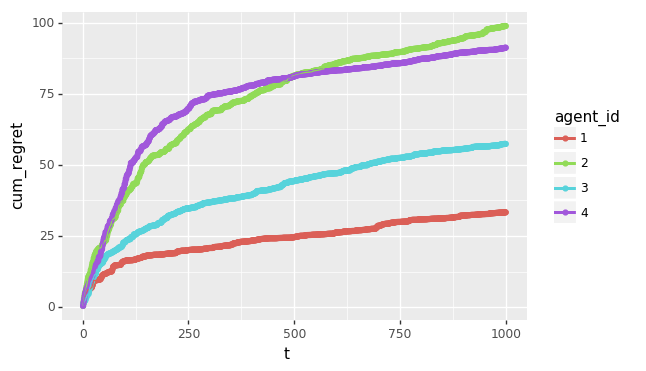

<ggplot: (8751105346413)>


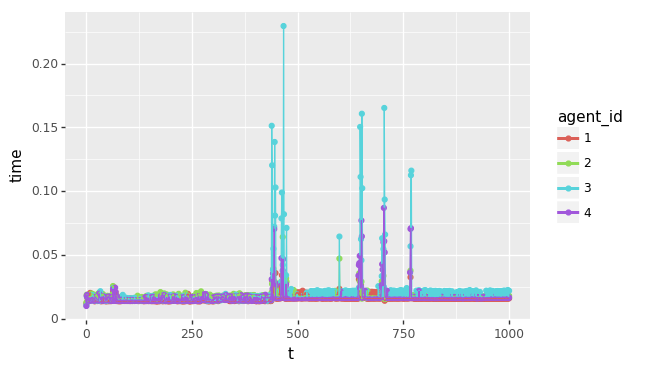

<ggplot: (8751105312797)>


In [12]:
plot_results(results)

In [13]:
time_limit=0.1
make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=1)

make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=1)

make_full_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=1)
make_cum_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=1)

results, cum_regrets = simple_compare([make_sagald_agent(), make_prec_sagald_agent(),make_full_prec_sagald_agent(),make_cum_prec_sagald_agent()], num_articles, dim, sparsity, 1000, seed=2, verbosity=1)

theta [-0.41675785 -0.05626683 -2.1361961   1.64027081 -1.79343559 -0.84174737
  0.50288142 -1.24528809 -1.05795222 -0.90900761  0.55145404  2.29220801
  0.04153939 -1.11792545  0.53905832 -0.5961597  -0.0191305   1.17500122
 -0.74787095  0.00902525 -0.87810789]
Experiment: Step 0
 Sample: array([ 0.22436715,  0.4722598 , -0.42620014,  0.33934808, -0.36322452,
       -0.12083828,  0.78189073, -0.41884087,  0.4924855 ,  0.07127987,
       -0.00927148, -0.51662839, -0.72501376, -0.00617196,  1.18338662,
        0.37475657,  1.19990867,  0.01995096, -1.57614758,  1.18048814,
       -0.05354526])
 Steps taken: 0
 Sample: array([ 1.10427594,  0.75655809,  0.84901847,  0.45630587, -2.95375555,
        0.83750289,  0.29040717,  0.7614484 ,  0.90225639,  0.33184394,
        0.66295112, -1.44567507,  0.10853347,  0.71867728,  0.66000051,
       -0.8750528 , -1.83235847, -0.59974523,  0.04651067,  0.27486642,
        1.63545167])
 Steps taken: 0
+ (1, 1)
 Sample: array([ 1.23956381, -0.73954635,

 Sample: array([-0.83115441, -0.67977659,  1.78520972, -0.95207355,  0.65996638,
       -0.62477087,  0.0343114 ,  1.0348087 , -0.26810742, -0.62068753,
       -0.43492371,  0.89483148,  0.18337482, -0.46580936, -0.09110763,
       -0.6531533 ,  1.19641312, -2.10413065, -0.44294543, -1.95969119,
       -0.79641035])
 Steps taken: 141
Experiment: Step 6
 Sample: array([ 0.57558679, -0.46052964,  1.37867718,  0.49158302, -1.45262305,
        1.41766046, -1.90166878,  0.47013961, -0.84154484, -0.66506424,
        0.12268316, -1.04260039,  0.96817563,  1.21005598,  0.70938746,
       -0.20873893, -0.12451702, -2.38342426, -0.02614759,  1.64147656,
       -2.19959367])
 Steps taken: 869
 Sample: array([ 0.67898066,  0.50766042,  0.02511785, -1.59961152, -0.48529709,
        0.66859997, -0.12908057, -1.13919988, -0.06787688,  0.39907739,
       -0.22961379, -1.01166971, -1.91666835,  1.28440363, -1.81655906,
        0.61065609, -0.54374472,  0.48160371,  0.86255368,  0.99269647,
       -1.17

 Sample: array([-1.21376521, -0.14775974, -1.17658953, -0.18383622,  0.21936351,
       -0.07418055, -0.61214263, -0.02095786,  0.77117222, -0.36442997,
       -0.39565522, -0.55452484, -0.5688669 ,  0.66037181, -0.63993756,
       -1.27726536,  1.10481358, -2.01295873, -0.73257568, -1.84251609,
        0.52044141])
 Steps taken: 161
Experiment: Step 12
 Sample: array([ 0.16297332, -0.6785604 , -0.049342  , -0.45228627, -1.66065231,
        2.27980223,  0.21425831, -0.06452865,  0.90372247, -1.3757104 ,
       -0.2300307 , -0.78193369, -0.77779964,  0.15467132, -0.02476616,
        0.09370583, -0.72158746,  0.75053054, -0.36496746, -0.37085702,
       -0.97561409])
 Steps taken: 844
 Sample: array([-1.19812782, -0.35403301, -0.18334697, -0.7405313 , -0.15645467,
        0.01429927,  1.73802045, -0.03785187, -1.13975025,  0.02239473,
       -0.09632183, -1.919096  ,  0.38969588,  0.77725711, -1.93832958,
       -0.32380351,  0.13181106, -1.13108429,  0.59739537,  0.35890915,
        0.8

 Sample: array([-2.30073543, -1.41911958, -1.90847935, -0.32491579,  0.28046682,
       -0.32115118,  0.72198391, -0.83061951, -0.33917233,  0.19644896,
        0.10585898, -0.12592902,  0.10581089,  0.55341172, -0.13223952,
       -0.76753446,  0.05243229, -0.9285858 , -0.71609148,  0.55873249,
        0.4808003 ])
 Steps taken: 130
Experiment: Step 18
 Sample: array([-0.79489033,  0.37971124, -0.434983  , -0.84245158, -2.60197631,
        0.40738804, -0.75793916,  0.01183572,  0.25591886, -0.57637104,
       -1.54619984,  0.50712261,  1.14999478,  0.71256388, -0.40620059,
       -0.78061821, -1.21265035,  0.30222255, -0.15083127,  1.02634263,
        0.44187501])
 Steps taken: 548
 Sample: array([-1.28912521,  0.12923598,  0.1486182 , -0.57214101,  1.21950995,
        0.62466091,  0.97698888, -1.43188676, -0.96543567, -0.92648144,
       -0.1922313 , -0.54008677,  0.03245158,  0.62827054, -0.87820454,
        0.21236494, -0.55026428, -0.57669723, -1.43746555,  0.12064874,
        0.3

 Sample: array([-1.89489837, -1.83549617, -0.33280311,  0.74770107, -1.25810806,
        0.07971051,  0.39154287, -2.26323603,  0.12473955, -0.92730701,
       -0.85963396, -0.40821686,  0.69143699,  1.12593452, -0.05008257,
        0.50794759, -0.2258117 ,  0.49908851,  0.21992886,  0.46182351,
       -0.29388005])
 Steps taken: 175
Experiment: Step 24
 Sample: array([-0.3388475 , -2.07419571, -0.31851409, -0.0347718 , -0.99683727,
       -0.97025703, -1.47623132, -2.95337251, -0.37800918, -0.43554745,
        0.79390085,  0.64889316,  0.34603523,  0.12621766,  0.68179796,
        0.97367645,  0.47087629,  2.65390369,  2.48417112,  0.59673767,
       -0.63678875])
 Steps taken: 890
 Sample: array([-1.32945067,  0.24009746,  0.48432742, -0.34877491, -1.26004359,
       -0.81237554,  1.017306  , -0.60382714, -0.48576297, -0.81507761,
       -0.36332384, -1.8860935 , -0.11563854, -0.3655254 , -0.74594174,
       -1.06857499, -1.52166856,  0.67883699, -0.45405068,  1.3951019 ,
        0.9

 Sample: array([-1.60457846, -1.83176533,  0.25063813,  0.46884519, -2.52266253,
       -0.87836755,  0.22576239, -0.72769278,  0.15512066, -1.21897808,
       -0.27564367, -0.46580442,  0.74227965,  1.66797595, -0.27744724,
       -0.06691337, -1.08689473,  0.6256625 ,  0.1029753 ,  1.7735402 ,
       -0.80501257])
 Steps taken: 175
Experiment: Step 30
 Sample: array([-1.09241356, -0.08987583,  0.72848025,  1.52739804, -0.67307107,
       -0.4434302 , -0.78525668,  0.49815223,  0.61673671, -1.858461  ,
       -0.85989433,  0.88113367,  0.51875367, -1.1083522 ,  0.93759958,
       -0.94135567,  0.8432259 ,  1.09344208, -0.20934261,  1.48544134,
        0.02117544])
 Steps taken: 851
 Sample: array([-1.40413856,  0.33533092, -0.20791632,  0.41933393,  0.02540243,
        0.42901003,  0.26644136,  0.87062299, -1.45920723, -1.48335683,
        0.59308635, -1.31026596, -0.13427099, -1.19258733,  0.87211472,
       -1.04342574, -1.47303781,  0.05753929, -1.32916528,  1.04374268,
        0.7

 Sample: array([-1.22939028, -1.80931918, -0.87574543, -0.00790917, -0.62843772,
       -2.00906397,  1.19734267, -0.57170914, -0.20374762, -1.48096786,
       -1.63540464, -1.91881106,  0.48986188,  0.45902659,  0.09936627,
        0.38456365, -0.76873601,  0.98506606, -0.51048145,  1.34549733,
        0.54730562])
 Steps taken: 175
Experiment: Step 36
 Sample: array([-0.11745   , -0.18859553, -0.75758876,  0.04356862,  0.04658887,
       -0.42711414, -2.34544078, -0.30336693, -0.48740603, -0.05981925,
       -1.29202527,  0.66946014,  0.67733133, -1.88919954,  2.12928118,
        0.34644367, -0.28567759,  1.70578327, -0.29188494,  1.23260133,
        0.85489045])
 Steps taken: 821
 Sample: array([-0.94022228,  0.54337038, -0.94311829,  0.14828374, -0.49614487,
       -0.77825717, -0.21672642,  0.40746065, -2.37046619,  0.3831307 ,
        0.22439321, -0.72948113, -0.54066405, -1.16025933, -0.08766205,
        0.18355914, -0.73370157,  0.18342883, -1.13334358,  0.48164053,
        0.2

 Sample: array([-0.77895732, -0.6456134 , -0.690087  , -0.75753605, -1.48360428,
       -2.49788378,  0.77512938, -0.33314553,  0.21703353, -0.7000285 ,
       -2.00158578, -1.17461142,  0.86693159, -0.0860844 ,  0.45371693,
        0.0932115 , -0.13510164,  0.05112378,  0.43748038,  0.26261728,
        1.02188066])
 Steps taken: 169
Experiment: Step 42
 Sample: array([-0.30991004,  0.18673085, -0.51028351,  1.62925771, -0.51638247,
        0.03841622,  0.50137   , -0.72159713, -0.61703655,  1.36301907,
       -0.86420844,  1.8843498 , -0.04802627,  0.47274891, -1.24162912,
       -0.73557113,  0.9052715 ,  0.43967232,  0.65823594,  0.40413143,
       -0.29272775])
 Steps taken: 814
 Sample: array([-2.05873015,  1.89763528, -1.2315056 ,  0.04925481, -0.53261333,
       -0.51993488, -0.23560095,  0.05588433, -0.68184554,  0.37569133,
        0.5619344 , -1.25635837, -0.623424  , -1.15929896, -0.86473551,
       -0.05311451,  0.19776895, -0.22018706, -0.57700332,  0.65916603,
       -0.1

 Sample: array([ 0.47966203, -1.69674335, -1.14690363, -1.23228811, -1.49811067,
       -2.33786685, -0.1145117 , -1.17637415, -1.18324   , -0.73274339,
       -0.94183011,  0.50400227,  0.81755789, -0.24206516,  0.26641877,
       -0.6794145 , -0.70000734,  0.47765333, -0.38487773, -0.21080186,
        1.31243225])
 Steps taken: 163
Experiment: Step 48
 Sample: array([-1.6459575 ,  0.50488077,  0.88511808,  1.58108144, -0.05835526,
        0.3032369 ,  0.40672601, -0.62042117,  0.42586965, -1.48595736,
       -1.0338462 ,  1.33501123,  0.95100886,  0.82041797,  1.0974223 ,
       -1.14912174, -0.61362683, -0.19499001, -1.06546213,  1.1555319 ,
       -0.49521334])
 Steps taken: 683
 Sample: array([-2.05877411,  1.59009507, -1.09640037,  0.51329989, -0.08205358,
       -1.64562653, -0.18680226, -0.29074685, -0.53091949,  0.70645277,
        0.08982784, -0.81419684, -0.68676408, -1.02596861, -0.89262588,
       -0.74031227, -0.91229933, -0.12688502,  0.06476364,  1.40718736,
        0.5

 Sample: array([ 0.15817884, -2.08215011, -0.97662102, -0.87991409, -1.15797621,
       -1.74836418, -0.59907553, -0.52577019, -0.65127864, -0.36386931,
       -0.11208284,  0.60948485,  1.25407721, -0.96823694,  0.13940364,
       -0.45543321, -0.11818271,  0.3693167 , -0.14665937, -1.02538588,
        0.58925485])
 Steps taken: 172
Experiment: Step 54
 Sample: array([-0.75916436, -0.12375113, -0.74671309,  2.22414796,  0.25065694,
       -1.70146842,  0.50189001, -0.33324003,  0.31190802, -0.88319186,
        0.25908955,  0.84287278, -0.52141098, -0.98206763,  1.99979161,
        0.34925025, -0.5127924 ,  0.04872117,  0.89560552,  0.65789129,
        0.23510243])
 Steps taken: 746
 Sample: array([-1.35381894,  0.97724185, -1.73142619,  1.02320771,  0.47011504,
       -1.29157757, -0.06371399, -1.45984391, -0.34505879,  0.85948367,
       -0.32627509, -0.03195794, -1.03549737, -2.16720673, -1.16109795,
       -0.68474386, -0.11689271, -0.32199899, -0.57592409,  1.05890465,
       -0.2

 Sample: array([ 0.58691277, -1.00856112, -1.90535542,  0.30124023, -0.61735606,
       -0.85356123,  0.09533109, -0.15582242, -0.64694563, -0.53430869,
       -0.8557246 ,  0.34330685,  0.72625929, -1.10830704, -0.43394391,
        0.56570531, -1.24140197, -0.47617446, -0.32879659, -1.05428963,
       -0.10585018])
 Steps taken: 173
Experiment: Step 60
 Sample: array([-0.11416993,  0.20367089, -0.50385518,  2.95152564, -1.13613735,
       -0.01375437, -0.95598514, -2.88655718, -0.31921859, -0.80539861,
        0.38873873,  0.8689226 ,  0.52994388, -0.92667119,  1.24114742,
       -0.67382923,  0.71228608,  0.06088785, -0.29386025,  0.51314298,
        0.19263308])
 Steps taken: 737
 Sample: array([-1.95511739,  1.60732593, -0.98380838,  0.92164714,  0.37343526,
       -0.98210849, -0.11710771, -1.41760949, -0.41547785,  0.45917713,
       -0.82699249,  0.696607  , -1.05302241, -0.98842005, -2.1004591 ,
       -0.12203071,  0.04303127, -0.52379481, -0.71925397,  0.54655511,
       -0.7

 Sample: array([-0.28738971, -0.56988542, -0.72959264,  0.52957516, -1.76185734,
       -0.76419256,  1.14366599,  0.93486224, -0.56348014, -0.89677109,
       -0.49682815,  0.30331407,  0.81717733, -0.08295771, -0.2184611 ,
       -0.21818747, -1.32704392, -0.31138935, -0.19276867, -1.23417184,
        0.3328948 ])
 Steps taken: 154
Experiment: Step 66
 Sample: array([-0.23848957,  0.16213842, -0.46928869,  1.81377979,  0.22229542,
        0.36000836, -0.25303208, -1.34591791, -0.0834895 , -0.71468621,
       -0.51025783,  0.22645592, -0.12615674, -0.27833165,  1.13621597,
       -0.26071661, -0.57858107,  0.946313  ,  0.57141323, -0.21985682,
       -0.52310192])
 Steps taken: 517
 Sample: array([-2.3763062 ,  1.48282964, -0.45767365, -0.02621681,  0.44268562,
       -1.7228166 , -0.26455196, -1.62586711, -0.55348388,  0.60282624,
       -1.58141282,  0.64913848, -0.07526549,  0.40863555, -1.34397815,
        0.47724826, -0.29858833, -0.67808154, -0.50143307,  0.67181881,
       -0.1

 Sample: array([-0.94090039, -0.28610081, -0.45545096,  0.63738672, -1.11867396,
       -0.40961142,  0.77416117,  0.63017138, -1.10814582, -0.76132721,
       -0.74654977,  0.35029852,  0.59291124,  0.70349721, -0.29994277,
        0.2946487 , -0.39548347, -0.04162481,  0.01325309, -0.92011867,
        0.37566685])
 Steps taken: 154
Experiment: Step 72
 Sample: array([-2.28385727,  0.54576037, -0.58906338,  1.46115928, -1.59139432,
        0.26704741,  0.84961115, -1.90108499, -0.98267342,  0.46511088,
        0.54650259,  0.73491092,  0.15357058,  0.45280335,  1.12527871,
       -0.39013345,  0.29791984,  0.97644785,  0.62350935,  0.87169607,
       -0.11374787])
 Steps taken: 492
 Sample: array([-2.41249042,  1.00667498, -0.96575028,  0.72203814,  0.54213365,
       -1.49452779,  0.53568828, -1.96137975, -0.64461348,  1.26666304,
       -1.49515214,  1.11227411,  0.58583611,  0.20214585, -0.79038659,
       -0.33543538, -1.50214898, -0.83351568, -0.87906947,  0.98826888,
       -0.3

 Sample: array([-0.30676705, -0.38273239, -0.63469726,  0.38977033,  0.00606401,
       -0.41611721,  0.13475571,  0.24092836, -1.40014975, -0.31234407,
       -0.28749576,  0.1926276 , -0.33267392,  0.11483808, -0.6343651 ,
        0.66873369, -0.37698741, -0.70475567, -0.17327833, -0.40145747,
        0.21308081])
 Steps taken: 154
Experiment: Step 78
 Sample: array([-0.89406757,  0.81753151, -1.8793925 ,  2.06967339, -1.63506565,
       -0.74217081,  0.29112068, -1.71817456, -2.21936602,  0.01763193,
        0.21501111,  1.18542415,  0.26433147,  0.84708069,  1.05625754,
        0.08239053, -0.34945113,  0.01726703,  0.26742641, -0.40822419,
        0.92189487])
 Steps taken: 516
 Sample: array([-1.69768694,  0.67053318, -1.47904953,  0.79599106,  0.21786319,
       -1.50490681,  0.39883906, -1.42359643, -0.53166278,  0.95227232,
       -2.01791033,  0.75161235,  0.94149091, -0.17735364, -0.59979549,
       -1.066886  , -1.66119528, -0.10332169, -1.39361009,  0.65536153,
       -0.4

 Sample: array([-0.26439668, -0.60889512, -1.76051522,  1.07776784, -0.64186525,
       -0.01340403, -0.01956784, -0.44884669, -1.0372006 , -0.19635456,
       -1.26488306,  0.2231183 ,  0.38293523,  0.3021118 , -0.15161528,
        0.29824409, -0.28407697, -0.58611652, -0.21727471, -0.26971748,
       -0.60258305])
 Steps taken: 152
Experiment: Step 84
 Sample: array([ 0.49814418,  0.67934481, -1.25888575,  0.86509006, -1.14239439,
       -0.29415383, -0.08331564, -1.45889979, -2.28635168,  0.46888936,
        0.84609182,  1.23796304,  0.24858547,  0.81681032, -0.30622909,
       -0.21875535, -0.7456482 ,  0.47522709, -0.32239186, -0.20365484,
       -0.30904315])
 Steps taken: 517
 Sample: array([-0.86780517,  0.15748266, -1.68161048,  0.31076915, -0.04668546,
       -1.10839715,  0.49322946, -1.16219275, -0.91351807,  0.12263321,
       -1.23917069,  0.55180969,  1.17540847, -0.6001988 , -0.84143998,
       -0.78353494, -1.89261563,  0.1117376 , -1.42143798,  0.13853063,
       -0.7

 Sample: array([-0.110829  , -0.79067273, -0.96380721,  0.2870181 , -1.30936137,
       -0.32008412,  0.19814611, -0.49946775, -1.1511502 , -0.1824852 ,
       -1.75147114, -0.32477373,  0.13437081,  0.20518588,  0.29605905,
        0.31653427, -0.10735907, -0.14299578,  0.24179224, -0.31811676,
       -0.29204524])
 Steps taken: 150
Experiment: Step 90
 Sample: array([-0.00975607,  0.61396674, -0.62832201,  2.80717036, -0.75443447,
       -0.43789558, -0.73519012, -1.16010205, -0.27559049, -1.56658812,
       -0.96084798,  0.88124512,  0.12609666, -0.4287829 ,  0.67059465,
        0.43717718, -0.33598839, -0.11608143, -0.99075789,  0.57836676,
       -0.39290235])
 Steps taken: 523
 Sample: array([-1.35785951,  0.33999134, -1.38186226,  0.12966879, -0.73456195,
       -1.70968126,  0.94140461, -0.49925155, -1.39793514,  0.36258514,
       -1.24915448,  0.56656358,  1.43294235, -0.96319273, -1.56025617,
       -0.27003505, -1.50994824,  0.31722102, -0.62459962,  0.22867852,
        0.1

 Sample: array([-1.21736305,  0.65089824, -0.51895776,  0.73165451, -1.07505209,
       -0.91312485,  0.38190794, -1.01576777, -0.91529064,  0.06861469,
       -1.42057426,  0.6183621 ,  0.54026751,  0.53286309,  0.34810747,
        0.14409011, -0.52234809, -0.13788314,  0.11374236, -0.12713452,
       -0.99080211])
 Steps taken: 150
Experiment: Step 96
 Sample: array([-0.01401904,  0.17672876, -1.30945169,  0.79384155, -1.06009887,
       -0.7531187 ,  0.97837523, -2.26901239, -1.16213881, -0.81561543,
        0.39521195,  2.20442178,  0.02264225, -0.89056803,  0.78157682,
        0.65644293, -1.49577675,  2.33748022, -1.4416203 , -0.37253079,
        1.0793891 ])
 Steps taken: 524
 Sample: array([-1.02526804,  0.54315726, -1.68226375,  0.85389109, -0.96050157,
       -2.53937455,  1.35407978, -0.30416959, -1.91147739, -0.41124483,
       -1.19367011,  0.16520488,  1.1139986 , -0.53345404, -1.02137245,
       -0.20960345, -1.59118763,  0.23493052, -0.39285139,  0.24321031,
        0.1

 Sample: array([-1.09826422,  0.12583989, -1.02717439,  0.91317628, -0.55426649,
       -0.68170849,  0.61475851, -0.70185944,  0.13576117, -0.42582801,
       -1.26749085,  1.09692708,  0.71429213,  0.10554403,  0.06686806,
       -0.47333418, -0.92801976, -0.30685382,  0.40845609, -0.40879821,
       -0.68716425])
 Steps taken: 155
Experiment: Step 102
 Sample: array([-0.33249051, -0.34557833,  0.48576043,  1.90950917, -0.49394967,
       -0.38576626, -0.49088141, -0.54091607, -1.5799574 , -0.58975622,
        0.16473193,  1.08472968, -0.06036387, -0.69099255,  0.70023469,
        0.4551173 , -0.54442541,  1.01526883, -0.32020058, -0.18218401,
        1.07859574])
 Steps taken: 529
 Sample: array([-0.88327674,  0.45248015, -1.80496912,  1.0714045 , -1.17048737,
       -2.25466875,  1.27132976, -0.18691386, -2.0236466 , -0.52120447,
       -0.8194352 ,  0.38784456,  1.22160197, -0.14070837, -1.15437196,
       -0.5009588 , -1.03544875,  0.20746393, -0.70550988,  0.12793816,
       -0.

 Sample: array([-0.8196862 ,  0.04959146, -1.60116885,  0.90798101, -0.63717828,
       -0.56226074,  0.27433133, -0.07879603,  0.00323163, -0.52569901,
       -0.71484919,  1.44531052,  0.20836604,  0.50583185, -0.22592915,
       -1.20636775, -0.74537734,  0.04674872, -0.30102735, -0.68292396,
       -0.67210425])
 Steps taken: 132
Experiment: Step 108
 Sample: array([-0.36391877,  0.97478139, -0.59984283,  1.0865464 , -0.92172864,
       -1.17702457,  0.31325108,  0.20143141, -0.54822264, -1.18894788,
        0.38347727,  1.72836377, -1.35489359, -1.03654705,  1.9167181 ,
        0.51503812, -0.68299955,  0.568421  , -0.25809407,  0.33867916,
       -0.93274722])
 Steps taken: 397
 Sample: array([-0.66906743,  1.01426345, -2.00086931,  0.54419096, -0.59147541,
       -2.48630044,  1.08657028,  0.13734332, -1.69214919, -0.41179433,
       -1.09143331, -0.22779947,  0.89238276, -0.97169671, -0.75185952,
       -0.80751401, -0.57155788,  0.18024127, -1.06212252,  0.11438368,
       -0.

 Sample: array([-0.7074275 , -0.46405325, -1.72897976,  1.1452908 , -0.18731835,
       -0.33438278,  0.51327885, -0.28179635,  0.07879765, -0.30400494,
       -0.26437239,  1.45868   ,  0.47348091,  0.15487297, -0.31730671,
       -1.69141622, -1.39350724,  0.10066577, -0.6115367 , -0.86365898,
       -0.5672134 ])
 Steps taken: 150
Experiment: Step 114
 Sample: array([-1.17693027,  0.68623806, -0.76704955,  1.75327994, -2.07096787,
       -1.70871055,  0.42140759, -0.00363474,  0.2176072 ,  0.13676115,
       -0.14781609,  0.59207262, -0.03618114, -0.13797558,  1.0223906 ,
        0.76045788, -0.44741587,  0.73175078,  0.08500341, -0.01013256,
       -0.0224537 ])
 Steps taken: 506
 Sample: array([-0.69395914,  0.9681926 , -1.83720436,  0.51985819, -0.32560974,
       -2.31384722,  0.92802995,  0.05894077, -1.96999386, -0.18031248,
       -1.11164463,  0.00338483,  0.57641251, -0.36568229, -0.903175  ,
       -1.16454503, -0.97093535,  0.69123503, -1.33848464, -0.45414792,
       -0.

 Sample: array([-1.00720953, -0.14952832, -1.04457933,  1.25224217, -0.25805645,
       -0.47734644,  0.28873644, -0.757907  , -0.09490802, -0.28686567,
       -0.63488072,  1.02106253,  0.68296992, -0.2871492 , -0.30432398,
       -1.03337079, -0.90351989,  0.18350224, -0.1486803 , -0.25983234,
       -0.44759314])
 Steps taken: 148
Experiment: Step 120
 Sample: array([-0.09387922,  0.30491755, -0.91603596,  1.00702647, -1.11329759,
       -1.32326786,  0.55265877, -0.42139137, -0.86376434, -0.93602756,
        0.61933756,  1.19963482, -0.36113251, -0.90161211,  1.09594499,
        0.10102506, -0.69131153,  0.6177186 , -0.47829892, -0.17560622,
        1.2972351 ])
 Steps taken: 518
 Sample: array([-0.57838776,  0.589199  , -1.78985273,  0.53461073, -0.61497238,
       -2.41989898,  1.15324882, -0.04830436, -1.89902676, -0.34443434,
       -0.6852942 ,  0.89011517,  1.39859524,  0.05704828, -1.28426253,
       -1.27941152, -0.5265822 ,  0.1840406 , -2.45770857, -0.50831509,
       -0.

 Sample: array([-0.85526375,  0.11801085, -0.27683376,  0.7575686 , -0.71526422,
       -0.63717877,  0.81535076, -0.67054489, -0.01215456, -0.55347028,
       -1.12074779,  1.34000794,  0.7407731 , -0.27737552, -0.57192788,
       -0.95606325, -1.42657212,  0.44761082, -0.24576438, -0.41789156,
       -0.89990708])
 Steps taken: 132
Experiment: Step 126
 Sample: array([ 0.56160882, -0.22966417, -0.25195913,  0.77255351, -0.39931358,
       -1.37038608, -0.66309355,  0.65773927, -0.87539987, -0.63202825,
       -0.1765368 ,  1.81988531, -0.44755759, -1.03641411,  0.34115471,
       -0.07994112, -0.3906555 ,  1.31438604, -1.54871745,  1.07158087,
       -0.66566014])
 Steps taken: 471
 Sample: array([-1.28865161,  0.32618393, -1.37548877,  0.97290814, -0.4575177 ,
       -2.08434   ,  1.10367734,  0.22617724, -2.3989206 , -0.29875162,
       -0.30157836,  0.94481947,  0.47281376,  0.37387205, -0.94577748,
       -1.27243202, -0.03447076,  0.0111172 , -1.87147959, -0.17172592,
       -0.

 Sample: array([-0.73618538, -0.11418199, -0.10938363,  0.83268006, -0.32562859,
       -0.93999441,  1.12562597, -0.70837685, -0.47845683, -1.28798427,
       -1.12229445,  1.04837174,  1.09048639, -0.39939967, -0.30479763,
       -0.61405967, -1.13664344,  0.52771774, -0.42548231, -0.24683058,
       -1.50290083])
 Steps taken: 155
Experiment: Step 132
 Sample: array([-0.46205845,  0.26186896, -1.14838805,  1.87571801, -1.93263033,
       -0.69202221, -0.78821779, -2.00952185, -1.47744252, -0.61561141,
       -0.3081471 ,  1.66639043,  0.08665039, -0.74694912,  1.08964985,
        0.17866519, -0.91184731,  0.56915336, -0.56652919,  0.75446439,
        0.18736249])
 Steps taken: 503
 Sample: array([-1.21461384,  0.69264776, -2.1564409 ,  0.843913  , -0.77212914,
       -2.38739613,  0.61917278,  0.13940468, -2.46735688,  0.56340226,
       -1.02160329,  1.67535197,  0.49786513, -0.00441861, -1.5840241 ,
       -1.4563179 , -0.23815335,  0.53171126, -1.19923787, -0.22448023,
       -0.

 Sample: array([-0.97859984, -0.05974955, -0.16811774,  0.70250394, -0.46937006,
       -1.21315156,  1.18312733, -0.24919666, -0.16982761, -1.03287547,
       -1.46838504,  0.96311802,  0.68316294, -0.17431858, -0.18184926,
       -0.9584748 , -0.44718854,  0.12885548,  0.53143172,  0.09879284,
       -1.40927458])
 Steps taken: 152
Experiment: Step 138
 Sample: array([ 0.17291036, -0.22823746, -0.04601548,  1.27390582, -1.24793173,
       -1.20066808,  0.85487028, -0.03394081, -0.9264376 , -0.88194664,
        0.3002688 ,  1.26702686, -0.309643  , -1.27141108,  0.76843928,
       -0.62214714, -0.23150767,  1.45896839, -1.40236428,  0.79646178,
       -1.28148713])
 Steps taken: 508
 Sample: array([-1.71175719,  0.56992019, -1.59766902,  1.25650085, -0.53965486,
       -1.73145251,  0.94214376, -0.26564529, -2.59165606,  0.8429368 ,
       -0.79789079,  2.01246216,  0.39239425, -0.35659699, -2.48450011,
       -1.13534899, -0.1796893 ,  0.79049971, -1.51116847, -0.35349647,
       -0.

 Sample: array([-0.69329685, -0.03594861, -0.01476252,  0.77139578, -0.75585547,
       -1.62613141,  1.11741145, -0.37986051, -0.38765408, -1.15658299,
       -0.84702906,  1.44056827,  0.41653689, -0.77882321, -0.22863113,
       -0.65843411, -0.43550828,  0.24329518,  0.44044043, -0.30002237,
       -1.35352199])
 Steps taken: 149
Experiment: Step 144
 Sample: array([ 0.57922461, -0.49191141, -0.36691959,  1.60317359, -1.08364042,
       -0.69999006,  0.0511349 , -1.11078134, -2.32277948,  0.23055121,
        0.48636002,  1.26603333, -0.65946528, -0.93817483,  0.8435395 ,
        0.51858837,  0.01057699,  0.72800736, -1.12509286, -0.43035351,
        0.10552493])
 Steps taken: 544
 Sample: array([-1.61639685,  0.42551024, -1.97826305,  1.37900436, -1.39922823,
       -0.96664234,  0.92835133, -0.91969416, -2.21674556,  0.79189375,
       -0.99808118,  1.41422949,  0.6113321 , -0.56784491, -2.0292939 ,
       -1.09603411,  0.20467655,  1.03021763, -0.82115452, -0.28139233,
       -0.

 Sample: array([-0.67862457,  0.23257314, -0.05167595,  0.87818325, -1.1091539 ,
       -2.0297651 ,  0.91408757, -0.15673567, -0.58509272, -0.66705154,
       -0.85485899,  1.44383857,  0.10444022, -0.90241364, -0.26121188,
       -0.41885818, -0.24989899,  0.38395401,  0.26903353, -0.05812137,
       -1.3125429 ])
 Steps taken: 151
Experiment: Step 150
 Sample: array([-0.67943658,  0.11851673, -0.40803522,  2.59160422, -1.21668215,
       -0.62606316,  0.08196009, -0.28134207, -1.20335433, -2.22670533,
        0.47324655,  0.41387717, -0.4781745 , -0.77416405,  1.26990519,
        0.66531683,  0.46806512,  0.86918943, -0.67236622,  0.35547905,
       -0.85829093])
 Steps taken: 543
 Sample: array([-1.71388222,  0.47494203, -1.64280679,  2.36617569, -1.64622856,
       -1.37572685,  1.12011684, -0.90845582, -2.09379078,  0.05513217,
       -1.00112577,  1.40625303,  1.53595874, -0.39956859, -1.51444965,
       -1.23301624,  0.42598156,  0.93859409, -0.92246118, -0.45566333,
       -0.

 Sample: array([-0.86130546,  0.14630799,  0.2247346 ,  0.78073439, -1.2467896 ,
       -2.58367592,  0.89681347, -0.31646975, -0.16335892, -0.71183151,
       -0.94557587,  1.63319626,  0.35407235, -0.62050336, -0.5049798 ,
       -0.1849298 , -0.05108185,  0.3247535 ,  0.04540321,  0.05238166,
       -1.21314206])
 Steps taken: 117
Experiment: Step 156
 Sample: array([ 0.48419671, -0.96645235, -0.17165323,  1.19208794, -1.43984136,
       -1.06940768, -0.28021634, -1.2237375 , -1.72214369, -2.52293922,
        0.71944337,  2.10831511, -1.25556807, -1.02552662,  0.43129238,
        1.09322591, -0.42227701,  1.54992389, -0.73474389,  0.59536342,
       -0.63112424])
 Steps taken: 438
 Sample: array([-1.751637  ,  0.31017973, -1.42296533,  1.98540277, -1.20939417,
       -1.63878178,  0.99194185, -1.04988605, -1.85721723, -0.00840687,
       -0.91804044,  1.37979193,  1.348679  , -0.28290073, -1.22630716,
       -1.3147616 ,  0.01693694,  1.09274696, -0.12329185, -0.52024058,
       -0.

 Sample: array([-0.90578975,  0.51514236,  0.09097168,  1.08214554, -1.21473195,
       -2.01363083,  0.90480191, -1.50163698, -0.21868403, -1.06130931,
       -0.54614178,  1.75085786,  0.34524013, -0.74938347, -0.04797426,
       -0.52345218,  0.53550636,  0.2367003 , -0.01217131,  0.01277022,
       -1.29371499])
 Steps taken: 146
Experiment: Step 162
 Sample: array([-0.39342046,  0.2038607 ,  0.74916459,  1.29405624, -0.77185385,
       -0.60923414,  0.23247533, -0.53337081, -1.20718713, -0.3886776 ,
        0.85072778,  1.71357965, -0.62460994, -0.95706738,  0.68623397,
       -0.04575178,  0.1593407 ,  0.88649361, -1.01684521, -0.16398654,
       -0.4196234 ])
 Steps taken: 480
 Sample: array([-2.12703204, -0.05037352, -1.13511406,  1.55068635, -0.98548128,
       -1.86160089,  0.94138213, -1.48735611, -1.8162249 ,  0.2029648 ,
       -0.60509428,  1.93318364,  1.2866977 ,  0.09977967, -0.55234742,
       -0.400453  , -0.25262852,  0.53265217,  0.45361257, -0.62552806,
       -0.

 Sample: array([-2.95038119e-01, -1.92997274e-03, -6.11438813e-02,  7.96608828e-01,
       -1.11898494e+00, -1.98831331e+00,  8.03594523e-01, -1.81393748e+00,
       -7.71003299e-01, -1.03637566e+00, -5.33485690e-01,  1.31790092e+00,
        4.97932931e-01, -9.76602880e-01, -3.58300440e-01, -5.60255951e-01,
        2.62857210e-01,  3.25848278e-01, -2.09058173e-01,  1.27446017e-01,
       -8.71124732e-01])
 Steps taken: 153
Experiment: Step 168
 Sample: array([-0.96540378, -0.8090806 , -1.84822736,  1.47793744, -1.13131472,
       -0.41811799,  0.56546901, -1.30676795, -1.4368271 , -1.95194727,
        1.03798228,  1.55215633,  0.21451877, -0.39479321,  0.56668063,
        0.45992293, -0.55362272,  2.26996679, -0.70158538,  0.86543195,
       -0.18700451])
 Steps taken: 523
 Sample: array([-2.04508689, -0.34472271, -1.30709895,  1.31146416, -0.90041228,
       -1.49799936,  0.89323479, -1.50289166, -1.90543382,  0.37890025,
       -0.32289341,  2.41168558,  1.29833721,  0.30590045, -0.9

 Sample: array([-0.12624302, -0.09197333,  0.31503924,  0.96645956, -1.24152165,
       -1.46558674,  0.82428562, -1.28180042, -1.4206225 , -1.41715896,
       -0.66627607,  1.7118678 ,  0.40462304, -0.82576883, -0.98210925,
       -1.04891663, -0.26155375,  0.29483754, -0.70283704,  0.39908902,
       -0.23306824])
 Steps taken: 152
Experiment: Step 174
 Sample: array([ 0.40338614, -0.10793846, -1.06002013,  1.4340466 , -0.98419799,
       -1.1249103 , -0.75074416, -1.19459371, -0.9194634 , -0.59898868,
        0.44797032,  2.07741081,  0.57939243, -1.07910294, -0.33194967,
        0.85723343, -0.45867776,  0.45880657, -0.70321087,  0.46606121,
       -1.15594979])
 Steps taken: 527
 Sample: array([-1.54819059, -0.7308666 , -0.98696351,  0.95168956, -1.60714674,
       -1.46619027,  0.80610502, -1.27979818, -2.16823459,  0.0318784 ,
       -0.815067  ,  2.69028922,  1.51736612,  0.36934447, -1.25744641,
       -0.31651974,  0.09680036,  0.64042107,  0.0353996 , -0.10605901,
       -0.

 Sample: array([-0.37548698,  0.17968982, -0.05781969,  0.88249564, -0.82642433,
       -1.59711569,  1.24540006, -1.6338888 , -1.36682466, -1.44135712,
       -0.28919342,  1.94135626,  0.61856859, -1.02307242, -0.26774665,
       -1.07547389, -0.52659026,  0.69660987, -0.64115687, -0.26251856,
       -0.91418406])
 Steps taken: 151
Experiment: Step 180
 Sample: array([-0.07646005, -0.13138649, -0.21070122,  1.72487942, -2.17471604,
       -0.9089022 ,  1.06816589,  0.05648755, -1.05754581, -1.68080227,
       -0.33922666,  1.69334913, -0.42968607, -0.67845346,  0.21915016,
        0.40478541,  0.04675677,  1.74587499, -1.57266379,  0.41155303,
       -0.93756369])
 Steps taken: 531
 Sample: array([-1.14964952, -0.86134945, -1.77011695,  0.96822404, -1.60918064,
       -1.48461722,  1.10437858, -1.44557478, -2.27849746, -0.08223111,
       -0.76012419,  2.18688385,  0.85453814,  0.6583244 , -1.02965526,
       -0.44123549,  0.13518439,  0.40753694, -0.17927289, -0.2424881 ,
        0.

 Sample: array([-0.10090937,  0.48941586, -0.13216333,  0.92620922, -0.46774481,
       -1.37420135,  1.00542275, -2.11842538, -1.26026552, -1.35407944,
       -0.33448946,  1.774578  ,  0.37774571, -0.90111951,  0.05734294,
       -0.73639494, -0.39002404,  0.20634897, -1.26414557, -0.18401526,
       -1.54531993])
 Steps taken: 153
Experiment: Step 186
 Sample: array([ 0.29795872,  0.29776587, -0.23185871,  0.34367235, -0.40665758,
        0.16056436,  0.83288883, -1.0408644 , -1.12997058, -1.77194283,
        0.70665842,  0.85050466, -0.22124226, -0.55752214,  0.25919126,
       -0.18787503, -1.01449001,  1.09684387, -0.68943073,  0.68237849,
        0.39241022])
 Steps taken: 524
 Sample: array([-1.10642806, -0.55005462, -1.17840175,  0.91863327, -1.32922614,
       -1.73016629,  0.77453207, -1.69360463, -2.62546951, -0.06375741,
       -1.14181247,  2.15416999,  0.64353488,  0.18522181, -1.4464123 ,
       -0.52238518,  0.58485526,  0.59244257, -0.50508685,  0.39575191,
       -0.

 Sample: array([ 0.02560195,  0.33438856, -0.21813263,  0.89467557, -0.88865822,
       -1.29307469,  0.94496757, -1.64243348, -1.47754206, -1.75959012,
       -0.71519741,  1.63113096,  0.34768834, -0.4211532 , -0.04132515,
       -0.24006459, -0.58299567, -0.06865152, -1.08110586, -0.40083613,
       -1.72005338])
 Steps taken: 154
Experiment: Step 192
 Sample: array([-0.65171529, -0.22367728, -0.65222626,  1.6093789 , -0.92019626,
        0.01209531, -0.16625753, -1.16389564, -0.42711397, -0.4764753 ,
        0.73372562,  1.64054195,  0.21874122, -1.30567605,  0.33971854,
        0.34352503, -0.87423001,  1.52163106, -1.59715434,  0.80823989,
       -0.12580238])
 Steps taken: 528
 Sample: array([-1.49024405, -0.11294192, -0.80704123,  1.1561515 , -1.39854685,
       -1.3600868 ,  0.73967877, -1.57918698, -2.4239916 , -0.57561914,
       -0.79334128,  2.17707473,  0.83564434, -0.25644702, -0.937961  ,
       -0.59127966,  0.34883732,  0.87067749, -1.00898032,  0.52950912,
       -0.

 Sample: array([ 0.35550337,  0.48437081, -0.59938404,  0.48435334, -1.01149553,
       -1.432844  ,  0.99526061, -1.62293791, -1.30376021, -1.60450657,
       -1.21634583,  1.78896992, -0.14948694, -0.70149411, -0.24643641,
       -0.19962658, -0.45855884,  0.17685176, -1.12326065, -0.43045301,
       -1.11578573])
 Steps taken: 155
Experiment: Step 198
 Sample: array([-1.29349343, -0.13436327, -0.54945517,  1.36148226, -0.14835142,
       -0.82992813,  0.50447479, -1.5440805 , -0.54884369, -0.0222846 ,
        1.34106566,  1.16648033, -0.32202439, -0.84772999,  0.06247933,
        1.40580574, -0.41772431,  1.38599644, -1.18705612,  0.59916142,
        0.08725745])
 Steps taken: 533
 Sample: array([-1.44125935,  0.07672101, -1.41840148,  1.18560358, -1.05858687,
       -1.54648982,  0.68437355, -2.09480843, -1.80575664, -0.65791835,
       -1.00243859,  1.95067505,  0.44170971,  0.26652237, -1.37711364,
       -0.57997815,  0.24150943,  1.00343099, -1.17391566,  0.8415205 ,
       -1.

 Sample: array([-0.05384991,  0.07668556, -0.32273728,  1.02220438, -1.03823895,
       -1.55727961,  0.80112609, -1.43901234, -1.201755  , -1.89471077,
       -1.29205838,  1.74014193, -0.47945473, -0.78819426, -0.1560859 ,
       -0.64339512, -0.30677164,  0.76175966, -0.68988862, -0.3484486 ,
       -0.92330778])
 Steps taken: 153
Experiment: Step 204
 Sample: array([ 0.38080692,  0.38574458,  0.17252628,  1.18099258, -1.00344992,
       -0.36508831,  0.40563234, -1.1867525 , -2.51128255, -0.74423276,
        0.30001782,  1.59002542,  0.09269855, -1.06404851, -0.154267  ,
        0.30261031, -1.34615861,  1.33997743, -0.9832821 ,  0.18142976,
        0.36851729])
 Steps taken: 527
 Sample: array([-1.46854112, -0.0137567 , -1.67254934,  1.3097516 , -1.35859297,
       -2.05340702,  0.98373732, -1.90942164, -2.48570276, -0.03795143,
       -1.21782435,  1.8384905 ,  0.53264676,  0.05889289, -1.22008733,
       -0.08352167,  0.49370024,  1.11913634, -1.43816727,  0.37661906,
       -1.

 Sample: array([-0.10225802,  0.28489543, -0.85731103,  0.99077799, -1.13787242,
       -1.53090829,  1.20029905, -1.24509985, -0.93956501, -1.46822341,
       -1.31137016,  1.51116459, -0.35761986, -0.54238268, -0.15411752,
       -0.22580871, -0.53885201,  0.57936667, -0.97429022, -0.24650013,
       -0.7607549 ])
 Steps taken: 154
Experiment: Step 210
 Sample: array([ 0.58172107, -0.00993847,  0.1706965 ,  1.70243158, -1.59949784,
       -0.28212194, -0.03223319, -1.61106711, -1.390687  , -1.4741181 ,
        1.00723649,  0.83383448, -0.0295843 , -1.38404069, -0.01104329,
       -0.04056917, -0.15513858,  0.78902988, -0.86489054,  0.53939568,
       -0.98474426])
 Steps taken: 542
 Sample: array([-1.11750145, -0.36593219, -2.24043465,  1.1513382 , -0.88762915,
       -2.40430194,  0.85631031, -1.45591432, -2.31400775, -0.2452726 ,
       -1.1728586 ,  1.60427135,  0.84103397,  0.18330952, -0.88444489,
        0.3459203 ,  0.67401735,  0.71942016, -1.33989307, -0.02072631,
       -1.

 Sample: array([-0.58036263,  0.18893227, -0.81843526,  0.9301136 , -1.21645135,
       -1.38951715,  1.17614386, -1.10057259, -0.71552108, -1.17708653,
       -0.65362052,  1.61330268, -0.45724906, -0.54828085,  0.23762637,
        0.66210718, -0.91286552,  0.6501067 , -0.93989859,  0.10328026,
       -1.1851179 ])
 Steps taken: 149
Experiment: Step 216
 Sample: array([-0.19562414, -0.13016223, -1.39338644,  1.87042175, -2.02834885,
       -0.83070755,  0.4657846 , -0.65305589, -1.85778497, -1.36508067,
       -0.19071999,  1.5265768 , -0.17480563, -0.73956575,  0.63533872,
       -0.23663776,  1.00892754,  1.30829163, -0.38644092,  0.35547683,
       -0.24378467])
 Steps taken: 521
 Sample: array([-1.11124844, -0.11659695, -2.43594187,  1.18685175, -1.36839166,
       -1.84969386,  0.92252025, -0.93496412, -1.69047154, -0.43941508,
       -2.02237071,  1.76195449,  0.44354278,  0.11226371, -0.39887362,
       -0.02453806,  0.2724068 ,  0.66282932, -1.45484172,  0.28892152,
       -0.

 Sample: array([-0.75448588,  0.20767072, -0.86664127,  1.18979013, -1.40118436,
       -0.98333524,  1.16006071, -1.57888132, -0.81577414, -1.12059393,
       -0.55678451,  1.60089417, -0.07515108, -0.59595207,  0.17141388,
        0.83001692, -0.76967433,  0.99467777, -0.81576343,  0.10846907,
       -1.1230253 ])
 Steps taken: 150
Experiment: Step 222
 Sample: array([-0.54830159,  0.5673664 , -0.24923819,  1.60852587, -1.69369129,
       -0.75203986, -0.29553451, -0.206748  , -1.45684561, -0.78344068,
        1.15118579,  1.55704357, -0.35287565, -0.80310946, -0.05554715,
        0.03562227,  0.36473174,  1.29402719, -0.35627575, -0.28769095,
       -0.45701969])
 Steps taken: 523
 Sample: array([-1.7368565 , -0.14933929, -2.37352871,  2.3557983 , -1.54795697,
       -1.86494669,  1.01737798, -1.01508362, -1.25268847, -0.40848919,
       -1.38492906,  2.18003219,  0.50827815,  0.20938061, -1.09918611,
       -0.22237105,  0.26623593,  1.22329143, -1.11320388,  0.25763874,
       -0.

 Sample: array([-0.14550601, -0.12590051, -1.02107301,  0.75418915, -1.27803833,
       -1.3558583 ,  1.29107091, -1.55868787, -0.77694687, -0.93594152,
       -1.01313366,  1.67543655, -0.40773921, -0.89011496,  0.1336714 ,
        0.79215248, -0.82389121,  1.22052861, -0.70600784, -0.02020172,
       -1.37758788])
 Steps taken: 154
Experiment: Step 228
 Sample: array([-0.782251  ,  0.34102314, -1.49952147,  1.44308886, -1.32424951,
       -0.21570511, -0.46417182, -0.81847673, -1.51868814, -1.04622064,
        1.24640327,  1.83505168, -0.0938391 , -0.34104153,  0.36101564,
        0.46787078, -0.1891353 ,  1.67402676, -0.40048066, -0.02922586,
       -0.98398485])
 Steps taken: 538
 Sample: array([-1.62809888, -0.10144245, -2.65662969,  2.06439214, -2.05785143,
       -1.68324188,  0.29204742, -0.73894044, -1.7639336 , -0.5895548 ,
       -1.16174415,  2.20217191,  0.44615575,  0.3857367 , -0.6589839 ,
       -0.20564723,  0.39901538,  1.94168071, -1.16611346,  0.43738119,
       -0.

 Sample: array([ 0.12431415, -0.14128902, -1.13479269,  0.57867258, -1.47072178,
       -1.76039223,  1.1165617 , -1.66490811, -0.84842526, -1.05509152,
       -0.74072512,  1.92997335, -0.24995522, -0.73889768, -0.14227654,
       -0.0352527 , -0.75687194,  1.30382112, -0.77926786, -0.35031907,
       -1.4260817 ])
 Steps taken: 152
Experiment: Step 234
 Sample: array([-1.70257558e+00,  4.47095551e-01, -1.05266740e+00,  1.87546143e+00,
       -1.17022118e+00, -1.24708697e+00,  1.79272655e-01, -6.07163078e-01,
       -6.37935604e-01, -9.78319747e-01,  1.17752618e+00,  1.56104171e+00,
        2.62560193e-01, -1.81390612e+00,  9.59101148e-01,  2.91920631e-01,
       -2.41253442e-01,  1.83728852e+00, -1.57835082e-03,  8.20527770e-01,
       -7.73442530e-01])
 Steps taken: 535
 Sample: array([-1.37080069,  0.21395052, -2.19480278,  1.93270787, -1.59037371,
       -1.86516306,  0.32292162, -1.04132587, -2.2746308 , -0.15440141,
       -1.03068568,  2.22925527,  0.17836365,  0.48788621, -0.2

 Sample: array([-0.00731995,  0.05176482, -1.39250496,  0.56213886, -1.72964502,
       -1.73244587,  0.69495826, -1.3052325 , -0.48800436, -1.30836853,
       -0.56610907,  1.78650296, -0.20254308, -0.53420049,  0.11823739,
       -0.14052594, -0.71172942,  1.04722773, -0.88674382,  0.13346587,
       -1.32482347])
 Steps taken: 121
Experiment: Step 240
 Sample: array([-6.94696977e-01,  3.99707761e-01, -1.89966988e+00,  2.10920343e+00,
       -9.81746998e-01,  6.94066784e-02, -8.18533990e-01, -1.55803534e+00,
       -1.75834770e+00, -1.37771784e+00,  8.72786960e-02,  2.08202464e+00,
        1.88712361e-03, -1.60153168e+00, -2.58708093e-02, -3.00366231e-01,
       -4.20612602e-01,  2.11348478e+00, -1.25859263e+00,  7.18010360e-01,
        3.30976774e-01])
 Steps taken: 438
 Sample: array([-1.07772723,  0.30795563, -2.78251377,  1.73833634, -1.34541728,
       -1.3834763 , -0.05959272, -1.40530108, -2.68528951,  0.08816619,
       -1.0592986 ,  2.26031152, -0.2017768 , -0.16442946, -0.3

 Sample: array([-0.50726163,  0.14877029, -1.14265973,  0.76018375, -1.59846086,
       -1.74318196,  1.16043242, -1.00171951, -0.20276815, -1.37893069,
       -0.69424555,  1.99546447, -0.08769553, -0.14414768,  0.32401286,
       -0.20747662, -0.58403652,  0.58672648, -0.66093388, -0.01220784,
       -1.19537957])
 Steps taken: 83
Experiment: Step 246
 Sample: array([-1.63130832,  0.12196081, -0.58732839,  1.00539724, -1.9299157 ,
       -0.74924634,  0.19573929, -0.29419611, -1.46708257, -1.09790464,
        0.85486986,  2.21702776, -0.15825278, -0.31205531,  0.67820468,
        0.4667249 , -0.05579991,  2.01147299, -1.02730734,  0.46881434,
       -0.11873657])
 Steps taken: 363
 Sample: array([-1.17019321,  0.01232968, -2.56785616,  1.91851466, -1.54593137,
       -1.71208396, -0.03844435, -1.45158479, -2.66739745,  0.21983246,
       -0.78039801,  2.29288924,  0.19922602, -0.11675806, -0.83187793,
       -0.73319536,  0.84797547,  2.20761982, -1.61252447, -0.11566078,
       -0.3

 Sample: array([-0.4303356 ,  0.24569973, -1.13091321,  0.53117131, -1.32936845,
       -1.96156698,  0.81236543, -1.21758871,  0.03131925, -1.42987863,
       -0.18798742,  1.86781868,  0.21071997, -0.01524831,  0.6929415 ,
       -0.27890748, -0.71619321,  0.66045299, -0.70908288, -0.28995827,
       -1.05204984])
 Steps taken: 140
Experiment: Step 252
 Sample: array([-0.2642937 ,  0.0339008 , -1.74606073,  1.64624456, -1.87331861,
       -0.32266115, -0.27280828, -0.24866742, -0.36017041, -1.29860956,
        0.88420323,  1.6231329 , -0.72874859,  0.06325142,  0.38013197,
        0.33672478, -0.82154206,  1.35560163, -0.04915926, -0.6181351 ,
        0.36249526])
 Steps taken: 447
 Sample: array([-1.3563658 ,  0.07219459, -2.48930367,  1.94808785, -1.37431058,
       -1.78998472, -0.03148573, -1.23574079, -2.23375856, -0.09639289,
        0.12351856,  2.21540725,  0.47261647,  0.0610537 , -0.83192851,
       -0.80913504,  0.56581033,  1.90312985, -1.27381436,  0.03582496,
       -0.

 Sample: array([-0.79912098,  0.16992845, -0.67472522,  1.08095713, -1.04640716,
       -2.38783861,  1.14078132, -1.08430106, -0.37944039, -1.73637822,
       -0.26135535,  1.62323621,  0.11461464,  0.03884595,  0.52051592,
       -0.25090869, -0.57572093,  0.91265165, -0.17458768, -0.02823065,
       -1.16862336])
 Steps taken: 154
Experiment: Step 258
 Sample: array([-0.18236092, -0.28106621, -0.74618633,  1.79594529, -1.97748213,
       -0.89902822, -0.55102261, -1.39144911, -0.92982827, -1.50129639,
       -0.02452714,  1.86196978, -0.23528336, -0.96166808,  0.76022233,
        0.17603308, -0.47438148,  1.2314409 , -0.58270702,  0.41112893,
       -0.84763257])
 Steps taken: 532
 Sample: array([-0.89755323, -0.4325078 , -2.31998819,  1.23781241, -1.79568644,
       -1.75306883,  0.14247407, -1.12375564, -1.96389074, -0.21081899,
       -0.11496369,  2.21625708,  0.38960191,  0.25585801, -0.62920624,
       -0.33572095,  0.03288453,  1.4164182 , -0.3929144 , -0.04269556,
       -0.

 Sample: array([-1.10354564,  0.79484984, -0.33493511,  1.3184226 , -1.28143683,
       -2.83439488,  1.3599193 , -0.91376843, -0.63136347, -1.76245683,
       -0.09763368,  1.76564324,  0.07779128,  0.11155054,  0.39476637,
       -0.38176776, -0.35358086,  1.11590252, -0.36839342, -0.25374156,
       -0.83333374])
 Steps taken: 151
Experiment: Step 264
 Sample: array([-0.03250967,  0.96222605, -1.85791538,  1.48687501, -1.22829318,
       -0.684038  , -0.23577921, -2.03463112, -0.56366417, -0.73976411,
        0.92336797,  1.84762171, -0.57659318, -0.82688807,  0.88443835,
        0.34767623, -1.06222304,  0.45054574, -1.23379055,  1.61058907,
       -1.07565467])
 Steps taken: 539
 Sample: array([-0.51915139, -0.75281329, -1.62605038,  1.50946821, -2.08851624,
       -1.93045875,  0.00325203, -0.771282  , -1.92407111, -0.3569959 ,
       -0.37181871,  2.01441778,  0.2998935 ,  0.14060466, -0.99597325,
       -0.48678329, -0.12200287,  1.3317108 , -0.80022685,  0.06910696,
       -0.

 Sample: array([-1.47044403,  0.69535815, -0.37867022,  1.41489527, -0.62292997,
       -2.00305086,  1.17256644, -1.19793948, -0.66235732, -1.50685683,
        0.41253982,  1.75748212,  0.36541693, -0.39668377,  0.14458051,
       -0.61734726, -0.67882147,  0.95175619, -0.40961002,  0.95065421,
       -0.54861842])
 Steps taken: 155
Experiment: Step 270
 Sample: array([-0.64862569, -0.16321235, -0.26450365,  1.27637922, -0.03982194,
       -1.07962206,  0.01463524, -1.23412455, -0.94162608, -0.76176086,
        0.63456407,  1.43680457,  0.84345194, -0.99630132,  0.71804746,
        0.04916105, -0.30396303,  1.34998731, -0.93678891,  0.51435528,
       -0.95638071])
 Steps taken: 530
 Sample: array([-0.64255858, -0.8503596 , -1.5508166 ,  1.33822988, -2.2639299 ,
       -1.68905261,  0.11069088, -0.68232365, -1.71575514,  0.00775519,
       -0.32108752,  1.63911758,  0.43809159,  0.50715506, -0.90901038,
       -0.52553315, -0.258144  ,  1.49996686, -0.97169574, -0.12452226,
       -0.

 Sample: array([-1.36641156,  0.84964834, -0.1384643 ,  1.36686483, -0.64816638,
       -2.58511337,  1.16770899, -1.03971989, -1.02868174, -1.92970618,
        0.24557239,  2.00946212,  0.1743954 , -0.34273553,  0.57242664,
       -0.15052115, -0.54567206,  0.63735792, -0.56333693,  1.04438091,
       -0.73190816])
 Steps taken: 154
Experiment: Step 276
 Sample: array([ 0.77739063,  0.53602478, -1.38428831,  1.24140841, -1.04900842,
       -1.00902119, -0.83213185, -0.85546653, -1.70830586, -0.83689924,
        0.00610285,  1.35528307, -0.08208906, -1.38209037,  0.43957864,
        0.47478835, -0.1457908 ,  0.79229768, -0.92290891,  0.53446355,
       -0.3153803 ])
 Steps taken: 513
 Sample: array([-0.27679343, -0.24163819, -1.79870779,  1.27667303, -2.33413822,
       -2.44613315,  0.17819681, -0.5807849 , -1.8389657 , -0.26424366,
       -0.36009112,  2.20543872,  0.045603  ,  0.39400861, -1.20903272,
       -0.5360338 ,  0.1725444 ,  1.10923459, -1.10125113,  0.07376514,
       -0.

 Sample: array([-1.4166634 ,  0.93943035,  0.05651722,  1.25172724, -0.33181975,
       -2.73507251,  1.32089847, -1.02371645, -1.27004474, -1.71361133,
        0.05339083,  1.53696834, -0.07917757, -0.53786587,  0.57115804,
       -0.09226446, -0.0535445 ,  0.61931616, -0.6934499 ,  0.86918265,
       -0.7038229 ])
 Steps taken: 151
Experiment: Step 282
 Sample: array([ 0.09379195, -0.1217595 , -1.28794   ,  1.63578919, -0.83864208,
       -0.80907195, -0.66675923, -0.20865633, -0.74255132, -1.35384679,
        1.05790575,  1.38009541, -0.58343492, -0.9642913 ,  0.39330801,
       -0.41499476, -0.22031179,  2.09296612, -1.52693372,  0.54364697,
       -1.07806531])
 Steps taken: 512
 Sample: array([-0.56201552, -0.20831856, -1.96688231,  1.47624834, -2.45774346,
       -2.74337658,  0.94970644, -0.75352404, -1.48420538, -0.06059866,
        0.02293183,  2.00661507,  0.08638034,  0.38344062, -0.93539275,
       -0.96079544, -0.07985369,  0.79196619, -0.83433996,  0.07078706,
       -0.

 Sample: array([-1.19773297,  0.94365392, -0.51094007,  1.59813544, -0.53652646,
       -2.59110108,  1.43929273, -1.52459714, -1.33348733, -1.50190131,
       -0.1138023 ,  1.74435725, -0.1783483 , -1.06019719,  0.49008308,
        0.03505092,  0.01550396,  0.81778372, -1.1750942 ,  1.02271717,
       -0.53954087])
 Steps taken: 153
Experiment: Step 288
 Sample: array([-0.01350681,  0.06022683, -0.68683129,  1.68933899, -1.4916504 ,
       -0.57726132, -0.6040521 , -0.49177652, -1.25341964, -0.27638438,
        0.99554835,  1.45285407, -0.03570623,  0.3803624 ,  0.24142949,
       -0.65319292, -1.21037167,  1.17808405, -1.67482774,  0.79637299,
       -0.66895384])
 Steps taken: 509
 Sample: array([-0.37578557, -0.34779001, -2.02116376,  1.16118653, -2.32383345,
       -2.48276623,  1.05988851, -0.74879122, -1.52592855, -0.35738783,
       -0.09694477,  2.03580909, -0.24511776,  0.06117512, -0.83961301,
       -1.08390892, -0.15778689,  0.96708855, -0.76482985, -0.0719645 ,
       -0.

 Sample: array([-0.63713077,  0.77346371, -0.95786439,  1.52688557, -0.788938  ,
       -2.3763203 ,  1.18942604, -1.19695338, -1.83436852, -1.62906064,
       -0.14332141,  1.75486328, -0.0092253 , -1.70438652,  0.35949585,
       -0.05072825, -0.06288357,  0.91287185, -1.12424125,  1.12213557,
       -0.58783377])
 Steps taken: 151
Experiment: Step 294
 Sample: array([ 0.1241396 , -0.8233202 , -1.06633993,  1.37646052, -1.67056981,
       -0.50037644,  0.13649338, -1.45602748, -0.56895367, -0.40565099,
        0.41222392,  1.99834766,  0.3316366 , -0.69887366,  0.15431427,
        0.24369264, -0.43645703,  0.64818451, -0.91899305,  0.53496448,
       -1.20489029])
 Steps taken: 495
 Sample: array([-0.61082181, -0.33032994, -1.95231938,  1.45084627, -1.97062127,
       -2.87827307,  0.90942121, -0.96721023, -1.24221409, -0.5201062 ,
        0.16207894,  2.22138143, -0.50650553,  0.32364405, -0.77314527,
       -1.12952435, -0.18431453,  0.96614387, -0.56646613, -0.08994612,
       -0.

 Sample: array([-0.72941846,  0.51006432, -0.94873473,  1.48123134, -0.89137937,
       -2.27776644,  1.00120091, -1.63271456, -1.46968093, -1.4403492 ,
        0.02888264,  1.84634094,  0.05051017, -1.5130164 ,  0.44151052,
       -0.07878511,  0.23242412,  1.43686246, -0.69752031,  0.5281712 ,
       -0.54154055])
 Steps taken: 148
Experiment: Step 300
 Sample: array([ 0.15347958, -0.27723202, -0.59581085,  1.56811436, -1.11765987,
       -0.36890507,  0.61115768, -1.02500682, -0.46842025, -0.48946238,
        0.51293851,  0.88697283, -0.06055626, -0.42280804,  0.48911732,
       -0.46542312, -1.5119297 ,  1.26323914, -0.43156623,  0.2925731 ,
       -1.31249637])
 Steps taken: 494
 Sample: array([-0.48732387, -0.22505833, -1.95824303,  1.42203323, -1.93264837,
       -2.88921146,  0.57485092, -0.80669086, -0.23008428,  0.00291214,
       -0.32011576,  1.56324549, -0.29586832,  0.13152125, -0.98542463,
       -0.96371352, -0.10225503,  1.02886031, -0.80972986, -0.03948632,
       -0.

 Sample: array([-0.78860489,  0.4675701 , -0.78728409,  1.26691923, -0.55773153,
       -2.89937084,  0.91450778, -1.18261714, -1.13024131, -1.13613681,
       -0.38183152,  1.43041698,  0.29223585, -1.71321851,  0.63885736,
        0.09383401,  0.50647438,  1.04636778, -0.65052276,  0.55602517,
       -0.34448833])
 Steps taken: 133
Experiment: Step 306
 Sample: array([ 0.08054246,  0.09995072, -2.0575362 ,  0.95057642, -1.00272063,
       -0.16625049, -0.34646891, -0.78381328, -0.79023141, -1.01503668,
        0.7928656 ,  1.06943469, -0.25645318, -0.54830433,  0.50472543,
       -0.05682868, -0.73960632,  1.44812049, -0.61505662,  0.35008631,
       -0.37411523])
 Steps taken: 458
 Sample: array([-0.89362537, -0.28956212, -2.11432294,  1.347737  , -1.87514229,
       -2.56167716,  0.63513328, -0.93260793, -0.25255338, -0.07706157,
       -0.42647064,  1.66403257, -0.64114904,  0.38628627, -0.45235568,
       -0.47989494, -0.02576194,  1.18652246, -0.61584346,  0.31294238,
        0.

 Sample: array([-0.97913791,  0.8772662 , -0.62969564,  1.50200793, -0.83734487,
       -2.73269991,  0.91504379, -0.82411057, -0.74274668, -0.91002513,
       -0.51776585,  1.20973232,  0.24946912, -1.56576039,  0.43726347,
       -0.43297988,  0.45083198,  0.98264582, -0.0085643 ,  0.64972399,
       -0.47119183])
 Steps taken: 151
Experiment: Step 312
 Sample: array([-0.02871238, -0.05472689, -0.26486827,  1.66425455, -1.41958288,
       -1.22009923,  0.0701772 , -1.42913829, -0.13908201, -0.04623816,
        0.4775552 ,  0.89256985, -0.83319016, -0.96843575,  0.84372976,
        0.26406112, -0.57614268,  1.35840722, -1.05132306,  0.50138508,
       -0.69661242])
 Steps taken: 493
 Sample: array([-0.66169682, -0.19307131, -2.10205363,  1.61356342, -2.58606016,
       -3.28815469,  0.57010985, -1.19608651, -0.40439568, -0.13011413,
       -0.09032337,  1.86726312, -0.44161726, -0.23987971, -0.08743799,
       -0.71983889,  0.43990459,  1.1716691 , -0.79526742,  0.15371038,
       -0.

 Sample: array([-0.71770191,  0.50023906, -0.47194964,  1.63607241, -1.07052647,
       -2.90972427,  0.87265863, -0.39895836, -1.23437429, -1.09424851,
       -0.61273574,  1.16098269,  0.00821812, -1.14124911,  0.1926234 ,
       -0.48251143,  0.66087196,  0.91166152, -0.48205224,  0.5054288 ,
       -0.13406762])
 Steps taken: 145
Experiment: Step 318
 Sample: array([-1.13630995,  0.57582546, -1.5382922 ,  0.93798849, -0.16384593,
       -0.56282112,  0.18504626, -1.76805444, -1.14013473, -1.10864819,
        0.61171366,  1.80481182,  0.10666594, -0.37395876,  0.81015828,
        0.16755709, -0.52688507,  1.64981083, -0.4596869 ,  0.9679461 ,
       -0.95814415])
 Steps taken: 466
 Sample: array([-0.41301121, -0.53860844, -2.34654662,  1.40069195, -1.85925186,
       -2.96676135,  0.45087482, -0.88694917, -1.0178302 , -0.36036305,
       -0.52023512,  1.60409458, -0.13453502,  0.01143516, -0.16111657,
       -0.66645468,  0.17281331,  1.13731153, -0.67674685,  0.22007249,
       -0.

 Sample: array([-1.1449066 ,  0.13835603, -0.36554735,  1.67095212, -0.84082362,
       -2.74121305,  1.01502723, -0.69680968, -0.89898259, -0.71004371,
       -0.81514759,  1.52432915, -0.06380957, -1.07450942,  0.54400683,
       -0.38192969,  0.49671233,  1.0936383 , -0.26934585,  0.56699142,
       -0.31979004])
 Steps taken: 123
Experiment: Step 324
 Sample: array([-0.81625333,  0.39770746, -0.2858601 ,  0.8350005 , -1.01764693,
        0.15414575, -0.10314811, -0.86835649, -0.39731827, -1.08227781,
        0.94551202,  1.86754078,  0.00634679, -0.41705102,  0.1647296 ,
       -0.08428532, -0.18821811,  1.52125865, -0.42881268,  0.58648496,
       -0.78866456])
 Steps taken: 408
 Sample: array([-0.06220109, -0.6150953 , -2.56062376,  1.36945774, -1.52727419,
       -3.05909961,  0.62911662, -1.42579413, -1.15373116, -0.53658767,
       -0.56870543,  1.66237214,  0.28686299, -0.04987622, -0.51704873,
       -0.80965184, -0.2234666 ,  1.42434944, -0.85026822, -0.16973028,
       -0.

 Sample: array([-0.6714037 ,  0.23517393, -0.45709834,  1.26934642, -0.64262497,
       -2.42978098,  0.94852704, -1.04430424, -0.88402061, -0.81860869,
       -0.74390735,  1.52886891, -0.37589358, -1.43745306,  0.43798923,
       -0.730623  ,  0.30446217,  0.84875348, -0.22554489,  0.51788748,
       -0.50729375])
 Steps taken: 152
Experiment: Step 330
 Sample: array([ 0.31093223, -0.31018219, -1.43324501,  1.45619828, -0.80664573,
       -0.25140411, -0.59471994, -0.19030574, -0.41412808, -1.11573941,
        0.47905996,  1.02792477, -0.36801361, -1.38557389,  0.71359905,
       -0.22099383, -0.95635075,  1.17305213, -0.2419855 ,  1.77705916,
       -1.4039535 ])
 Steps taken: 515
 Sample: array([-0.21044068, -0.74846347, -2.24206431,  1.38474489, -1.50443559,
       -3.08549787,  0.35268533, -1.40563679, -1.15089619, -0.28629518,
       -0.71897047,  1.71814819,  0.42214377,  0.1112617 , -0.74512861,
       -0.5691666 , -0.09271057,  1.46763732, -0.81828209, -0.21713063,
        0.

 Sample: array([-0.74653622,  0.22876759, -0.69725584,  1.63679705, -0.96519326,
       -2.20601862,  0.83112201, -0.77302717, -1.07443906, -0.46070712,
       -1.04507346,  1.68467559, -0.28711007, -1.58173846,  0.3883848 ,
       -0.34589411, -0.14357156,  0.63529612,  0.06413059,  0.34511947,
       -0.82526463])
 Steps taken: 149
Experiment: Step 336
 Sample: array([-0.54384866, -0.24382024, -0.90058027,  1.38444829, -1.77887697,
       -0.25875344,  0.12495388, -1.3524312 , -0.79000251, -0.4219901 ,
        0.04343952,  1.70228605, -0.34986577, -0.88274176,  0.41278823,
       -0.67917979, -0.71772101,  1.56249377, -1.02147666,  0.90115121,
        0.55122608])
 Steps taken: 506
 Sample: array([-0.20056672, -0.49894634, -2.11459911,  1.47582959, -1.56354521,
       -2.65291373,  0.23877575, -1.10938477, -1.10721313, -0.8856331 ,
       -0.035384  ,  1.78937093,  0.30328301,  0.22193795, -0.80052178,
       -0.590686  , -0.11449981,  0.94942754, -0.65750852, -0.24905752,
       -0.

 Sample: array([-0.91644163,  0.28430287, -1.09454522,  1.44554589, -1.00219037,
       -1.93783865,  1.04680604, -1.07861513, -0.65095592, -0.37687543,
       -0.74712829,  1.87261347, -0.15714032, -1.634027  ,  0.18595935,
       -0.59961544, -0.1441359 ,  0.81757157,  0.1507616 ,  0.34380591,
       -0.96598947])
 Steps taken: 149
Experiment: Step 342
 Sample: array([-1.33917922, -0.27906952, -1.22842994,  1.74957905, -0.8836767 ,
       -1.20466312,  0.37113397, -0.48875276,  0.04096139, -0.89158225,
       -0.18409875,  2.02517066, -0.48200749, -0.92100388,  0.20470614,
        0.51690333, -0.29410233,  2.18915911, -0.39402824,  1.10270194,
       -0.19753683])
 Steps taken: 506
 Sample: array([-0.1877861 , -0.63189814, -2.4716386 ,  1.79331087, -1.62585115,
       -2.37486356,  0.52993909, -0.90035696, -1.09512895, -0.45507386,
       -0.01952182,  1.46702133,  0.0922978 ,  0.50165778, -0.75051858,
       -0.67753312, -0.48537079,  1.18467465, -0.77605986, -0.0978968 ,
       -0.

 Sample: array([-0.54794067,  0.26808468, -1.19567987,  1.10234792, -1.43694333,
       -1.96651458,  0.88767127, -1.3484473 , -0.61171069, -0.32198233,
       -0.99652061,  1.8218274 , -0.19746279, -1.63435751,  0.50780647,
       -0.52204537, -0.29859567,  0.88168592,  0.03777716,  0.0855455 ,
       -0.59642253])
 Steps taken: 151
Experiment: Step 348
 Sample: array([-1.48693081,  0.86919193, -1.93534656,  1.85171913, -1.95889275,
       -1.11914649, -0.03097317, -0.98266989,  0.02604011, -0.83203033,
        0.65629006,  1.86722089, -0.3030344 , -0.67863596,  0.95332827,
        0.39134972, -0.93058037,  1.49113557, -0.03164649,  0.34195368,
       -0.7423003 ])
 Steps taken: 493
 Sample: array([-0.38933331, -0.68465603, -2.41084009,  1.53968858, -1.30524145,
       -2.17742852,  0.35027879, -0.44963842, -0.78295617, -0.19035233,
        0.09981997,  1.60251821,  0.06823348,  0.4092559 , -0.35601726,
       -0.53526901, -0.72395977,  1.15298516, -0.72226238, -0.11875161,
       -0.

 Sample: array([-0.37237967,  0.41617825, -1.4321189 ,  1.4205641 , -1.46664887,
       -2.04142583,  0.74730994, -1.73603687, -0.52341405, -0.86936478,
       -0.91493121,  1.81292559, -0.33010475, -1.33841999,  0.64462625,
       -0.62560659, -0.60052139,  0.88467388,  0.31290004,  0.13810326,
       -0.81216982])
 Steps taken: 151
Experiment: Step 354
 Sample: array([-0.74960782, -0.40964744, -0.90988995,  1.78626337, -1.2380086 ,
       -0.87781236, -0.14855227, -2.0300244 , -1.31453062, -0.43749076,
        0.87369847,  1.56202201,  0.21786293, -0.5667178 ,  0.21190349,
       -0.01673352, -0.6430338 ,  1.30078471, -1.05967679,  1.09077333,
       -0.44316016])
 Steps taken: 503
 Sample: array([-0.52563271, -0.80223269, -2.92908569,  1.59083944, -1.13556671,
       -1.5765326 ,  0.07591524, -0.66069175, -0.15289856, -0.21506877,
        0.069703  ,  1.6861164 ,  0.14315057, -0.01388724,  0.32745252,
       -0.20417142, -0.69684267,  1.29362721, -1.03677166, -0.05623523,
       -0.

 Sample: array([-0.78875537,  0.17405539, -0.99149315,  1.3803237 , -1.48487852,
       -1.97964219,  0.72708018, -1.43577301, -0.50609908, -0.76092727,
       -0.65460215,  1.6235449 , -0.19147664, -1.07598037,  0.6400386 ,
       -0.23719846, -0.39100728,  0.88714449,  0.26191886, -0.00815281,
       -0.54356254])
 Steps taken: 148
Experiment: Step 360
 Sample: array([-0.65175067,  0.13237589, -1.25313173,  1.41990631, -0.14348594,
       -0.77148596,  0.20015721, -1.6267486 , -0.07630888, -0.21711043,
        0.54657791,  1.63229119, -0.83606534, -1.39035172,  1.1413498 ,
        0.07814295, -0.81958807,  1.43045829, -1.17434389,  0.72680694,
       -0.41445242])
 Steps taken: 500
 Sample: array([-0.62822243, -0.60273712, -2.35579376,  1.80303632, -0.98218124,
       -1.58749879,  0.07526464, -0.87076429, -0.22895575, -0.52225682,
       -0.26660572,  1.70380266,  0.23856151, -0.12086049,  0.29988089,
       -0.16525982, -0.44596223,  1.51656658, -0.8195532 , -0.30067492,
       -0.

 Sample: array([-0.73040894,  0.25570867, -1.13948087,  1.53583397, -1.40132959,
       -1.83040316,  0.69477849, -1.6561127 , -0.54681813, -0.81352316,
       -0.55595465,  1.95679887, -0.39646792, -1.01372557,  0.69697435,
       -0.26065282, -0.38823761,  0.93173762,  0.21911612, -0.11129152,
       -0.19921551])
 Steps taken: 126
Experiment: Step 366
 Sample: array([-0.83636511, -0.01249602, -1.62639402,  0.95090809, -0.83901647,
       -0.91195239, -0.25260709, -0.87168512, -1.17584525, -0.0796106 ,
        0.6292501 ,  1.71809934, -0.38554609, -0.3116038 ,  0.62573018,
        0.33177979, -0.04349339,  1.32059301, -0.76679269,  1.31593901,
       -0.81392009])
 Steps taken: 407
 Sample: array([-0.87991187, -0.79857446, -2.35206469,  1.61436116, -0.82485083,
       -1.32388225,  0.30818298, -1.06539975, -0.14206184, -0.64348924,
       -0.17871268,  2.06071343,  0.5230578 , -0.34096439,  0.23716689,
       -0.5010342 , -0.22443494,  1.69419691, -0.7047702 , -0.13355548,
       -0.

 Sample: array([-0.52571952, -0.11018108, -1.31091141,  1.84433821, -1.48276867,
       -1.83701692,  0.85950526, -1.76917301, -0.83303596, -0.96308938,
       -0.43382492,  2.08716391, -0.38440189, -1.04892593,  0.71055855,
       -0.56171883, -0.62406885,  1.10016926,  0.22591754, -0.0378712 ,
       -0.21638173])
 Steps taken: 146
Experiment: Step 372
 Sample: array([ 0.21379824, -0.24160292, -1.27477033,  0.70065961, -1.44811365,
       -0.1924668 , -0.21396851, -0.90277196, -0.95391877, -0.60671495,
        0.65400545,  1.36543324,  0.0785704 ,  0.28123529,  0.28427236,
        0.01328899, -0.63435795,  1.12078634, -1.46212774,  0.81246855,
        0.30259109])
 Steps taken: 524
 Sample: array([-0.46456291, -0.56199096, -2.16863939,  1.33786331, -1.27750479,
       -1.52136204, -0.0208385 , -1.3210624 , -0.1003141 , -0.6974963 ,
       -0.1497132 ,  2.04634879,  0.70624166, -0.86855724,  0.15899167,
       -0.816986  , -0.2065188 ,  1.59004761, -0.23840303, -0.23812429,
       -0.

 Sample: array([-0.36919083, -0.34223919, -1.05535298,  1.79477401, -1.41731793,
       -1.91553056,  1.06044465, -2.11141255, -0.84404785, -1.24554472,
       -0.56056218,  2.11086271, -0.47287177, -1.07489283,  0.59329139,
       -0.57218744, -0.56109315,  1.05728459,  0.16379827,  0.07790219,
       -0.48872545])
 Steps taken: 119
Experiment: Step 378
 Sample: array([-0.93835678,  0.07680691, -1.26437673,  1.97141053, -0.93957805,
       -0.74090738,  0.48035258, -2.31990826, -1.52177834, -1.18240707,
        0.0645957 ,  1.9497657 ,  0.31934015, -0.97166049,  0.57594733,
        0.44064958, -0.3383027 ,  0.99839205, -0.4750894 ,  0.85199614,
       -0.28735383])
 Steps taken: 398
 Sample: array([-0.58460018, -0.14767351, -2.43151165,  1.61901922, -1.48898968,
       -1.01256463,  0.21488409, -1.54332834, -0.13079365, -1.10468357,
        0.11331762,  2.10108772,  0.39525208, -0.91721969,  0.2283392 ,
       -0.58124379, -0.11682966,  1.47494415, -0.30346168, -0.27970689,
       -0.

 Sample: array([-0.66835379, -0.04816329, -0.91358703,  1.88985102, -1.43473503,
       -1.67307687,  0.85374792, -1.84782958, -0.90295672, -0.75251757,
       -0.51231058,  1.56270471, -0.38980142, -0.69468908,  0.29534296,
       -0.42690801, -0.32036147,  0.87256064,  0.32339878,  0.08344729,
       -0.51395439])
 Steps taken: 96
Experiment: Step 384
 Sample: array([ 2.31002587e-01,  5.06424112e-01, -1.34893376e+00,  1.14164894e+00,
       -1.22622610e+00, -1.05461426e+00, -2.97813077e-04, -1.46269902e+00,
       -4.42529925e-01, -9.26268295e-01,  4.76649648e-01,  9.99098453e-01,
       -8.08383640e-01, -1.19112802e+00,  7.19764782e-01, -1.29702831e-01,
       -7.18980438e-01,  1.83237364e+00, -5.13825724e-01,  7.24478212e-01,
       -9.22058513e-01])
 Steps taken: 478
 Sample: array([-0.35556537, -0.27786282, -2.54467781,  1.28450666, -1.51572504,
       -1.12544838,  0.38598832, -1.83955764, -0.19238552, -0.85322362,
       -0.17008601,  2.12419026,  0.22404633, -1.14174035, -0.07

 Sample: array([-0.3724994 , -0.22982784, -1.23814769,  1.74182937, -1.18885397,
       -1.44612968,  1.00259388, -1.87426624, -0.79812862, -0.77194536,
       -0.40249194,  1.59191678, -0.26002761, -0.67778567,  0.46349074,
       -0.68637013, -0.69178119,  0.92738366,  0.46636189,  0.11270381,
       -0.79615475])
 Steps taken: 146
Experiment: Step 390
 Sample: array([-0.11745299, -0.28563225, -1.475978  ,  1.42667813, -1.80054513,
       -0.75746984, -0.10911764, -1.52149398, -0.92534954, -0.3174859 ,
        0.53575704,  1.92298821, -0.44081161, -0.51421987,  0.56903572,
        0.13814867, -0.74753475,  0.71667626, -0.47741414,  1.18330755,
       -0.30408093])
 Steps taken: 501
 Sample: array([-0.06749467, -0.3935284 , -2.42760803,  1.53962319, -1.63754881,
       -1.3917289 ,  0.27611313, -1.87617939, -0.20888729, -0.61028303,
       -0.16117636,  2.01558456,  0.25316683, -1.32354705,  0.17828809,
       -0.74965738, -0.2495841 ,  1.46398294, -0.89783573, -0.36481214,
       -0.

 Sample: array([-0.60247351, -0.10105893, -0.99148453,  1.53305382, -1.14611232,
       -1.53174546,  0.82533128, -1.60135703, -0.80148197, -0.64309867,
        0.09250155,  1.49861098, -0.2923639 , -0.57689785,  0.45474338,
       -0.63804303, -0.75731077,  1.15132766,  0.28412415,  0.59610848,
       -0.89678563])
 Steps taken: 146
Experiment: Step 396
 Sample: array([ 0.07684153, -0.31962265, -1.7439173 ,  1.40943115, -2.01348762,
       -0.40422034, -0.49377844, -1.79343589, -0.65152181, -0.20735327,
       -0.00915773,  1.39827659, -0.20888299, -0.70424948,  0.56597454,
        0.73085811, -0.69466946,  0.91565276, -0.35854533,  0.70615474,
       -0.30812257])
 Steps taken: 521
 Sample: array([-0.13841719, -0.4092195 , -2.5184189 ,  1.77232431, -1.5504258 ,
       -1.61882836,  0.3097678 , -1.5392864 , -0.105625  , -0.55555437,
       -0.46991874,  1.89659635,  0.28816726, -1.1582818 ,  0.15859179,
       -0.74756818, -0.43332521,  1.44886645, -0.9924714 , -0.19108752,
       -0.

 Sample: array([-0.50586205,  0.29338179, -0.76704014,  1.51304077, -1.26578491,
       -1.7785778 ,  0.57374209, -1.79643645, -0.79865244, -0.94487612,
        0.27637766,  1.54154132, -0.1205213 , -0.40273015,  0.59569618,
       -0.5640751 , -1.1176867 ,  0.92042828,  0.31442803,  0.40056919,
       -0.92611447])
 Steps taken: 146
Experiment: Step 402
 Sample: array([-0.51021634, -0.41998677, -0.59605946,  0.92225105,  0.03364175,
       -0.37220629, -0.09343219, -1.80356377, -1.32161119, -0.45931837,
       -0.69450472,  1.92632553, -0.32923638, -0.07189405,  0.7920669 ,
        0.28713655, -0.36182582,  1.48295518, -0.39269208,  0.39640557,
        0.24177783])
 Steps taken: 521
 Sample: array([-0.12917903, -0.6144172 , -2.1493256 ,  1.7789193 , -1.6858667 ,
       -1.16211349,  0.26427561, -1.23785769, -0.16972248, -0.96231094,
       -0.6394001 ,  1.88695485,  0.16857222, -1.38425212,  0.56480839,
       -0.26394458, -0.31263031,  1.29482746, -1.21037184, -0.25880001,
       -0.

 Sample: array([-0.54633237,  0.30021831, -0.42195351,  1.19841834, -1.34277762,
       -1.57014821,  0.59331679, -1.53772424, -0.83072529, -0.88884272,
        0.22804006,  1.77296013, -0.19870325, -0.44474789,  0.3522699 ,
       -0.59823065, -0.92856801,  0.73646085,  0.29484412,  0.35410548,
       -1.10561507])
 Steps taken: 126
Experiment: Step 408
 Sample: array([-1.33401324, -0.05193825, -1.28181155,  1.08635846, -0.68761231,
        0.71250134, -0.04669583, -1.6548741 , -1.13382409, -0.99764529,
        0.28572629,  2.17602242, -0.25925987, -0.37534411,  0.87492083,
        0.43622184, -0.77383916,  1.56338672, -0.33102802,  0.34202317,
       -0.30251661])
 Steps taken: 407
 Sample: array([ 0.18665854, -0.56285796, -1.95739018,  1.68114596, -2.0718192 ,
       -0.9303765 ,  0.31146608, -1.28504315, -0.27745164, -1.10130736,
       -0.38006162,  2.34689326, -0.03690269, -1.53033073,  0.42565074,
       -0.55511175, -0.34438126,  1.25870348, -1.33664358, -0.31470504,
       -0.

 Sample: array([-0.2959486 ,  0.08479747, -0.12561786,  1.38883094, -1.00880828,
       -1.60217298,  0.89704835, -1.58092352, -0.90572774, -1.08211462,
        0.07476863,  1.72205822, -0.38197782, -0.60374717,  0.32168074,
       -0.81222874, -0.94553565,  0.49420675,  0.4706929 ,  0.14668521,
       -1.19890076])
 Steps taken: 147
Experiment: Step 414
 Sample: array([ 0.23962753, -0.7840165 , -1.41093026,  1.31392569, -1.82785759,
       -0.69230824, -0.30398069, -1.83925617, -1.23087006, -0.65420524,
       -0.06781255,  1.87609792, -0.39678826, -0.33405342,  0.4418196 ,
        0.10074873, -0.79155455,  1.2244591 , -0.40630538,  0.57649486,
        0.10281848])
 Steps taken: 499
 Sample: array([ 0.32594659, -0.556175  , -2.22340991,  1.71514362, -2.22327964,
       -1.08479901,  0.21421319, -1.72728859, -0.3162984 , -0.68126454,
       -0.42087727,  2.12167673, -0.05995833, -1.61779727,  0.6887447 ,
       -0.63850954, -0.53360302,  1.09496706, -1.08589859, -0.3428185 ,
       -0.

 Sample: array([ 0.08831805, -0.07123091, -0.00511207,  1.39112427, -1.03577229,
       -1.54052056,  0.97521318, -1.70002333, -1.08042559, -1.2550135 ,
        0.21609199,  1.48263894, -0.46490097, -0.27582077,  0.30386309,
       -1.06364189, -0.99905116,  0.22546437,  0.20458381,  0.11794556,
       -1.41340619])
 Steps taken: 122
Experiment: Step 420
 Sample: array([-0.73119027, -0.2521133 , -1.04685854,  1.92819124, -1.60089338,
       -1.11567442, -0.1955233 , -0.87008503, -0.42313418, -0.18445949,
        0.22445059,  1.73363818, -0.01620416, -0.53916905,  0.77403686,
        0.3529543 , -0.66228289,  1.28888645, -1.05743211,  0.330568  ,
       -0.68552543])
 Steps taken: 470
 Sample: array([ 0.30548381, -0.42536416, -2.02890402,  1.39348485, -1.90509575,
       -1.08331823,  0.29033   , -1.86839754, -0.22932101, -0.87548463,
       -0.3876697 ,  2.29377413, -0.29668364, -1.32057785,  0.91858656,
       -1.02199262, -0.48935803,  1.23230425, -1.06351252, -0.31830375,
       -0.

 Sample: array([ 0.07633461, -0.03085643,  0.05558899,  1.44794837, -0.82699564,
       -1.32448543,  0.64340694, -1.4363539 , -1.1282642 , -1.29667449,
        0.09958517,  1.33787204, -0.60171616, -0.01031991,  0.52943253,
       -0.96072437, -0.58503122,  0.43364305, -0.14722685,  0.19845046,
       -1.18484956])
 Steps taken: 137
Experiment: Step 426
 Sample: array([-0.70869609,  0.19893353, -1.01344708,  1.71664939, -1.53095053,
       -0.09914411, -0.20999323, -1.55603586, -0.92113938, -0.57859079,
        0.14784054,  1.50392406, -0.84556432, -1.29054424,  0.85195754,
        0.44785436, -0.49922432,  1.14534163, -0.25203453,  0.68072938,
        0.03538891])
 Steps taken: 473
 Sample: array([ 0.57644818, -0.63957286, -1.78021783,  1.45480736, -1.87214987,
       -1.30130391,  0.17463185, -1.88412438, -0.76607496, -1.37174191,
       -0.38998965,  1.85851753, -0.40831884, -1.17312111,  0.71763561,
       -0.69998109, -0.16839832,  1.0903517 , -0.83566583, -0.14753984,
       -0.

 Sample: array([ 0.13557885, -0.12225934, -0.04600928,  1.79351888, -0.86223531,
       -1.38585909,  0.38955699, -1.25329658, -1.2317239 , -1.46232549,
        0.21512969,  1.39274646, -0.64327593, -0.27068027,  0.19392753,
       -0.94368175, -0.64642996,  0.88605349, -0.30863583,  0.50884065,
       -1.19475776])
 Steps taken: 131
Experiment: Step 432
 Sample: array([-1.06875915, -0.21977829, -1.23004728,  1.59353754, -1.45232991,
       -1.26720056,  0.23673973, -0.75908556, -0.39313408, -0.50305203,
        0.75663682,  1.44483048, -0.76834016, -0.51294783,  0.8280129 ,
       -0.15467472, -0.54442053,  1.61919789, -0.02514727,  1.102379  ,
       -0.69306328])
 Steps taken: 468
 Sample: array([ 0.51136381, -0.75776998, -1.81821044,  1.40822985, -1.68443318,
       -1.38809747,  0.24038312, -1.79646923, -0.88845714, -1.06688603,
       -0.16840148,  1.9366924 , -0.07131951, -0.97075871,  0.43684582,
       -0.3519303 , -0.1050457 ,  0.76704482, -0.45850715, -0.50663793,
       -0.

 Sample: array([-0.1508314 , -0.01869132, -0.22166686,  1.69102333, -0.84043003,
       -1.21355721,  0.34832051, -0.95721495, -1.06054846, -1.14378647,
        0.42346879,  1.44331349, -0.42178183, -0.26448623, -0.02412677,
       -0.73629588, -0.84225139,  0.92192941, -0.42062605,  0.46052955,
       -1.17136195])
 Steps taken: 148
Experiment: Step 438
 Sample: array([-1.46946879,  0.33270716, -0.8360252 ,  1.17887591, -0.93573424,
       -1.26269862,  0.09567676, -0.42534486, -0.93680111, -0.83933838,
        0.81617085,  1.91159322, -0.50959479,  0.20045281,  0.59105181,
        0.36468996, -0.72252037,  1.39733615,  0.35136978,  0.85452525,
       -0.65349271])
 Steps taken: 529
 Sample: array([-0.10030604, -0.62199359, -1.53033776,  1.55183612, -1.7639183 ,
       -1.28827916,  0.13900332, -1.70023881, -0.6913172 , -0.97632192,
       -0.27312391,  2.00066639, -0.09608378, -0.92138841,  0.69651423,
       -0.02674347, -0.27803333,  0.78922734, -0.45214914, -0.00360316,
       -0.

 Sample: array([-0.31787633,  0.18443707, -0.06567134,  1.61329483, -0.80924595,
       -1.36585394,  0.31735368, -1.01131422, -1.22707055, -0.91390272,
        0.43600927,  1.56698713, -0.20263372, -0.08634282,  0.04419583,
       -0.90009439, -0.78340868,  1.05578473, -0.40155593,  0.37824136,
       -1.1078526 ])
 Steps taken: 93
Experiment: Step 444
 Sample: array([-0.21659074, -0.55528384, -0.82634307,  1.394947  , -1.33355026,
       -0.3461091 , -0.5745485 , -0.47651443, -0.90205325, -0.31335314,
        0.38773665,  1.47590919, -0.24965514, -0.45446054,  0.83425212,
       -0.23080778, -0.6204191 ,  1.202602  , -0.16441855,  0.63200408,
       -0.21792675])
 Steps taken: 508
 Sample: array([-0.12690086, -0.4570712 , -1.86703883,  1.64337341, -1.6324313 ,
       -0.74896508,  0.41878559, -1.30813111, -0.21871361, -0.87249233,
       -0.55697761,  2.08768241, -0.11672302, -1.00223001,  0.84202575,
       -0.27302565, -0.25407808,  0.85660908, -0.3755253 , -0.00712213,
       -1.1

 Sample: array([-0.34898979,  0.23718335, -0.23855486,  1.5742048 , -0.8350185 ,
       -1.29968654,  0.34369877, -0.98233032, -1.41813356, -0.96325868,
        0.4601312 ,  1.57500076, -0.26861048, -0.27722093,  0.02291277,
       -0.82591053, -0.58021495,  1.02198411, -0.30408595,  0.46522973,
       -1.18812726])
 Steps taken: 71
Experiment: Step 450
 Sample: array([-1.14263443, -0.3285103 , -1.56475419,  1.69446549, -1.50207822,
       -1.30601679, -0.39289191, -1.55757655, -1.01612875, -0.54268584,
        0.39694878,  2.5065859 ,  0.04637756, -0.59538678,  0.56844077,
        0.50017956, -0.50032122,  0.87891431, -0.98780031,  0.74183459,
       -0.39008028])
 Steps taken: 449
 Sample: array([-0.02764792, -0.6014801 , -2.41916641,  1.7554293 , -1.3019975 ,
       -0.88975668,  0.54829944, -1.16402568, -0.47345276, -0.84021152,
       -0.49671388,  1.97298871, -0.37229314, -0.94929674,  0.61584883,
       -0.16084071, -0.37533284,  0.84453959, -0.54634945,  0.02123595,
       -1.2

 Sample: array([-0.04205077,  0.24830238, -0.40719005,  1.45438037, -1.0897629 ,
       -1.35748567,  0.25819389, -1.22399029, -1.48182112, -0.88232083,
        0.40977733,  1.55243142, -0.38435362, -0.29920449,  0.00725384,
       -0.97445742, -0.5590008 ,  1.10034686, -0.42531614,  0.4232489 ,
       -1.10225434])
 Steps taken: 90
Experiment: Step 456
 Sample: array([-0.51119467, -0.10304774, -1.38087607,  1.48574526, -1.97655942,
        0.0885278 , -0.12543222, -1.62042078, -0.70488661, -1.08250296,
        0.24805024,  2.01386892, -0.40302854, -1.0727678 ,  0.19672369,
        0.81366357, -0.3277693 ,  1.02299373, -0.95829804,  0.58150427,
       -0.28124516])
 Steps taken: 490
 Sample: array([ 0.11962733, -0.70174951, -2.10146294,  1.77686649, -1.43951811,
       -1.03302545,  0.57226677, -1.46965812, -0.6959183 , -0.87952303,
       -0.6856791 ,  1.82116333, -0.2274853 , -1.14774713,  0.65977408,
       -0.03123173, -0.30138468,  1.26104339, -0.59936854, -0.23543858,
       -1.2

 Sample: array([-0.05097755,  0.25176083, -0.36291032,  1.49211095, -1.12551336,
       -1.25469433,  0.30566571, -1.26768836, -1.46320226, -0.87252222,
        0.42367536,  1.49957941, -0.33918552, -0.3139365 , -0.04092529,
       -1.02362575, -0.53206439,  1.11910756, -0.41413609,  0.42827662,
       -1.06590962])
 Steps taken: 6
Experiment: Step 462
 Sample: array([ 0.34582214, -0.18209164, -1.94554391,  1.1216288 , -1.81802976,
       -1.28576299, -0.48813918, -1.7032476 , -0.54251159, -1.42540792,
        0.16928462,  1.88345788, -0.03364117, -1.57306435,  0.65800489,
        0.33748328, -0.07458554,  1.4510393 , -0.18612731, -0.36291484,
       -0.04094805])
 Steps taken: 283
 Sample: array([-0.16152582, -0.60610236, -2.11195971,  1.81956237, -1.6606392 ,
       -0.75088063,  0.67292514, -1.43000152, -0.98066973, -0.72167339,
       -0.5578757 ,  1.79574548, -0.17380585, -1.05403075,  0.77486107,
       -0.12633369, -0.18377326,  1.35673488, -0.42372237, -0.09822162,
       -1.14

 Sample: array([ 0.17233408,  0.00889931, -0.41024041,  1.4282426 , -1.20346107,
       -1.26402521,  0.47075936, -1.37718218, -1.38657694, -1.02166947,
        0.39843615,  1.60002591, -0.40251157, -0.27402089, -0.17134861,
       -1.0673363 , -0.49255261,  0.98640676, -0.58700524,  0.53237637,
       -1.00041115])
 Steps taken: 99
Experiment: Step 468
 Sample: array([ 0.48574714, -0.4153656 , -1.31553512,  1.83410717, -1.47215194,
       -1.06027176, -0.58646747, -1.2761176 , -0.56359284, -0.55162464,
        0.08441018,  1.42014622, -0.30790947, -1.38920408,  0.27102559,
        0.04971225, -0.84275737,  1.13177521, -0.85868286,  0.26710295,
       -0.23894174])
 Steps taken: 455
 Sample: array([-0.15897632, -0.57694519, -2.39593404,  1.50078045, -1.50307922,
       -0.54823814,  0.52377874, -1.38338551, -1.47450251, -0.82454027,
       -0.46808049,  2.13870347,  0.17315241, -0.80708874,  0.87976254,
        0.11926995, -0.38143446,  1.26942602, -0.96543556, -0.01958125,
       -1.1

 Sample: array([ 0.14767211,  0.10543185, -0.33387648,  1.52208965, -1.08944939,
       -1.38451557,  0.45123477, -1.32551327, -1.37742388, -1.06915887,
        0.51886164,  1.70604111, -0.45377885, -0.34082073, -0.21354987,
       -1.2713501 , -0.40504804,  1.14787901, -0.59337632,  0.37015822,
       -0.93763334])
 Steps taken: 101
Experiment: Step 474
 Sample: array([-0.31928814,  0.13478358, -0.42739127,  1.42932403, -1.600684  ,
       -1.3987928 ,  0.13088805, -1.85835907, -0.76304841, -0.92895493,
        0.13731952,  2.09300566, -0.38745553, -0.71799267,  0.31828264,
        0.56125003, -0.34877167,  1.15340713, -0.85335261,  0.1066529 ,
       -0.32925695])
 Steps taken: 494
 Sample: array([-0.2678758 , -0.38544784, -2.66188762,  1.53265341, -1.81638717,
       -0.63325924,  0.61131174, -1.18960349, -1.41633722, -0.8129381 ,
       -0.51636273,  2.18268008,  0.0799943 , -0.79966634,  0.84184108,
        0.50367773, -0.27755781,  1.0012793 , -0.93545994,  0.20126885,
       -0.

 Sample: array([ 0.16578594,  0.15704746, -0.41648603,  1.57523662, -1.15489707,
       -1.3926849 ,  0.32882767, -1.48916472, -1.49614726, -1.01900547,
        0.49594004,  1.59398874, -0.4123899 , -0.27119466, -0.22921331,
       -1.35218191, -0.39922995,  1.17581041, -0.4477859 ,  0.35795411,
       -0.92753698])
 Steps taken: 106
Experiment: Step 480
 Sample: array([-1.06104747,  0.12422996, -0.76344654,  1.34232188, -1.55262556,
       -1.16186052, -0.25019166, -0.74252312, -0.30817456, -1.52908837,
       -0.24943862,  2.16896143, -0.37559335, -0.53016208,  1.02968784,
        0.18803552, -0.77042441,  1.47733288, -0.41203471,  0.78001599,
       -0.06730858])
 Steps taken: 455
 Sample: array([-0.09446482, -0.26972887, -2.40698039,  1.46304698, -1.77793919,
       -0.64256892,  0.63958089, -1.19808187, -1.69962277, -0.81061216,
       -0.61719121,  1.81734262, -0.20892328, -0.70358691,  0.85748242,
        0.47710214, -0.19416679,  1.07553377, -0.96632226,  0.38311461,
       -0.

 Sample: array([ 0.12383779,  0.11871212, -0.61551703,  1.67374156, -1.10659937,
       -1.44077837,  0.42394548, -1.53735176, -1.45789085, -1.10136262,
        0.65613132,  1.67956157, -0.4468286 , -0.1312763 , -0.23947122,
       -1.31906046, -0.50730548,  1.2188636 , -0.43028863,  0.40466942,
       -0.9237101 ])
 Steps taken: 16
Experiment: Step 486
 Sample: array([-0.47499536,  0.36953206, -1.31242141,  0.94281366, -1.99082283,
       -0.44859548,  0.31358971, -1.10694582, -1.55831269, -1.27382789,
       -0.21125248,  1.61922163, -0.09848553, -1.03866245,  1.0234634 ,
       -0.05845748, -0.78179927,  1.65834574, -0.15446313,  0.25706123,
        0.2869216 ])
 Steps taken: 402
 Sample: array([ 0.00704329, -0.26498339, -2.32386863,  1.37198843, -1.56843117,
       -0.56376117,  0.24581491, -1.11581614, -1.5539159 , -0.96224219,
       -0.70529646,  1.83685826, -0.11283633, -0.84491845,  1.08012863,
       -0.02493247,  0.11620386,  0.98857237, -0.70363418,  0.13703159,
       -0.8

 Sample: array([ 0.15876307,  0.1994002 , -0.78645637,  1.54080155, -1.08859682,
       -1.55698768,  0.31011617, -1.55959321, -1.63883317, -0.94346668,
        0.62835903,  1.80360227, -0.32149529,  0.05231234, -0.21801541,
       -1.24229619, -0.51531188,  1.03183697, -0.4838507 ,  0.29011771,
       -0.9030845 ])
 Steps taken: 15
Experiment: Step 492
 Sample: array([-0.63539889,  0.30998065, -1.87617462,  1.33562565, -1.44092282,
       -1.61475869, -0.24821242, -1.44224036, -1.353851  , -1.4926696 ,
       -0.02622438,  2.09912072, -0.23020247, -1.34446529,  0.8619527 ,
        0.70929601, -0.97630247,  1.64880454,  0.07332426,  0.60538957,
       -0.0532822 ])
 Steps taken: 468
 Sample: array([-0.01622786, -0.30718627, -2.24363547,  1.37730383, -1.60302217,
       -0.35052045,  0.21737026, -1.02914359, -1.41646691, -0.90565439,
       -0.52370974,  1.8520634 , -0.17550267, -0.9815217 ,  1.18280649,
       -0.11424551, -0.0502767 ,  1.07715774, -0.86879403,  0.20751533,
       -1.0

 Sample: array([ 0.20189026,  0.43440341, -0.84622339,  1.34735497, -1.16592039,
       -1.46483308,  0.36885999, -1.47574569, -1.72244808, -0.80769583,
        0.57041167,  1.74551158, -0.42109215, -0.0365477 , -0.09924053,
       -1.19098977, -0.63227693,  0.88689308, -0.46911993,  0.19879469,
       -0.67939665])
 Steps taken: 99
Experiment: Step 498
 Sample: array([-0.23032112,  0.049721  , -1.27003059,  1.15509918, -1.35943642,
       -0.90323299, -0.19929133, -1.89715185, -1.03800431, -0.66293773,
       -0.11136934,  1.75199352, -0.45762411, -1.43972204,  0.4160966 ,
        0.69432385, -0.22025903,  0.86864502, -0.05049321,  1.27268006,
        0.56830538])
 Steps taken: 389
 Sample: array([-0.19149522, -0.30669044, -2.31858952,  1.45123788, -1.46765365,
       -0.27546285,  0.12255939, -1.11706223, -1.29467644, -1.12471732,
       -0.35573456,  2.02163512, -0.16092806, -1.09115307,  1.15543291,
       -0.11913115, -0.02709296,  1.02961098, -0.39520942,  0.36778849,
       -0.6

 Sample: array([ 0.34174042,  0.32948482, -0.76302804,  1.51394621, -1.17867215,
       -1.5515384 ,  0.34557478, -1.6207412 , -1.66053036, -0.78653121,
        0.48668499,  1.58071158, -0.47069144, -0.06488698, -0.17519627,
       -1.24728851, -0.56747752,  0.887431  , -0.5625698 ,  0.0355615 ,
       -0.72769167])
 Steps taken: 99
Experiment: Step 504
 Sample: array([-0.36824019, -0.58309358, -1.43633198,  1.37322781, -1.55190325,
       -0.42511171,  0.28401725, -1.29371314, -1.17158606, -0.22691723,
       -0.13203979,  1.85770618, -0.02730608, -1.10654705,  0.29860435,
       -0.09770032, -0.80446962,  1.72938864, -0.44762038,  0.4309397 ,
       -0.25397472])
 Steps taken: 442
 Sample: array([-0.43079828, -0.10783844, -2.06525448,  1.4247109 , -1.5630008 ,
       -0.55318669,  0.52094612, -1.11175124, -1.31364969, -1.23360966,
       -0.39739364,  2.2475056 , -0.02034837, -0.9584768 ,  1.02163982,
       -0.10949915,  0.03652856,  1.06502627, -0.3327807 ,  0.41976137,
       -0.8

 Sample: array([ 0.35324   ,  0.32288078, -0.81207947,  1.51749478, -1.21578348,
       -1.60337097,  0.36581342, -1.70132302, -1.57850414, -0.79044624,
        0.45503948,  1.61533329, -0.52402755, -0.02876874, -0.13342069,
       -1.23345037, -0.60082567,  0.93116732, -0.47230776,  0.08982239,
       -0.76010759])
 Steps taken: 25
Experiment: Step 510
 Sample: array([-0.99815123, -0.79874288, -1.44910131,  1.57867485, -1.13832549,
       -0.05730646,  0.01031367, -1.32872483, -0.96007678, -1.33201417,
        0.32304809,  1.95167073,  0.24987832, -0.99021118,  0.56966316,
       -0.24267942, -0.09119937,  1.43565224, -0.74828176,  1.10067602,
       -0.61886038])
 Steps taken: 445
 Sample: array([-0.46174403, -0.41711476, -2.1892493 ,  1.45365688, -1.44882729,
       -0.79714657,  0.43220392, -0.9287834 , -0.78187593, -0.91617637,
       -0.16460194,  2.16296988,  0.06506612, -1.08720513,  0.65760589,
        0.05692195,  0.0050653 ,  0.91058551, -0.28194744,  0.2623193 ,
       -0.5

 Sample: array([ 0.39121444,  0.28437489, -0.88066897,  1.50390985, -1.08491257,
       -1.62893547,  0.3961801 , -1.64497363, -1.45252261, -0.72486344,
        0.48005731,  1.55580843, -0.63040797, -0.11647012, -0.10722463,
       -1.3688108 , -0.66772244,  0.89075595, -0.55754497,  0.17470161,
       -0.79078911])
 Steps taken: 5
Experiment: Step 516
 Sample: array([-1.34054869, -0.2383805 , -1.08722066,  1.94348699, -0.35369064,
       -0.54029174, -0.41657575, -1.81110096,  0.05457004, -1.32061965,
       -0.01566227,  2.03198896, -0.71653136, -1.05690396,  0.58709846,
        0.94559726, -0.32687446,  1.29210846, -0.51219509,  0.74482561,
        0.15191689])
 Steps taken: 496
 Sample: array([-0.6473223 , -0.38223803, -1.66643501,  1.31266349, -1.64348529,
       -1.06351858,  0.69234236, -0.58816082, -0.96842073, -1.07645724,
       -0.1179699 ,  2.38095739,  0.17245155, -1.10428482,  0.67498499,
       -0.20261376,  0.14723578,  0.81903642, -0.3032572 ,  0.26037413,
       -0.23

 Sample: array([ 0.50027206,  0.23496954, -1.05966831,  1.44401523, -1.02285323,
       -1.61553558,  0.29665242, -1.69387015, -1.31792564, -0.65231245,
        0.45263188,  1.45929942, -0.76847061, -0.34754053,  0.0707914 ,
       -1.3341344 , -0.56492979,  0.86187382, -0.62151204,  0.19452305,
       -0.68951123])
 Steps taken: 98
Experiment: Step 522
 Sample: array([-1.61912417, -0.34026538, -1.43435642,  2.07465491, -1.36683884,
       -1.48200792,  0.27014004, -1.46016247, -0.73023679, -1.0741855 ,
        0.24579601,  2.2387574 , -0.23939785, -1.09841392,  0.69377923,
        0.20303937, -0.40958966,  1.47750499, -0.43983198,  0.99732288,
       -0.04451327])
 Steps taken: 444
 Sample: array([-2.44619406e-01, -4.47671708e-01, -1.91284948e+00,  1.46135071e+00,
       -1.66932314e+00, -1.35425608e+00,  5.98204668e-01, -8.92418933e-01,
       -9.90976974e-01, -1.07681254e+00, -4.91978060e-04,  2.35990159e+00,
        1.44026475e-01, -1.17200805e+00,  7.43311163e-01, -2.77939407e-01,

 Sample: array([ 0.12061336,  0.20752512, -1.06486513,  1.65025633, -1.09555562,
       -1.67749617,  0.4673131 , -1.67654791, -1.25902443, -0.75969002,
        0.42949316,  1.52128494, -0.57936065, -0.29129666,  0.20357243,
       -1.26465822, -0.33684414,  0.8485419 , -0.54995023,  0.39931373,
       -0.71980861])
 Steps taken: 68
Experiment: Step 528
 Sample: array([-0.47274019, -0.02719395, -1.89535484,  1.42504674, -0.81534087,
       -0.92184628, -0.31836612, -1.55517284, -1.82039112, -1.44367101,
        0.22947958,  1.57952468, -0.65571094, -1.19302803,  1.71704821,
       -0.03192551, -0.49379334,  1.50541805, -0.86791594,  0.89657174,
        0.24955175])
 Steps taken: 503
 Sample: array([-0.08062207, -0.48005736, -1.75394115,  1.33403317, -1.52305794,
       -1.5691856 ,  0.32600395, -0.64840273, -1.25078909, -0.93340832,
        0.22050341,  2.06090659,  0.05609939, -1.19794817,  0.57091675,
       -0.57674225, -0.06763699,  0.87917474, -0.3257735 ,  0.06157297,
       -0.6

 Sample: array([ 0.15275638,  0.22518894, -1.04188316,  1.6525945 , -1.15645955,
       -1.74464092,  0.45633935, -1.76351846, -1.2875408 , -0.7895304 ,
        0.37059889,  1.4845461 , -0.5166559 , -0.30501353,  0.16410597,
       -1.35608316, -0.31486539,  0.83780418, -0.50672983,  0.44985536,
       -0.67950027])
 Steps taken: 14
Experiment: Step 534
 Sample: array([ 0.26056344, -0.45385637, -1.29085231,  1.38727728, -1.72331646,
       -0.47426601,  0.33781408, -1.52881967, -0.12594457, -0.52225045,
        0.17065797,  1.14261744, -0.22263245, -1.18778166,  0.17049369,
        0.07577393, -0.40503015,  0.92583119, -0.26931905,  0.98546468,
       -0.04476132])
 Steps taken: 452
 Sample: array([-0.35351984, -0.33661004, -1.81295928,  1.2957129 , -1.60994748,
       -1.58796198,  0.34809367, -1.08118927, -1.35207022, -0.76257716,
        0.17309318,  1.87333319,  0.04896041, -0.74169453,  0.7765649 ,
       -0.41680202, -0.07052601,  0.86900421, -0.02461101,  0.37727985,
       -0.5

 Sample: array([ 0.17120123,  0.18039534, -0.91465437,  1.64684911, -1.24473021,
       -1.79688599,  0.45104873, -1.75531528, -1.40538206, -0.75221277,
        0.45406262,  1.48398586, -0.55175519, -0.39198037,  0.21872294,
       -1.43113994, -0.30454043,  0.83596973, -0.5783396 ,  0.549927  ,
       -0.62665469])
 Steps taken: 23
Experiment: Step 540
 Sample: array([ 0.66033358, -1.03534043, -1.5392377 ,  1.77215314, -2.07185746,
       -1.06811813,  0.13068449, -1.67166009, -0.44298557, -1.07456019,
       -0.45614887,  1.21686558, -0.28606414, -0.68336056,  0.47889079,
       -0.06308288, -0.71587411,  1.37659149,  0.17932927, -0.08939396,
       -0.49812408])
 Steps taken: 518
 Sample: array([-0.35318189, -0.2549241 , -1.90840702,  1.10454476, -1.57370442,
       -1.48707512,  0.43892244, -1.01006228, -1.59945222, -0.71878217,
        0.01868512,  1.71384073,  0.12872265, -0.62704539,  0.85253576,
       -0.30116484,  0.09892344,  0.82982028, -0.21076499,  0.45660578,
       -0.7

 Sample: array([ 0.23299605,  0.18541526, -0.97043523,  1.65429896, -1.25495932,
       -1.72921724,  0.50480326, -1.72865158, -1.50141495, -0.68450631,
        0.39793879,  1.65833362, -0.55188836, -0.32969113,  0.26642753,
       -1.39971711, -0.24366794,  0.80541851, -0.71527184,  0.31757689,
       -0.7966225 ])
 Steps taken: 25
Experiment: Step 546
 Sample: array([ 0.86510304, -0.41820452, -0.42374844,  1.29525011, -1.35852292,
       -0.88822796, -0.19185855, -1.57247265, -0.99298042, -0.60114486,
       -0.37089258,  1.26494107, -0.49051224, -0.67343257,  0.19177454,
       -0.39846164, -0.19562699,  0.62800915,  0.06813954,  0.78223523,
        0.04496921])
 Steps taken: 521
 Sample: array([-0.32985733, -0.52943727, -1.84317612,  1.29739465, -1.56838588,
       -1.50065909,  0.51625026, -1.33027526, -1.73693927, -0.70332424,
        0.1383169 ,  1.69398598,  0.11688107, -0.54538729,  0.79784764,
       -0.21410076,  0.28543852,  1.10403912, -0.14457516,  0.41004737,
       -0.8

 Sample: array([ 0.27645428,  0.18522825, -0.9422933 ,  1.70536881, -1.19718816,
       -1.76627908,  0.50150574, -1.68542624, -1.48774017, -0.73212422,
        0.40626514,  1.71662122, -0.53797968, -0.33940178,  0.36472982,
       -1.48845815, -0.19785548,  0.64910644, -0.75531714,  0.25183687,
       -0.7120567 ])
 Steps taken: 25
Experiment: Step 552
 Sample: array([-0.43008292, -0.25131301, -0.81354638,  1.30905074, -1.23142385,
       -0.08663135,  0.3428295 , -1.24297747, -1.31194225, -0.6280309 ,
        0.65481248,  1.42653717, -0.87044703, -0.85564247,  0.54612921,
       -0.04943362, -0.42708329,  1.2838563 ,  0.19809616,  0.30209939,
        0.227132  ])
 Steps taken: 490
 Sample: array([ 0.02624366, -0.51628083, -1.81864058,  1.17508988, -1.98555963,
       -1.30152072,  0.51153719, -1.17734977, -1.73737896, -0.63031766,
       -0.21146054,  1.86049232,  0.23350132, -0.70809274,  1.01291398,
       -0.63690624,  0.05316106,  0.90074474, -0.30152994,  0.21259685,
       -0.6

 Sample: array([ 0.24534191,  0.24809532, -1.19039424,  1.70331451, -1.17876124,
       -1.83940399,  0.40429778, -1.62939124, -1.40715015, -1.00088972,
        0.34244544,  1.94018499, -0.39428855, -0.35192364,  0.36732638,
       -1.52005673, -0.09365511,  0.78310548, -0.72315897,  0.34213173,
       -0.48142236])
 Steps taken: 115
Experiment: Step 558
 Sample: array([-0.13306035, -0.09690285, -1.50215077,  1.30198308, -2.33354018,
       -1.03332835, -0.81444171, -0.72825208, -1.12135511, -0.87820477,
        0.25101958,  1.99382651, -0.7120758 , -1.05971033,  0.9745551 ,
        0.20507382, -0.25875555,  1.47878862, -0.16729183,  0.77126347,
       -0.64999774])
 Steps taken: 454
 Sample: array([-0.19585715, -0.24592406, -1.81667409,  1.36311794, -1.97490057,
       -0.85415504,  0.59337404, -1.07827132, -1.96804913, -0.68312449,
       -0.44313579,  2.00454975,  0.00415083, -0.7370894 ,  1.23703738,
       -0.4939645 , -0.01067191,  0.82447644, -0.32759118,  0.27565499,
       -0.

 Sample: array([ 0.17003786,  0.30280848, -1.23043322,  1.74741249, -1.0601382 ,
       -1.69314937,  0.32867045, -1.50471074, -1.25230035, -1.03349777,
        0.52517205,  1.80034717, -0.41249381, -0.30370578,  0.50943171,
       -1.36643602, -0.13959419,  0.66299273, -0.91508703,  0.27960122,
       -0.48932317])
 Steps taken: 87
Experiment: Step 564
 Sample: array([-1.18684888, -0.1508087 , -0.91076372,  1.6337585 , -1.9449834 ,
       -0.77054702,  0.05869003, -0.65582463, -0.63973645, -0.80011299,
        0.06910577,  2.10496805, -0.85335597, -0.65108177,  1.18196725,
       -0.00410644,  0.06404598,  1.00606678,  0.01243012,  1.58095287,
       -0.90304144])
 Steps taken: 448
 Sample: array([-0.20287996, -0.10332218, -1.96180001,  1.46713127, -1.86494948,
       -0.9296301 ,  0.46780545, -0.93915464, -1.77297751, -0.37149627,
       -0.15980558,  1.97157898, -0.08075888, -0.75364067,  1.54309207,
       -0.48059324,  0.06705972,  0.658679  , -0.23077956,  0.02809382,
       -0.8

 Sample: array([ 0.18506893,  0.32937079, -1.26445846,  1.78812192, -0.98926268,
       -1.63513103,  0.26844806, -1.48511089, -1.30886177, -0.98723352,
        0.30102132,  1.86662274, -0.36143684, -0.32752025,  0.46816119,
       -1.22530924, -0.27907336,  0.62358215, -0.81018439,  0.18359682,
       -0.50781689])
 Steps taken: 95
Experiment: Step 570
 Sample: array([-0.3029796 , -0.38438729, -2.01162928,  1.67747801, -2.15238505,
       -0.86722349, -0.28690259, -1.24350381, -1.07017193, -1.10749716,
       -0.13537464,  1.71828749,  0.06251855, -1.00003442,  1.24411877,
       -0.39485471,  0.26940872,  1.48797305,  0.10419349,  0.3573672 ,
       -0.5762181 ])
 Steps taken: 496
 Sample: array([-0.35779776, -0.11982293, -2.11101344,  1.39561092, -1.78698856,
       -0.78913008,  0.64166898, -0.70450976, -1.71145728, -0.39619261,
       -0.01056793,  1.88127803, -0.1396082 , -0.71677525,  1.45565181,
       -0.58483079,  0.30784198,  0.59846186, -0.46341722,  0.04444759,
       -0.9

 Sample: array([ 0.19059207,  0.34110305, -1.19597685,  1.62399192, -0.92983565,
       -1.52123301,  0.1278508 , -1.46258228, -1.26054496, -0.86543719,
        0.38870102,  1.9140629 , -0.49803735, -0.29944265,  0.49696127,
       -1.22362812, -0.09049743,  0.60372048, -0.94404295,  0.16854691,
       -0.57089683])
 Steps taken: 89
Experiment: Step 576
 Sample: array([-2.57442405e-01, -3.44298316e-01, -1.31311496e+00,  1.72052839e+00,
       -1.59270250e+00, -1.16645767e+00,  3.99261249e-01, -2.59068671e+00,
       -1.17708240e+00, -9.86030007e-01,  5.19841433e-01,  1.96789563e+00,
       -1.10823079e+00, -5.82694494e-01,  7.12750140e-01, -7.67388835e-02,
       -6.56647520e-01,  6.12511062e-01,  9.40040728e-01,  8.20067141e-01,
        1.46828574e-03])
 Steps taken: 498
 Sample: array([-0.47498002, -0.37994458, -2.30821388,  1.51742933, -1.66129397,
       -0.51978154,  0.63320638, -0.30134974, -1.65352635, -0.46697237,
       -0.02386116,  1.96303582, -0.181881  , -0.48802073,  1.05

 Sample: array([ 0.07252078,  0.46419966, -1.17475787,  1.57669021, -0.91477353,
       -1.55325702,  0.19199242, -1.43929128, -1.1814079 , -0.77253831,
        0.41917935,  1.95559931, -0.42601963, -0.35640607,  0.56608182,
       -1.17487621, -0.11503661,  0.56826727, -1.06051423,  0.09485234,
       -0.46990247])
 Steps taken: 9
Experiment: Step 582
 Sample: array([-0.27105586, -0.44903171, -2.0628522 ,  1.43662591, -1.88200559,
       -0.45010711,  0.10503985, -1.7379738 , -0.66673622, -0.74301585,
       -0.20686608,  1.7343952 , -0.72339743, -0.54152405,  0.58786314,
       -0.18961676, -0.18455022,  1.22562248, -0.96854377,  0.89435327,
        0.28236685])
 Steps taken: 398
 Sample: array([-0.62313843, -0.44317574, -2.11494145,  1.65106503, -1.87610047,
       -0.76183108,  0.4329515 , -0.57921854, -1.78399694, -0.30813835,
        0.10570115,  2.11677439, -0.13499863, -0.62292857,  1.13459677,
       -0.4558338 ,  0.29184557,  0.55721561, -0.42712453,  0.24418158,
       -0.39

 Sample: array([-0.01755451,  0.53187898, -1.13861131,  1.54980515, -0.89738343,
       -1.56049717,  0.17351267, -1.49213111, -1.17177078, -0.72104589,
        0.35104786,  1.92320802, -0.49165237, -0.40089394,  0.66727116,
       -1.05141181, -0.0791294 ,  0.60256742, -1.01172108,  0.12687798,
       -0.41810091])
 Steps taken: 36
Experiment: Step 588
 Sample: array([-0.66796727, -0.0736986 , -1.76669733,  1.10939977, -0.98439402,
       -1.37174386,  0.24724851, -1.78537753, -0.76786801, -0.76740123,
        0.10562098,  1.77426421, -0.23099728, -1.13817072,  0.82724006,
        0.55434441, -0.9164728 ,  1.15378566, -0.09289116,  1.07024544,
        0.44562387])
 Steps taken: 376
 Sample: array([-0.22864784, -0.58588103, -1.99231041,  1.37557521, -1.61243379,
       -0.65402771,  0.44796687, -0.94715296, -1.56178112, -0.34133572,
       -0.1240632 ,  2.02829561, -0.2387365 , -0.60526248,  0.81440231,
       -0.44164743,  0.19565765,  0.62060147, -0.5317776 ,  0.18684395,
       -0.2

 Sample: array([-0.07282385,  0.54798953, -1.07598567,  1.55590602, -0.84457263,
       -1.51068909,  0.154676  , -1.56984416, -1.16035755, -0.74838132,
        0.33228399,  1.93942876, -0.47840863, -0.4147349 ,  0.64706487,
       -0.98638516, -0.02779427,  0.68227809, -1.01076272,  0.07611333,
       -0.41680889])
 Steps taken: 14
Experiment: Step 594
 Sample: array([ 0.28010264, -0.57283762, -1.29622299,  1.36230136, -1.19979293,
       -0.39918252, -0.32300935, -1.65802965, -0.83696639, -1.29320595,
        0.28245354,  2.18352046, -0.47637225, -0.93261545,  0.87923111,
       -0.42382317, -0.50542264,  0.64880064, -0.51456727,  0.31216177,
       -0.15411169])
 Steps taken: 437
 Sample: array([ 0.05160024, -0.74805112, -2.32423721,  1.18021374, -1.27746385,
       -0.67522569,  0.25460141, -1.10159088, -1.43995883, -0.46329932,
       -0.12079389,  2.06190595, -0.64590691, -0.51007694,  0.75004864,
       -0.58346496,  0.30715929,  0.71465446, -0.71722953,  0.32923493,
       -0.5

 Sample: array([ 0.00881021,  0.55844028, -1.07382073,  1.49741783, -0.97171544,
       -1.55820806,  0.20482024, -1.57391306, -1.14872421, -0.79524541,
        0.37374796,  1.95095678, -0.48139061, -0.57095721,  0.69883725,
       -0.92741606,  0.02006997,  0.62347773, -0.98653152,  0.06505658,
       -0.44537012])
 Steps taken: 8
Experiment: Step 600
 Sample: array([-0.30265643, -0.30594545, -0.73672135,  1.60149995, -1.65929964,
       -0.68576149,  0.09110903, -2.01842309, -0.7539375 , -0.24382113,
        0.05698079,  1.58006516, -0.13804325, -1.10027068,  0.72144063,
        0.25116124, -0.63458848,  0.99101542, -0.7466312 ,  0.71815186,
       -0.69909326])
 Steps taken: 404
 Sample: array([-0.19549709, -0.6617664 , -2.28898799,  1.19140802, -1.09380698,
       -0.88745072,  0.5202788 , -0.70011984, -1.43737322, -0.21839938,
        0.12483651,  1.94723061, -0.71431617, -0.34109148,  0.75022051,
       -0.63375707,  0.6320756 ,  0.85462828, -0.84380779,  0.12257646,
       -0.72

 Sample: array([ 0.02198576,  0.4824453 , -1.05119116,  1.44552481, -0.89251228,
       -1.55319987,  0.15776581, -1.43317909, -1.14283845, -0.87683332,
        0.13425143,  1.88629685, -0.54989773, -0.47821087,  0.68278965,
       -0.87973599,  0.1788503 ,  0.55326703, -0.99305615,  0.20474515,
       -0.48033458])
 Steps taken: 25
Experiment: Step 606
 Sample: array([-0.71185532, -0.41183287, -1.41797895,  1.38155023, -2.04285866,
       -0.83761484, -0.2187311 , -0.87568033, -0.43618642, -1.0441912 ,
        0.32799108,  1.54768293, -0.19438357, -1.15729914,  0.878031  ,
        0.48713563, -1.20233439,  1.35205275, -0.32006372,  1.14690723,
       -0.14398496])
 Steps taken: 437
 Sample: array([-0.19176425, -0.66075244, -1.96213801,  1.29964253, -1.18210458,
       -1.13183756,  0.49910513, -0.94994293, -1.27403921, -0.61638135,
        0.2449458 ,  1.93360102, -0.4809285 , -0.36017548,  0.57358   ,
       -0.84205714,  0.65671616,  1.09586556, -0.7482987 ,  0.15115859,
       -0.7

 Sample: array([ 0.08324478,  0.42916644, -1.01955067,  1.44501475, -0.89117798,
       -1.58523382,  0.21139995, -1.50290673, -1.15665689, -0.79490072,
        0.20834434,  1.89439751, -0.61790847, -0.57161884,  0.63688162,
       -0.99827469,  0.1671563 ,  0.64377472, -1.03894485,  0.23321457,
       -0.49455767])
 Steps taken: 7
Experiment: Step 612
 Sample: array([-0.59701194, -0.42922609, -1.42382052,  1.56111619, -2.1900333 ,
       -0.3159609 ,  0.22673879, -2.55831078, -1.23913738, -0.91464024,
        0.19733879,  2.19026151, -0.32519678, -1.54908455,  0.89830939,
       -0.40023742, -0.76788422,  1.38860788,  0.08640721,  0.36823729,
       -0.24020464])
 Steps taken: 509
 Sample: array([-0.25271013, -0.80222145, -2.25960747,  1.24463116, -0.84097901,
       -1.14533984,  0.26819022, -1.29745761, -1.11734951, -0.52964797,
       -0.07801797,  1.89683362, -0.34528796, -0.28719817,  0.72061876,
       -0.56399323,  0.53345779,  1.33902111, -0.60453601,  0.23920518,
       -0.88

 Sample: array([ 0.04698955,  0.35412687, -0.99827   ,  1.57280495, -0.84644623,
       -1.74409899,  0.2981375 , -1.52794726, -1.10983584, -0.83294732,
        0.2038011 ,  1.79849312, -0.56960548, -0.59540439,  0.54762365,
       -0.97241846,  0.1862973 ,  0.71629238, -1.08461651,  0.32604535,
       -0.54142717])
 Steps taken: 8
Experiment: Step 618
 Sample: array([-0.15025612, -0.48115792, -1.17868086,  1.54723758, -1.49252449,
       -1.12905421,  0.27925752, -1.30289959,  0.37003937, -1.08348217,
        0.64288979,  1.72018147, -0.64715666, -1.06577496,  0.54126368,
       -0.25354023, -0.11435874,  1.29333822, -0.33519772,  0.51292892,
       -0.96474768])
 Steps taken: 398
 Sample: array([-0.1002558 , -0.74641853, -2.21298949,  1.23607206, -0.87027607,
       -1.120781  ,  0.25255042, -1.33641731, -0.95274667, -0.63643182,
       -0.2967682 ,  1.9834053 , -0.21583655, -0.14872973,  0.66500756,
       -0.65270411,  0.37909505,  1.28653207, -0.56755051,  0.0746131 ,
       -0.98

 Sample: array([-0.06363671,  0.29707469, -0.82938111,  1.55355782, -0.73923672,
       -1.64301472,  0.42834559, -1.28545049, -1.0018244 , -0.71655557,
        0.21185679,  1.72705967, -0.38110907, -0.63521065,  0.60002915,
       -0.94115578,  0.0926192 ,  0.62513759, -1.22114464,  0.13619107,
       -0.56166705])
 Steps taken: 76
Experiment: Step 624
 Sample: array([-0.53927327, -0.62756509, -1.1105773 ,  0.89323425, -1.1907712 ,
       -0.58247823,  0.11789374, -1.28358385, -0.50623789, -0.32794023,
        0.07382199,  1.99560172, -0.44958303, -0.68363204,  0.2746303 ,
        0.07559862, -0.02412117,  1.44993356, -0.25680345,  1.10678105,
        0.04018841])
 Steps taken: 431
 Sample: array([-0.11549125, -0.7843552 , -2.34369067,  1.35146225, -0.7167934 ,
       -1.24410056,  0.10548369, -1.01511919, -0.62828515, -0.85577924,
       -0.34047668,  2.31457834, -0.16846472, -0.06592886,  0.42030345,
       -0.86654353,  0.22411914,  1.27837031, -0.64692114,  0.03633663,
       -1.1

 Sample: array([-0.12634774,  0.25233897, -0.81426358,  1.5059713 , -0.7265899 ,
       -1.71444984,  0.4442474 , -1.26040108, -1.00095095, -0.71284566,
        0.21852484,  1.81708171, -0.39192869, -0.60507839,  0.67832462,
       -1.08517785,  0.16084143,  0.6749046 , -1.22182521,  0.24612807,
       -0.49700642])
 Steps taken: 9
Experiment: Step 630
 Sample: array([-0.69179763, -0.53178456, -1.2610471 ,  1.57875923, -1.67359197,
       -0.49950197,  0.44906749, -1.35255227, -1.79598916, -0.90761083,
        0.75686533,  1.81423764,  0.24151232, -0.12367439,  0.63479806,
       -0.52842877, -0.16143439,  1.30689517, -0.85084915,  0.35321354,
       -0.28125294])
 Steps taken: 478
 Sample: array([-0.29687415, -0.54942145, -1.97802089,  1.27696181, -0.86339188,
       -1.23619949,  0.2526043 , -1.10382058, -0.74066423, -0.62099586,
       -0.192051  ,  2.28781811, -0.088438  , -0.38587508,  0.37072505,
       -0.98193358,  0.33871483,  1.44487856, -0.57128471,  0.32134576,
       -1.38

 Sample: array([-0.01265718,  0.17293311, -0.80616023,  1.53862438, -0.78408387,
       -1.69118186,  0.33370918, -1.21705156, -1.01077918, -0.8389117 ,
        0.23734381,  1.88581682, -0.34378985, -0.63822916,  0.57470909,
       -1.10252544,  0.10165955,  0.63981172, -1.21341568,  0.22010252,
       -0.50865037])
 Steps taken: 24
Experiment: Step 636
 Sample: array([-0.1130635 ,  0.02097305, -1.82482527,  1.67463358, -1.44567088,
       -0.58596015,  0.00221267, -0.8086093 , -1.17247734, -1.19582457,
       -0.05665712,  1.71392749, -0.01907571, -1.26684116,  1.00931749,
        0.04962491, -0.55360443,  1.18622829, -0.30708258,  0.1311605 ,
       -1.25681683])
 Steps taken: 498
 Sample: array([-0.27845026, -0.68448642, -1.79525004,  1.13378355, -0.92229586,
       -1.51775628,  0.46254386, -0.89907222, -0.81140384, -0.55011877,
        0.12273767,  2.28034609, -0.22108218, -0.3764473 ,  0.38997451,
       -0.93160507,  0.45177894,  1.28976912, -0.79209264,  0.27192294,
       -1.1

 Sample: array([-0.31223284,  0.42602701, -1.01889355,  1.57111942, -0.77380123,
       -1.73681513,  0.36925779, -1.28824298, -0.96640924, -0.71370518,
        0.29763133,  1.79909784, -0.12779932, -0.59483628,  0.63666127,
       -0.85796518,  0.21773499,  0.7734667 , -1.26907977,  0.2246397 ,
       -0.41954361])
 Steps taken: 99
Experiment: Step 642
 Sample: array([ 0.05549969, -0.27995301, -1.74436016,  1.14674177, -1.88985773,
       -0.80457272, -0.07448558, -1.10937962, -0.21635447, -1.61449576,
        0.53874871,  1.67370738, -0.18768817, -1.75263233,  0.43132426,
        0.10888401,  0.1244092 ,  1.38278931, -0.3779054 ,  0.70458065,
       -0.27658815])
 Steps taken: 445
 Sample: array([-0.38170691, -0.64932999, -1.73099654,  1.13691216, -0.80729339,
       -1.18079355,  0.23408367, -1.17233579, -0.69876216, -0.50678401,
        0.13811029,  2.21661669, -0.0850373 , -0.51129372,  0.35378489,
       -0.68562403,  0.62443074,  1.26020548, -0.83185109,  0.25230862,
       -1.1

 Sample: array([-0.24917447,  0.37393071, -0.91830446,  1.43575201, -0.88313232,
       -1.72433288,  0.44092709, -1.34531424, -0.9480346 , -0.52415554,
        0.36797406,  1.89268276, -0.16753965, -0.63321907,  0.42923215,
       -0.7130064 ,  0.24841124,  0.63066061, -1.25140736,  0.32586962,
       -0.56910368])
 Steps taken: 35
Experiment: Step 648
 Sample: array([-0.16585071, -0.09692933, -1.02294756,  1.15463935, -1.3131772 ,
        0.06164463,  0.10005986, -0.97399295, -1.17228585, -0.46292499,
        0.48131966,  1.25298561, -0.00989466, -1.41807443,  0.56356553,
       -0.03933753, -0.52248038,  1.46426718, -0.63551842,  0.30218158,
        0.17528005])
 Steps taken: 276
 Sample: array([-0.24881239, -0.53189235, -2.05959693,  1.41420451, -0.94659511,
       -1.20331784,  0.16362642, -1.1912574 , -0.81241334, -0.63381437,
        0.1406762 ,  2.18738659, -0.1208859 , -0.35275226,  0.2903932 ,
       -0.60494415,  0.40552574,  1.34106766, -0.97449291,  0.23637827,
       -1.1

 Sample: array([-0.34493145,  0.46993177, -1.03487296,  1.39092986, -0.87510829,
       -1.73166641,  0.51731203, -1.27815787, -0.95153551, -0.45236012,
        0.42412243,  1.92169436, -0.08119958, -0.72496137,  0.51795016,
       -0.74460976,  0.25303169,  0.644315  , -1.19017062,  0.43351071,
       -0.523648  ])
 Steps taken: 41
Experiment: Step 654
 Sample: array([-0.45451162,  0.01330142, -0.95875592,  1.11243625, -1.09927414,
       -0.98698891,  0.22588268, -1.19275184, -0.97701314, -0.58037997,
       -0.02895899,  1.54125241, -0.11219692, -1.47044045,  1.12409186,
       -0.14494689, -0.33967081,  1.59318484,  0.00193972,  0.66979694,
       -0.56454522])
 Steps taken: 476
 Sample: array([-0.25168376, -0.41828945, -2.03542858,  1.3020343 , -0.89386161,
       -0.83299406,  0.18031302, -1.04442963, -1.02250184, -0.71879728,
       -0.07798627,  1.97757365, -0.05626266, -0.34036772,  0.34913699,
       -0.53364   ,  0.33296449,  1.04397177, -1.11158688,  0.45883505,
       -1.0

 Sample: array([-0.26186073,  0.46842979, -1.11647991,  1.29994324, -0.76272007,
       -1.75588478,  0.38578324, -1.31123667, -0.93441915, -0.44015106,
        0.45165898,  1.85208445, -0.05232349, -0.7281864 ,  0.49032751,
       -0.74086518,  0.14319074,  0.73431537, -1.11929309,  0.43668223,
       -0.49279359])
 Steps taken: 8
Experiment: Step 660
 Sample: array([ 0.40767065, -0.49926916, -0.9203851 ,  0.99390148, -1.35525332,
       -0.71384844,  0.30040871, -1.77299399, -1.51577424, -0.47383741,
        0.1201325 ,  1.46993622, -0.84539827, -1.44771321,  0.82420344,
       -0.11983109, -0.33837303,  1.12706191, -0.57034809,  0.91726602,
       -0.4819831 ])
 Steps taken: 385
 Sample: array([-0.38311313, -0.3783445 , -2.03564232,  1.05451219, -0.90071922,
       -1.08036831,  0.17203819, -1.06117619, -0.85161466, -0.67739646,
        0.04252779,  2.30836629, -0.01878873, -0.43933158,  0.40987393,
       -0.32489864,  0.54149114,  1.21522521, -1.05366469,  0.51755698,
       -1.27

 Sample: array([-0.22839273,  0.46675059, -1.26045087,  1.33719192, -0.78432003,
       -1.63906681,  0.45011973, -1.33169065, -1.03262967, -0.54685534,
        0.37801305,  1.99030779, -0.05635839, -0.76603239,  0.59339189,
       -0.71845569,  0.12074459,  0.69149333, -1.16283521,  0.37584444,
       -0.54630302])
 Steps taken: 23
Experiment: Step 666
 Sample: array([-0.88989   ,  0.44051702, -1.16206451,  1.43913067, -1.26499412,
       -0.3045305 ,  0.44239331, -2.15981625, -0.70620137, -0.31598876,
        0.17210291,  1.81150949, -0.27306102, -0.6920999 ,  1.0041503 ,
       -0.22335525, -0.51268609,  0.94366032, -0.29660387,  0.86707042,
       -0.07952515])
 Steps taken: 478
 Sample: array([-0.33793207, -0.32104831, -1.83502101,  1.30565859, -1.14872645,
       -1.16870249,  0.29934815, -1.29141982, -0.6839818 , -0.75061065,
        0.18484923,  2.27399798, -0.16293485, -0.28942949,  0.34952247,
       -0.22474027,  0.548568  ,  1.3740038 , -1.03475279,  0.27368254,
       -1.5

 Sample: array([-0.35609958,  0.43069546, -1.308464  ,  1.31626627, -0.81900616,
       -1.57066131,  0.70545346, -1.2514    , -1.00374381, -0.44709296,
        0.4111251 ,  2.07546527, -0.19035703, -0.71320349,  0.66323961,
       -0.5991583 ,  0.1651654 ,  0.544784  , -1.09301083,  0.27603021,
       -0.56730354])
 Steps taken: 15
Experiment: Step 672
 Sample: array([-0.1856819 , -0.04316744, -1.92516291,  1.56796372, -1.07797725,
       -0.55066666, -0.00275839, -0.34880914, -1.52009415, -1.10799564,
        0.32773512,  1.46506457, -0.0732254 , -0.70651887,  0.6776289 ,
       -0.25710838, -0.52084983,  1.59189281, -0.51192953,  0.36535727,
       -0.50923646])
 Steps taken: 478
 Sample: array([-0.16370282, -0.29183472, -1.82288891,  1.13982817, -1.26177087,
       -0.8279514 ,  0.5148768 , -1.26873867, -0.46451801, -0.8922869 ,
       -0.12660243,  2.11738284, -0.40001688, -0.27143128,  0.39666429,
       -0.18379391,  0.67377368,  1.53759346, -0.80008256,  0.24209154,
       -1.6

 Sample: array([-0.19193253,  0.31107615, -1.37639422,  1.36991408, -0.91836927,
       -1.45000963,  0.72968316, -1.32658789, -0.98520396, -0.4050426 ,
        0.25662757,  2.03369142, -0.26554639, -0.62767687,  0.68344892,
       -0.65301957,  0.13708055,  0.46837822, -1.07254361,  0.19902275,
       -0.62935753])
 Steps taken: 9
Experiment: Step 678
 Sample: array([ 0.0247682 , -0.17038417, -1.83825445,  1.44049168, -1.08931596,
       -1.11011358,  0.14310743, -1.13673058, -1.13379493, -0.96891318,
        0.20349173,  1.61879199, -0.38000379, -1.10894447,  0.67771909,
       -0.44014729, -0.53298256,  1.32711738, -0.00346878,  0.42843376,
       -0.20167805])
 Steps taken: 477
 Sample: array([ 0.08794651, -0.08362186, -1.62128225,  1.22840199, -1.08612843,
       -0.95695127,  0.46068913, -1.45336898, -0.59176928, -1.0506376 ,
       -0.51853222,  2.06947467, -0.53258618, -0.61711197,  0.26714062,
       -0.49492338,  0.56661665,  1.73511699, -0.59080285,  0.08084828,
       -1.69

 Sample: array([-0.19576715,  0.23514001, -1.3968093 ,  1.30691164, -0.87958006,
       -1.36522875,  0.73495684, -1.34438848, -1.00289562, -0.38111412,
        0.40846718,  2.14232659, -0.30705722, -0.63180994,  0.74227096,
       -0.65147881,  0.12607315,  0.43933814, -1.00728355,  0.13582031,
       -0.66215559])
 Steps taken: 15
Experiment: Step 684
 Sample: array([ 0.36848765, -0.09021424, -1.50986565,  1.23889021, -1.40914839,
       -1.23422368,  0.27615324, -0.37818739, -1.2289887 , -0.75343956,
        0.52634095,  1.23212876, -0.36554008, -0.55121148,  0.70268299,
        0.13852988, -0.42847432,  0.66594938, -0.1402438 ,  0.11156515,
        0.18248395])
 Steps taken: 470
 Sample: array([ 0.01600985, -0.00577175, -1.76635886,  1.30211109, -0.80038177,
       -0.89341877,  0.21980877, -1.4435897 , -0.4156192 , -0.97791014,
       -0.48580863,  1.9827728 , -0.56434796, -0.42691915,  0.43695861,
       -0.49874437,  0.51796447,  1.53802808, -0.64852046,  0.22384549,
       -1.6

 Sample: array([-0.20546761,  0.21150562, -1.5570152 ,  1.44261988, -0.80174384,
       -1.47639659,  0.6409065 , -1.46605115, -1.05432287, -0.45877909,
        0.48226957,  2.078195  , -0.36674006, -0.65177827,  0.75579893,
       -0.69809849,  0.31014343,  0.42710176, -1.0647816 ,  0.04112728,
       -0.47683471])
 Steps taken: 60
Experiment: Step 690
 Sample: array([ 0.07680112, -0.18884813, -1.35873436,  1.64314741, -1.66438713,
       -1.13600477,  0.29236667, -1.07936124, -1.2074756 , -0.97121772,
        0.42854718,  1.31107311, -0.51546219, -1.52298296,  0.64569519,
       -0.45064398, -0.56292933,  1.11493204,  0.22016627,  0.16499939,
        0.03195789])
 Steps taken: 422
 Sample: array([ 0.09461178, -0.34215796, -1.94293996,  1.2974766 , -1.06306428,
       -1.1133104 ,  0.1603395 , -1.40493922, -0.54284361, -0.89061913,
       -0.45319226,  2.0193517 , -0.43864194, -0.58248918,  0.52476309,
       -0.49148438,  0.59149008,  1.52039516, -0.50552209,  0.17635797,
       -1.4

 Sample: array([-0.2554932 ,  0.1361448 , -1.66674406,  1.59908649, -0.77669299,
       -1.40670272,  0.77910486, -1.47024411, -1.1637988 , -0.46956512,
        0.52191818,  2.06259942, -0.36111436, -0.71309662,  0.75764022,
       -0.78616625,  0.27288914,  0.54876605, -1.00679924,  0.04642469,
       -0.48135186])
 Steps taken: 25
Experiment: Step 696
 Sample: array([-0.64922143, -0.01623305, -0.93672354,  1.98688623, -1.38478854,
       -0.6308002 ,  0.51007734, -1.51329588, -1.94590643, -0.47368801,
        0.66147378,  1.32746248, -0.15928317, -0.95388742,  0.998025  ,
       -0.48313087, -0.75937335,  1.45380094, -0.09124749,  0.67559727,
       -0.57541551])
 Steps taken: 400
 Sample: array([-0.15332316, -0.15828675, -1.6814481 ,  1.50832656, -1.07011971,
       -0.81082987,  0.10790671, -1.03825844, -0.4483995 , -0.95990541,
       -0.50068106,  2.07681695, -0.32736258, -0.92285996,  0.37800782,
       -0.57908637,  0.55321844,  1.40781946, -0.44115589,  0.24464952,
       -1.3

 Sample: array([-0.25848962,  0.01806915, -1.55739738,  1.72359769, -0.71356658,
       -1.29521714,  0.94128545, -1.31958799, -1.23426411, -0.68226145,
        0.66462119,  2.05708066, -0.38225597, -0.77678917,  0.79199153,
       -0.81031762,  0.06409766,  0.49532638, -0.88530598, -0.08425209,
       -0.65128135])
 Steps taken: 12
Experiment: Step 702
 Sample: array([-0.30466075, -0.55557913, -1.76516473,  1.84709743, -1.60573632,
       -0.85873425, -0.41268851, -2.06666287, -1.15826269, -0.67834839,
        1.00269942,  1.84037251,  0.04729016, -1.57278384,  0.83174308,
       -0.49275929, -0.6326493 ,  1.47038315, -0.31169719,  0.47203775,
       -0.79246816])
 Steps taken: 454
 Sample: array([-0.31029486, -0.15775579, -2.05428421,  1.59378657, -1.00466129,
       -0.83529318,  0.16146672, -1.0160771 , -0.59185615, -1.20477066,
       -0.4531171 ,  2.13669914, -0.21808347, -0.87985666,  0.43095988,
       -0.55696726,  0.8631546 ,  1.57302729, -0.32482929,  0.18275667,
       -1.1

 Sample: array([-0.35130388,  0.11859941, -1.46726156,  1.71398059, -0.63327426,
       -1.26044128,  0.84321173, -1.32772983, -1.2170732 , -0.70732851,
        0.69963189,  2.03495755, -0.38069624, -0.72356334,  0.80669542,
       -0.9146439 ,  0.0020582 ,  0.5340909 , -0.88590227, -0.06421372,
       -0.55288786])
 Steps taken: 10
Experiment: Step 708
 Sample: array([-0.24340458,  0.23164928, -1.70263551,  1.87721118, -2.63724314,
       -0.9999531 ,  0.06091978, -1.82728981, -1.4529003 , -0.96163891,
        0.66806805,  1.75959288, -0.12864948, -0.90149395,  0.79863364,
       -0.46786   , -0.32379826,  1.15037024, -1.21387941,  0.32137406,
       -0.64322426])
 Steps taken: 430
 Sample: array([-0.39888065,  0.01244375, -2.17534056,  1.65209466, -1.12858362,
       -0.74151732,  0.2503767 , -0.89950925, -0.65088239, -1.06604359,
       -0.28975146,  2.10351464, -0.25015276, -0.92294587,  0.42363344,
       -0.39229854,  0.81541924,  1.30667193, -0.53662516, -0.01102291,
       -0.9

 Sample: array([-0.49861021,  0.18842449, -1.3517323 ,  1.57791069, -0.72631876,
       -1.21255929,  0.85968436, -1.23647468, -1.18226436, -0.5198038 ,
        0.66019628,  1.96345505, -0.288265  , -0.77115903,  0.79162497,
       -0.82386766, -0.05000661,  0.57412169, -0.8312776 ,  0.04973376,
       -0.48675931])
 Steps taken: 86
Experiment: Step 714
 Sample: array([-0.15849424,  0.04940122, -1.23452094,  1.02285224, -1.98391659,
       -0.22257925,  0.13205764, -0.73309744, -0.58372525, -0.78887094,
        0.06531882,  1.65169504, -0.35428794, -0.51477524,  0.3900127 ,
       -0.26111857, -0.16642517,  1.41593742, -0.18288157, -0.00714555,
       -0.38140932])
 Steps taken: 425
 Sample: array([-0.56814451,  0.14835963, -2.00483224,  1.341676  , -1.09027375,
       -0.66154662,  0.01516349, -0.9549484 , -0.70586113, -1.11325847,
       -0.15384454,  2.04020476, -0.22465412, -0.87948209,  0.4844768 ,
        0.00262964,  0.92023389,  1.4625802 , -0.32357675,  0.1995551 ,
       -1.0

 Sample: array([-0.51666995,  0.2814274 , -1.28693581,  1.50753709, -0.8202108 ,
       -1.11819502,  0.96905795, -1.24953671, -1.23960414, -0.47855234,
        0.68886978,  1.9533708 , -0.29745811, -0.8107352 ,  0.78310985,
       -0.76435855, -0.08049624,  0.6531758 , -0.86142499, -0.06527694,
       -0.45853213])
 Steps taken: 28
Experiment: Step 720
 Sample: array([-0.145288  , -0.23563156, -1.72930956,  1.36397643, -2.02230848,
       -0.91345023,  0.027919  , -1.58782661, -0.86622624, -1.49713221,
       -0.01652639,  1.64916165, -0.52354543, -1.15078939,  0.96926127,
       -0.54820134, -0.38504214,  1.60749631, -0.85320668,  0.67294944,
       -0.48205677])
 Steps taken: 444
 Sample: array([-0.28853053, -0.02031156, -2.2234868 ,  1.41356795, -1.1604309 ,
       -0.43512089,  0.23640784, -1.14505181, -0.80791998, -0.97888442,
       -0.278714  ,  2.02550634, -0.30981212, -0.65234905,  0.58967733,
       -0.19743624,  0.80870436,  1.30843196, -0.31940463,  0.04279323,
       -1.1

 Sample: array([-0.56985822,  0.16487348, -1.37910571,  1.53750517, -0.83735688,
       -1.09900348,  1.02242349, -1.14503388, -1.18648398, -0.46419523,
        0.80463296,  1.90122908, -0.18350081, -0.78227769,  0.87939595,
       -0.6757326 , -0.06078731,  0.55518202, -0.81883498,  0.01519524,
       -0.49142839])
 Steps taken: 28
Experiment: Step 726
 Sample: array([-0.39125494,  0.13895957, -1.6518403 ,  1.39131416, -1.47593135,
       -0.91094309,  0.21201804, -1.66201708, -0.59611861, -0.36796108,
        0.13948584,  1.61324871, -0.32752228, -1.34280574,  0.37974013,
        0.14714842, -0.53543112,  1.32455365, -0.53194581,  0.54778609,
        0.31472681])
 Steps taken: 451
 Sample: array([-0.34770607,  0.11954534, -2.18831912,  1.42417829, -1.10861605,
       -0.24312466,  0.25494271, -0.9695115 , -0.53658429, -0.92669484,
       -0.38750087,  1.96883322, -0.24513422, -0.57562222,  0.48026674,
       -0.35404891,  0.88432338,  1.3630785 , -0.32944374, -0.1207416 ,
       -0.9

 Sample: array([-0.65777262,  0.30155468, -1.34673955,  1.66475287, -0.9082894 ,
       -1.01652398,  0.9165393 , -1.19855697, -1.19242503, -0.41070897,
        0.86992638,  1.9434459 , -0.14660349, -0.84958464,  0.87897415,
       -0.70806244, -0.04222093,  0.48830314, -0.67104937, -0.03052506,
       -0.47146356])
 Steps taken: 9
Experiment: Step 732
 Sample: array([-0.6132358 , -0.62942696, -2.06144042,  1.72936071, -0.90754743,
       -1.22337218, -0.29433477, -1.23279224, -1.03472529, -1.43852151,
        0.30177764,  1.87344401,  0.10737258, -1.65834062,  0.9512261 ,
       -0.24457449, -0.39195438,  1.31480836, -0.60977577,  0.8485115 ,
       -0.31961919])
 Steps taken: 438
 Sample: array([-0.40102973,  0.09597922, -2.29458571,  1.25686225, -1.01042056,
       -0.23359965,  0.23360423, -1.17415413, -0.5676525 , -0.90120848,
       -0.36791219,  2.00018266, -0.1807791 , -0.43858536,  0.70950743,
       -0.37952759,  0.87825118,  1.36806907, -0.16548142,  0.07719943,
       -0.99

 Sample: array([-0.64280544,  0.31572634, -1.2846247 ,  1.49675832, -0.91950344,
       -0.87641873,  0.95097629, -1.20628996, -1.17416367, -0.50210607,
        0.81177643,  1.87874893, -0.17054764, -0.84675904,  0.92895479,
       -0.79017086, -0.03439173,  0.61980657, -0.80471105,  0.0232298 ,
       -0.36217939])
 Steps taken: 95
Experiment: Step 738
 Sample: array([-0.63764995, -0.41122901, -1.87063886,  1.78641117, -1.51440409,
       -1.16393678,  0.02769373, -1.55291746, -0.40285976, -1.40016955,
        0.18573829,  2.29067022, -0.76166736, -0.87393859,  0.87223164,
       -0.16399231, -0.20009545,  1.16648716, -0.44807862,  0.4153556 ,
       -0.02392869])
 Steps taken: 260
 Sample: array([ 0.0050449 , -0.03510698, -2.32517224,  1.15140815, -1.08342343,
       -0.31494149,  0.39120032, -1.14148301, -0.3397696 , -0.96511565,
       -0.43495804,  1.96802745, -0.47448519, -0.51076503,  0.52311262,
       -0.41372902,  0.60063386,  1.24915628,  0.00674284, -0.20393527,
       -0.9

 Sample: array([-0.59491025,  0.37710951, -1.13668761,  1.32489027, -0.9573419 ,
       -0.84346781,  0.98501172, -1.15997451, -1.28904864, -0.58688715,
        0.89963802,  2.00256334, -0.22344305, -0.85012116,  0.81742757,
       -0.76505371, -0.07722473,  0.67599563, -0.89450499,  0.11635797,
       -0.48254771])
 Steps taken: 23
Experiment: Step 744
 Sample: array([-1.05659037, -0.03009744, -1.7875766 ,  1.61399016, -1.98839526,
       -0.87954934,  0.05829552, -1.02591124, -0.35784015, -1.14851599,
        0.38411389,  1.70275629,  0.07017841, -0.50307327,  0.8877338 ,
       -0.10842291, -0.6443295 ,  1.90402938, -0.8140766 ,  0.95505703,
       -0.45146372])
 Steps taken: 422
 Sample: array([ 0.04624493, -0.353827  , -2.20553628,  1.03718158, -1.02852517,
       -0.46097308,  0.29123535, -1.16321964, -0.30857913, -1.09011318,
       -0.41779199,  2.01923182, -0.26654908, -0.60551637,  0.49158808,
       -0.50416312,  0.59754384,  1.44315497,  0.11153356, -0.22596325,
       -0.8

 Sample: array([-0.49016152,  0.28657787, -1.19011687,  1.28820655, -1.08166667,
       -0.9736665 ,  1.19304291, -1.16666041, -1.44498368, -0.59165452,
        0.91141831,  1.87035233, -0.25574735, -0.93926914,  0.76240411,
       -0.71620572, -0.11575627,  0.68589671, -0.7886017 ,  0.11762761,
       -0.5252174 ])
 Steps taken: 14
Experiment: Step 750
 Sample: array([-0.67378594, -0.41545123, -1.11188679,  1.89432328, -1.86664565,
       -1.3331082 ,  0.45747164, -0.73891969, -1.39501274, -0.49652813,
        0.12946059,  1.84878584, -0.14768464, -0.52518265,  0.3126758 ,
       -0.60900962, -0.29090749,  1.78113455,  0.04647821, -0.03434121,
       -0.56562174])
 Steps taken: 431
 Sample: array([ 0.01993406, -0.31463629, -1.82965145,  0.97416233, -1.10176075,
       -0.43754786,  0.45603869, -1.18977298, -0.4408711 , -1.14120296,
       -0.41520062,  2.06856782, -0.31778456, -0.60265403,  0.18644725,
       -0.47233688,  0.48324686,  1.47435535, -0.03187485,  0.04037738,
       -0.8

 Sample: array([-0.54553499,  0.33432637, -1.16974934,  1.20000529, -1.09465678,
       -0.87118953,  1.26712061, -1.14090427, -1.53744343, -0.53563378,
        0.89853232,  1.92962487, -0.21176275, -0.9481774 ,  0.77421848,
       -0.69118604, -0.11615953,  0.70454106, -0.69660719,  0.06554645,
       -0.51707517])
 Steps taken: 13
Experiment: Step 756
 Sample: array([-0.43387705, -0.3211252 , -1.56180665,  1.69764761, -1.82833092,
       -1.67769979,  0.62915641, -0.67738945, -0.61846737, -0.71831809,
        0.14701957,  2.06760723, -0.34831428, -0.85713836,  0.52178649,
       -0.15565999, -0.77213573,  1.0548233 , -0.61671337,  0.22154749,
       -0.09915335])
 Steps taken: 277
 Sample: array([ 0.20599452, -0.32705534, -1.74632242,  0.79687415, -1.22626864,
       -0.17931609,  0.52104438, -1.45119438, -0.69667709, -1.2664385 ,
       -0.22219533,  1.90109212, -0.37572523, -0.53902968,  0.26580424,
       -0.49896977,  0.18670258,  1.32184822,  0.16827397,  0.03637544,
       -0.8

 Sample: array([-0.50499422,  0.25002804, -1.17712596,  1.15543765, -1.02576176,
       -0.87998244,  1.12385724, -1.04426303, -1.54649612, -0.7459312 ,
        1.01744399,  1.78499502, -0.09970496, -0.86947676,  0.71071975,
       -0.69304653, -0.13309369,  0.64520691, -0.6916308 ,  0.14712016,
       -0.52610676])
 Steps taken: 20
Experiment: Step 762
 Sample: array([-0.35444753, -0.5914166 , -1.02194873,  1.74100674, -1.85288996,
       -0.97466574,  0.6459616 , -1.24324206, -0.61585575, -0.90886028,
        0.47311788,  1.67165067, -0.18231766, -1.64646053,  0.59640743,
       -0.10493221, -0.87823158,  1.27983565, -0.38930413,  0.40292323,
       -0.70295296])
 Steps taken: 424
 Sample: array([ 0.06283809, -0.05378008, -1.77420929,  0.82934453, -1.14700784,
       -0.32163745,  0.36331623, -1.36181075, -0.47407929, -1.20853164,
       -0.10680627,  2.08046732, -0.35181689, -0.62957771,  0.1933193 ,
       -0.39985611,  0.23865393,  1.19937869, -0.03423282,  0.22469896,
       -0.9

 Sample: array([-0.667706  ,  0.12872657, -1.19489619,  1.24126558, -0.99209595,
       -0.78519617,  1.05762799, -1.14292095, -1.43859926, -0.65939684,
        0.92531967,  1.79314809, -0.02679119, -0.76335419,  0.79705563,
       -0.57861224, -0.05335908,  0.61581845, -0.67192216,  0.33281461,
       -0.66117289])
 Steps taken: 15
Experiment: Step 768
 Sample: array([-1.26622007, -0.12510114, -0.86387837,  1.74410049, -1.39251898,
       -1.12534082, -0.1020923 , -1.24436661, -0.77784728, -0.65276356,
        0.43909217,  1.86503819,  0.25187912, -0.71959293,  0.6492881 ,
        0.11570694, -0.52367783,  1.36969731, -0.06506873,  0.57316773,
       -0.49507644])
 Steps taken: 453
 Sample: array([-0.02162943, -0.10830285, -1.93724617,  0.77139807, -1.10675474,
       -0.31444536,  0.47575277, -1.39915027, -0.44812675, -1.35132562,
        0.06204645,  2.3614777 , -0.46833321, -0.73156096,  0.04924066,
       -0.32776777,  0.27779239,  1.25151779, -0.13833636,  0.423452  ,
       -0.9

 Sample: array([-0.68018001,  0.27807261, -1.18476682,  1.16612295, -0.95017773,
       -0.58263167,  0.92591046, -1.10335375, -1.27799823, -0.64809136,
        0.80866182,  1.80740984,  0.05168123, -0.80600026,  0.65799718,
       -0.52191593, -0.12902923,  0.61912028, -0.59012815,  0.40566485,
       -0.62019161])
 Steps taken: 83
Experiment: Step 774
 Sample: array([-0.01904141, -0.04845418, -1.38551411,  1.49005042, -0.98010258,
       -1.12018197, -0.13436338, -1.40587665, -0.77384339, -0.59756724,
        0.25654942,  0.98759687,  0.70035409, -1.21443006,  0.46499352,
        0.39188807, -0.76753576,  0.82646293,  0.30332843,  0.50838307,
       -0.19189557])
 Steps taken: 454
 Sample: array([-0.00833075, -0.14661881, -1.96787618,  0.70688949, -1.13953427,
       -0.38775704,  0.48534871, -1.31568663, -0.59716988, -1.27715633,
        0.28788622,  2.06780622, -0.29395801, -0.71238344,  0.05326656,
       -0.19984873,  0.33818133,  1.28889855,  0.06669052,  0.18423464,
       -0.9

 Sample: array([-0.66235862,  0.21049694, -1.11816779,  1.20437272, -0.86578277,
       -0.61789821,  1.00525183, -1.11372134, -1.16225359, -0.74246434,
        0.85359857,  1.81211219, -0.01167085, -0.74881538,  0.55097545,
       -0.46005055, -0.25770931,  0.71210778, -0.6245838 ,  0.29019635,
       -0.46563462])
 Steps taken: 26
Experiment: Step 780
 Sample: array([-0.52803883, -0.46259368, -2.13771735,  1.41797362, -1.21839854,
       -0.64468002,  0.24737143, -1.48921896, -1.39343326, -1.32815065,
        0.44562503,  1.47647535,  0.17593263, -0.97101743,  0.44109482,
        0.27783058, -0.20709514,  1.1000916 , -0.05448662,  0.8944727 ,
       -0.08742653])
 Steps taken: 448
 Sample: array([-0.02542765, -0.17335856, -1.87022744,  0.67155344, -1.20569223,
       -0.62301324,  0.44753769, -1.38603319, -0.75395665, -1.22060147,
        0.22803148,  2.1182529 , -0.18520865, -0.83190429,  0.25667838,
       -0.03829706,  0.46890416,  1.29654759, -0.16879189,  0.14629435,
       -0.9

 Sample: array([-0.61257731,  0.1964212 , -1.1815746 ,  1.25217426, -1.02507819,
       -0.68799868,  1.05151864, -1.11579733, -1.16880732, -0.68860538,
        0.82653556,  1.73767296, -0.01669957, -0.965975  ,  0.59226055,
       -0.45398388, -0.17305386,  0.60344223, -0.59464736,  0.18742468,
       -0.3927383 ])
 Steps taken: 26
Experiment: Step 786
 Sample: array([-0.09115212, -0.25854194, -1.07254266,  1.42050245, -1.84750679,
       -0.78507281,  0.36649619, -1.18607841, -1.31804399, -1.32011773,
        0.26710532,  1.77101118,  0.14882442, -0.7291493 ,  0.28655706,
       -0.11613099, -0.76446251,  1.08573361, -0.12905521,  0.08930769,
       -0.05268939])
 Steps taken: 437
 Sample: array([-0.12006442, -0.24380661, -1.76477056,  0.85498645, -1.01851337,
       -0.80815715,  0.41659927, -1.38313922, -0.78368244, -1.35430927,
        0.1984933 ,  2.21016233, -0.13922994, -0.79197317,  0.23826372,
       -0.19776143,  0.58272728,  1.40332179, -0.31245063,  0.13920021,
       -0.9

 Sample: array([-0.60582501,  0.02611682, -1.08839126,  1.32539332, -0.97556782,
       -0.72019473,  1.17807409, -1.23699395, -1.22507351, -0.65992407,
        0.84422024,  1.86661195, -0.01370061, -1.08548818,  0.56123914,
       -0.41626828, -0.21351168,  0.5791828 , -0.67837721,  0.28224656,
       -0.41623853])
 Steps taken: 95
Experiment: Step 792
 Sample: array([-0.47754973, -0.2995905 , -2.14208144,  1.34275695, -1.96734494,
       -1.29557643, -0.4203725 , -1.8439228 , -0.87603418, -0.42651537,
        0.2146045 ,  2.29827877, -0.24321479, -1.13809166,  0.8721668 ,
       -0.40519947, -0.59969297,  1.41517177,  0.0044752 ,  0.5216389 ,
       -0.76278543])
 Steps taken: 438
 Sample: array([-0.35161828, -0.16820749, -1.9210148 ,  1.05084066, -1.17189722,
       -1.02590482,  0.59007237, -1.26563917, -0.8050567 , -1.27276254,
        0.05164757,  2.39970893, -0.14154346, -0.75333653,  0.42728059,
        0.05841777,  0.4972755 ,  1.22545163, -0.43078575,  0.11418102,
       -0.8

 Sample: array([-0.73996863,  0.01815195, -1.19465312,  1.34101601, -0.86109362,
       -0.64356941,  1.29379101, -1.17022612, -1.15139965, -0.64852626,
        0.78172295,  2.04929774,  0.03571614, -0.90969527,  0.60971799,
       -0.62856615, -0.34625776,  0.69389484, -0.581814  ,  0.22425291,
       -0.5498333 ])
 Steps taken: 97
Experiment: Step 798
 Sample: array([ 0.35238274, -0.30282364, -1.30782056,  1.56851176, -1.51910415,
       -1.31981063,  0.10634202, -1.62088391, -0.84059861, -1.19561321,
        0.12897522,  1.54077217,  0.04208791, -0.87191163,  0.25881526,
        0.19556035, -1.00981227,  0.48700758,  0.08377873,  0.05978394,
       -0.70418443])
 Steps taken: 438
 Sample: array([-3.38344473e-01, -3.61306728e-01, -1.84364499e+00,  1.18850785e+00,
       -1.20527336e+00, -7.51289035e-01,  5.51502683e-01, -1.17836686e+00,
       -5.74350053e-01, -1.14840996e+00,  3.22494581e-02,  2.29364511e+00,
       -2.49385077e-01, -7.49675526e-01,  3.52587809e-01, -9.20622353e-02,

 Sample: array([-0.77165692, -0.08628247, -1.03910556,  1.30842542, -0.85245119,
       -0.52201732,  1.20477133, -1.12114167, -1.15374991, -0.39448452,
        0.69996179,  2.01674589, -0.0780446 , -0.94494458,  0.62362022,
       -0.57174249, -0.24493964,  0.64810054, -0.53181496,  0.36035168,
       -0.53946375])
 Steps taken: 78
Experiment: Step 804
 Sample: array([-0.72389738,  0.16541853, -1.51979072,  1.51669593, -0.93890277,
       -1.64731602,  0.15307331, -0.87931938, -0.71856952, -0.89998168,
        0.11525002,  1.70263908, -0.33495245, -1.26371427,  1.01077851,
       -0.07106962,  0.18646508,  1.35435772, -0.04525819,  0.08788766,
        0.17198743])
 Steps taken: 441
 Sample: array([-0.45240836, -0.43547914, -1.66645864,  1.2587893 , -1.03162576,
       -0.8300683 ,  0.49820142, -1.18535787, -0.67317517, -0.9791744 ,
        0.19453901,  2.18096829, -0.34748766, -0.57238733,  0.53245024,
       -0.1083392 ,  0.47066107,  1.27723751, -0.37744975, -0.16008125,
       -0.6

 Sample: array([-0.6061538 , -0.09463146, -0.9895688 ,  1.29516754, -0.90734394,
       -0.62990724,  1.04718347, -1.07375723, -1.19313895, -0.40033106,
        0.58584883,  1.91532947, -0.14162983, -0.83696612,  0.59283857,
       -0.48710961, -0.30166372,  0.496155  , -0.46461177,  0.35476307,
       -0.63524199])
 Steps taken: 10
Experiment: Step 810
 Sample: array([-0.15689293, -0.1207093 , -0.85392337,  1.44108954, -0.92563834,
       -1.39152888,  0.30637192, -1.48133642, -1.54015464, -0.08081756,
        0.24669645,  1.65815217,  0.02344659, -1.10067376,  0.67107345,
        0.0356788 , -0.327578  ,  0.4001414 , -0.03436757,  0.72325666,
       -0.59518326])
 Steps taken: 470
 Sample: array([-0.26487541, -0.62813267, -1.58090177,  1.09408117, -1.09903096,
       -0.77062529,  0.70981232, -1.27449817, -0.97190974, -0.95143345,
        0.1249604 ,  2.21987253, -0.47079892, -0.53323548,  0.367102  ,
       -0.1326565 ,  0.78972412,  1.19123397, -0.49330079, -0.23845786,
       -0.7

 Sample: array([-0.60184224, -0.08469352, -1.02041731,  1.29326103, -0.93939628,
       -0.57403451,  0.97202019, -1.2497248 , -1.03962038, -0.39171554,
        0.48947203,  2.01171405, -0.2340739 , -0.81262585,  0.61024468,
       -0.47373511, -0.4432053 ,  0.61911272, -0.58088405,  0.563042  ,
       -0.66017854])
 Steps taken: 8
Experiment: Step 816
 Sample: array([-0.59635331, -0.93271658, -1.29874995,  1.31538604, -1.31850806,
       -1.27285465,  0.43529313, -1.5004225 , -1.06784957, -0.46944883,
        0.6822921 ,  1.72616813, -0.37849715, -1.56993052,  0.77294189,
        0.16851738, -0.42412723,  1.21552634, -0.1020402 ,  0.89992421,
       -0.56622069])
 Steps taken: 451
 Sample: array([-0.30788908, -0.66701334, -1.51068902,  1.26458168, -0.96239004,
       -0.95459393,  0.78162791, -1.320695  , -0.94027937, -0.80529102,
        0.03439079,  2.28489145, -0.39522839, -0.61758878,  0.33037707,
       -0.50788083,  0.79968857,  1.21634541, -0.33411992, -0.23155168,
       -0.53

 Sample: array([-0.58827416, -0.06740894, -1.06450879,  1.35222105, -1.07108566,
       -0.53652572,  1.06644477, -1.258918  , -1.37857921, -0.2813991 ,
        0.5530132 ,  2.0290768 , -0.27221509, -0.82260774,  0.59684496,
       -0.48820068, -0.52276408,  0.53676357, -0.50494395,  0.52280677,
       -0.75906693])
 Steps taken: 109
Experiment: Step 822
 Sample: array([ 0.27330699, -0.43304021, -1.2826496 ,  1.08406111, -1.80748397,
       -1.27985533,  0.04414988, -0.89573639, -0.62299478, -1.63322769,
        0.18391272,  1.47827715, -0.74265398, -1.43214698,  0.89000566,
       -0.52533568, -0.06444098,  1.48329012, -0.17221881,  0.51997518,
       -0.11804473])
 Steps taken: 441
 Sample: array([-0.53776574, -0.61204507, -1.59613094,  1.19498587, -0.65977373,
       -0.88529848,  0.91121048, -1.34388431, -1.07822131, -0.79792987,
        0.1957827 ,  2.22560078, -0.36690348, -0.88123695,  0.53085505,
       -0.31993759,  0.88195167,  1.29426294, -0.61129878, -0.01076325,
       -0.

 Sample: array([-0.57322867,  0.08326939, -1.16346217,  1.35871825, -1.07276958,
       -0.57521042,  1.02967681, -1.19924544, -1.4633714 , -0.33995187,
        0.50568074,  2.08202243, -0.34283797, -0.80069247,  0.54712403,
       -0.43719418, -0.5150456 ,  0.5937425 , -0.44473579,  0.43080058,
       -0.75561967])
 Steps taken: 12
Experiment: Step 828
 Sample: array([-0.22791535, -0.23346252, -1.5367222 ,  1.5755644 , -2.10646373,
       -1.22117313,  0.37474758, -1.6626169 , -0.35847308, -0.1714369 ,
        0.02394055,  1.36457589, -0.11767774, -1.11156732,  0.42591911,
        0.1015525 , -0.08675362,  0.92324861,  0.2610832 ,  0.43465925,
       -0.2018062 ])
 Steps taken: 447
 Sample: array([-0.61012959, -0.29224734, -1.37358957,  1.19773044, -0.71384012,
       -0.92974097,  0.75132365, -1.40077722, -0.9301268 , -0.58364269,
        0.26517408,  2.0427566 , -0.29300889, -0.88473409,  0.54460306,
       -0.24787288,  0.87571819,  1.16364745, -0.85416801,  0.23740107,
       -0.2

 Sample: array([-0.43895272,  0.1132174 , -1.28024735,  1.34184548, -1.10703666,
       -0.46718749,  0.94900983, -1.09621139, -1.36551226, -0.36743426,
        0.47101402,  2.05351896, -0.37914748, -0.98350862,  0.40127828,
       -0.32735581, -0.48177044,  0.59520156, -0.47208054,  0.28187876,
       -0.65027849])
 Steps taken: 103
Experiment: Step 834
 Sample: array([-3.88458635e-01, -1.78718778e-01, -2.01665165e+00,  1.78582134e+00,
       -1.30743059e+00, -1.11542999e+00, -1.88069206e-03, -1.91689045e+00,
       -1.05826949e+00, -9.31700217e-02,  1.97687322e-01,  1.85707883e+00,
       -3.08563132e-01, -9.52596715e-01,  4.38561194e-01, -1.37204858e-01,
       -3.21283942e-01,  1.19659090e+00, -3.78427491e-01,  3.76543630e-01,
       -2.63144657e-01])
 Steps taken: 438
 Sample: array([-0.40662559, -0.16953744, -1.42525474,  1.1732436 , -1.09094293,
       -0.96575811,  0.77535602, -1.45024179, -0.97307615, -0.63512685,
        0.31764429,  1.91193628, -0.38673667, -0.95193401,  0.4

 Sample: array([-0.4470528 ,  0.02659539, -1.25880338,  1.19328149, -1.08471632,
       -0.42411202,  0.98438465, -1.04385574, -1.35170251, -0.41048261,
        0.45148541,  2.05588484, -0.27306099, -1.02853995,  0.48146913,
       -0.27606869, -0.45257213,  0.64610059, -0.53053448,  0.32996103,
       -0.58795829])
 Steps taken: 27
Experiment: Step 840
 Sample: array([ 0.01413486, -0.45279457, -2.01396451,  1.57690061, -1.08173778,
       -0.52537822,  0.36697071, -1.4934591 , -1.12251392, -1.12559959,
        0.29919549,  1.68057637, -0.95731866, -1.18771524,  0.60382825,
       -0.06681052, -0.13432091,  0.84707068,  0.42977695,  0.27536999,
       -0.31965683])
 Steps taken: 404
 Sample: array([-0.39110493, -0.16862778, -1.64434043,  1.25478896, -1.11667313,
       -0.54712568,  0.54136999, -1.48032593, -0.75025029, -0.84975427,
        0.16253866,  1.85810802, -0.25844944, -0.72929864,  0.40366706,
       -0.22017061,  0.72702528,  1.11076573, -0.5012806 ,  0.1347487 ,
       -0.5

 Sample: array([-0.47641465, -0.00797376, -1.25606409,  1.21005654, -1.10271815,
       -0.47519475,  0.96865214, -1.09727469, -1.31617017, -0.36059071,
        0.43727071,  2.14841946, -0.18065871, -1.10845059,  0.67366545,
       -0.28264479, -0.46721895,  0.63164351, -0.55845476,  0.3176875 ,
       -0.62924208])
 Steps taken: 19
Experiment: Step 846
 Sample: array([ 3.50115697e-01,  3.41175322e-01, -1.62458952e+00,  1.63579350e+00,
       -1.08993487e+00, -1.52854105e+00,  4.22181560e-04, -9.75157691e-01,
       -9.81225666e-01, -1.35132056e+00,  3.46105551e-01,  1.21700283e+00,
       -5.39028829e-01, -1.14052884e+00,  6.05767070e-01, -9.43793101e-02,
        3.66391969e-01,  9.08569854e-01,  8.73276805e-02,  9.43327462e-02,
       -6.40920247e-01])
 Steps taken: 423
 Sample: array([-0.47031743, -0.21509652, -1.63622942,  1.38014968, -1.16355581,
       -0.44054787,  0.45323255, -1.24257399, -0.91309256, -0.69263359,
        0.11519952,  1.90445382, -0.18561519, -0.61656443,  0.61

 Sample: array([-0.45043908,  0.0909082 , -1.25118961,  1.16334372, -1.10192719,
       -0.52758819,  0.98291201, -1.04552777, -1.39749996, -0.42322517,
        0.41540259,  2.18313449, -0.31904548, -1.0792475 ,  0.61467308,
       -0.33567107, -0.32871104,  0.61146501, -0.52729703,  0.24898808,
       -0.64109308])
 Steps taken: 37
Experiment: Step 852
 Sample: array([-0.72162755,  0.0647403 , -0.9411354 ,  1.49174658, -1.06381691,
       -0.99301255,  0.33146192, -1.28358507, -0.77269312, -0.33210856,
        0.29923648,  1.34604889, -0.55022006, -1.04530939,  0.90736111,
        0.35718174, -0.57602666,  1.23430346,  0.51356016,  0.62347689,
       -0.26253688])
 Steps taken: 430
 Sample: array([-0.39645088, -0.37796759, -1.85125602,  1.35128614, -1.1704576 ,
       -0.63872062,  0.57911898, -1.21442821, -0.8521229 , -0.79489037,
        0.10816067,  1.90604045,  0.05808713, -0.75771672,  0.73995775,
       -0.28744954,  0.51365201,  0.94046965, -0.39417754,  0.04070645,
       -0.2

 Sample: array([-0.49217785,  0.0977626 , -1.15390402,  1.23273833, -1.05260303,
       -0.46775623,  0.98480513, -1.02691099, -1.41579268, -0.38645253,
        0.40732196,  2.01419672, -0.54136606, -1.09298903,  0.58743354,
       -0.26252243, -0.28852558,  0.76556951, -0.42226517,  0.36034804,
       -0.65189816])
 Steps taken: 95
Experiment: Step 858
 Sample: array([ 0.13699181,  0.00813824, -0.66670415,  1.67517318, -1.9353417 ,
       -1.43406659,  0.24520018, -1.66173428, -0.89564983, -1.30758363,
        0.27474651,  1.38400879, -0.25780727, -0.66105154,  0.46795118,
       -0.36666643, -0.43051396,  1.04169065, -0.8158151 ,  0.804163  ,
       -0.80377343])
 Steps taken: 264
 Sample: array([-0.20109004, -0.56010325, -1.82872867,  1.40060812, -1.17781596,
       -0.48467521,  0.58508658, -1.12962383, -0.89696779, -0.73074322,
        0.01427251,  1.83864631,  0.06159462, -0.77368216,  0.71315241,
       -0.36169048,  0.55827091,  0.91806227, -0.46104675, -0.23298444,
       -0.2

 Sample: array([-0.58562835,  0.12071353, -1.03111514,  1.10495784, -0.92879096,
       -0.64080477,  0.89985071, -1.11774063, -1.49057651, -0.27872692,
        0.53619761,  2.08510554, -0.40727641, -0.98994085,  0.68101709,
       -0.2675868 , -0.27524534,  0.87579966, -0.51733203,  0.23666549,
       -0.70372459])
 Steps taken: 35
Experiment: Step 864
 Sample: array([-0.33129946, -0.06655701, -1.69132891,  1.80851263, -1.53879586,
       -1.18198996,  0.6288737 , -1.29028961, -1.02843875, -0.71800697,
        0.24695048,  1.66047412,  0.0414738 , -1.51028032,  0.60712165,
       -0.21193191, -0.2262718 ,  1.07960143, -0.43357685, -0.0084599 ,
       -0.26037728])
 Steps taken: 439
 Sample: array([-2.47626700e-01, -6.56654960e-01, -1.89782802e+00,  1.37617073e+00,
       -1.08850706e+00, -5.20669913e-01,  6.15296318e-01, -1.14422983e+00,
       -6.63669122e-01, -8.31107719e-01,  1.59443169e-01,  1.80505965e+00,
       -5.26515480e-04, -5.93885994e-01,  7.93079160e-01, -5.24898612e-01,

 Sample: array([-0.60525369,  0.15402521, -1.16611801,  1.08062855, -1.00961611,
       -0.59165496,  0.83232749, -1.23355008, -1.54877386, -0.33064817,
        0.58407839,  2.29714684, -0.44209811, -0.8891204 ,  0.81028403,
       -0.18157982, -0.23573412,  0.85312291, -0.422344  ,  0.18576985,
       -0.73333837])
 Steps taken: 100
Experiment: Step 870
 Sample: array([-0.13832887, -0.03579179, -1.73107749,  1.71942638, -1.91758847,
       -1.19920195,  0.10214346, -1.19388695, -1.24652326, -0.79580916,
        0.13484549,  1.56806068, -0.46904934, -1.72393686,  0.75079641,
       -0.14243214, -0.25522589,  1.19394156, -0.67603997,  0.92571705,
       -0.75924176])
 Steps taken: 442
 Sample: array([-0.27288988, -0.53852292, -1.89369475,  1.49080348, -1.11791098,
       -0.46669956,  0.6606425 , -1.04475364, -0.7754669 , -0.86892568,
        0.06384312,  1.74733951, -0.09615541, -0.59610106,  0.73818952,
       -0.65602101,  0.58330643,  1.13226499, -0.53754636, -0.14323589,
       -0.

 Sample: array([-0.54847259,  0.26134551, -1.0439917 ,  0.99183502, -1.08657557,
       -0.38142555,  0.60896644, -1.09091383, -1.63137292, -0.33877991,
        0.56793385,  2.19462663, -0.60194274, -0.89639507,  0.61916847,
       -0.16460986, -0.14389778,  0.89575581, -0.33675589,  0.15057204,
       -0.71617073])
 Steps taken: 101
Experiment: Step 876
 Sample: array([-0.3201867 ,  0.2403813 , -1.75742451,  2.02348641, -2.72729856,
       -1.11140632,  0.1118366 , -1.4774447 , -1.12406165, -0.36793444,
        0.39103511,  1.15960007, -0.37961771, -0.64379403,  1.23377727,
        0.06885061, -0.52575979,  1.10792092,  0.19792089, -0.09273628,
       -0.6859236 ])
 Steps taken: 430
 Sample: array([-0.23581151, -0.68503914, -1.71330956,  1.380412  , -1.16079305,
       -0.49298029,  0.60688618, -0.85658004, -0.69538401, -0.8991368 ,
       -0.01163114,  1.69493622, -0.05616473, -0.83585047,  0.64237408,
       -0.54957958,  0.81576655,  1.19253733, -0.62689547, -0.20704434,
       -0.

 Sample: array([-0.44745235,  0.23654795, -0.98950636,  0.90588531, -1.131766  ,
       -0.52124564,  0.57895471, -1.06701144, -1.79618425, -0.38346766,
        0.6096233 ,  2.10170057, -0.57788605, -0.87249404,  0.67343536,
       -0.22256538, -0.12623898,  0.89074976, -0.3822379 ,  0.22535822,
       -0.70860476])
 Steps taken: 18
Experiment: Step 882
 Sample: array([-1.23015088, -0.02865838, -2.65489703,  2.09112299, -2.28198181,
       -1.05162852,  0.2389347 , -0.40039204, -0.96377237, -0.61139146,
        0.11630551,  2.0161133 ,  0.05566841, -0.97218118,  1.08391457,
        0.2273091 , -0.17099506,  1.07675885, -0.48134838,  0.20873512,
       -0.23887408])
 Steps taken: 410
 Sample: array([-0.22109944, -0.76213864, -1.70445818,  1.50586418, -1.15891083,
       -0.70648684,  0.6058902 , -0.91195572, -0.71431163, -0.79895987,
        0.08943554,  1.78527228,  0.01063256, -0.94025992,  0.6093557 ,
       -0.66999987,  0.69238925,  1.16289334, -0.71861616, -0.13367885,
       -0.3

 Sample: array([-0.48784324,  0.24295332, -1.09175557,  0.95398958, -1.01648616,
       -0.51422592,  0.59118068, -0.98766073, -1.81210997, -0.44455334,
        0.65485514,  2.09302323, -0.57692231, -0.93120491,  0.6507362 ,
       -0.25165084, -0.12049275,  0.90331641, -0.38417966,  0.31621118,
       -0.62896386])
 Steps taken: 10
Experiment: Step 888
 Sample: array([-0.66310053, -0.11823777, -1.67395282,  1.89444473, -1.84089762,
       -1.53763666,  0.4045515 , -1.52567684,  0.18096851, -0.68139547,
        0.1240982 ,  1.55232624, -0.40161473, -1.34131669,  0.84417064,
        0.01745533, -0.51916247,  1.33660264,  0.04689133,  0.17044948,
       -0.15729688])
 Steps taken: 446
 Sample: array([-0.23583554, -0.75640988, -1.70375033,  1.55197822, -1.0327973 ,
       -0.73672645,  0.77558012, -1.16925868, -0.62743698, -0.71352369,
       -0.03068728,  1.84579556, -0.02074082, -0.8576786 ,  0.54463663,
       -0.76900303,  0.70407794,  1.1911455 , -0.65340459, -0.0557024 ,
       -0.2

 Sample: array([-0.45282824,  0.17058363, -1.05151371,  0.95352599, -1.08268317,
       -0.57774872,  0.58489553, -1.03546937, -1.72136306, -0.55305271,
        0.58599943,  2.08245081, -0.50524014, -0.9287321 ,  0.74497269,
       -0.31077619, -0.0556687 ,  0.80136692, -0.44776618,  0.33715135,
       -0.753569  ])
 Steps taken: 78
Experiment: Step 894
 Sample: array([ 0.29275518, -0.13762321, -1.8055617 ,  1.68267844, -1.42213001,
       -1.3394985 ,  0.20754241, -1.33929373, -0.77052617, -0.96592617,
        0.51264516,  1.61355463, -0.24396622, -1.42748201,  0.46810438,
       -0.23866526, -0.54598678,  0.97164947, -0.38734914,  0.47363894,
       -0.57239325])
 Steps taken: 452
 Sample: array([-0.43267775, -0.57026854, -1.66089941,  1.59391869, -0.9366227 ,
       -0.74130175,  0.67302625, -1.24091863, -0.66162284, -0.54740464,
        0.12964396,  1.89948928, -0.11908453, -0.82092148,  0.6194594 ,
       -0.52031296,  0.81721966,  1.04811582, -0.71904938, -0.04598741,
       -0.2

 Sample: array([-0.57535616,  0.25856966, -1.00623565,  1.02224998, -1.00383412,
       -0.543824  ,  0.61260223, -1.07717082, -1.58881341, -0.59508113,
        0.61552857,  2.0842956 , -0.53619012, -0.90441497,  0.81388466,
       -0.28311858, -0.14126982,  0.84354021, -0.41203354,  0.44782546,
       -0.79401533])
 Steps taken: 98
Experiment: Step 900
 Sample: array([-0.02072665, -0.15031257, -1.78420545,  1.47590716, -0.53316806,
       -0.55472175,  0.12801849, -1.44699475, -0.92819063, -1.10376795,
        0.17301298,  0.96185682,  0.2972365 , -1.10420262,  0.69012099,
        0.16922184, -0.10908766,  1.06702526,  0.05605559,  0.29156413,
       -0.26619299])
 Steps taken: 456
 Sample: array([-0.30222977, -0.40706785, -1.86604725,  1.5315861 , -1.12368328,
       -0.60224228,  0.60385602, -1.27062336, -0.75134467, -0.52931204,
        0.19130353,  1.77528394, -0.12368285, -0.77066189,  0.42614686,
       -0.63805654,  0.97999841,  1.09299919, -0.69065241, -0.05316057,
       -0.4

 Sample: array([-0.89153424,  0.34180581, -1.0313815 ,  1.18909445, -0.86596817,
       -0.5237662 ,  0.69406884, -1.13669116, -1.51238373, -0.49037338,
        0.69842154,  2.10954127, -0.5235216 , -0.68482232,  0.86971669,
       -0.09862446, -0.11923018,  0.76247151, -0.41673633,  0.41830155,
       -0.70725991])
 Steps taken: 119
Experiment: Step 906
 Sample: array([-0.34150461, -0.18572357, -1.33096112,  1.35499063, -1.28466231,
       -1.81611162,  0.10821539, -0.93851807, -0.70236379, -0.26190983,
        0.63397848,  2.07867764, -0.52646747, -0.24498983,  0.84729534,
        0.01431219, -0.39508852,  0.96150497, -0.96872515,  0.2898233 ,
       -0.64275141])
 Steps taken: 427
 Sample: array([-0.47324615, -0.4291836 , -1.86744018,  1.33011932, -1.14948382,
       -0.45501479,  0.61812975, -0.97165628, -0.60548692, -0.27880891,
        0.24550636,  1.68951696, -0.16278499, -0.83605164,  0.42034967,
       -0.73864491,  1.0135975 ,  1.06977107, -0.65404791,  0.11678374,
       -0.

 Sample: array([-0.96254585,  0.38297011, -1.05485184,  1.29896049, -0.91946726,
       -0.32959773,  0.62619309, -1.21651167, -1.60238099, -0.2870988 ,
        0.53075478,  2.1727445 , -0.38380341, -0.57809486,  0.87576155,
       -0.29465557,  0.09636882,  0.81313176, -0.50618436,  0.33786817,
       -0.75958055])
 Steps taken: 86
Experiment: Step 912
 Sample: array([-0.83615705, -0.49349793, -1.56303514,  1.47839949, -1.38196027,
       -0.83009164,  0.48943779, -1.49921437, -0.48536986, -0.65016041,
        0.69197277,  1.85978444, -0.66834339, -0.94770963,  0.66862618,
        0.03643672, -0.31719072,  1.57636679, -0.22489959,  0.6182704 ,
       -1.10639208])
 Steps taken: 337
 Sample: array([-0.63105944, -0.54439585, -1.84930809,  1.24989123, -0.75124315,
       -0.31214881,  0.46057476, -0.85600573, -0.55855914, -0.28743789,
        0.28861647,  1.8033792 ,  0.02972046, -0.72466734,  0.34389497,
       -0.7435466 ,  1.01275105,  1.28430902, -0.68032819, -0.04530808,
       -0.5

 Sample: array([-0.84690357,  0.2842506 , -1.00469717,  1.2343895 , -1.10000626,
       -0.45207828,  0.53346473, -1.21144948, -1.66960506, -0.40830306,
        0.49798586,  2.2575338 , -0.37518916, -0.41113006,  0.96280947,
       -0.27161842, -0.05095074,  0.81661903, -0.5198619 ,  0.31071039,
       -0.7062819 ])
 Steps taken: 96
Experiment: Step 918
 Sample: array([-0.22203215, -0.13944375, -2.21638057,  1.55116215, -1.30460376,
       -1.25987964,  0.10458033, -2.29766455, -0.69708423, -1.40768029,
        1.13293447,  2.08725353, -0.28097839, -1.11294697,  0.61519934,
       -0.31977255, -0.43966537,  0.71709194, -0.70540421,  0.65378891,
       -0.76710279])
 Steps taken: 247
 Sample: array([-0.55206362, -0.63768583, -1.96303151,  1.23744403, -0.59891696,
       -0.43563925,  0.2985773 , -0.96746746, -0.60097231, -0.49769153,
        0.26925198,  1.99936064,  0.05479223, -0.686176  ,  0.3712063 ,
       -0.82583612,  1.08084698,  1.23626233, -0.66806895,  0.24780025,
       -0.5

 Sample: array([-0.80029124,  0.31737709, -1.0554077 ,  1.0140285 , -1.07578231,
       -0.45670791,  0.58324692, -1.26177538, -1.72318869, -0.36662646,
        0.54553062,  2.21516362, -0.35430768, -0.37731097,  1.01415504,
       -0.2193581 , -0.13629247,  0.81333731, -0.50383363,  0.28043385,
       -0.68799224])
 Steps taken: 6
Experiment: Step 924
 Sample: array([-0.28384804,  0.08804427, -2.23838734,  1.47357445, -1.53506264,
       -1.02866409,  0.011333  , -1.08553105, -1.11246991, -0.62479391,
        0.80171413,  2.00849516, -0.31754312, -0.93260803,  0.57337517,
       -0.49827679, -0.54613735,  1.26532781, -0.6737713 ,  0.14690563,
       -0.35772046])
 Steps taken: 367
 Sample: array([-0.56205262, -0.51573256, -1.86024913,  1.4361636 , -0.79864934,
       -0.32396627,  0.26666564, -0.98815991, -0.5742018 , -0.72980501,
        0.38029656,  2.02574896, -0.11818957, -0.71417646,  0.36635047,
       -0.76901975,  0.99400577,  1.13272261, -0.60146541,  0.35033638,
       -0.48

 Sample: array([-0.83688952,  0.21781685, -0.87507453,  1.10369851, -1.13369915,
       -0.30583607,  0.69773519, -1.27784476, -1.73529309, -0.21952785,
        0.44139286,  2.26698544, -0.25840626, -0.49688944,  0.95292424,
       -0.33376312, -0.17037595,  0.7478706 , -0.48386141,  0.31148881,
       -0.73226353])
 Steps taken: 24
Experiment: Step 930
 Sample: array([-0.52170337,  0.06624287, -2.20018532,  1.41559012, -1.46210928,
       -0.92879243,  0.32497082, -1.34080436, -1.05293877, -0.70269391,
        0.71432017,  1.65259914, -0.208745  , -0.50969112,  0.25511502,
       -0.09602086,  0.16537268,  1.08435458,  0.03876052,  0.22625283,
       -0.38545833])
 Steps taken: 449
 Sample: array([-0.54406654, -0.40195773, -1.6250766 ,  1.37436203, -0.80673706,
       -0.45582164,  0.35166469, -1.1213663 , -0.46495962, -0.73770632,
        0.10976272,  2.1796662 , -0.02492707, -0.63029789,  0.26150984,
       -0.78145746,  0.81932731,  1.16811539, -0.75270782,  0.29255196,
       -0.3

 Sample: array([-0.80434645,  0.27929874, -0.89095413,  1.09768924, -1.03516363,
       -0.21389992,  0.62085739, -1.3453725 , -1.76513692, -0.18841263,
        0.52486335,  2.219014  , -0.30813515, -0.48127259,  0.90828482,
       -0.31816636, -0.13769106,  0.7179531 , -0.53083656,  0.27855813,
       -0.85459218])
 Steps taken: 21
Experiment: Step 936
 Sample: array([-0.45623215, -0.35411834, -1.86639724,  1.98060048, -1.87295393,
       -0.9581638 , -0.02048359, -0.95583724, -0.70766592, -1.05708083,
        0.43600419,  2.07740175, -0.536783  , -1.46497338,  0.67602894,
        0.22255791, -0.35017013,  1.06655619, -0.42332368,  0.68674738,
       -1.15648341])
 Steps taken: 423
 Sample: array([-0.62947849, -0.25853669, -1.87388368,  1.30801491, -0.90446618,
       -0.36539215,  0.24474481, -0.98912705, -0.39055616, -0.70071199,
        0.02852   ,  2.43423077,  0.03079628, -0.485606  ,  0.34820642,
       -0.92143425,  0.52006962,  1.17890389, -0.75978089,  0.43635213,
       -0.3

 Sample: array([-0.85654797,  0.22459063, -0.89472279,  1.06261444, -0.95324383,
       -0.21633401,  0.59628139, -1.31901681, -1.61912687, -0.27324815,
        0.49693124,  2.14704888, -0.2502734 , -0.51308319,  0.91022732,
       -0.20141177, -0.10543987,  0.70354964, -0.44714369,  0.31695427,
       -0.84434482])
 Steps taken: 34
Experiment: Step 942
 Sample: array([-0.91345123,  0.16609212, -1.71009813,  1.56953826, -1.97864692,
       -0.88718607,  0.30367379, -1.2272106 , -0.79468627, -1.30014903,
        0.32860247,  2.14850492, -0.32592522, -1.21083669,  0.72860425,
        0.17553577, -0.60742985,  1.1642097 ,  0.04000735,  0.4407398 ,
       -0.6540319 ])
 Steps taken: 456
 Sample: array([-0.36391122, -0.33049306, -2.02951629,  1.46219106, -0.84686926,
       -0.28392966,  0.00429844, -0.96613148, -0.50011233, -0.7426181 ,
       -0.14412628,  2.36920607, -0.04735574, -0.47310875,  0.3980412 ,
       -0.76522642,  0.33258693,  1.05477499, -0.69716716,  0.10791874,
       -0.2

 Sample: array([-0.93418234,  0.24194655, -0.91890227,  1.13849402, -0.98504037,
       -0.17016661,  0.61076305, -1.33251482, -1.51399233, -0.20896752,
        0.35968353,  2.24148664, -0.23839861, -0.56699835,  0.80773184,
       -0.18735801, -0.08789556,  0.75279822, -0.36834244,  0.47907364,
       -0.91982253])
 Steps taken: 6
Experiment: Step 948
 Sample: array([-0.9212652 , -0.38609056, -2.39880177,  1.64483968, -1.89916786,
       -1.0410279 ,  0.21696993, -1.09376957, -1.27485524, -1.69596204,
        0.41938487,  2.33848973, -0.09896888, -0.94902637,  0.84323604,
       -0.06859954, -0.69787656,  1.74027118, -0.45561243,  0.46728039,
       -0.67817673])
 Steps taken: 420
 Sample: array([-0.41584322, -0.19433052, -2.2376254 ,  1.37255599, -0.70614906,
       -0.31497695, -0.0462961 , -0.72205285, -0.7585487 , -0.57159595,
       -0.2429637 ,  2.3359761 ,  0.01675814, -0.41643444,  0.37217653,
       -0.66842323,  0.30854842,  0.99236668, -0.6673685 ,  0.06018243,
       -0.20

 Sample: array([-0.89968758,  0.209077  , -0.85935349,  1.09143594, -0.93119859,
       -0.13692809,  0.51432632, -1.34273949, -1.57327743, -0.08878371,
        0.23606838,  2.27354467, -0.3647925 , -0.44468793,  0.78405207,
       -0.14456873, -0.06159378,  0.83845923, -0.56222159,  0.46738485,
       -0.84473777])
 Steps taken: 8
Experiment: Step 954
 Sample: array([-0.3891029 , -0.32412031, -1.58003753,  1.59325467, -1.24441539,
       -1.42743355, -0.02452321, -1.21802953, -0.32744441, -1.20504426,
        0.30193327,  1.73560008, -0.32861745, -1.07631071,  0.53914269,
        0.00243061,  0.23529431,  1.255167  , -0.00191961,  0.48337364,
       -0.76803721])
 Steps taken: 437
 Sample: array([-0.43909672, -0.311368  , -2.27775977,  1.36455778, -0.62908015,
       -0.33125739,  0.02865972, -0.72819604, -0.71102119, -0.66403207,
       -0.11859225,  2.27531118, -0.04230667, -0.37483353,  0.40751132,
       -0.49986729,  0.33079214,  1.09939749, -0.67655956,  0.05124146,
       -0.33

 Sample: array([-9.88721464e-01,  2.02967622e-01, -9.29005133e-01,  1.07452103e+00,
       -9.01989433e-01, -2.96221922e-02,  6.07459822e-01, -1.50609637e+00,
       -1.50029193e+00, -1.48154817e-02,  2.33692558e-01,  2.25770755e+00,
       -3.52726072e-01, -3.20904430e-01,  7.15497389e-01, -2.58508419e-01,
       -4.79032059e-04,  9.49908112e-01, -7.00385933e-01,  5.61723953e-01,
       -8.65435342e-01])
 Steps taken: 97
Experiment: Step 960
 Sample: array([-0.13750991, -0.03216045, -1.11173616,  1.40389971, -1.99047801,
       -0.97500486,  0.80798255, -1.60867252, -0.59793331, -1.27407897,
       -0.14119446,  1.65127541, -0.66537755, -0.80598444,  0.81559041,
       -0.05615426, -0.11811386,  1.11075589, -0.199849  ,  0.4390553 ,
       -1.02879847])
 Steps taken: 448
 Sample: array([-0.80307162, -0.22328996, -2.40376137,  1.38649671, -0.54642275,
       -0.3067548 ,  0.07971086, -0.71225061, -0.55566318, -0.59379986,
       -0.15372099,  2.43124658, -0.02121295, -0.28881805,  0.52

 Sample: array([-0.85909911,  0.31746865, -0.99147483,  1.0480996 , -0.88651146,
       -0.12450019,  0.59406228, -1.56325574, -1.46640199, -0.00598392,
        0.22277154,  2.26543442, -0.33595227, -0.33942769,  0.6183037 ,
       -0.25896321, -0.11850589,  0.97772595, -0.80924155,  0.52543062,
       -0.8817569 ])
 Steps taken: 25
Experiment: Step 966
 Sample: array([-0.48716116, -0.49687645, -1.63788867,  1.30618327, -1.14217516,
       -1.04783088,  0.06361831, -1.62523838, -0.35747122, -0.45886679,
        0.25695055,  1.83664971, -0.3445657 , -1.8605725 ,  0.70116659,
        0.41320736, -0.2360891 ,  1.26999472, -0.12498478,  0.55447236,
       -0.24457104])
 Steps taken: 407
 Sample: array([-0.66586819, -0.22398699, -2.16101747,  1.31636825, -0.7063092 ,
       -0.41844825, -0.035453  , -0.76569152, -0.60653945, -0.57916733,
       -0.15498144,  2.31238544,  0.16262484, -0.27778916,  0.67225602,
       -0.15912616,  0.53932688,  0.97166888, -0.73406895,  0.02872718,
       -0.4

 Sample: array([-0.81462457,  0.27725138, -1.03367752,  1.06419712, -1.0199786 ,
       -0.16663439,  0.6554966 , -1.62297613, -1.38816368,  0.01954089,
        0.29173641,  2.25474512, -0.30963581, -0.36268694,  0.56400341,
       -0.2473576 , -0.11297978,  0.91097068, -0.70912042,  0.4462257 ,
       -0.7675415 ])
 Steps taken: 11
Experiment: Step 972
 Sample: array([-0.02204254,  0.20157068, -1.59091245,  1.14230372, -0.96432692,
       -0.94349436, -0.24193277, -1.03684025, -1.02676402, -1.12784821,
        0.03910788,  1.90893103, -0.20081039, -0.28038042,  0.16532859,
        0.15970317, -0.02634996,  0.96916561, -0.19010166,  0.13540478,
       -0.35307607])
 Steps taken: 437
 Sample: array([-0.67596158, -0.31989934, -2.59337008,  1.41241031, -0.73970822,
       -0.32503851,  0.01755827, -0.83515684, -0.53261532, -0.76078844,
        0.00273167,  2.48008551,  0.19015428, -0.41339391,  0.79877879,
        0.06644733,  0.58445018,  0.97324437, -0.87587786, -0.03208266,
       -0.6

 Sample: array([-0.71830845,  0.14575454, -1.16610405,  1.04468086, -1.05163279,
       -0.19690632,  0.65318975, -1.54119015, -1.30050486,  0.08540406,
        0.23085913,  2.24789608, -0.4207754 , -0.48229924,  0.51839511,
       -0.28333165, -0.06171629,  0.87563356, -0.68418437,  0.52551383,
       -0.68402927])
 Steps taken: 62
Experiment: Step 978
 Sample: array([ 0.12563965, -0.15743987, -1.28824997,  1.3390307 , -1.48112062,
       -1.37550852,  0.21802954, -0.83977045, -1.00084221, -0.68875273,
        0.30284628,  1.36281083, -0.35715332, -0.97140384,  0.432595  ,
       -0.28005557, -0.38874853,  0.89042071, -0.18208202,  0.51326315,
       -0.20809371])
 Steps taken: 412
 Sample: array([-0.63579545, -0.38671923, -2.63359702,  1.50254999, -0.67802498,
       -0.60689542,  0.21058923, -0.91740194, -0.85355611, -0.74422116,
       -0.07261772,  2.48779664,  0.4206905 , -0.41073768,  0.68072789,
        0.09091938,  0.73682547,  0.85629168, -0.80107377, -0.14901738,
       -0.5

 Sample: array([-0.72538726,  0.03427875, -1.26937598,  1.08602502, -1.10058036,
       -0.23298133,  0.71233588, -1.57546294, -1.26964037,  0.11279243,
        0.27860713,  2.36624887, -0.37837454, -0.51260394,  0.50293372,
       -0.23928013, -0.07326099,  0.89349964, -0.80912487,  0.62125553,
       -0.7059736 ])
 Steps taken: 96
Experiment: Step 984
 Sample: array([-0.04897789, -0.2145764 , -1.26723688,  1.52072744, -1.39434601,
       -0.76144356, -0.05939828, -1.20964023, -0.98194214, -0.83981619,
        0.14363804,  1.61714566, -0.09908243, -1.17356058,  0.09378888,
       -0.14479246, -0.17695152,  1.05089193,  0.20993848,  0.12978048,
       -0.65262011])
 Steps taken: 370
 Sample: array([-0.62582334, -0.26721311, -2.68632058,  1.39426477, -0.5157366 ,
       -0.78749071,  0.38862521, -0.73611547, -0.90667342, -0.5063101 ,
       -0.06436448,  2.44855813,  0.19743728, -0.47016959,  0.58034076,
       -0.14733898,  0.81622533,  0.85821351, -0.59519251, -0.14947991,
       -0.6

 Sample: array([-0.86639659,  0.07993623, -1.22702911,  1.23206705, -1.00359383,
       -0.61844433,  0.88143003, -1.61602749, -1.24183215,  0.05785822,
        0.39977647,  2.38497484, -0.35558873, -0.66685278,  0.62186399,
       -0.23936614, -0.15097488,  0.96257733, -0.86031067,  0.70415815,
       -0.73583828])
 Steps taken: 97
Experiment: Step 990
 Sample: array([-0.37871639,  0.48997336, -1.53752239,  1.94443382, -1.20750607,
       -1.1274397 , -0.09538263, -1.23854637, -0.9400006 , -0.79767337,
        0.28946694,  1.92276121,  0.17491097, -1.53534923,  0.76593868,
        0.06328374, -0.38766928,  1.00473938, -0.11289483, -0.23487558,
       -0.41609787])
 Steps taken: 334
 Sample: array([-0.80042118, -0.36768541, -2.51089728,  1.29263173, -0.49244161,
       -0.77492759,  0.50593915, -0.63474787, -0.80935405, -0.46793086,
       -0.04689791,  2.19051896,  0.22732488, -0.36609085,  0.63503767,
       -0.08675984,  0.97396697,  0.84211636, -0.67232751, -0.16254162,
       -0.5

 Sample: array([-0.898264  ,  0.16958828, -1.155569  ,  1.19564776, -1.02743166,
       -0.53600165,  0.8166876 , -1.66976607, -1.22960539,  0.03128795,
        0.38270265,  2.42521152, -0.2299665 , -0.60152914,  0.62024187,
       -0.43045952, -0.13169722,  1.01002613, -0.9661954 ,  0.75097295,
       -0.76237009])
 Steps taken: 36
Experiment: Step 996
 Sample: array([ 0.50174705,  0.01484944, -1.69819875,  1.33429048, -1.37489919,
       -1.48414934, -0.14484144, -1.20150174, -0.33019656, -1.17638331,
        0.7024319 ,  1.44000357, -0.40729726, -0.89179683,  0.47174242,
       -0.17111355, -0.02708833,  1.00772435, -0.32461217,  0.23664378,
       -0.31897373])
 Steps taken: 445
 Sample: array([-0.50044708, -0.43261847, -2.42950486,  1.31193282, -0.53897608,
       -0.84506049,  0.64772234, -0.65961266, -1.09527792, -0.78389515,
       -0.20082909,  2.28370269,  0.22907794, -0.29809559,  0.41299735,
       -0.09983671,  0.79186088,  0.78523518, -0.67299434, -0.29233585,
       -0.5

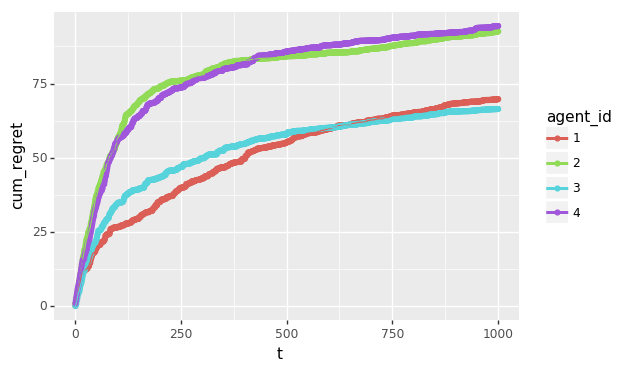

<ggplot: (8751105336277)>


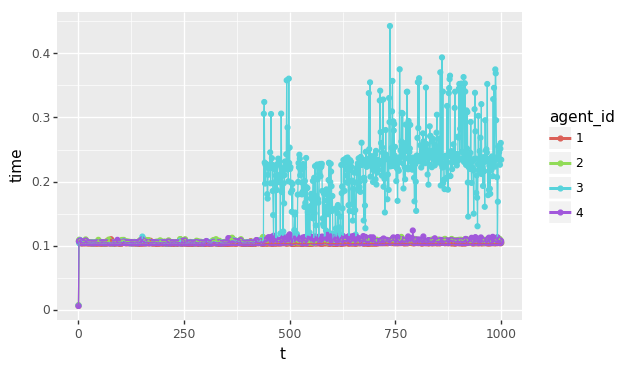

<ggplot: (8750920762221)>


In [14]:
plot_results(results)